In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.api as sm
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

In [2]:
data=pd.read_excel('C:\pbl_movie.xlsx',header=0)

In [3]:
X=pd.DataFrame()
y=pd.DataFrame()
y1=pd.DataFrame()

In [3]:
#애니메이션, 전체관람가 제거(다중공선성 문제 해결 위해)
X=data[['주연 top50 출연 여부','배급사','국적','전국 스크린수','경쟁작',
       '가족','공연','공포(호러)','기타','다큐멘터리','드라마','멜로/로맨스','뮤지컬',
       '미스터리','범죄','사극','스릴러','액션','어드벤처','전쟁',
       '코미디','판타지','SF','top영화감독 여부','네티즌 평점','러닝타임',
       '연작','원작','12세관람가','15세관람가','19세관람가',
       '연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
X1=data[['주연 top50 출연 여부','배급사', '전국 스크린수','러닝타임', '네티즌 평점',
        'top영화감독 여부','연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
X2=data[['주연 top50 출연 여부','전국 스크린수','15세관람가','top영화감독 여부','국적',
        '네티즌 평점','연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
y=data[['전국 관객수']]
y1=data[['전국 관객수 분류']]
y2=data[['전국 관객수 분류(2)']]

In [8]:
#단계별 선택법(stepwise selection)으로 변수 선정하기
variables = X.columns.tolist() #설명변수 리스트

selected_variables = [] #선택된 변수들 리스트
sl_enter=0.05 #변수 추가시 유의수준
sl_remove=0.05 #변수 제거시 유의수준

sv_per_step = [] #각 스텝별로 선택된 변수들
adjusted_r_squared = [] #각 스텝별 수정된 결정계수
steps=[] #스텝
step=0
while len(variables) >0:
    remainder = list(set(variables)- set(selected_variables))
    pval=pd.Series(index=remainder) #변수의 p-value리스트
    #기존에 포함된 변수에 새로운 변수 하나씩 돌아가면서 추가해
    #선형 모형에 적합시켜본다
    for col in remainder:
        newX= X[selected_variables+[col]] 
        newX= sm.add_constant(newX)
        model=sm.OLS(y,newX).fit()
        pval[col] = model.pvalues[col] #p-value리스트에 p-value값 넣기
    
    min_pval = pval.min()
    if min_pval < sl_enter: # 최소 p-value값이 유의수준 기준보다 작으면 포함
        selected_variables.append(pval.idxmin())
        #선택된 변수들중에서 어떤 변수를 제거할지 고른다
        while len(selected_variables) >0:
            selected_X= X[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval= sm.OLS(y,selected_X).fit().pvalues[1:] #절편의 p-value는 뺀다
            max_pval=selected_pval.max()
            if max_pval>=sl_remove: #최대 p-value값이 기준 유의수준보다 크거나 같으면 제외
                remove_variable= selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step+=1
        steps.append(step)
        adj_r_squared= sm.OLS(y,sm.add_constant(X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
            

<ipython-input-8-3f6821727654>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval=pd.Series(index=remainder) #변수의 p-value리스트
<ipython-input-8-3f6821727654>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval=pd.Series(index=remainder) #변수의 p-value리스트
<ipython-input-8-3f6821727654>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval=pd.Series(index=remainder) #변수의 p-value리스트
<ipython-input-8-3f6821727654>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval=pd.Series(index=remainder) #변수의 p-value

In [6]:
selected_variables

['전국 스크린수',
 'top영화감독 여부',
 '네티즌 평점',
 '연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))',
 '주연 top50 출연 여부',
 '국적',
 '15세관람가']

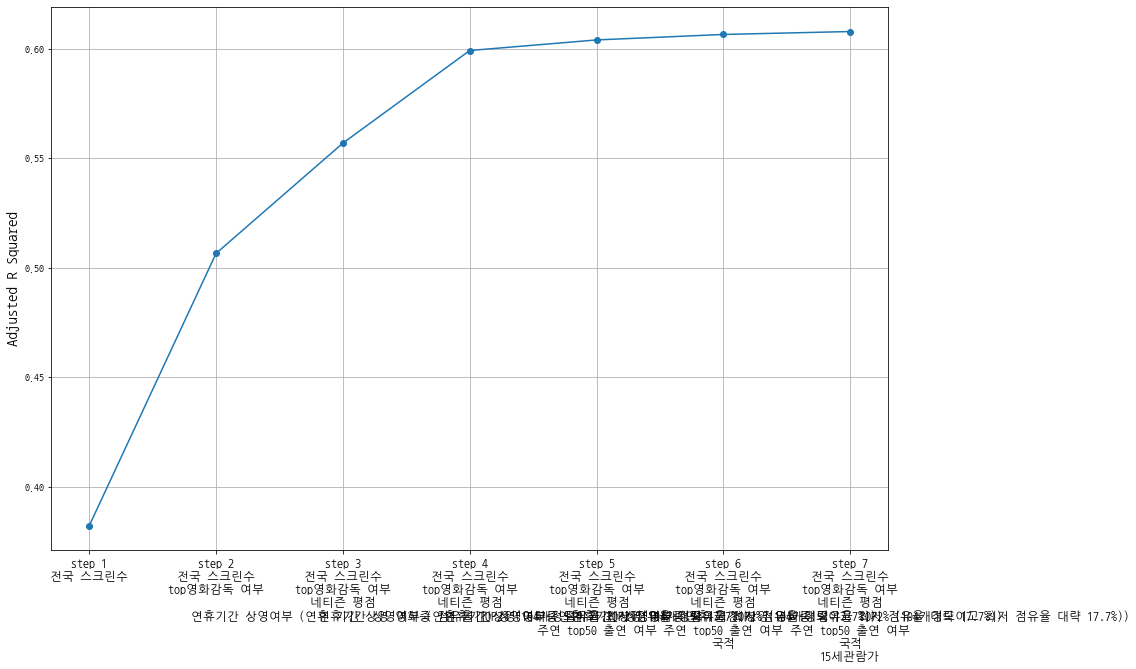

In [9]:
#단계별 모형 적합도 그래프
fig=plt.figure(figsize=(15,10))
fig.set_facecolor('white')

font_path="C:\\Windows\\Fonts\\NanumGothicCoding.ttf"
font= font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
font_size=15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)],fontsize=12)
plt.plot(steps, adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared', fontsize=font_size)
plt.grid(True)
plt.show()

In [5]:
#데이터들의 상관계수
corr=data.corr()
corr[['전국 관객수']]

전국 관객수
순번                                                 -0.760445
주연 top50 출연 여부                                      0.308597
배급사                                                 0.210274
수상내역                                                0.410716
국적                                                  0.147828
전국 스크린수                                             0.618742
전국 매출액                                              0.995747
전국 관객수 분류                                           0.878861
전국 관객수 분류(2)                                        0.923510
전국 관객수                                              1.000000
경쟁작                                                -0.000585
가족                                                 -0.048411
공연                                                 -0.021245
공포(호러)                                             -0.072037
기타                                                 -0.030380
다큐멘터리                                              -0.008026
드라마                                                -0.010606
멜로/로맨스                                             -0.049477
뮤지컬                                                -0.018552
미스터리                                               -0.030376
범죄                                                  0.052450
사극                                                  0.119753
스릴러                                                -0.048593
애니메이션                                              -0.133874
액션                                                  0.127379
어드벤처                                                0.035788
전쟁                                                  0.018268
코미디                                                 0.006044
판타지                                                 0.025833
SF                                                 -0.010094
러닝타임                                                0.343705
네티즌 평점                                              0.228383
top영화감독 여부                                          0.572736
연작                                                  0.055907
원작                                                  0.015567
전체관람가                                              -0.139325
12세관람가                                              0.103499
15세관람가                                              0.049507
19세관람가                                             -0.055618
연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 ...  0.447202
연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP5% (260개이고 최저 점유...  0.339667

In [9]:
# 다중공선성
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif= pd.DataFrame()
vif["VIF Factor"]= [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor                                           features
0     2.585731                                     주연 top50 출연 여부
1     2.662535                                                배급사
2     4.113345                                                 국적
3     6.951798                                            전국 스크린수
4     4.900085                                                경쟁작
5     1.096280                                                 가족
6     1.023646                                                 공연
7     2.049236                                             공포(호러)
8     1.036497                                                 기타
9     1.079872                                              다큐멘터리
10    5.829178                                                드라마
11    2.454183                                             멜로/로맨스
12    1.072418                                                뮤지컬
13    1.852420                                               미스터리
14    2.972674                                                 범죄
15    2.057767                                                 사극
16    2.441181                                                스릴러
17    7.657864                                                 액션
18    1.605254                                               어드벤처
19    1.176655                                                 전쟁
20    3.212085                                                코미디
21    1.424377                                                판타지
22    2.045106                                                 SF
23    1.361871                                         top영화감독 여부
24   35.294606                                             네티즌 평점
25   66.258596                                               러닝타임
26    1.670220                                                 연작
27    1.306399                                                 원작
28    7.204252                                             12세관람가
29    9.741318                                             15세관람가
30    3.886150                                             19세관람가
31    1.330459  연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저...

In [4]:
scaler=StandardScaler()
feature_to_scale=['전국 스크린수','러닝타임','네티즌 평점','경쟁작']
feature_to_scale1=['전국 스크린수','러닝타임','네티즌 평점']
feature_to_scale2=['전국 스크린수','네티즌 평점']
scale=scaler.fit_transform(data[feature_to_scale])
scale1=scaler.fit_transform(data[feature_to_scale1])
scale2=scaler.fit_transform(data[feature_to_scale2])
X[feature_to_scale]=scale
X1[feature_to_scale1]=scale1
X2[feature_to_scale2]=scale2

<ipython-input-4-2b440a3bce64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature_to_scale]=scale
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-4-2b440a3bce64>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

학습 데이터 점수 : 0.6353533137412636
평가 데이터 점수 : 0.5521029268667628
rmse : 1373032.2504501443
학습 데이터 점수 : 0.6159807883189966
평가 데이터 점수 : 0.5626032164255841
rmse1 : 1356567.6539990727
학습 데이터 점수 : 0.619219319653908
평가 데이터 점수 : 0.5478898704392949
rmse2 : 1376155.8823429614


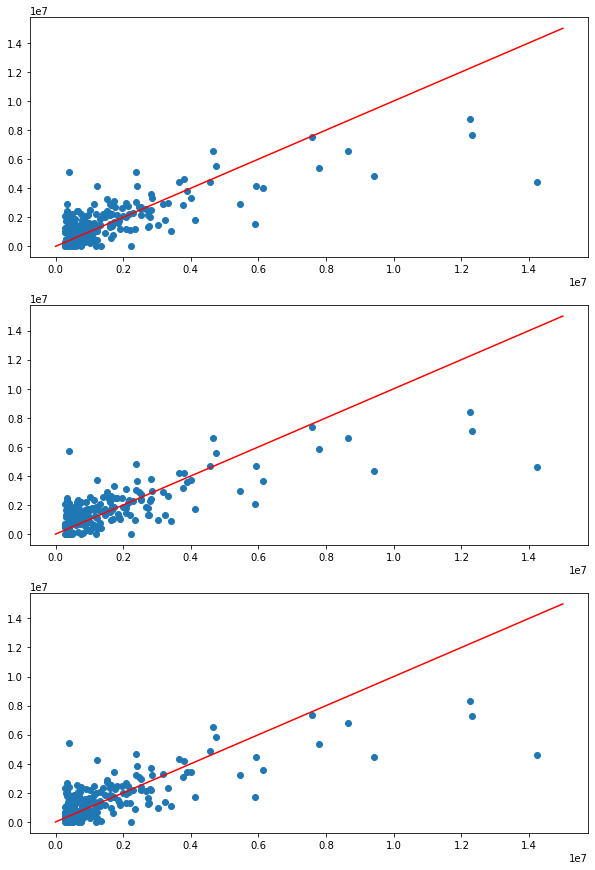

In [6]:
#다중선형회귀
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

linear=LinearRegression()
linear1=LinearRegression()
linear2=LinearRegression()

linear.fit(X_train, y_train)
linear1.fit(X_train1,y_train1)
linear2.fit(X_train2,y_train2)

y_pred=linear.predict(X_test)
y_pred1=linear1.predict(X_test1)
y_pred2=linear2.predict(X_test2)

#예측값이 음수인 경우 0으로 수정
for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
    if y_pred1[i]<0:
        y_pred1[i]=0
    if y_pred2[i]<0:
        y_pred2[i]=0

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse1=np.sqrt(mean_squared_error(y_test2,y_pred1))
rmse2=np.sqrt(mean_squared_error(y_test2,y_pred2))

print("학습 데이터 점수 : {}".format(linear.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(linear.score(X_test,y_test)))
print("rmse : {}".format(rmse))

print("학습 데이터 점수 : {}".format(linear1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(linear1.score(X_test1,y_test1)))
print("rmse1 : {}".format(rmse1))

print("학습 데이터 점수 : {}".format(linear2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(linear2.score(X_test2,y_test2)))
print("rmse2 : {}".format(rmse2))

n=np.arange(0,15000000)
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.scatter(y_test,y_pred,marker='o')
plt.plot(n,n,color='r')
plt.subplot(312)
plt.scatter(y_test1,y_pred1,marker='o')
plt.plot(n,n,color='r')
plt.subplot(313)
plt.scatter(y_test2,y_pred2, marker='o')
plt.plot(n,n,color='r')
plt.show()

학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.5792875676380783
rmse : 1346076.6250725326
학습 데이터 점수 : 0.9999960557030383
평가 데이터 점수 : 0.6343168934385219
rmse1 : 1254959.0610196576
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.5952043106008672
rmse2 : 1320368.1791512724


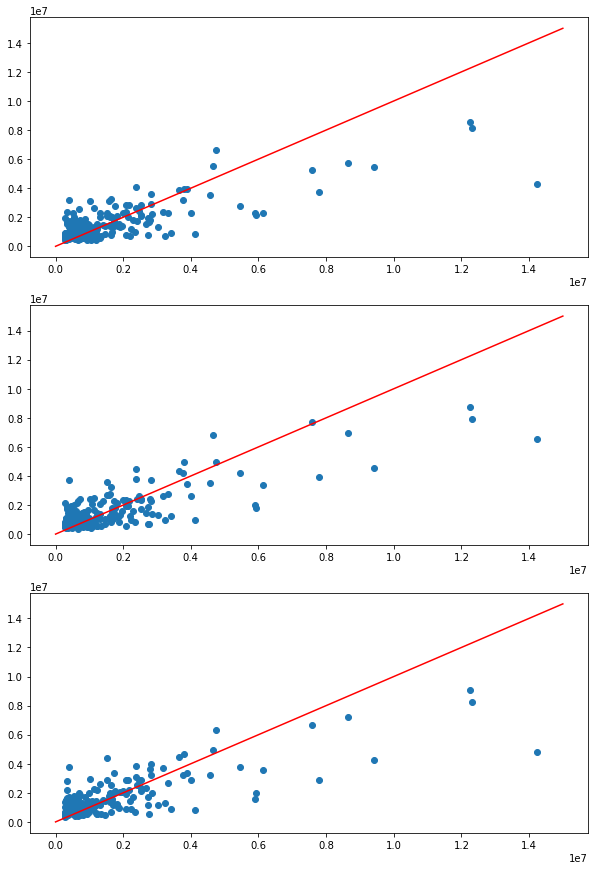

In [7]:
#k-최근접 이웃 알고리즘(회귀)
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

knr= KNeighborsRegressor(n_neighbors=10, weights="distance")
knr1= KNeighborsRegressor(n_neighbors=13, weights="distance")
knr2= KNeighborsRegressor(n_neighbors=12, weights="distance")

knr.fit(X_train,y_train)
knr1.fit(X_train1,y_train1)
knr2.fit(X_train2,y_train2)

y_pred=knr.predict(X_test)
y_pred1=knr1.predict(X_test1)
y_pred2=knr2.predict(X_test2)

for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
    if y_pred1[i]<0:
        y_pred1[i]=0
    if y_pred2[i]<0:
        y_pred2[i]=0

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse1=np.sqrt(mean_squared_error(y_test1,y_pred1))
rmse2=np.sqrt(mean_squared_error(y_test2,y_pred2))

print("학습 데이터 점수 : {}".format(knr.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(knr.score(X_test,y_test)))
print("rmse : {}".format(rmse))

print("학습 데이터 점수 : {}".format(knr1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(knr1.score(X_test1,y_test1)))
print("rmse1 : {}".format(rmse1))

print("학습 데이터 점수 : {}".format(knr2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(knr2.score(X_test2,y_test2)))
print("rmse2 : {}".format(rmse2))

n=np.arange(0,15000000)
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.scatter(y_test,y_pred,marker='o')
plt.plot(n,n,color='r')
plt.subplot(312)
plt.scatter(y_test1,y_pred1,marker='o')
plt.plot(n,n,color='r')
plt.subplot(313)
plt.scatter(y_test2,y_pred2, marker='o')
plt.plot(n,n,color='r')
plt.show()

In [52]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5,test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,30):
    knr= KNeighborsRegressor(n_neighbors=i, weights="distance")
    knr1= KNeighborsRegressor(n_neighbors=i, weights="distance")
    knr2= KNeighborsRegressor(n_neighbors=i, weights="distance")

    knr.fit(X_train,y_train)
    knr1.fit(X_train1,y_train1)
    knr2.fit(X_train2,y_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(knr.score(X_train,y_train)))
    print("평가 데이터 점수 : {}".format(knr.score(X_test,y_test)))
    print("학습 데이터 점수1 : {}".format(knr1.score(X_train1,y_train1)))
    print("평가 데이터 점수1 : {}".format(knr1.score(X_test1,y_test1)))
    print("학습 데이터 점수2 : {}".format(knr2.score(X_train2,y_train2)))
    print("평가 데이터 점수2 : {}".format(knr2.score(X_test2,y_test2)))
    t.loc[i-1]=[i,knr.score(X_test,y_test)]
    t1.loc[i-1]=[i,knr1.score(X_test1,y_test1)]
    t2.loc[i-1]=[i,knr2.score(X_test2,y_test2)]


1
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.35376468183309273
학습 데이터 점수1 : 0.9999921114060766
평가 데이터 점수1 : 0.5203805407158955
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.1013299634231235
2
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.5268391799913343
학습 데이터 점수1 : 0.9999960557030383
평가 데이터 점수1 : 0.49571917075296223
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.3752383706296819
3
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.4951750571466279
학습 데이터 점수1 : 0.9999960557030383
평가 데이터 점수1 : 0.5656334724096339
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.5000525404407341
4
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.49844910960658406
학습 데이터 점수1 : 0.9999960557030383
평가 데이터 점수1 : 0.5555667972805214
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.5305211059740549
5
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.5071049448654394
학습 데이터 점수1 : 0.9999960557030383
평가 데이터 점수1 : 0.5887814074513666
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.545486758185536
6
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.5063596282085085
학습 데이터 점수1 : 0.9999960557030383
평가 데이터 점수1 : 0.5757003854917653
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.5707315720695662
7
학습 데이터 점수 : 1.0
평가 데이터 점

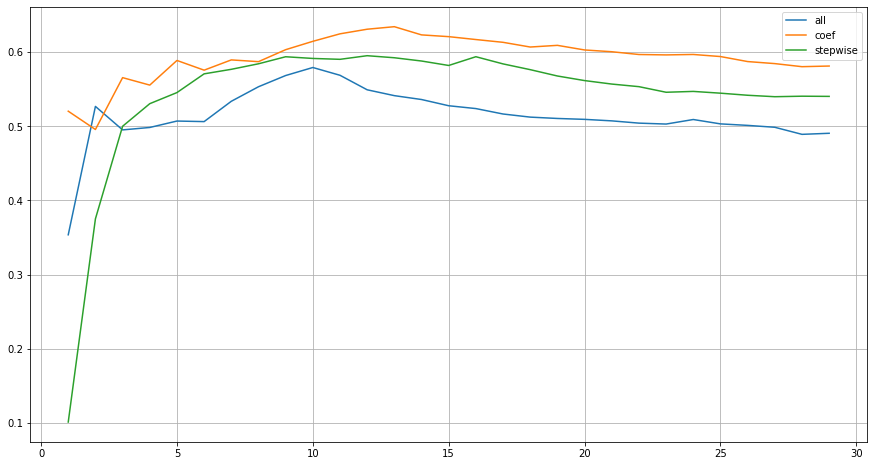

In [54]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [20]:
#서포트 벡터 머신(분류)
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)
svc=SVC(kernel='linear',C=0.06)
svc1=SVC(kernel='linear',C=0.14)
svc2=SVC(kernel='linear',C=1.4)
svc3=SVC(kernel='linear',C=0.06)
svc4=SVC(kernel='linear',C=0.14)
svc5=SVC(kernel='linear',C=1.4)

svc.fit(X_train,y1_train)
svc1.fit(X_train1,y1_train1)
svc2.fit(X_train2,y1_train2)
svc3.fit(X_train3,y2_train)
svc4.fit(X_train4,y2_train1)
svc5.fit(X_train5,y2_train2)

y_pred=svc.predict(X_test)
y_pred1=svc1.predict(X_test1)
y_pred2=svc2.predict(X_test2)
y_pred3=svc3.predict(X_test3)
y_pred4=svc4.predict(X_test4)
y_pred5=svc5.predict(X_test5)

print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(svc1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(svc1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(svc2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(svc2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(svc3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(svc3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(svc4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(svc4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(svc5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(svc5.score(X_test5,y2_test2)))

학습 데이터 점수 : 0.66375
평가 데이터 점수 : 0.695
학습 데이터 점수 : 0.64125
평가 데이터 점수 : 0.69
학습 데이터 점수 : 0.65625
평가 데이터 점수 : 0.7
학습 데이터 점수 : 0.645
평가 데이터 점수 : 0.68
학습 데이터 점수 : 0.6275
평가 데이터 점수 : 0.68
학습 데이터 점수 : 0.6325
평가 데이터 점수 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [26]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,100):
    svc=SVC(kernel='linear',C=i/50)
    svc1=SVC(kernel='linear',C=i/50)
    svc2=SVC(kernel='linear',C=i/50)

    svc.fit(X_train,y1_train)
    svc1.fit(X_train1,y1_train1)
    svc2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(svc1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(svc1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(svc2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(svc2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i/50,svc.score(X_test,y1_test)]
    t1.loc[i-1]=[i/50,svc1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/50,svc2.score(X_test2,y1_test2)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수 : 0.6275
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.60125
평가 데이터 점수1 : 0.63
학습 데이터 점수2 : 0.59625
평가 데이터 점수2 : 0.645
2
학습 데이터 점수 : 0.65625
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.62625
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.635
평가 데이터 점수2 : 0.675
3
학습 데이터 점수 : 0.66375
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.6425
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

4
학습 데이터 점수 : 0.67125
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.635
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.63875
평가 데이터 점수2 : 0.69
5
학습 데이터 점수 : 0.68
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.63625
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.675
6
학습 데이터 점수 : 0.68375
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

7
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.67
8
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.64875
평가 데이터 점수2 : 0.675
9
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6475
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

10
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.64875
평가 데이터 점수2 : 0.68
11
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.68
12
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65125
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

13
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.685
14
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.685
15
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.685
16
학습 데이터 점수 : 0.6825
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.685
17
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.685
18

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수 : 0.68375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.685
19
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.63875
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.685
20
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수2 : 0.685
21
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.69
22
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

23
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
24
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.69
25
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.6425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.69
26
학습 데이터 점수 : 0.685
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.69
27
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

28
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.63875
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.685
29
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.685
30
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.69
31
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.63875
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.69
32
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

33
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69
34
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.64
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69
35
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.63875
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

36
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65125
평가 데이터 점수2 : 0.69
37
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.69
38
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.6425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.69
39
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
40
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

41
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685
42
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685
43
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685
44
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.685
45
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

46
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.685
47
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69
48
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

49
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
50
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
51
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
52
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
53
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

54
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
55
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
56
학습 데이터 점수 : 0.68875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
57
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69
58
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


59
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69
60
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

61
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69
62
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.695
63
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.695
64
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.695
65
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

66
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.7
67
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
68
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
69
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
70
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수2 : 0.7
71
학습 데이터 점수 : 0.68875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
72
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

73
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
74
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
75
학습 데이터 점수 : 0.69125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
76
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
77
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

78
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
79
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
80
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
81
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
82
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

83
학습 데이터 점수 : 0.69375
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
84
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
85
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
86
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
87
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수2 : 0.7
88
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
89
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

90
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
91
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
92
학습 데이터 점수 : 0.69125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.7
93
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
94
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
95
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
96
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
97
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7
98
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

99
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


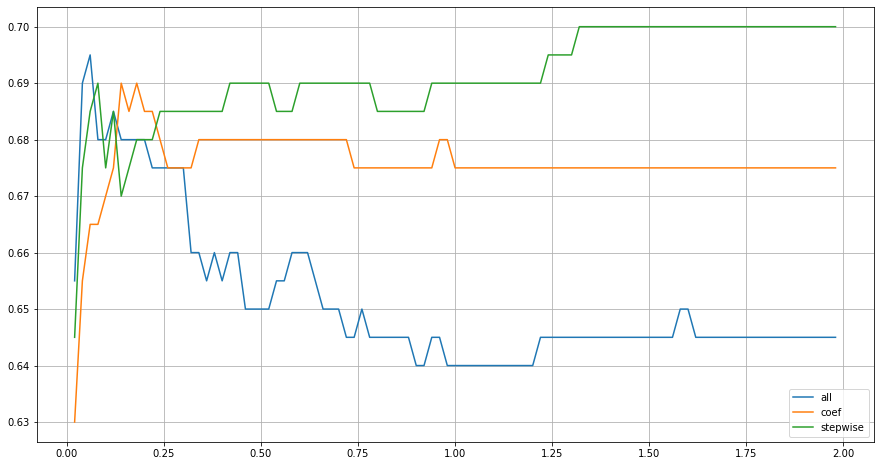

In [27]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [21]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      90  14  1  0
2      28  42  0  0
3       4   9  3  1
4       0   3  1  4 
col_0   1   2  3  4
row_0              
1      88  16  1  0
2      26  43  1  0
3       4   9  3  1
4       0   1  3  4 
col_0   1   2  3  4
row_0              
1      90  14  1  0
2      27  42  1  0
3       4   8  4  1
4       0   1  3  4


In [22]:
#서포트 벡터 머신(분류) rbf
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)
svc=SVC(kernel='rbf',C=0.9)
svc1=SVC(kernel='rbf',C=3.8)
svc2=SVC(kernel='rbf',C=2)
svc3=SVC(kernel='rbf',C=0.9)
svc4=SVC(kernel='rbf',C=3.8)
svc5=SVC(kernel='rbf',C=2)

svc.fit(X_train,y1_train)
svc1.fit(X_train1,y1_train1)
svc2.fit(X_train2,y1_train2)
svc3.fit(X_train3,y2_train)
svc4.fit(X_train4,y2_train1)
svc5.fit(X_train5,y2_train2)

y_pred=svc.predict(X_test)
y_pred1=svc1.predict(X_test1)
y_pred2=svc2.predict(X_test2)
y_pred3=svc3.predict(X_test3)
y_pred4=svc4.predict(X_test4)
y_pred5=svc5.predict(X_test5)

print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(svc1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(svc1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(svc2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(svc2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(svc3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(svc3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(svc4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(svc4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(svc5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(svc5.score(X_test5,y2_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.7575
평가 데이터 점수 : 0.71
학습 데이터 점수 : 0.7375
평가 데이터 점수 : 0.71
학습 데이터 점수 : 0.70375
평가 데이터 점수 : 0.72
학습 데이터 점수 : 0.73125
평가 데이터 점수 : 0.705
학습 데이터 점수 : 0.725
평가 데이터 점수 : 0.685
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.71


In [24]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,100):
    svc=SVC(kernel='rbf',C=i/10)
    svc1=SVC(kernel='rbf',C=i/10)
    svc2=SVC(kernel='rbf',C=i/10)

    svc.fit(X_train,y1_train)
    svc1.fit(X_train1,y1_train1)
    svc2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(svc1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(svc1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(svc2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(svc2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i/10,svc.score(X_test,y1_test)]
    t1.loc[i-1]=[i/10,svc1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/10,svc2.score(X_test2,y1_test2)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수 : 0.60625
평가 데이터 점수 : 0.635
학습 데이터 점수1 : 0.61
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 0.6075
평가 데이터 점수2 : 0.665
2
학습 데이터 점수 : 0.64
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

3
학습 데이터 점수 : 0.675
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.66375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.66375
평가 데이터 점수2 : 0.685
4
학습 데이터 점수 : 0.695
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

5
학습 데이터 점수 : 0.71625
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.67375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.675
평가 데이터 점수2 : 0.7
6
학습 데이터 점수 : 0.7325
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.67875
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

7
학습 데이터 점수 : 0.74375
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.685
평가 데이터 점수2 : 0.705
8
학습 데이터 점수 : 0.75
평가 데이터 점수 : 0.7
학습 데이터 점수1 : 0.685
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.68625
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

9
학습 데이터 점수 : 0.7575
평가 데이터 점수 : 0.71
학습 데이터 점수1 : 0.68875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.7
10
학습 데이터 점수 : 0.76625
평가 데이터 점수 : 0.7
학습 데이터 점수1 : 0.69375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

11
학습 데이터 점수 : 0.775
평가 데이터 점수 : 0.7
학습 데이터 점수1 : 0.70125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.695
평가 데이터 점수2 : 0.7
12
학습 데이터 점수 : 0.78
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.70125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.69
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

13
학습 데이터 점수 : 0.7825
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.705
14
학습 데이터 점수 : 0.78875
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.70375
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.69375
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

15
학습 데이터 점수 : 0.7975
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.70875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6925
평가 데이터 점수2 : 0.71
16
학습 데이터 점수 : 0.79875
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.70875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.69375
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

17
학습 데이터 점수 : 0.80375
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7
평가 데이터 점수2 : 0.715
18
학습 데이터 점수 : 0.8075
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

19
학습 데이터 점수 : 0.81
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.72
20
학습 데이터 점수 : 0.8175
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

21
학습 데이터 점수 : 0.825
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.72
22
학습 데이터 점수 : 0.8275
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.725
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

23
학습 데이터 점수 : 0.83
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.715
24
학습 데이터 점수 : 0.83375
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

25
학습 데이터 점수 : 0.8375
평가 데이터 점수 : 0.7
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.715
26
학습 데이터 점수 : 0.83875
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.73375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

27
학습 데이터 점수 : 0.8375
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.715
28
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.735
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

29
학습 데이터 점수 : 0.84375
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.735
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.71
30
학습 데이터 점수 : 0.84625
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

31
학습 데이터 점수 : 0.845
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7175
평가 데이터 점수2 : 0.72
32
학습 데이터 점수 : 0.845
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

33
학습 데이터 점수 : 0.85
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71875
평가 데이터 점수2 : 0.715
34
학습 데이터 점수 : 0.85
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71875
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

35
학습 데이터 점수 : 0.855
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.72
평가 데이터 점수2 : 0.715
36
학습 데이터 점수 : 0.8625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.72
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

37
학습 데이터 점수 : 0.865
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.72125
평가 데이터 점수2 : 0.72
38
학습 데이터 점수 : 0.8675
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.7225
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

39
학습 데이터 점수 : 0.8675
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7225
평가 데이터 점수2 : 0.715
40
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.72625
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

41
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73125
평가 데이터 점수2 : 0.715
42
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7325
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

43
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.715
44
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

45
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.715
46
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

47
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.715
48
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

49
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.715
50
학습 데이터 점수 : 0.875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

51
학습 데이터 점수 : 0.875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73375
평가 데이터 점수2 : 0.715
52
학습 데이터 점수 : 0.88
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.735
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

53
학습 데이터 점수 : 0.88125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.735
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.715
54
학습 데이터 점수 : 0.88125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

55
학습 데이터 점수 : 0.8825
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.705
56
학습 데이터 점수 : 0.88625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

57
학습 데이터 점수 : 0.88875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705
58
학습 데이터 점수 : 0.8925
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

59
학습 데이터 점수 : 0.89375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.705
60
학습 데이터 점수 : 0.89375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.735
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

61
학습 데이터 점수 : 0.895
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.705
62
학습 데이터 점수 : 0.895
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

63
학습 데이터 점수 : 0.89625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705
64
학습 데이터 점수 : 0.8975
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

65
학습 데이터 점수 : 0.89875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.73625
평가 데이터 점수2 : 0.705
66
학습 데이터 점수 : 0.8975
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.745
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

67
학습 데이터 점수 : 0.89875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.74625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705
68
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

69
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.705
70
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

71
학습 데이터 점수 : 0.90375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.705
72
학습 데이터 점수 : 0.90375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

73
학습 데이터 점수 : 0.905
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.705
74
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

75
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7425
평가 데이터 점수2 : 0.705
76
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7475
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

77
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.7
78
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

79
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.74875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.705
80
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.75125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

81
학습 데이터 점수 : 0.90875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7525
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7375
평가 데이터 점수2 : 0.695
82
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7525
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

83
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.75125
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.7
84
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.755
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73875
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

85
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.755
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74
평가 데이터 점수2 : 0.7
86
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

87
학습 데이터 점수 : 0.91875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.695
88
학습 데이터 점수 : 0.91875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

89
학습 데이터 점수 : 0.92
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7575
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.685
90
학습 데이터 점수 : 0.92125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7575
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

91
학습 데이터 점수 : 0.9225
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.685
92
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7575
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7425
평가 데이터 점수2 : 0.685
93
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7575
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74125
평가 데이터 점수2 : 0.685
94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7575
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7425
평가 데이터 점수2 : 0.685
95
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.76
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7425
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

96
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.76
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7425
평가 데이터 점수2 : 0.685
97
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

98
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.76
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74375
평가 데이터 점수2 : 0.685
99
학습 데이터 점수 : 0.9275
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.75875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.74375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


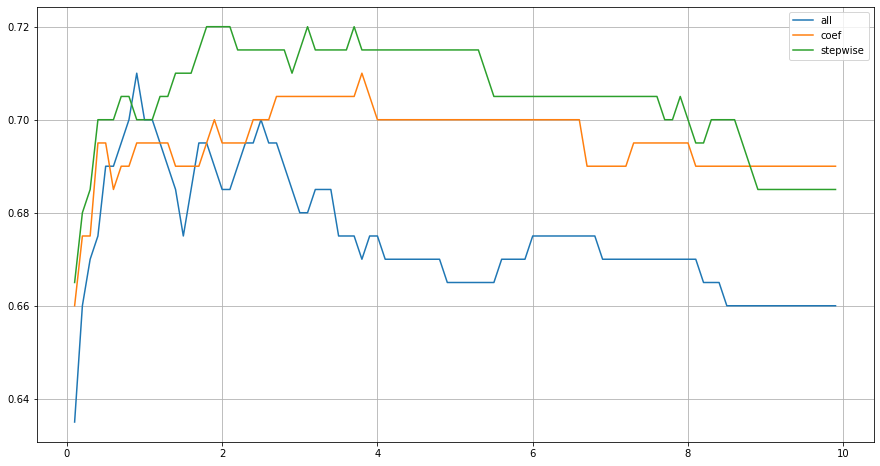

In [25]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [23]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      90  15  0  0
2      25  44  1  0
3       3   9  4  1
4       0   3  1  4 
col_0   1   2  3  4
row_0              
1      91  14  0  0
2      27  41  2  0
3       4   7  6  0
4       0   0  4  4 
col_0   1   2  3  4
row_0              
1      92  13  0  0
2      25  43  2  0
3       4   8  5  0
4       0   3  1  4


In [38]:
#서포트 벡터 머신(분류) poly
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)
svc=SVC(kernel='poly',C=0.5, degree=2)
svc1=SVC(kernel='poly',C=3.3, degree=3)
svc2=SVC(kernel='poly',C=1.9, degree=2)
svc3=SVC(kernel='poly',C=0.5, degree=2)
svc4=SVC(kernel='poly',C=3.3, degree=3)
svc5=SVC(kernel='poly',C=1.9, degree=2)

svc.fit(X_train,y1_train)
svc1.fit(X_train1,y1_train1)
svc2.fit(X_train2,y1_train2)
svc3.fit(X_train3,y2_train)
svc4.fit(X_train4,y2_train1)
svc5.fit(X_train5,y2_train2)

y_pred=svc.predict(X_test)
y_pred1=svc1.predict(X_test1)
y_pred2=svc2.predict(X_test2)
y_pred3=svc3.predict(X_test3)
y_pred4=svc4.predict(X_test4)
y_pred5=svc5.predict(X_test5)

print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(svc1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(svc1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(svc2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(svc2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(svc3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(svc3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(svc4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(svc4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(svc5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(svc5.score(X_test5,y2_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.695
학습 데이터 점수 : 0.71
평가 데이터 점수 : 0.715
학습 데이터 점수 : 0.665
평가 데이터 점수 : 0.735
학습 데이터 점수 : 0.67375
평가 데이터 점수 : 0.685
학습 데이터 점수 : 0.70125
평가 데이터 점수 : 0.685
학습 데이터 점수 : 0.64375
평가 데이터 점수 : 0.72


In [36]:
# X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
t_1=pd.DataFrame(columns=['i','score'])
t1_1=pd.DataFrame(columns=['i','score'])
t2_1=pd.DataFrame(columns=['i','score'])
t_2=pd.DataFrame(columns=['i','score'])
t1_2=pd.DataFrame(columns=['i','score'])
t2_2=pd.DataFrame(columns=['i','score'])

for k in range(2,5):
    for i in range(1,100):
        svc=SVC(kernel='poly',C=i/10, degree=k)
        svc1=SVC(kernel='poly',C=i/10, degree=k)
        svc2=SVC(kernel='poly',C=i/10, degree=k)

        svc.fit(X_train,y1_train)
        svc1.fit(X_train1,y1_train1)
        svc2.fit(X_train2,y1_train2)
        print(i)
        print("학습 데이터 점수 : {}".format(svc.score(X_train,y1_train)))
        print("평가 데이터 점수 : {}".format(svc.score(X_test,y1_test)))
        print("학습 데이터 점수1 : {}".format(svc1.score(X_train1,y1_train1)))
        print("평가 데이터 점수1 : {}".format(svc1.score(X_test1,y1_test1)))
        print("학습 데이터 점수2 : {}".format(svc2.score(X_train2,y1_train2)))
        print("평가 데이터 점수2 : {}".format(svc2.score(X_test2,y1_test2)))
        if(k==2):
            t.loc[i-1]=[i/10,svc.score(X_test,y1_test)]
            t1.loc[i-1]=[i/10,svc1.score(X_test1,y1_test1)]
            t2.loc[i-1]=[i/10,svc2.score(X_test2,y1_test2)]
        elif(k==3):
            t_1.loc[i-1]=[i/10,svc.score(X_test,y1_test)]
            t1_1.loc[i-1]=[i/10,svc1.score(X_test1,y1_test1)]
            t2_1.loc[i-1]=[i/10,svc2.score(X_test2,y1_test2)]
        elif(k==4):
            t_2.loc[i-1]=[i/10,svc.score(X_test,y1_test)]
            t1_2.loc[i-1]=[i/10,svc1.score(X_test1,y1_test1)]
            t2_2.loc[i-1]=[i/10,svc2.score(X_test2,y1_test2)]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수 : 0.5925
평가 데이터 점수 : 0.605
학습 데이터 점수1 : 0.57
평가 데이터 점수1 : 0.605
학습 데이터 점수2 : 0.59875
평가 데이터 점수2 : 0.65
2
학습 데이터 점수 : 0.64
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.6275
평가 데이터 점수2 : 0.675
3
학습 데이터 점수 : 0.6675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.64125
평가 데이터 점수2 : 0.71
4
학습 데이터 점수 : 0.68375
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.6325
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.65125
평가 데이터 점수2 : 0.72
5
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.695
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.73
6
학습 데이터 점수 : 0.70125
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.73
7
학습 데이터 점수 : 0.715
평가 데이터 점수 : 0.685
학습 데이터 점수1 : 0.65125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.735


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

8
학습 데이터 점수 : 0.71875
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.73
9
학습 데이터 점수 : 0.7325
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.65125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.73
10
학습 데이터 점수 : 0.7375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.65375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.73
11
학습 데이터 점수 : 0.74
평가 데이터 점수 : 0.69
학습 데이터 점수1 : 0.6575
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.73
12
학습 데이터 점수 : 0.74125
평가 데이터 점수 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.65375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.73
13
학습 데이터 점수 : 0.75
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.65375
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.73
14
학습 데이터 점수 : 0.7525
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.65375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.73


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

15
학습 데이터 점수 : 0.755
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.65625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.73
16
학습 데이터 점수 : 0.7575
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.65875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.73


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

17
학습 데이터 점수 : 0.75875
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.6575
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.73
18
학습 데이터 점수 : 0.7625
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.65875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.735
19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.76375
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.66
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.735
20
학습 데이터 점수 : 0.765
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.65875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.735
21
학습 데이터 점수 : 0.76625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66375
평가 데이터 점수2 : 0.735
22
학습 데이터 점수 : 0.76625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.66625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66375
평가 데이터 점수2 : 0.73
23
학습 데이터 점수 : 0.76625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.66625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.73
24
학습 데이터 점수 : 0.76875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.66875
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.73
25
학습 데이터 점수 : 0.76375


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.73
26
학습 데이터 점수 : 0.76375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.73
27
학습 데이터 점수 : 0.76375


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.73
28
학습 데이터 점수 : 0.76875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.73
29
학습 데이터 점수 : 0.77125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.735
30
학습 데이터 점수 : 0.77375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.66875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.67125
평가 데이터 점수2 : 0.735
31
학습 데이터 점수 : 0.77625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.66875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.735
32
학습 데이터 점수 : 0.77625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.735
33


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.77875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.735
34
학습 데이터 점수 : 0.78
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.735
35


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.7825
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6725
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.73
36
학습 데이터 점수 : 0.78375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66375
평가 데이터 점수2 : 0.73
37


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.785
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66375
평가 데이터 점수2 : 0.73
38
학습 데이터 점수 : 0.785
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.73
39


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.78625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.725
40
학습 데이터 점수 : 0.78875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.725
41
학습 데이터 점수 : 0.78875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.725
42
학습 데이터 점수 : 0.78875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
43


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.79125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
44
학습 데이터 점수 : 0.79125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
45


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.795
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
46
학습 데이터 점수 : 0.79625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.72
47


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.7975
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.67625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
48
학습 데이터 점수 : 0.7975
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
49
학습 데이터 점수 : 0.79625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
50
학습 데이터 점수 : 0.795
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

51
학습 데이터 점수 : 0.79625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
52
학습 데이터 점수 : 0.7975
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

53
학습 데이터 점수 : 0.8
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
54
학습 데이터 점수 : 0.80125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

55
학습 데이터 점수 : 0.8025
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
56
학습 데이터 점수 : 0.8025
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

57
학습 데이터 점수 : 0.80375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
58
학습 데이터 점수 : 0.805
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

59
학습 데이터 점수 : 0.805
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
60
학습 데이터 점수 : 0.80375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

61
학습 데이터 점수 : 0.805
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
62
학습 데이터 점수 : 0.80625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

63
학습 데이터 점수 : 0.80625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
64
학습 데이터 점수 : 0.80875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

65
학습 데이터 점수 : 0.81
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
66
학습 데이터 점수 : 0.81125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

67
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
68
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

69
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
70
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

71
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
72
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

73
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
74
학습 데이터 점수 : 0.815
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

75
학습 데이터 점수 : 0.8175
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
76
학습 데이터 점수 : 0.8175
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

77
학습 데이터 점수 : 0.8175
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
78
학습 데이터 점수 : 0.81875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

79
학습 데이터 점수 : 0.81875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
80
학습 데이터 점수 : 0.81875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

81
학습 데이터 점수 : 0.82
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72
82
학습 데이터 점수 : 0.82
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

83
학습 데이터 점수 : 0.82125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
84
학습 데이터 점수 : 0.82125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

85
학습 데이터 점수 : 0.81875
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66625
평가 데이터 점수2 : 0.72
86
학습 데이터 점수 : 0.82
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

87
학습 데이터 점수 : 0.82125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
88
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6675
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

89
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.72
90
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

91
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.67
평가 데이터 점수2 : 0.72
92
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

93
학습 데이터 점수 : 0.8225
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.72
94
학습 데이터 점수 : 0.82375
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

95
학습 데이터 점수 : 0.8275
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.72
96
학습 데이터 점수 : 0.8275
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

97
학습 데이터 점수 : 0.82875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.67375
평가 데이터 점수2 : 0.72
98
학습 데이터 점수 : 0.83
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.67375
평가 데이터 점수2 : 0.72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

99
학습 데이터 점수 : 0.82875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6775
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.67375
평가 데이터 점수2 : 0.72
1
학습 데이터 점수 : 0.5725
평가 데이터 점수 : 0.575
학습 데이터 점수1 : 0.57
평가 데이터 점수1 : 0.575
학습 데이터 점수2 : 0.60375
평가 데이터 점수2 : 0.64
2
학습 데이터 점수 : 0.63125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.625
학습 데이터 점수1 : 0.6
평가 데이터 점수1 : 0.615
학습 데이터 점수2 : 0.63625
평가 데이터 점수2 : 0.66
3
학습 데이터 점수 : 0.66
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.615
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.68
4
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.635


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.68
5
학습 데이터 점수 : 0.7175
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 0.67125
평가 데이터 점수2 : 0.675
6
학습 데이터 점수 : 0.7375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.6725
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.675
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

7
학습 데이터 점수 : 0.75375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.68375
평가 데이터 점수2 : 0.68
8
학습 데이터 점수 : 0.7575
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.68
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.6875
평가 데이터 점수2 : 0.685
9
학습 데이터 점수 : 0.7625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.67875
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.69
평가 데이터 점수2 : 0.69
10
학습 데이터 점수 : 0.76875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.69375
평가 데이터 점수2 : 0.68
11
학습 데이터 점수 : 0.77375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.69375


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.695
12
학습 데이터 점수 : 0.78125
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.69375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.685
13
학습 데이터 점수 : 0.7875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.69375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.6925
평가 데이터 점수2 : 0.695
14
학습 데이터 점수 : 0.79125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.695
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.695
평가 데이터 점수2 : 0.7
15
학습 데이터 점수 : 0.8
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6975


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.69875
평가 데이터 점수2 : 0.705
16
학습 데이터 점수 : 0.80375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.6975
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.70125
평가 데이터 점수2 : 0.705
17
학습 데이터 점수 : 0.805
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.69875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.69875
평가 데이터 점수2 : 0.695
18
학습 데이터 점수 : 0.80625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7
평가 데이터 점수2 : 0.695
19
학습 데이터 점수 : 0.81
평가 데이터 점수 : 0.67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.69
20
학습 데이터 점수 : 0.81375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.695
21
학습 데이터 점수 : 0.8125

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.70125
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.695
22
학습 데이터 점수 : 0.81625
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.695
23
학습 데이터 점수 : 0.82
평가 데이터 점수 : 0.67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.7
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.69
24
학습 데이터 점수 : 0.825
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.70375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.69
25

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수 : 0.8325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.705
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.705
평가 데이터 점수2 : 0.695
26
학습 데이터 점수 : 0.835
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.70375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.705
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

27
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.705
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.7
28
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

29
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.705
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.695
30
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

31
학습 데이터 점수 : 0.845
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.705
평가 데이터 점수2 : 0.69
32
학습 데이터 점수 : 0.845
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.705
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

33
학습 데이터 점수 : 0.85125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.69
34
학습 데이터 점수 : 0.85625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.7075
평가 데이터 점수1 : 0.715
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

35
학습 데이터 점수 : 0.86
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.7075
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.69
36
학습 데이터 점수 : 0.86
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7075
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

37
학습 데이터 점수 : 0.86
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.69
38
학습 데이터 점수 : 0.86375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.70875
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

39
학습 데이터 점수 : 0.86375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7075
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.685
40
학습 데이터 점수 : 0.8675
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

41
학습 데이터 점수 : 0.86875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.685
42
학습 데이터 점수 : 0.86875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

43
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.685
44
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

45
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.685
46
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

47
학습 데이터 점수 : 0.8725
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.685
48
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

49
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.685
50
학습 데이터 점수 : 0.875
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

51
학습 데이터 점수 : 0.8775
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.68
52
학습 데이터 점수 : 0.885
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

53
학습 데이터 점수 : 0.88625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.68
54
학습 데이터 점수 : 0.8875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

55
학습 데이터 점수 : 0.8875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.685
56
학습 데이터 점수 : 0.89125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

57
학습 데이터 점수 : 0.89125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695
58
학습 데이터 점수 : 0.8925
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

59
학습 데이터 점수 : 0.89375
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.7
60
학습 데이터 점수 : 0.895
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

61
학습 데이터 점수 : 0.89625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.7
62
학습 데이터 점수 : 0.89875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

63
학습 데이터 점수 : 0.9
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.7
64
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

65
학습 데이터 점수 : 0.90375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695
66
학습 데이터 점수 : 0.905
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

67
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695
68
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

69
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.71125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695
70
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

71
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695
72
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

73
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.695
74
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

75
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695
76
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.7
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

77
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.695
78
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

79
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.695
80
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

81
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695
82
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

83
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695
84
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

85
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695
86
학습 데이터 점수 : 0.91375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.7175
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

87
학습 데이터 점수 : 0.915
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695
88
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

89
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.7175
평가 데이터 점수2 : 0.695
90
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

91
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7
92
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

93
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.7175
평가 데이터 점수2 : 0.7
94
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

95
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7
96
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

97
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7
98
학습 데이터 점수 : 0.9175
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

99
학습 데이터 점수 : 0.9175
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.71
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.7
1
학습 데이터 점수 : 0.57375
평가 데이터 점수 : 0.55
학습 데이터 점수1 : 0.56375
평가 데이터 점수1 : 0.565
학습 데이터 점수2 : 0.6
평가 데이터 점수2 : 0.63
2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.61875
평가 데이터 점수 : 0.56
학습 데이터 점수1 : 0.59875
평가 데이터 점수1 : 0.595
학습 데이터 점수2 : 0.62125
평가 데이터 점수2 : 0.645
3
학습 데이터 점수 : 0.665
평가 데이터 점수 : 0.59
학습 데이터 점수1 : 0.6175
평가 데이터 점수1 : 0.62
학습 데이터 점수2 : 0.63625
평가 데이터 점수2 : 0.66
4
학습 데이터 점수 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.635
학습 데이터 점수1 : 0.63125
평가 데이터 점수1 : 0.635
학습 데이터 점수2 : 0.6425
평가 데이터 점수2 : 0.655
5
학습 데이터 점수 : 0.7125
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.6425
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.68
6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.73875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.645
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.68
7
학습 데이터 점수 : 0.75125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.65125
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.665
평가 데이터 점수2 : 0.675
8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수 : 0.7625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.65375
평가 데이터 점수1 : 0.645
학습 데이터 점수2 : 0.66875
평가 데이터 점수2 : 0.67
9
학습 데이터 점수 : 0.77125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.65875
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.665


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

10
학습 데이터 점수 : 0.7775
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.6675
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.6725
평가 데이터 점수2 : 0.68
11
학습 데이터 점수 : 0.79125
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.67125
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.675
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

12
학습 데이터 점수 : 0.79875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.68
평가 데이터 점수2 : 0.675
13
학습 데이터 점수 : 0.805
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.675
평가 데이터 점수1 : 0.645
학습 데이터 점수2 : 0.68
평가 데이터 점수2 : 0.67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

14
학습 데이터 점수 : 0.81
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6825
평가 데이터 점수1 : 0.645
학습 데이터 점수2 : 0.68375
평가 데이터 점수2 : 0.67
15
학습 데이터 점수 : 0.815
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6875
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.6825
평가 데이터 점수2 : 0.67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

16
학습 데이터 점수 : 0.82125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.69
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.685
평가 데이터 점수2 : 0.67
17
학습 데이터 점수 : 0.82625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6925
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.68625
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

18
학습 데이터 점수 : 0.82875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.69375
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.6875
평가 데이터 점수2 : 0.675
19
학습 데이터 점수 : 0.83125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.69375
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.6875
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

20
학습 데이터 점수 : 0.83375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6925
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.68875
평가 데이터 점수2 : 0.675
21
학습 데이터 점수 : 0.8375
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.695
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.69125
평가 데이터 점수2 : 0.67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

22
학습 데이터 점수 : 0.84125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.69625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.69375
평가 데이터 점수2 : 0.67
23
학습 데이터 점수 : 0.8425
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.69625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.69375
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

24
학습 데이터 점수 : 0.84375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.695
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.69625
평가 데이터 점수2 : 0.675
25
학습 데이터 점수 : 0.84625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.69625
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

26
학습 데이터 점수 : 0.85125
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.69625
평가 데이터 점수2 : 0.675
27
학습 데이터 점수 : 0.855
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.7025
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6975
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

28
학습 데이터 점수 : 0.85625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.70625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.69875
평가 데이터 점수2 : 0.68
29
학습 데이터 점수 : 0.8575
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.70625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

30
학습 데이터 점수 : 0.86375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7075
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.70125
평가 데이터 점수2 : 0.68
31
학습 데이터 점수 : 0.8675
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.70875
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.70125
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

32
학습 데이터 점수 : 0.87
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.71
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.7025
평가 데이터 점수2 : 0.685
33
학습 데이터 점수 : 0.87125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

34
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.70375
평가 데이터 점수2 : 0.685
35
학습 데이터 점수 : 0.87375
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

36
학습 데이터 점수 : 0.875
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.705
평가 데이터 점수2 : 0.685
37
학습 데이터 점수 : 0.88
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.71375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

38
학습 데이터 점수 : 0.8825
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.7125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.70625
평가 데이터 점수2 : 0.69
39
학습 데이터 점수 : 0.885
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7075
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

40
학습 데이터 점수 : 0.8875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.715
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.70875
평가 데이터 점수2 : 0.69
41
학습 데이터 점수 : 0.89
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.71625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

42
학습 데이터 점수 : 0.89125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.7175
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.695
43
학습 데이터 점수 : 0.8925
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.71875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71125
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

44
학습 데이터 점수 : 0.8925
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.72
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.69
45
학습 데이터 점수 : 0.8925
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.72
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7125
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

46
학습 데이터 점수 : 0.895
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.69
47
학습 데이터 점수 : 0.89625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

48
학습 데이터 점수 : 0.89875
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.69
49
학습 데이터 점수 : 0.9
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72375
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

50
학습 데이터 점수 : 0.9
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7225
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.69
51
학습 데이터 점수 : 0.9
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7225
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

52
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7225
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.715
평가 데이터 점수2 : 0.685
53
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.725
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7175
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

54
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.725
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71625
평가 데이터 점수2 : 0.685
55
학습 데이터 점수 : 0.9025
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.72
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

56
학습 데이터 점수 : 0.90375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.72625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.72
평가 데이터 점수2 : 0.69
57
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.72625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71875
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

58
학습 데이터 점수 : 0.90625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.72625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.71875
평가 데이터 점수2 : 0.69
59
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.7275
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

60
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7275
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7225
평가 데이터 점수2 : 0.69
61
학습 데이터 점수 : 0.9075
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.72875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7225
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

62
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7275
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.69
63
학습 데이터 점수 : 0.91
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.72875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

64
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.72875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.69
65
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.725
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

66
학습 데이터 점수 : 0.91125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.69
67
학습 데이터 점수 : 0.9125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

68
학습 데이터 점수 : 0.915
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.685
69
학습 데이터 점수 : 0.915
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72375
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

70
학습 데이터 점수 : 0.915
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.725
평가 데이터 점수2 : 0.685
71
학습 데이터 점수 : 0.91625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72625
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

72
학습 데이터 점수 : 0.9175
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72625
평가 데이터 점수2 : 0.69
73
학습 데이터 점수 : 0.92
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72625
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

74
학습 데이터 점수 : 0.9225
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72625
평가 데이터 점수2 : 0.69
75
학습 데이터 점수 : 0.9225
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7275
평가 데이터 점수2 : 0.685
76
학습 데이터 점수 : 0.9225
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7275
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

77
학습 데이터 점수 : 0.925
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.685
78
학습 데이터 점수 : 0.92625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

79
학습 데이터 점수 : 0.9275
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69
80
학습 데이터 점수 : 0.92875
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

81
학습 데이터 점수 : 0.93125
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73125
평가 데이터 점수2 : 0.69
82
학습 데이터 점수 : 0.9325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69
83
학습 데이터 점수 : 0.9325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

84
학습 데이터 점수 : 0.9325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73125
평가 데이터 점수2 : 0.69
85
학습 데이터 점수 : 0.9325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69
86
학습 데이터 점수 : 0.9325
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

87
학습 데이터 점수 : 0.93375
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.73125
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.69
88
학습 데이터 점수 : 0.93625
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 0.7325
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

89
학습 데이터 점수 : 0.93625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73375
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.69
90
학습 데이터 점수 : 0.93625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.735


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.685
91
학습 데이터 점수 : 0.93625
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.735
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

92
학습 데이터 점수 : 0.9375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.7275
평가 데이터 점수2 : 0.68
93
학습 데이터 점수 : 0.93875
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73625
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7275


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수2 : 0.68
94
학습 데이터 점수 : 0.94125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.7275
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

95
학습 데이터 점수 : 0.94125
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.68
96
학습 데이터 점수 : 0.9425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.73875
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.72875
평가 데이터 점수2 : 0.68
97
학습 데이터 점수 : 0.94375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

98
학습 데이터 점수 : 0.94375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.68
99
학습 데이터 점수 : 0.94375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.74
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 0.73
평가 데이터 점수2 : 0.685


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


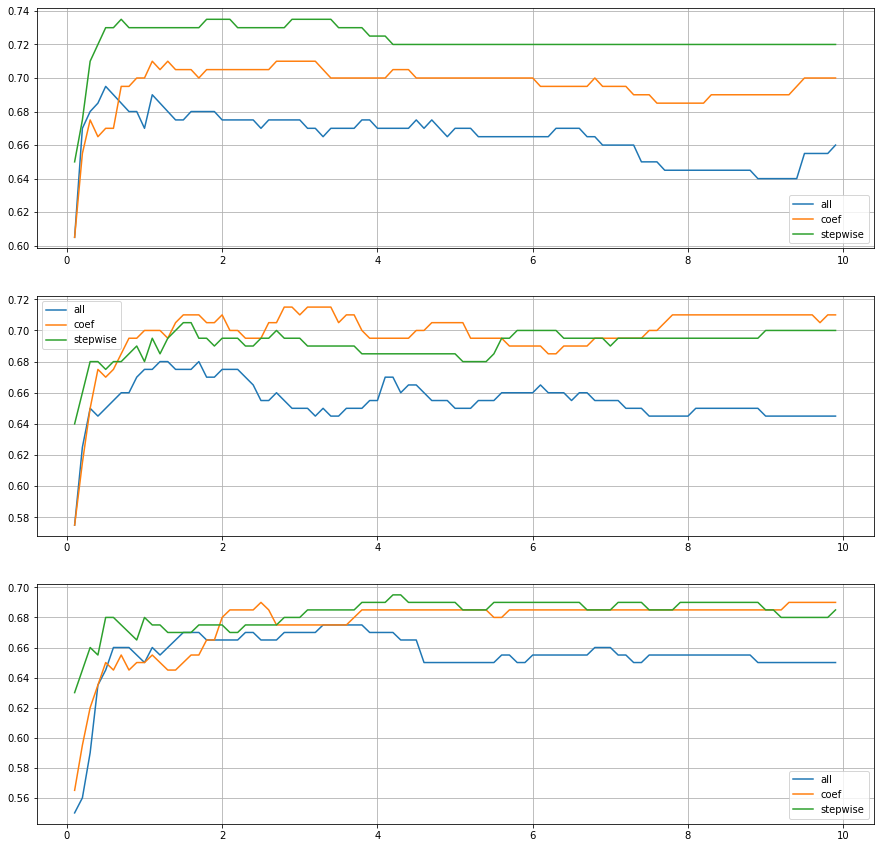

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.grid()
plt.legend()
plt.subplot(312)
plt.plot(t_1[['i']],t_1[['score']],label="all")
plt.plot(t1_1[['i']],t1_1[['score']],label="coef")
plt.plot(t2_1[['i']],t2_1[['score']],label="stepwise")
plt.grid()
plt.legend()
plt.subplot(313)
plt.plot(t_2[['i']],t_2[['score']],label="all")
plt.plot(t1_2[['i']],t1_2[['score']],label="coef")
plt.plot(t2_2[['i']],t2_2[['score']],label="stepwise")
plt.grid()
plt.legend()

In [39]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      94  11  0  0
2      32  38  0  0
3       4   9  3  1
4       0   3  1  4 
col_0   1   2  3  4
row_0              
1      95  10  0  0
2      32  36  2  0
3       4   5  8  0
4       0   3  1  4 
col_0   1   2  3  4
row_0              
1      98   7  0  0
2      30  39  1  0
3       5   5  6  1
4       1   1  2  4


In [12]:
#다항선형회귀(2차식)
from sklearn.preprocessing import PolynomialFeatures
linear=LinearRegression()
linear1=LinearRegression()
linear2=LinearRegression()

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

for i in range(1,5):
    poly_features = PolynomialFeatures(degree=i)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)
    X_train_poly1 = poly_features.fit_transform(X_train1)
    X_test_poly1 = poly_features.fit_transform(X_test1)
    X_train_poly2 = poly_features.fit_transform(X_train2)
    X_test_poly2 = poly_features.fit_transform(X_test2)
    linear.fit(X_train_poly,y_train)
    linear1.fit(X_train_poly1,y_train1)
    linear2.fit(X_train_poly2,y_train2)
    print("degree={}".format(i))
    print("학습 데이터 점수 : {}".format(linear.score(X_train_poly,y_train)))
    print("평가 데이터 점수 : {}".format(linear.score(X_test_poly,y_test)))

    print("학습 데이터 점수 : {}".format(linear1.score(X_train_poly1,y_train1)))
    print("평가 데이터 점수 : {}".format(linear1.score(X_test_poly1,y_test1)))

    print("학습 데이터 점수 : {}".format(linear2.score(X_train_poly2,y_train2)))
    print("평가 데이터 점수 : {}".format(linear2.score(X_test_poly2,y_test2)))

degree=1
학습 데이터 점수 : 0.6353533137412636
평가 데이터 점수 : 0.5521029268667628
학습 데이터 점수 : 0.6159807883189966
평가 데이터 점수 : 0.5626032164255841
학습 데이터 점수 : 0.619219319653908
평가 데이터 점수 : 0.5478898704392953
degree=2
학습 데이터 점수 : 0.8218357969062733
평가 데이터 점수 : -4.486817340508682e+22
학습 데이터 점수 : 0.6771837050877234
평가 데이터 점수 : 0.6154553146015471
학습 데이터 점수 : 0.6816563724487494
평가 데이터 점수 : 0.6161351507469739
degree=3
학습 데이터 점수 : 0.9949758768679119
평가 데이터 점수 : -4.434486722586218e+18
학습 데이터 점수 : -3.478600170479427
평가 데이터 점수 : -6.093170417493383
학습 데이터 점수 : 0.7288213034295796
평가 데이터 점수 : 0.5445262557200932
degree=4
학습 데이터 점수 : 1.0
평가 데이터 점수 : -42.674113041136536
학습 데이터 점수 : 0.5150131013295061
평가 데이터 점수 : -35.06562994871827
학습 데이터 점수 : -6.6822509764535125
평가 데이터 점수 : -85.7457101337318


In [60]:
#필요없는 내용일듯
#서포트 벡터 머신(회귀) 커널 함수 바꿔가면서 해본 것 linear 말고는 결과 안좋음
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=1,test_size=0.2)
svr_linear =SVR(kernel='linear', C=230000, epsilon=90000)
svr_linear.fit(X_train,y_train)
print("학습 데이터 점수 : {}".format(svr_linear.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_linear.score(X_test,y_test)))
svr_poly=SVR(kernel='poly',C=710000, epsilon=20000)
svr_poly.fit(X_train,y_train)
print("학습 데이터 점수 : {}".format(svr_poly.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_poly.score(X_test,y_test)))
svr_rbf=SVR(kernel='rbf',C=360000, epsilon=100000)
svr_rbf.fit(X_train,y_train)
print("학습 데이터 점수 : {}".format(svr_rbf.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_rbf.score(X_test,y_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.5851482064060379
평가 데이터 점수 : 0.5707019418622332
학습 데이터 점수 : 0.6970471446598391
평가 데이터 점수 : 0.5695581306109485
학습 데이터 점수 : 0.47743613904838056
평가 데이터 점수 : 0.4222701485895005


In [68]:
#### 서포트 벡터 머신(회귀) linear
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

svr_linear=SVR(kernel='linear',C=340000, epsilon=30000)
svr_linear1=SVR(kernel='linear',C=230000, epsilon=120000)
svr_linear2=SVR(kernel='linear',C=200000, epsilon=40000)

svr_linear.fit(X_train,y_train)
svr_linear1.fit(X_train1,y_train1)
svr_linear2.fit(X_train2,y_train2)
y_pred=svr_linear.predict(X_test)
y_pred1=svr_linear1.predict(X_test1)
y_pred2=svr_linear2.predict(X_test2)
for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
    if y_pred1[i]<0:
        y_pred1[i]=0
    if y_pred2[i]<0:
        y_pred2[i]=0
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse1=np.sqrt(mean_squared_error(y_test1,y_pred1))
rmse2=np.sqrt(mean_squared_error(y_test2,y_pred2))
print("학습 데이터 점수 : {}".format(svr_linear.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_linear.score(X_test,y_test)))
print("rmse : {}".format(rmse))


print("학습 데이터 점수 : {}".format(svr_linear1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(svr_linear1.score(X_test1,y_test1)))
print("rmse1 : {}".format(rmse1))


print("학습 데이터 점수 : {}".format(svr_linear2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(svr_linear2.score(X_test2,y_test2)))
print("rmse2 : {}".format(rmse2))


학습 데이터 점수 : 0.6030766848760076
평가 데이터 점수 : 0.5375840082836607
rmse : 1408846.198598428
학습 데이터 점수 : 0.5864797059926486
평가 데이터 점수 : 0.5316548666426422
rmse1 : 1417909.3319195083
학습 데이터 점수 : 0.5870949037037113
평가 데이터 점수 : 0.5206549515553511
rmse2 : 1434131.7524422514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [67]:
#서포트 벡터 머신(회귀) rbf
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

svr_rbf=SVR(kernel='rbf',C=4800000, epsilon=450000)
svr_rbf1=SVR(kernel='rbf',C=1500000, epsilon=70000)
svr_rbf2=SVR(kernel='rbf',C=1500000, epsilon=80000)

svr_rbf.fit(X_train,y_train)
svr_rbf1.fit(X_train1,y_train1)
svr_rvf2.fit(X_train2,y_train2)
y_pred=svr_rbf.predict(X_test)
y_pred1=svr_rbf1.predict(X_test1)
y_pred2=svr_rbf2.predict(X_test2)
for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
    if y_pred1[i]<0:
        y_pred1[i]=0
    if y_pred2[i]<0:
        y_pred2[i]=0
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse1=np.sqrt(mean_squared_error(y_test1,y_pred1))
rmse2=np.sqrt(mean_squared_error(y_test2,y_pred2))
print("학습 데이터 점수 : {}".format(svr_rbf.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_rbf.score(X_test,y_test)))
print("rmse : {}".format(rmse))


print("학습 데이터 점수 : {}".format(svr_rbf1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(svr_rbf1.score(X_test1,y_test1)))
print("rmse1 : {}".format(rmse1))


print("학습 데이터 점수 : {}".format(svr_rbf2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(svr_rbf2.score(X_test2,y_test2)))
print("rmse2 : {}".format(rmse2))


학습 데이터 점수 : 0.7963417469887882
평가 데이터 점수 : 0.5683870286546273
rmse : 1363158.3352783513
학습 데이터 점수 : 0.643641694862638
평가 데이터 점수 : 0.5951585731996476
rmse1 : 1320442.7704883222
학습 데이터 점수 : 0.661026769280445
평가 데이터 점수 : 0.6062177050671784
rmse2 : 1302282.4940039509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [80]:
#서포트 벡터 머신(회귀) poly
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5, test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5, test_size=0.2)

svr_poly=SVR(kernel='poly',C=1800000, epsilon=400000)
svr_poly1=SVR(kernel='poly',C=700000, epsilon=8000)
svr_poly2=SVR(kernel='poly',C=900000, epsilon=220000)

svr_poly.fit(X_train,y_train)
svr_poly1.fit(X_train1,y_train1)
svr_poly2.fit(X_train2,y_train2)
y_pred=svr_poly.predict(X_test)
y_pred1=svr_poly1.predict(X_test1)
y_pred2=svr_poly2.predict(X_test2)
for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
    if y_pred1[i]<0:
        y_pred1[i]=0
    if y_pred2[i]<0:
        y_pred2[i]=0
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
rmse1=np.sqrt(mean_squared_error(y_test1,y_pred1))
rmse2=np.sqrt(mean_squared_error(y_test2,y_pred2))
print("학습 데이터 점수 : {}".format(svr_poly.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(svr_poly.score(X_test,y_test)))
print("rmse : {}".format(rmse))


print("학습 데이터 점수 : {}".format(svr_poly1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(svr_poly1.score(X_test1,y_test1)))
print("rmse1 : {}".format(rmse1))


print("학습 데이터 점수 : {}".format(svr_poly2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(svr_poly2.score(X_test2,y_test2)))
print("rmse2 : {}".format(rmse2))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.7547280195420394
평가 데이터 점수 : 0.5295299543931182
rmse : 1418328.9596155244
학습 데이터 점수 : 0.6070715232882844
평가 데이터 점수 : 0.6162970908199006
rmse1 : 1282418.267169829
학습 데이터 점수 : 0.6232751198140807
평가 데이터 점수 : 0.6564760390279668
rmse2 : 1214363.403118308


In [44]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='linear'))])
param_grid=[{'model__C' : [250000,260000,270000,280000,290000,300000,310000,320000,330000,340000,350000],
            'model__epsilon' : [10000,20000,30000,40000,50000,60000,70000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.1s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=20000 ...........................
[CV] ............ model__C=250000, model__epsilon=20000, total=   0.0s
[CV] model__C=250000, model__epsilon=20000 ...........................
[CV] ............ model__C=250000, model__epsilon=20000, total=   0.3s
[CV] model__C=250000, model__epsilon=20000 ...........................
[CV] ............ model__C=250000, model__epsilon=20000, total=   0.0s
[CV] model__C=250000, model__epsilon=20000 ...........................
[CV] ............ model__C=250000, model__epsilon=20000, total=   0.0s
[CV] model__C=250000, model__epsilon=20000 ...........................
[CV] ............ model__C=250000, model__epsilon=20000, total=   0.1s
[CV] model__C=250000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=30000, total=   0.0s
[CV] model__C=250000, model__epsilon=30000 ...........................
[CV] ............ model__C=250000, model__epsilon=30000, total=   0.0s
[CV] model__C=250000, model__epsilon=30000 ...........................
[CV] ............ model__C=250000, model__epsilon=30000, total=   0.0s
[CV] model__C=250000, model__epsilon=30000 ...........................
[CV] ............ model__C=250000, model__epsilon=30000, total=   0.0s
[CV] model__C=250000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=30000, total=   0.3s
[CV] model__C=250000, model__epsilon=40000 ...........................
[CV] ............ model__C=250000, model__epsilon=40000, total=   0.0s
[CV] model__C=250000, model__epsilon=40000 ...........................
[CV] ............ model__C=250000, model__epsilon=40000, total=   0.0s
[CV] model__C=250000, model__epsilon=40000 ...........................
[CV] ............ model__C=250000, model__epsilon=40000, total=   0.0s
[CV] model__C=250000, model__epsilon=40000 ...........................
[CV] ............ model__C=250000, model__epsilon=40000, total=   0.0s
[CV] model__C=250000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=40000, total=   0.1s
[CV] model__C=250000, model__epsilon=50000 ...........................
[CV] ............ model__C=250000, model__epsilon=50000, total=   0.0s
[CV] model__C=250000, model__epsilon=50000 ...........................
[CV] ............ model__C=250000, model__epsilon=50000, total=   0.1s
[CV] model__C=250000, model__epsilon=50000 ...........................
[CV] ............ model__C=250000, model__epsilon=50000, total=   0.1s
[CV] model__C=250000, model__epsilon=50000 ...........................
[CV] ............ model__C=250000, model__epsilon=50000, total=   0.0s
[CV] model__C=250000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=50000, total=   0.1s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=60000, total=   0.1s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.1s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] ............ model__C=250000, model__epsilon=70000, total=   0.1s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] ............ model__C=250000, model__epsilon=70000, total=   0.1s
[CV] model__C=250000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=70000, total=   0.0s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] ............ model__C=250000, model__epsilon=70000, total=   0.0s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] ............ model__C=250000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.1s
[CV] model__C=260000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.1s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=20000 ...........................
[CV] ............ model__C=260000, model__epsilon=20000, total=   0.0s
[CV] model__C=260000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=20000, total=   0.3s
[CV] model__C=260000, model__epsilon=20000 ...........................
[CV] ............ model__C=260000, model__epsilon=20000, total=   0.0s
[CV] model__C=260000, model__epsilon=20000 ...........................
[CV] ............ model__C=260000, model__epsilon=20000, total=   0.0s
[CV] model__C=260000, model__epsilon=20000 ...........................
[CV] ............ model__C=260000, model__epsilon=20000, total=   0.1s
[CV] model__C=260000, model__epsilon=30000 ...........................
[CV] ............ model__C=260000, model__epsilon=30000, total=   0.0s
[CV] model__C=260000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=30000, total=   0.0s
[CV] model__C=260000, model__epsilon=30000 ...........................
[CV] ............ model__C=260000, model__epsilon=30000, total=   0.0s
[CV] model__C=260000, model__epsilon=30000 ...........................
[CV] ............ model__C=260000, model__epsilon=30000, total=   0.1s
[CV] model__C=260000, model__epsilon=30000 ...........................
[CV] ............ model__C=260000, model__epsilon=30000, total=   0.0s
[CV] model__C=260000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=40000, total=   0.0s
[CV] model__C=260000, model__epsilon=40000 ...........................
[CV] ............ model__C=260000, model__epsilon=40000, total=   0.1s
[CV] model__C=260000, model__epsilon=40000 ...........................
[CV] ............ model__C=260000, model__epsilon=40000, total=   0.0s
[CV] model__C=260000, model__epsilon=40000 ...........................
[CV] ............ model__C=260000, model__epsilon=40000, total=   0.0s
[CV] model__C=260000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=40000, total=   0.1s
[CV] model__C=260000, model__epsilon=50000 ...........................
[CV] ............ model__C=260000, model__epsilon=50000, total=   0.1s
[CV] model__C=260000, model__epsilon=50000 ...........................
[CV] ............ model__C=260000, model__epsilon=50000, total=   0.1s
[CV] model__C=260000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=260000, model__epsilon=50000, total=   0.1s
[CV] model__C=260000, model__epsilon=50000 ...........................
[CV] ............ model__C=260000, model__epsilon=50000, total=   0.1s
[CV] model__C=260000, model__epsilon=50000 ...........................
[CV] ............ model__C=260000, model__epsilon=50000, total=   0.1s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=60000, total=   0.1s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.1s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................
[CV] ............ model__C=260000, model__epsilon=70000, total=   0.1s
[CV] model__C=260000, model__epsilon=70000 ...........................
[CV] ............ model__C=260000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................
[CV] ............ model__C=260000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=70000, total=   0.1s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.0s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.1s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.1s
[CV] model__C=270000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=10000, total=   0.1s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.0s
[CV] model__C=270000, model__epsilon=20000 ...........................
[CV] ............ model__C=270000, model__epsilon=20000, total=   0.0s
[CV] model__C=270000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=270000, model__epsilon=20000, total=   0.1s
[CV] model__C=270000, model__epsilon=20000 ...........................
[CV] ............ model__C=270000, model__epsilon=20000, total=   0.0s
[CV] model__C=270000, model__epsilon=20000 ...........................
[CV] ............ model__C=270000, model__epsilon=20000, total=   0.0s
[CV] model__C=270000, model__epsilon=20000 ...........................
[CV] ............ model__C=270000, model__epsilon=20000, total=   0.1s
[CV] model__C=270000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=30000, total=   0.0s
[CV] model__C=270000, model__epsilon=30000 ...........................
[CV] ............ model__C=270000, model__epsilon=30000, total=   0.0s
[CV] model__C=270000, model__epsilon=30000 ...........................
[CV] ............ model__C=270000, model__epsilon=30000, total=   0.0s
[CV] model__C=270000, model__epsilon=30000 ...........................
[CV] ............ model__C=270000, model__epsilon=30000, total=   0.0s
[CV] model__C=270000, model__epsilon=30000 ...........................
[CV] ............ model__C=270000, model__epsilon=30000, total=   0.1s
[CV] model__C=270000, model__epsilon=40000 ...........................
[CV] ............ model__C=270000, model__epsilon=40000, total=   0.0s
[CV] model__C=270000, model__epsilon=40000 ...........................
[CV] ............ model__C=270000, model__epsilon=40000, total=   0.0s
[CV] model__C=270000, model__epsilon=40000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=40000, total=   0.1s
[CV] model__C=270000, model__epsilon=50000 ...........................
[CV] ............ model__C=270000, model__epsilon=50000, total=   0.0s
[CV] model__C=270000, model__epsilon=50000 ...........................
[CV] ............ model__C=270000, model__epsilon=50000, total=   0.1s
[CV] model__C=270000, model__epsilon=50000 ...........................
[CV] ............ model__C=270000, model__epsilon=50000, total=   0.0s
[CV] model__C=270000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=50000, total=   0.1s
[CV] model__C=270000, model__epsilon=50000 ...........................
[CV] ............ model__C=270000, model__epsilon=50000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.1s
[CV] model__C=270000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=270000, model__epsilon=60000, total=   0.1s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.1s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.1s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.1s
[CV] model__C=270000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=70000, total=   0.1s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=10000, total=   0.1s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.1s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=20000, total=   0.1s
[CV] model__C=280000, model__epsilon=20000 ...........................
[CV] ............ model__C=280000, model__epsilon=20000, total=   0.1s
[CV] model__C=280000, model__epsilon=20000 ...........................
[CV] ............ model__C=280000, model__epsilon=20000, total=   0.1s
[CV] model__C=280000, model__epsilon=20000 ...........................
[CV] ............ model__C=280000, model__epsilon=20000, total=   0.0s
[CV] model__C=280000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=20000, total=   0.1s
[CV] model__C=280000, model__epsilon=30000 ...........................
[CV] ............ model__C=280000, model__epsilon=30000, total=   0.0s
[CV] model__C=280000, model__epsilon=30000 ...........................
[CV] ............ model__C=280000, model__epsilon=30000, total=   0.0s
[CV] model__C=280000, model__epsilon=30000 ...........................
[CV] ............ model__C=280000, model__epsilon=30000, total=   0.1s
[CV] model__C=280000, model__epsilon=30000 ...........................
[CV] ............ model__C=280000, model__epsilon=30000, total=   0.0s
[CV] model__C=280000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=30000, total=   0.1s
[CV] model__C=280000, model__epsilon=40000 ...........................
[CV] ............ model__C=280000, model__epsilon=40000, total=   0.0s
[CV] model__C=280000, model__epsilon=40000 ...........................
[CV] ............ model__C=280000, model__epsilon=40000, total=   0.0s
[CV] model__C=280000, model__epsilon=40000 ...........................
[CV] ............ model__C=280000, model__epsilon=40000, total=   0.0s
[CV] model__C=280000, model__epsilon=40000 ...........................
[CV] ............ model__C=280000, model__epsilon=40000, total=   0.0s
[CV] model__C=280000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=40000, total=   0.2s
[CV] model__C=280000, model__epsilon=50000 ...........................
[CV] ............ model__C=280000, model__epsilon=50000, total=   0.0s
[CV] model__C=280000, model__epsilon=50000 ...........................
[CV] ............ model__C=280000, model__epsilon=50000, total=   0.1s
[CV] model__C=280000, model__epsilon=50000 ...........................
[CV] ............ model__C=280000, model__epsilon=50000, total=   0.1s
[CV] model__C=280000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=50000, total=   0.0s
[CV] model__C=280000, model__epsilon=50000 ...........................
[CV] ............ model__C=280000, model__epsilon=50000, total=   0.1s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.1s
[CV] model__C=280000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=60000, total=   0.1s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=70000, total=   0.1s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.1s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.1s
[CV] model__C=290000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.1s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.1s
[CV] model__C=290000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=290000, model__epsilon=10000, total=   0.1s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=20000 ...........................
[CV] ............ model__C=290000, model__epsilon=20000, total=   0.1s
[CV] model__C=290000, model__epsilon=20000 ...........................
[CV] ............ model__C=290000, model__epsilon=20000, total=   0.0s
[CV] model__C=290000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=20000, total=   0.1s
[CV] model__C=290000, model__epsilon=20000 ...........................
[CV] ............ model__C=290000, model__epsilon=20000, total=   0.0s
[CV] model__C=290000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=290000, model__epsilon=20000, total=   0.2s
[CV] model__C=290000, model__epsilon=30000 ...........................
[CV] ............ model__C=290000, model__epsilon=30000, total=   0.0s
[CV] model__C=290000, model__epsilon=30000 ...........................
[CV] ............ model__C=290000, model__epsilon=30000, total=   0.0s
[CV] model__C=290000, model__epsilon=30000 ...........................
[CV] ............ model__C=290000, model__epsilon=30000, total=   0.1s
[CV] model__C=290000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=30000, total=   0.1s
[CV] model__C=290000, model__epsilon=30000 ...........................
[CV] ............ model__C=290000, model__epsilon=30000, total=   0.0s
[CV] model__C=290000, model__epsilon=40000 ...........................
[CV] ............ model__C=290000, model__epsilon=40000, total=   0.1s
[CV] model__C=290000, model__epsilon=40000 ...........................
[CV] ............ model__C=290000, model__epsilon=40000, total=   0.0s
[CV] model__C=290000, model__epsilon=40000 ...........................
[CV] ............ model__C=290000, model__epsilon=40000, total=   0.1s
[CV] model__C=290000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=40000, total=   0.0s
[CV] model__C=290000, model__epsilon=40000 ...........................
[CV] ............ model__C=290000, model__epsilon=40000, total=   0.1s
[CV] model__C=290000, model__epsilon=50000 ...........................
[CV] ............ model__C=290000, model__epsilon=50000, total=   0.0s
[CV] model__C=290000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=290000, model__epsilon=50000, total=   0.1s
[CV] model__C=290000, model__epsilon=50000 ...........................
[CV] ............ model__C=290000, model__epsilon=50000, total=   0.1s
[CV] model__C=290000, model__epsilon=50000 ...........................
[CV] ............ model__C=290000, model__epsilon=50000, total=   0.1s
[CV] model__C=290000, model__epsilon=50000 ...........................
[CV] ............ model__C=290000, model__epsilon=50000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.1s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.1s
[CV] model__C=290000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.1s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.1s
[CV] model__C=290000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=70000, total=   0.1s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.1s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=10000, total=   0.1s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.1s
[CV] model__C=300000, model__epsilon=20000 ...........................
[CV] ............ model__C=300000, model__epsilon=20000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=300000, model__epsilon=20000 ...........................
[CV] ............ model__C=300000, model__epsilon=20000, total=   0.0s
[CV] model__C=300000, model__epsilon=20000 ...........................
[CV] ............ model__C=300000, model__epsilon=20000, total=   0.0s
[CV] model__C=300000, model__epsilon=20000 ...........................
[CV] ............ model__C=300000, model__epsilon=20000, total=   0.0s
[CV] model__C=300000, model__epsilon=20000 ...........................
[CV] ............ model__C=300000, model__epsilon=20000, total=   0.1s
[CV] model__C=300000, model__epsilon=30000 ...........................
[CV] ............ model__C=300000, model__epsilon=30000, total=   0.0s
[CV] model__C=300000, model__epsilon=30000 ...........................
[CV] ............ model__C=300000, model__epsilon=30000, total=   0.0s
[CV] model__C=300000, model__epsilon=30000 ...........................
[CV] ............ model__C=300000, model__epsilon=30000, total=   0.1s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=30000, total=   0.1s
[CV] model__C=300000, model__epsilon=30000 ...........................
[CV] ............ model__C=300000, model__epsilon=30000, total=   0.0s
[CV] model__C=300000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=300000, model__epsilon=40000, total=   0.2s
[CV] model__C=300000, model__epsilon=40000 ...........................
[CV] ............ model__C=300000, model__epsilon=40000, total=   0.1s
[CV] model__C=300000, model__epsilon=40000 ...........................
[CV] ............ model__C=300000, model__epsilon=40000, total=   0.1s
[CV] model__C=300000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=40000, total=   0.1s
[CV] model__C=300000, model__epsilon=40000 ...........................
[CV] ............ model__C=300000, model__epsilon=40000, total=   0.1s
[CV] model__C=300000, model__epsilon=50000 ...........................
[CV] ............ model__C=300000, model__epsilon=50000, total=   0.0s
[CV] model__C=300000, model__epsilon=50000 ...........................
[CV] ............ model__C=300000, model__epsilon=50000, total=   0.1s
[CV] model__C=300000, model__epsilon=50000 ...........................
[CV] ............ model__C=300000, model__epsilon=50000, total=   0.0s
[CV] model__C=300000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=300000, model__epsilon=50000, total=   0.1s
[CV] model__C=300000, model__epsilon=50000 ...........................
[CV] ............ model__C=300000, model__epsilon=50000, total=   0.1s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=300000, model__epsilon=60000, total=   0.1s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.1s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=300000, model__epsilon=70000, total=   0.1s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.1s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=70000, total=   0.1s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.1s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.1s
[CV] model__C=310000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=310000, model__epsilon=10000, total=   0.1s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=20000 ...........................
[CV] ............ model__C=310000, model__epsilon=20000, total=   0.1s
[CV] model__C=310000, model__epsilon=20000 ...........................
[CV] ............ model__C=310000, model__epsilon=20000, total=   0.0s
[CV] model__C=310000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=20000, total=   0.1s
[CV] model__C=310000, model__epsilon=20000 ...........................
[CV] ............ model__C=310000, model__epsilon=20000, total=   0.0s
[CV] model__C=310000, model__epsilon=20000 ...........................
[CV] ............ model__C=310000, model__epsilon=20000, total=   0.1s
[CV] model__C=310000, model__epsilon=30000 ...........................
[CV] ............ model__C=310000, model__epsilon=30000, total=   0.0s
[CV] model__C=310000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=30000, total=   0.0s
[CV] model__C=310000, model__epsilon=30000 ...........................
[CV] ............ model__C=310000, model__epsilon=30000, total=   0.1s
[CV] model__C=310000, model__epsilon=30000 ...........................
[CV] ............ model__C=310000, model__epsilon=30000, total=   0.1s
[CV] model__C=310000, model__epsilon=30000 ...........................
[CV] ............ model__C=310000, model__epsilon=30000, total=   0.0s
[CV] model__C=310000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=40000, total=   0.2s
[CV] model__C=310000, model__epsilon=40000 ...........................
[CV] ............ model__C=310000, model__epsilon=40000, total=   0.1s
[CV] model__C=310000, model__epsilon=40000 ...........................
[CV] ............ model__C=310000, model__epsilon=40000, total=   0.1s
[CV] model__C=310000, model__epsilon=40000 ...........................
[CV] ............ model__C=310000, model__epsilon=40000, total=   0.0s
[CV] model__C=310000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=40000, total=   0.2s
[CV] model__C=310000, model__epsilon=50000 ...........................
[CV] ............ model__C=310000, model__epsilon=50000, total=   0.0s
[CV] model__C=310000, model__epsilon=50000 ...........................
[CV] ............ model__C=310000, model__epsilon=50000, total=   0.1s
[CV] model__C=310000, model__epsilon=50000 ...........................
[CV] ............ model__C=310000, model__epsilon=50000, total=   0.1s
[CV] model__C=310000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=50000, total=   0.0s
[CV] model__C=310000, model__epsilon=50000 ...........................
[CV] ............ model__C=310000, model__epsilon=50000, total=   0.1s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=310000, model__epsilon=60000, total=   0.1s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.1s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=70000, total=   0.1s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.1s
[CV] model__C=320000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=320000, model__epsilon=10000, total=   0.0s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.1s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.1s
[CV] model__C=320000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=320000, model__epsilon=10000, total=   0.1s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.0s
[CV] model__C=320000, model__epsilon=20000 ...........................
[CV] ............ model__C=320000, model__epsilon=20000, total=   0.1s
[CV] model__C=320000, model__epsilon=20000 ...........................
[CV] ............ model__C=320000, model__epsilon=20000, total=   0.0s
[CV] model__C=320000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=20000, total=   0.1s
[CV] model__C=320000, model__epsilon=20000 ...........................
[CV] ............ model__C=320000, model__epsilon=20000, total=   0.1s
[CV] model__C=320000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=320000, model__epsilon=20000, total=   0.2s
[CV] model__C=320000, model__epsilon=30000 ...........................
[CV] ............ model__C=320000, model__epsilon=30000, total=   0.0s
[CV] model__C=320000, model__epsilon=30000 ...........................
[CV] ............ model__C=320000, model__epsilon=30000, total=   0.0s
[CV] model__C=320000, model__epsilon=30000 ...........................
[CV] ............ model__C=320000, model__epsilon=30000, total=   0.0s
[CV] model__C=320000, model__epsilon=30000 ...........................
[CV] ............ model__C=320000, model__epsilon=30000, total=   0.1s
[CV] model__C=320000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=30000, total=   0.0s
[CV] model__C=320000, model__epsilon=40000 ...........................
[CV] ............ model__C=320000, model__epsilon=40000, total=   0.0s
[CV] model__C=320000, model__epsilon=40000 ...........................
[CV] ............ model__C=320000, model__epsilon=40000, total=   0.0s
[CV] model__C=320000, model__epsilon=40000 ...........................
[CV] ............ model__C=320000, model__epsilon=40000, total=   0.1s
[CV] model__C=320000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=40000, total=   0.1s
[CV] model__C=320000, model__epsilon=40000 ...........................
[CV] ............ model__C=320000, model__epsilon=40000, total=   0.0s
[CV] model__C=320000, model__epsilon=50000 ...........................
[CV] ............ model__C=320000, model__epsilon=50000, total=   0.0s
[CV] model__C=320000, model__epsilon=50000 ...........................
[CV] ............ model__C=320000, model__epsilon=50000, total=   0.1s
[CV] model__C=320000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=320000, model__epsilon=50000, total=   0.0s
[CV] model__C=320000, model__epsilon=50000 ...........................
[CV] ............ model__C=320000, model__epsilon=50000, total=   0.1s
[CV] model__C=320000, model__epsilon=50000 ...........................
[CV] ............ model__C=320000, model__epsilon=50000, total=   0.2s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.1s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.1s
[CV] model__C=320000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=60000, total=   0.1s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.1s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=70000, total=   0.1s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.1s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.0s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.1s
[CV] model__C=330000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=330000, model__epsilon=10000, total=   0.1s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.1s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.0s
[CV] model__C=330000, model__epsilon=20000 ...........................
[CV] ............ model__C=330000, model__epsilon=20000, total=   0.1s
[CV] model__C=330000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=330000, model__epsilon=20000, total=   0.1s
[CV] model__C=330000, model__epsilon=20000 ...........................
[CV] ............ model__C=330000, model__epsilon=20000, total=   0.1s
[CV] model__C=330000, model__epsilon=20000 ...........................
[CV] ............ model__C=330000, model__epsilon=20000, total=   0.0s
[CV] model__C=330000, model__epsilon=20000 ...........................
[CV] ............ model__C=330000, model__epsilon=20000, total=   0.1s
[CV] model__C=330000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=30000, total=   0.1s
[CV] model__C=330000, model__epsilon=30000 ...........................
[CV] ............ model__C=330000, model__epsilon=30000, total=   0.1s
[CV] model__C=330000, model__epsilon=30000 ...........................
[CV] ............ model__C=330000, model__epsilon=30000, total=   0.0s
[CV] model__C=330000, model__epsilon=30000 ...........................
[CV] ............ model__C=330000, model__epsilon=30000, total=   0.1s
[CV] model__C=330000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=30000, total=   0.0s
[CV] model__C=330000, model__epsilon=40000 ...........................
[CV] ............ model__C=330000, model__epsilon=40000, total=   0.1s
[CV] model__C=330000, model__epsilon=40000 ...........................
[CV] ............ model__C=330000, model__epsilon=40000, total=   0.0s
[CV] model__C=330000, model__epsilon=40000 ...........................
[CV] ............ model__C=330000, model__epsilon=40000, total=   0.1s
[CV] model__C=330000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=40000, total=   0.0s
[CV] model__C=330000, model__epsilon=40000 ...........................
[CV] ............ model__C=330000, model__epsilon=40000, total=   0.1s
[CV] model__C=330000, model__epsilon=50000 ...........................
[CV] ............ model__C=330000, model__epsilon=50000, total=   0.1s
[CV] model__C=330000, model__epsilon=50000 ...........................
[CV] ............ model__C=330000, model__epsilon=50000, total=   0.1s
[CV] model__C=330000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=330000, model__epsilon=50000, total=   0.0s
[CV] model__C=330000, model__epsilon=50000 ...........................
[CV] ............ model__C=330000, model__epsilon=50000, total=   0.1s
[CV] model__C=330000, model__epsilon=50000 ...........................
[CV] ............ model__C=330000, model__epsilon=50000, total=   0.2s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.1s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.1s
[CV] model__C=330000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.1s
[CV] model__C=330000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=70000, total=   0.1s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.0s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.1s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.1s
[CV] model__C=340000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.1s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.1s
[CV] model__C=340000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=10000, total=   0.1s
[CV] model__C=340000, model__epsilon=20000 ...........................
[CV] ............ model__C=340000, model__epsilon=20000, total=   0.1s
[CV] model__C=340000, model__epsilon=20000 ...........................
[CV] ............ model__C=340000, model__epsilon=20000, total=   0.0s
[CV] model__C=340000, model__epsilon=20000 ...........................
[CV] ............ model__C=340000, model__epsilon=20000, total=   0.1s
[CV] model__C=340000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=340000, model__epsilon=20000, total=   0.1s
[CV] model__C=340000, model__epsilon=20000 ...........................
[CV] ............ model__C=340000, model__epsilon=20000, total=   0.1s
[CV] model__C=340000, model__epsilon=30000 ...........................
[CV] ............ model__C=340000, model__epsilon=30000, total=   0.0s
[CV] model__C=340000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=340000, model__epsilon=30000, total=   0.1s
[CV] model__C=340000, model__epsilon=30000 ...........................
[CV] ............ model__C=340000, model__epsilon=30000, total=   0.1s
[CV] model__C=340000, model__epsilon=30000 ...........................
[CV] ............ model__C=340000, model__epsilon=30000, total=   0.1s
[CV] model__C=340000, model__epsilon=30000 ...........................
[CV] ............ model__C=340000, model__epsilon=30000, total=   0.0s
[CV] model__C=340000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=40000, total=   0.0s
[CV] model__C=340000, model__epsilon=40000 ...........................
[CV] ............ model__C=340000, model__epsilon=40000, total=   0.1s
[CV] model__C=340000, model__epsilon=40000 ...........................
[CV] ............ model__C=340000, model__epsilon=40000, total=   0.1s
[CV] model__C=340000, model__epsilon=40000 ...........................
[CV] ............ model__C=340000, model__epsilon=40000, total=   0.0s
[CV] model__C=340000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=40000, total=   0.1s
[CV] model__C=340000, model__epsilon=50000 ...........................
[CV] ............ model__C=340000, model__epsilon=50000, total=   0.1s
[CV] model__C=340000, model__epsilon=50000 ...........................
[CV] ............ model__C=340000, model__epsilon=50000, total=   0.1s
[CV] model__C=340000, model__epsilon=50000 ...........................
[CV] ............ model__C=340000, model__epsilon=50000, total=   0.0s
[CV] model__C=340000, model__epsilon=50000 ...........................
[CV] ............ model__C=340000, model__epsilon=50000, total=   0.1s
[CV] model__C=340000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=50000, total=   0.1s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.1s
[CV] model__C=340000, model__epsilon=60000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=340000, model__epsilon=60000, total=   0.2s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.1s
[CV] model__C=340000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.1s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.1s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=10000, total=   0.1s
[CV] model__C=350000, model__epsilon=20000 ...........................
[CV] ............ model__C=350000, model__epsilon=20000, total=   0.0s
[CV] model__C=350000, model__epsilon=20000 ...........................
[CV] ............ model__C=350000, model__epsilon=20000, total=   0.1s
[CV] model__C=350000, model__epsilon=20000 ...........................
[CV] ............ model__C=350000, model__epsilon=20000, total=   0.1s
[CV] model__C=350000, model__epsilon=20000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=350000, model__epsilon=20000, total=   0.1s
[CV] model__C=350000, model__epsilon=20000 ...........................
[CV] ............ model__C=350000, model__epsilon=20000, total=   0.3s
[CV] model__C=350000, model__epsilon=30000 ...........................
[CV] ............ model__C=350000, model__epsilon=30000, total=   0.0s
[CV] model__C=350000, model__epsilon=30000 ...........................
[CV] ............ model__C=350000, model__epsilon=30000, total=   0.0s
[CV] model__C=350000, model__epsilon=30000 ...........................
[CV] ............ model__C=350000, model__epsilon=30000, total=   0.0s
[CV] model__C=350000, model__epsilon=30000 ...........................
[CV] ............ model__C=350000, model__epsilon=30000, total=   0.1s
[CV] model__C=350000, model__epsilon=30000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=30000, total=   0.1s
[CV] model__C=350000, model__epsilon=40000 ...........................
[CV] ............ model__C=350000, model__epsilon=40000, total=   0.0s
[CV] model__C=350000, model__epsilon=40000 ...........................
[CV] ............ model__C=350000, model__epsilon=40000, total=   0.1s
[CV] model__C=350000, model__epsilon=40000 ...........................
[CV] ............ model__C=350000, model__epsilon=40000, total=   0.1s
[CV] model__C=350000, model__epsilon=40000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=40000, total=   0.1s
[CV] model__C=350000, model__epsilon=40000 ...........................
[CV] ............ model__C=350000, model__epsilon=40000, total=   0.1s
[CV] model__C=350000, model__epsilon=50000 ...........................
[CV] ............ model__C=350000, model__epsilon=50000, total=   0.1s
[CV] model__C=350000, model__epsilon=50000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV] ............ model__C=350000, model__epsilon=50000, total=   0.1s
[CV] model__C=350000, model__epsilon=50000 ...........................
[CV] ............ model__C=350000, model__epsilon=50000, total=   0.1s
[CV] model__C=350000, model__epsilon=50000 ...........................
[CV] ............ model__C=350000, model__epsilon=50000, total=   0.1s
[CV] model__C=350000, model__epsilon=50000 ...........................
[CV] ............ model__C=350000, model__epsilon=50000, total=   0.1s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.1s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.2s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.1s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=70000, total=   0.1s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=70000, total=   0.1s


[Parallel(n_jobs=1)]: Done 385 out of 385 | elapsed:   24.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='linear'))]),
             param_grid=[{'model__C': [250000, 260000, 270000, 280000, 290000,
                                       300000, 310000, 320000, 330000, 340000,
                                       350000],
                          'model__epsilon': [10000, 20000, 30000, 40000, 50000,
                                             60000, 70000]}],
             verbose=2)

In [45]:
print(gs.best_params_)
gs.score(X_test,y_test)

{'model__C': 340000, 'model__epsilon': 30000}


0.543837920631825

In [65]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='rbf'))])
param_grid=[{'model__C' : [4000000,4100000,4200000,4300000,4400000,4500000,4600000,4700000,4800000,4900000,5000000],
            'model__epsilon' : [100000,150000,200000,250000,300000,350000,400000,450000,500000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__C=4000000, model__epsilon=100000 .........................
[CV] .......... model__C=4000000, model__epsilon=100000, total=   0.0s
[CV] model__C=4000000, model__epsilon=100000 .........................
[CV] .......... model__C=4000000, model__epsilon=100000, total=   0.0s
[CV] model__C=4000000, model__epsilon=100000 .........................
[CV] .......... model__C=4000000, model__epsilon=100000, total=   0.0s
[CV] model__C=4000000, model__epsilon=100000 .........................
[CV] .......... model__C=4000000, model__epsilon=100000, total=   0.0s
[CV] model__C=4000000, model__epsilon=100000 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] .......... model__C=4000000, model__epsilon=100000, total=   0.0s
[CV] model__C=4000000, model__epsilon=150000 .........................
[CV] .......... model__C=4000000, model__epsilon=150000, total=   0.0s
[CV] model__C=4000000, model__epsilon=150000 .........................
[CV] .......... model__C=4000000, model__epsilon=150000, total=   0.0s
[CV] model__C=4000000, model__epsilon=150000 .........................
[CV] .......... model__C=4000000, model__epsilon=150000, total=   0.0s
[CV] model__C=4000000, model__epsilon=150000 .........................
[CV] .......... model__C=4000000, model__epsilon=150000, total=   0.0s
[CV] model__C=4000000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4000000, model__epsilon=150000, total=   0.0s
[CV] model__C=4000000, model__epsilon=200000 .........................
[CV] .......... model__C=4000000, model__epsilon=200000, total=   0.0s
[CV] model__C=4000000, model__epsilon=200000 .........................
[CV] .......... model__C=4000000, model__epsilon=200000, total=   0.0s
[CV] model__C=4000000, model__epsilon=200000 .........................
[CV] .......... model__C=4000000, model__epsilon=200000, total=   0.0s
[CV] model__C=4000000, model__epsilon=200000 .........................
[CV] .......... model__C=4000000, model__epsilon=200000, total=   0.0s
[CV] model__C=4000000, model__epsilon=200000 .........................
[CV] .......... model__C=4000000, model__epsilon=200000, total=   0.0s
[CV] model__C=4000000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4000000, model__epsilon=250000, total=   0.0s
[CV] model__C=4000000, model__epsilon=250000 .........................
[CV] .......... model__C=4000000, model__epsilon=250000, total=   0.0s
[CV] model__C=4000000, model__epsilon=250000 .........................
[CV] .......... model__C=4000000, model__epsilon=250000, total=   0.0s
[CV] model__C=4000000, model__epsilon=250000 .........................
[CV] .......... model__C=4000000, model__epsilon=250000, total=   0.0s
[CV] model__C=4000000, model__epsilon=250000 .........................
[CV] .......... model__C=4000000, model__epsilon=250000, total=   0.0s
[CV] model__C=4000000, model__epsilon=300000 .........................
[CV] .......... model__C=4000000, model__epsilon=300000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4000000, model__epsilon=300000 .........................
[CV] .......... model__C=4000000, model__epsilon=300000, total=   0.0s
[CV] model__C=4000000, model__epsilon=300000 .........................
[CV] .......... model__C=4000000, model__epsilon=300000, total=   0.0s
[CV] model__C=4000000, model__epsilon=300000 .........................
[CV] .......... model__C=4000000, model__epsilon=300000, total=   0.0s
[CV] model__C=4000000, model__epsilon=300000 .........................
[CV] .......... model__C=4000000, model__epsilon=300000, total=   0.0s
[CV] model__C=4000000, model__epsilon=350000 .........................
[CV] .......... model__C=4000000, model__epsilon=350000, total=   0.0s
[CV] model__C=4000000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4000000, model__epsilon=350000, total=   0.0s
[CV] model__C=4000000, model__epsilon=350000 .........................
[CV] .......... model__C=4000000, model__epsilon=350000, total=   0.0s
[CV] model__C=4000000, model__epsilon=350000 .........................
[CV] .......... model__C=4000000, model__epsilon=350000, total=   0.0s
[CV] model__C=4000000, model__epsilon=350000 .........................
[CV] .......... model__C=4000000, model__epsilon=350000, total=   0.0s
[CV] model__C=4000000, model__epsilon=400000 .........................
[CV] .......... model__C=4000000, model__epsilon=400000, total=   0.0s
[CV] model__C=4000000, model__epsilon=400000 .........................
[CV] .......... model__C=4000000, model__epsilon=400000, total=   0.0s
[CV] model__C=4000000, model__epsilon=400000 .........................
[CV] .......... model__C=4000000, model__epsilon=400000, total=   0.0s
[CV] model__C=4000000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4000000, model__epsilon=400000, total=   0.0s
[CV] model__C=4000000, model__epsilon=400000 .........................
[CV] .......... model__C=4000000, model__epsilon=400000, total=   0.0s
[CV] model__C=4000000, model__epsilon=450000 .........................
[CV] .......... model__C=4000000, model__epsilon=450000, total=   0.0s
[CV] model__C=4000000, model__epsilon=450000 .........................
[CV] .......... model__C=4000000, model__epsilon=450000, total=   0.0s
[CV] model__C=4000000, model__epsilon=450000 .........................
[CV] .......... model__C=4000000, model__epsilon=450000, total=   0.0s
[CV] model__C=4000000, model__epsilon=450000 .........................
[CV] .......... model__C=4000000, model__epsilon=450000, total=   0.0s
[CV] model__C=4000000, model__epsilon=450000 .........................
[CV] .......... model__C=4000000, model__epsilon=450000, total=   0.0s
[CV] model__C=4000000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4000000, model__epsilon=500000, total=   0.0s
[CV] model__C=4000000, model__epsilon=500000 .........................
[CV] .......... model__C=4000000, model__epsilon=500000, total=   0.0s
[CV] model__C=4000000, model__epsilon=500000 .........................
[CV] .......... model__C=4000000, model__epsilon=500000, total=   0.0s
[CV] model__C=4000000, model__epsilon=500000 .........................
[CV] .......... model__C=4000000, model__epsilon=500000, total=   0.0s
[CV] model__C=4000000, model__epsilon=500000 .........................
[CV] .......... model__C=4000000, model__epsilon=500000, total=   0.0s
[CV] model__C=4100000, model__epsilon=100000 .........................
[CV] .......... model__C=4100000, model__epsilon=100000, total=   0.0s
[CV] model__C=4100000, model__epsilon=100000 .........................
[CV] .......... model__C=4100000, model__epsilon=100000, total=   0.0s
[CV] model__C=4100000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=100000, total=   0.0s
[CV] model__C=4100000, model__epsilon=100000 .........................
[CV] .......... model__C=4100000, model__epsilon=100000, total=   0.0s
[CV] model__C=4100000, model__epsilon=100000 .........................
[CV] .......... model__C=4100000, model__epsilon=100000, total=   0.0s
[CV] model__C=4100000, model__epsilon=150000 .........................
[CV] .......... model__C=4100000, model__epsilon=150000, total=   0.0s
[CV] model__C=4100000, model__epsilon=150000 .........................
[CV] .......... model__C=4100000, model__epsilon=150000, total=   0.0s
[CV] model__C=4100000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=150000, total=   0.0s
[CV] model__C=4100000, model__epsilon=150000 .........................
[CV] .......... model__C=4100000, model__epsilon=150000, total=   0.0s
[CV] model__C=4100000, model__epsilon=150000 .........................
[CV] .......... model__C=4100000, model__epsilon=150000, total=   0.0s
[CV] model__C=4100000, model__epsilon=200000 .........................
[CV] .......... model__C=4100000, model__epsilon=200000, total=   0.0s
[CV] model__C=4100000, model__epsilon=200000 .........................
[CV] .......... model__C=4100000, model__epsilon=200000, total=   0.0s
[CV] model__C=4100000, model__epsilon=200000 .........................
[CV] .......... model__C=4100000, model__epsilon=200000, total=   0.0s
[CV] model__C=4100000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=200000, total=   0.0s
[CV] model__C=4100000, model__epsilon=200000 .........................
[CV] .......... model__C=4100000, model__epsilon=200000, total=   0.0s
[CV] model__C=4100000, model__epsilon=250000 .........................
[CV] .......... model__C=4100000, model__epsilon=250000, total=   0.0s
[CV] model__C=4100000, model__epsilon=250000 .........................
[CV] .......... model__C=4100000, model__epsilon=250000, total=   0.0s
[CV] model__C=4100000, model__epsilon=250000 .........................
[CV] .......... model__C=4100000, model__epsilon=250000, total=   0.0s
[CV] model__C=4100000, model__epsilon=250000 .........................
[CV] .......... model__C=4100000, model__epsilon=250000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4100000, model__epsilon=250000 .........................
[CV] .......... model__C=4100000, model__epsilon=250000, total=   0.0s
[CV] model__C=4100000, model__epsilon=300000 .........................
[CV] .......... model__C=4100000, model__epsilon=300000, total=   0.0s
[CV] model__C=4100000, model__epsilon=300000 .........................
[CV] .......... model__C=4100000, model__epsilon=300000, total=   0.0s
[CV] model__C=4100000, model__epsilon=300000 .........................
[CV] .......... model__C=4100000, model__epsilon=300000, total=   0.0s
[CV] model__C=4100000, model__epsilon=300000 .........................
[CV] .......... model__C=4100000, model__epsilon=300000, total=   0.0s
[CV] model__C=4100000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=300000, total=   0.0s
[CV] model__C=4100000, model__epsilon=350000 .........................
[CV] .......... model__C=4100000, model__epsilon=350000, total=   0.0s
[CV] model__C=4100000, model__epsilon=350000 .........................
[CV] .......... model__C=4100000, model__epsilon=350000, total=   0.0s
[CV] model__C=4100000, model__epsilon=350000 .........................
[CV] .......... model__C=4100000, model__epsilon=350000, total=   0.0s
[CV] model__C=4100000, model__epsilon=350000 .........................
[CV] .......... model__C=4100000, model__epsilon=350000, total=   0.0s
[CV] model__C=4100000, model__epsilon=350000 .........................
[CV] .......... model__C=4100000, model__epsilon=350000, total=   0.0s
[CV] model__C=4100000, model__epsilon=400000 .........................
[CV] .......... model__C=4100000, model__epsilon=400000, total=   0.0s
[CV] model__C=4100000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=400000, total=   0.0s
[CV] model__C=4100000, model__epsilon=400000 .........................
[CV] .......... model__C=4100000, model__epsilon=400000, total=   0.0s
[CV] model__C=4100000, model__epsilon=400000 .........................
[CV] .......... model__C=4100000, model__epsilon=400000, total=   0.0s
[CV] model__C=4100000, model__epsilon=400000 .........................
[CV] .......... model__C=4100000, model__epsilon=400000, total=   0.0s
[CV] model__C=4100000, model__epsilon=450000 .........................
[CV] .......... model__C=4100000, model__epsilon=450000, total=   0.0s
[CV] model__C=4100000, model__epsilon=450000 .........................
[CV] .......... model__C=4100000, model__epsilon=450000, total=   0.0s
[CV] model__C=4100000, model__epsilon=450000 .........................
[CV] .......... model__C=4100000, model__epsilon=450000, total=   0.0s
[CV] model__C=4100000, model__epsilon=450000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4100000, model__epsilon=450000, total=   0.0s
[CV] model__C=4100000, model__epsilon=450000 .........................
[CV] .......... model__C=4100000, model__epsilon=450000, total=   0.0s
[CV] model__C=4100000, model__epsilon=500000 .........................
[CV] .......... model__C=4100000, model__epsilon=500000, total=   0.0s
[CV] model__C=4100000, model__epsilon=500000 .........................
[CV] .......... model__C=4100000, model__epsilon=500000, total=   0.0s
[CV] model__C=4100000, model__epsilon=500000 .........................
[CV] .......... model__C=4100000, model__epsilon=500000, total=   0.0s
[CV] model__C=4100000, model__epsilon=500000 .........................
[CV] .......... model__C=4100000, model__epsilon=500000, total=   0.0s
[CV] model__C=4100000, model__epsilon=500000 .........................
[CV] .......... model__C=4100000, model__epsilon=500000, total=   0.0s
[CV] model__C=4200000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=100000, total=   0.0s
[CV] model__C=4200000, model__epsilon=100000 .........................
[CV] .......... model__C=4200000, model__epsilon=100000, total=   0.0s
[CV] model__C=4200000, model__epsilon=100000 .........................
[CV] .......... model__C=4200000, model__epsilon=100000, total=   0.0s
[CV] model__C=4200000, model__epsilon=100000 .........................
[CV] .......... model__C=4200000, model__epsilon=100000, total=   0.0s
[CV] model__C=4200000, model__epsilon=100000 .........................
[CV] .......... model__C=4200000, model__epsilon=100000, total=   0.0s
[CV] model__C=4200000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=150000, total=   0.0s
[CV] model__C=4200000, model__epsilon=150000 .........................
[CV] .......... model__C=4200000, model__epsilon=150000, total=   0.0s
[CV] model__C=4200000, model__epsilon=150000 .........................
[CV] .......... model__C=4200000, model__epsilon=150000, total=   0.0s
[CV] model__C=4200000, model__epsilon=150000 .........................
[CV] .......... model__C=4200000, model__epsilon=150000, total=   0.0s
[CV] model__C=4200000, model__epsilon=150000 .........................
[CV] .......... model__C=4200000, model__epsilon=150000, total=   0.0s
[CV] model__C=4200000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=200000, total=   0.0s
[CV] model__C=4200000, model__epsilon=200000 .........................
[CV] .......... model__C=4200000, model__epsilon=200000, total=   0.0s
[CV] model__C=4200000, model__epsilon=200000 .........................
[CV] .......... model__C=4200000, model__epsilon=200000, total=   0.0s
[CV] model__C=4200000, model__epsilon=200000 .........................
[CV] .......... model__C=4200000, model__epsilon=200000, total=   0.0s
[CV] model__C=4200000, model__epsilon=200000 .........................
[CV] .......... model__C=4200000, model__epsilon=200000, total=   0.0s
[CV] model__C=4200000, model__epsilon=250000 .........................
[CV] .......... model__C=4200000, model__epsilon=250000, total=   0.0s
[CV] model__C=4200000, model__epsilon=250000 .........................

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] .......... model__C=4200000, model__epsilon=250000, total=   0.0s
[CV] model__C=4200000, model__epsilon=250000 .........................
[CV] .......... model__C=4200000, model__epsilon=250000, total=   0.0s
[CV] model__C=4200000, model__epsilon=250000 .........................
[CV] .......... model__C=4200000, model__epsilon=250000, total=   0.0s
[CV] model__C=4200000, model__epsilon=250000 .........................
[CV] .......... model__C=4200000, model__epsilon=250000, total=   0.0s
[CV] model__C=4200000, model__epsilon=300000 .........................
[CV] .......... model__C=4200000, model__epsilon=300000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=4200000, model__epsilon=300000 .........................
[CV] .......... model__C=4200000, model__epsilon=300000, total=   0.0s
[CV] model__C=4200000, model__epsilon=300000 .........................
[CV] .......... model__C=4200000, model__epsilon=300000, total=   0.0s
[CV] model__C=4200000, model__epsilon=300000 .........................
[CV] .......... model__C=4200000, model__epsilon=300000, total=   0.0s
[CV] model__C=4200000, model__epsilon=300000 .........................
[CV] .......... model__C=4200000, model__epsilon=300000, total=   0.0s
[CV] model__C=4200000, model__epsilon=350000 .........................
[CV] .......... model__C=4200000, model__epsilon=350000, total=   0.0s
[CV] model__C=4200000, model__epsilon=350000 .........................
[CV] .......... model__C=4200000, model__epsilon=350000, total=   0.0s
[CV] model__C=4200000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=350000, total=   0.0s
[CV] model__C=4200000, model__epsilon=350000 .........................
[CV] .......... model__C=4200000, model__epsilon=350000, total=   0.0s
[CV] model__C=4200000, model__epsilon=350000 .........................
[CV] .......... model__C=4200000, model__epsilon=350000, total=   0.0s
[CV] model__C=4200000, model__epsilon=400000 .........................
[CV] .......... model__C=4200000, model__epsilon=400000, total=   0.0s
[CV] model__C=4200000, model__epsilon=400000 .........................
[CV] .......... model__C=4200000, model__epsilon=400000, total=   0.0s
[CV] model__C=4200000, model__epsilon=400000 .........................
[CV] .......... model__C=4200000, model__epsilon=400000, total=   0.0s
[CV] model__C=4200000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=400000, total=   0.0s
[CV] model__C=4200000, model__epsilon=400000 .........................
[CV] .......... model__C=4200000, model__epsilon=400000, total=   0.0s
[CV] model__C=4200000, model__epsilon=450000 .........................
[CV] .......... model__C=4200000, model__epsilon=450000, total=   0.0s
[CV] model__C=4200000, model__epsilon=450000 .........................
[CV] .......... model__C=4200000, model__epsilon=450000, total=   0.0s
[CV] model__C=4200000, model__epsilon=450000 .........................
[CV] .......... model__C=4200000, model__epsilon=450000, total=   0.0s
[CV] model__C=4200000, model__epsilon=450000 .........................
[CV] .......... model__C=4200000, model__epsilon=450000, total=   0.0s
[CV] model__C=4200000, model__epsilon=450000 .........................
[CV] .......... model__C=4200000, model__epsilon=450000, total=   0.0s
[CV] model__C=4200000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4200000, model__epsilon=500000, total=   0.0s
[CV] model__C=4200000, model__epsilon=500000 .........................
[CV] .......... model__C=4200000, model__epsilon=500000, total=   0.0s
[CV] model__C=4200000, model__epsilon=500000 .........................
[CV] .......... model__C=4200000, model__epsilon=500000, total=   0.0s
[CV] model__C=4200000, model__epsilon=500000 .........................
[CV] .......... model__C=4200000, model__epsilon=500000, total=   0.0s
[CV] model__C=4200000, model__epsilon=500000 .........................
[CV] .......... model__C=4200000, model__epsilon=500000, total=   0.0s
[CV] model__C=4300000, model__epsilon=100000 .........................
[CV] .......... model__C=4300000, model__epsilon=100000, total=   0.0s
[CV] model__C=4300000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=100000, total=   0.1s
[CV] model__C=4300000, model__epsilon=100000 .........................
[CV] .......... model__C=4300000, model__epsilon=100000, total=   0.0s
[CV] model__C=4300000, model__epsilon=100000 .........................
[CV] .......... model__C=4300000, model__epsilon=100000, total=   0.0s
[CV] model__C=4300000, model__epsilon=100000 .........................
[CV] .......... model__C=4300000, model__epsilon=100000, total=   0.0s
[CV] model__C=4300000, model__epsilon=150000 .........................
[CV] .......... model__C=4300000, model__epsilon=150000, total=   0.0s
[CV] model__C=4300000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=150000, total=   0.1s
[CV] model__C=4300000, model__epsilon=150000 .........................
[CV] .......... model__C=4300000, model__epsilon=150000, total=   0.0s
[CV] model__C=4300000, model__epsilon=150000 .........................
[CV] .......... model__C=4300000, model__epsilon=150000, total=   0.0s
[CV] model__C=4300000, model__epsilon=150000 .........................
[CV] .......... model__C=4300000, model__epsilon=150000, total=   0.0s
[CV] model__C=4300000, model__epsilon=200000 .........................
[CV] .......... model__C=4300000, model__epsilon=200000, total=   0.0s
[CV] model__C=4300000, model__epsilon=200000 .........................
[CV] .......... model__C=4300000, model__epsilon=200000, total=   0.0s
[CV] model__C=4300000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=200000, total=   0.0s
[CV] model__C=4300000, model__epsilon=200000 .........................
[CV] .......... model__C=4300000, model__epsilon=200000, total=   0.0s
[CV] model__C=4300000, model__epsilon=200000 .........................
[CV] .......... model__C=4300000, model__epsilon=200000, total=   0.0s
[CV] model__C=4300000, model__epsilon=250000 .........................
[CV] .......... model__C=4300000, model__epsilon=250000, total=   0.0s
[CV] model__C=4300000, model__epsilon=250000 .........................
[CV] .......... model__C=4300000, model__epsilon=250000, total=   0.0s
[CV] model__C=4300000, model__epsilon=250000 .........................
[CV] .......... model__C=4300000, model__epsilon=250000, total=   0.0s
[CV] model__C=4300000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=250000, total=   0.0s
[CV] model__C=4300000, model__epsilon=250000 .........................
[CV] .......... model__C=4300000, model__epsilon=250000, total=   0.0s
[CV] model__C=4300000, model__epsilon=300000 .........................
[CV] .......... model__C=4300000, model__epsilon=300000, total=   0.0s
[CV] model__C=4300000, model__epsilon=300000 .........................
[CV] .......... model__C=4300000, model__epsilon=300000, total=   0.0s
[CV] model__C=4300000, model__epsilon=300000 .........................
[CV] .......... model__C=4300000, model__epsilon=300000, total=   0.0s
[CV] model__C=4300000, model__epsilon=300000 .........................
[CV] .......... model__C=4300000, model__epsilon=300000, total=   0.0s
[CV] model__C=4300000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=300000, total=   0.0s
[CV] model__C=4300000, model__epsilon=350000 .........................
[CV] .......... model__C=4300000, model__epsilon=350000, total=   0.0s
[CV] model__C=4300000, model__epsilon=350000 .........................
[CV] .......... model__C=4300000, model__epsilon=350000, total=   0.0s
[CV] model__C=4300000, model__epsilon=350000 .........................
[CV] .......... model__C=4300000, model__epsilon=350000, total=   0.0s
[CV] model__C=4300000, model__epsilon=350000 .........................
[CV] .......... model__C=4300000, model__epsilon=350000, total=   0.0s
[CV] model__C=4300000, model__epsilon=350000 .........................
[CV] .......... model__C=4300000, model__epsilon=350000, total=   0.0s
[CV] model__C=4300000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=400000, total=   0.0s
[CV] model__C=4300000, model__epsilon=400000 .........................
[CV] .......... model__C=4300000, model__epsilon=400000, total=   0.0s
[CV] model__C=4300000, model__epsilon=400000 .........................
[CV] .......... model__C=4300000, model__epsilon=400000, total=   0.0s
[CV] model__C=4300000, model__epsilon=400000 .........................
[CV] .......... model__C=4300000, model__epsilon=400000, total=   0.0s
[CV] model__C=4300000, model__epsilon=400000 .........................
[CV] .......... model__C=4300000, model__epsilon=400000, total=   0.0s
[CV] model__C=4300000, model__epsilon=450000 .........................
[CV] .......... model__C=4300000, model__epsilon=450000, total=   0.0s
[CV] model__C=4300000, model__epsilon=450000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=450000, total=   0.0s
[CV] model__C=4300000, model__epsilon=450000 .........................
[CV] .......... model__C=4300000, model__epsilon=450000, total=   0.0s
[CV] model__C=4300000, model__epsilon=450000 .........................
[CV] .......... model__C=4300000, model__epsilon=450000, total=   0.0s
[CV] model__C=4300000, model__epsilon=450000 .........................
[CV] .......... model__C=4300000, model__epsilon=450000, total=   0.0s
[CV] model__C=4300000, model__epsilon=500000 .........................
[CV] .......... model__C=4300000, model__epsilon=500000, total=   0.0s
[CV] model__C=4300000, model__epsilon=500000 .........................
[CV] .......... model__C=4300000, model__epsilon=500000, total=   0.0s
[CV] model__C=4300000, model__epsilon=500000 .........................
[CV] .......... model__C=4300000, model__epsilon=500000, total=   0.0s
[CV] model__C=4300000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4300000, model__epsilon=500000, total=   0.0s
[CV] model__C=4300000, model__epsilon=500000 .........................
[CV] .......... model__C=4300000, model__epsilon=500000, total=   0.0s
[CV] model__C=4400000, model__epsilon=100000 .........................
[CV] .......... model__C=4400000, model__epsilon=100000, total=   0.0s
[CV] model__C=4400000, model__epsilon=100000 .........................
[CV] .......... model__C=4400000, model__epsilon=100000, total=   0.0s
[CV] model__C=4400000, model__epsilon=100000 .........................
[CV] .......... model__C=4400000, model__epsilon=100000, total=   0.0s
[CV] model__C=4400000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=100000, total=   0.0s
[CV] model__C=4400000, model__epsilon=100000 .........................
[CV] .......... model__C=4400000, model__epsilon=100000, total=   0.0s
[CV] model__C=4400000, model__epsilon=150000 .........................
[CV] .......... model__C=4400000, model__epsilon=150000, total=   0.0s
[CV] model__C=4400000, model__epsilon=150000 .........................
[CV] .......... model__C=4400000, model__epsilon=150000, total=   0.0s
[CV] model__C=4400000, model__epsilon=150000 .........................
[CV] .......... model__C=4400000, model__epsilon=150000, total=   0.0s
[CV] model__C=4400000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=150000, total=   0.0s
[CV] model__C=4400000, model__epsilon=150000 .........................
[CV] .......... model__C=4400000, model__epsilon=150000, total=   0.0s
[CV] model__C=4400000, model__epsilon=200000 .........................
[CV] .......... model__C=4400000, model__epsilon=200000, total=   0.0s
[CV] model__C=4400000, model__epsilon=200000 .........................
[CV] .......... model__C=4400000, model__epsilon=200000, total=   0.0s
[CV] model__C=4400000, model__epsilon=200000 .........................
[CV] .......... model__C=4400000, model__epsilon=200000, total=   0.0s
[CV] model__C=4400000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=200000, total=   0.0s
[CV] model__C=4400000, model__epsilon=200000 .........................
[CV] .......... model__C=4400000, model__epsilon=200000, total=   0.0s
[CV] model__C=4400000, model__epsilon=250000 .........................
[CV] .......... model__C=4400000, model__epsilon=250000, total=   0.0s
[CV] model__C=4400000, model__epsilon=250000 .........................
[CV] .......... model__C=4400000, model__epsilon=250000, total=   0.0s
[CV] model__C=4400000, model__epsilon=250000 .........................
[CV] .......... model__C=4400000, model__epsilon=250000, total=   0.0s
[CV] model__C=4400000, model__epsilon=250000 .........................
[CV] .......... model__C=4400000, model__epsilon=250000, total=   0.0s
[CV] model__C=4400000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=250000, total=   0.0s
[CV] model__C=4400000, model__epsilon=300000 .........................
[CV] .......... model__C=4400000, model__epsilon=300000, total=   0.0s
[CV] model__C=4400000, model__epsilon=300000 .........................
[CV] .......... model__C=4400000, model__epsilon=300000, total=   0.1s
[CV] model__C=4400000, model__epsilon=300000 .........................
[CV] .......... model__C=4400000, model__epsilon=300000, total=   0.0s
[CV] model__C=4400000, model__epsilon=300000 .........................
[CV] .......... model__C=4400000, model__epsilon=300000, total=   0.0s
[CV] model__C=4400000, model__epsilon=300000 .........................
[CV] .......... model__C=4400000, model__epsilon=300000, total=   0.0s
[CV] model__C=4400000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=350000, total=   0.0s
[CV] model__C=4400000, model__epsilon=350000 .........................
[CV] .......... model__C=4400000, model__epsilon=350000, total=   0.0s
[CV] model__C=4400000, model__epsilon=350000 .........................
[CV] .......... model__C=4400000, model__epsilon=350000, total=   0.0s
[CV] model__C=4400000, model__epsilon=350000 .........................
[CV] .......... model__C=4400000, model__epsilon=350000, total=   0.0s
[CV] model__C=4400000, model__epsilon=350000 .........................
[CV] .......... model__C=4400000, model__epsilon=350000, total=   0.0s
[CV] model__C=4400000, model__epsilon=400000 .........................
[CV] .......... model__C=4400000, model__epsilon=400000, total=   0.0s
[CV] model__C=4400000, model__epsilon=400000 .........................
[CV] .......... model__C=4400000, model__epsilon=400000, total=   0.0s
[CV] model__C=4400000, model__epsilon=400000 .........................

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] .......... model__C=4400000, model__epsilon=400000, total=   0.0s
[CV] model__C=4400000, model__epsilon=400000 .........................
[CV] .......... model__C=4400000, model__epsilon=400000, total=   0.0s
[CV] model__C=4400000, model__epsilon=400000 .........................
[CV] .......... model__C=4400000, model__epsilon=400000, total=   0.0s
[CV] model__C=4400000, model__epsilon=450000 .........................
[CV] .......... model__C=4400000, model__epsilon=450000, total=   0.0s
[CV] model__C=4400000, model__epsilon=450000 .........................
[CV] .......... model__C=4400000, model__epsilon=450000, total=   0.0s
[CV] model__C=4400000, model__epsilon=450000 .........................
[CV] .......... model__C=4400000, model__epsilon=450000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4400000, model__epsilon=450000 .........................
[CV] .......... model__C=4400000, model__epsilon=450000, total=   0.0s
[CV] model__C=4400000, model__epsilon=450000 .........................
[CV] .......... model__C=4400000, model__epsilon=450000, total=   0.0s
[CV] model__C=4400000, model__epsilon=500000 .........................
[CV] .......... model__C=4400000, model__epsilon=500000, total=   0.0s
[CV] model__C=4400000, model__epsilon=500000 .........................
[CV] .......... model__C=4400000, model__epsilon=500000, total=   0.0s
[CV] model__C=4400000, model__epsilon=500000 .........................
[CV] .......... model__C=4400000, model__epsilon=500000, total=   0.0s
[CV] model__C=4400000, model__epsilon=500000 .........................
[CV] .......... model__C=4400000, model__epsilon=500000, total=   0.0s
[CV] model__C=4400000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4400000, model__epsilon=500000, total=   0.0s
[CV] model__C=4500000, model__epsilon=100000 .........................
[CV] .......... model__C=4500000, model__epsilon=100000, total=   0.1s
[CV] model__C=4500000, model__epsilon=100000 .........................
[CV] .......... model__C=4500000, model__epsilon=100000, total=   0.0s
[CV] model__C=4500000, model__epsilon=100000 .........................
[CV] .......... model__C=4500000, model__epsilon=100000, total=   0.0s
[CV] model__C=4500000, model__epsilon=100000 .........................
[CV] .......... model__C=4500000, model__epsilon=100000, total=   0.0s
[CV] model__C=4500000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=100000, total=   0.0s
[CV] model__C=4500000, model__epsilon=150000 .........................
[CV] .......... model__C=4500000, model__epsilon=150000, total=   0.0s
[CV] model__C=4500000, model__epsilon=150000 .........................
[CV] .......... model__C=4500000, model__epsilon=150000, total=   0.0s
[CV] model__C=4500000, model__epsilon=150000 .........................
[CV] .......... model__C=4500000, model__epsilon=150000, total=   0.0s
[CV] model__C=4500000, model__epsilon=150000 .........................
[CV] .......... model__C=4500000, model__epsilon=150000, total=   0.0s
[CV] model__C=4500000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=150000, total=   0.0s
[CV] model__C=4500000, model__epsilon=200000 .........................
[CV] .......... model__C=4500000, model__epsilon=200000, total=   0.0s
[CV] model__C=4500000, model__epsilon=200000 .........................
[CV] .......... model__C=4500000, model__epsilon=200000, total=   0.0s
[CV] model__C=4500000, model__epsilon=200000 .........................
[CV] .......... model__C=4500000, model__epsilon=200000, total=   0.0s
[CV] model__C=4500000, model__epsilon=200000 .........................
[CV] .......... model__C=4500000, model__epsilon=200000, total=   0.0s
[CV] model__C=4500000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=200000, total=   0.0s
[CV] model__C=4500000, model__epsilon=250000 .........................
[CV] .......... model__C=4500000, model__epsilon=250000, total=   0.0s
[CV] model__C=4500000, model__epsilon=250000 .........................
[CV] .......... model__C=4500000, model__epsilon=250000, total=   0.0s
[CV] model__C=4500000, model__epsilon=250000 .........................
[CV] .......... model__C=4500000, model__epsilon=250000, total=   0.0s
[CV] model__C=4500000, model__epsilon=250000 .........................
[CV] .......... model__C=4500000, model__epsilon=250000, total=   0.0s
[CV] model__C=4500000, model__epsilon=250000 .........................
[CV] .......... model__C=4500000, model__epsilon=250000, total=   0.0s
[CV] model__C=4500000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=300000, total=   0.0s
[CV] model__C=4500000, model__epsilon=300000 .........................
[CV] .......... model__C=4500000, model__epsilon=300000, total=   0.0s
[CV] model__C=4500000, model__epsilon=300000 .........................
[CV] .......... model__C=4500000, model__epsilon=300000, total=   0.0s
[CV] model__C=4500000, model__epsilon=300000 .........................
[CV] .......... model__C=4500000, model__epsilon=300000, total=   0.0s
[CV] model__C=4500000, model__epsilon=300000 .........................
[CV] .......... model__C=4500000, model__epsilon=300000, total=   0.0s
[CV] model__C=4500000, model__epsilon=350000 .........................
[CV] .......... model__C=4500000, model__epsilon=350000, total=   0.0s
[CV] model__C=4500000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=350000, total=   0.0s
[CV] model__C=4500000, model__epsilon=350000 .........................
[CV] .......... model__C=4500000, model__epsilon=350000, total=   0.0s
[CV] model__C=4500000, model__epsilon=350000 .........................
[CV] .......... model__C=4500000, model__epsilon=350000, total=   0.0s
[CV] model__C=4500000, model__epsilon=350000 .........................
[CV] .......... model__C=4500000, model__epsilon=350000, total=   0.0s
[CV] model__C=4500000, model__epsilon=400000 .........................
[CV] .......... model__C=4500000, model__epsilon=400000, total=   0.0s
[CV] model__C=4500000, model__epsilon=400000 .........................
[CV] .......... model__C=4500000, model__epsilon=400000, total=   0.0s
[CV] model__C=4500000, model__epsilon=400000 .........................
[CV] .......... model__C=4500000, model__epsilon=400000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=4500000, model__epsilon=400000 .........................
[CV] .......... model__C=4500000, model__epsilon=400000, total=   0.0s
[CV] model__C=4500000, model__epsilon=400000 .........................
[CV] .......... model__C=4500000, model__epsilon=400000, total=   0.0s
[CV] model__C=4500000, model__epsilon=450000 .........................
[CV] .......... model__C=4500000, model__epsilon=450000, total=   0.0s
[CV] model__C=4500000, model__epsilon=450000 .........................
[CV] .......... model__C=4500000, model__epsilon=450000, total=   0.0s
[CV] model__C=4500000, model__epsilon=450000 .........................
[CV] .......... model__C=4500000, model__epsilon=450000, total=   0.0s
[CV] model__C=4500000, model__epsilon=450000 .........................
[CV] .......... model__C=4500000, model__epsilon=450000, total=   0.0s
[CV] model__C=4500000, model__epsilon=450000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4500000, model__epsilon=450000, total=   0.0s
[CV] model__C=4500000, model__epsilon=500000 .........................
[CV] .......... model__C=4500000, model__epsilon=500000, total=   0.0s
[CV] model__C=4500000, model__epsilon=500000 .........................
[CV] .......... model__C=4500000, model__epsilon=500000, total=   0.0s
[CV] model__C=4500000, model__epsilon=500000 .........................
[CV] .......... model__C=4500000, model__epsilon=500000, total=   0.0s
[CV] model__C=4500000, model__epsilon=500000 .........................
[CV] .......... model__C=4500000, model__epsilon=500000, total=   0.0s
[CV] model__C=4500000, model__epsilon=500000 .........................
[CV] .......... model__C=4500000, model__epsilon=500000, total=   0.0s
[CV] model__C=4600000, model__epsilon=100000 .........................
[CV] .......... model__C=4600000, model__epsilon=100000, total=   0.0s
[CV] model__C=4600000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=100000, total=   0.0s
[CV] model__C=4600000, model__epsilon=100000 .........................
[CV] .......... model__C=4600000, model__epsilon=100000, total=   0.1s
[CV] model__C=4600000, model__epsilon=100000 .........................
[CV] .......... model__C=4600000, model__epsilon=100000, total=   0.0s
[CV] model__C=4600000, model__epsilon=100000 .........................
[CV] .......... model__C=4600000, model__epsilon=100000, total=   0.0s
[CV] model__C=4600000, model__epsilon=150000 .........................
[CV] .......... model__C=4600000, model__epsilon=150000, total=   0.0s
[CV] model__C=4600000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=150000, total=   0.0s
[CV] model__C=4600000, model__epsilon=150000 .........................
[CV] .......... model__C=4600000, model__epsilon=150000, total=   0.1s
[CV] model__C=4600000, model__epsilon=150000 .........................
[CV] .......... model__C=4600000, model__epsilon=150000, total=   0.0s
[CV] model__C=4600000, model__epsilon=150000 .........................
[CV] .......... model__C=4600000, model__epsilon=150000, total=   0.0s
[CV] model__C=4600000, model__epsilon=200000 .........................
[CV] .......... model__C=4600000, model__epsilon=200000, total=   0.0s
[CV] model__C=4600000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=200000, total=   0.0s
[CV] model__C=4600000, model__epsilon=200000 .........................
[CV] .......... model__C=4600000, model__epsilon=200000, total=   0.0s
[CV] model__C=4600000, model__epsilon=200000 .........................
[CV] .......... model__C=4600000, model__epsilon=200000, total=   0.0s
[CV] model__C=4600000, model__epsilon=200000 .........................
[CV] .......... model__C=4600000, model__epsilon=200000, total=   0.0s
[CV] model__C=4600000, model__epsilon=250000 .........................
[CV] .......... model__C=4600000, model__epsilon=250000, total=   0.0s
[CV] model__C=4600000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=250000, total=   0.0s
[CV] model__C=4600000, model__epsilon=250000 .........................
[CV] .......... model__C=4600000, model__epsilon=250000, total=   0.0s
[CV] model__C=4600000, model__epsilon=250000 .........................
[CV] .......... model__C=4600000, model__epsilon=250000, total=   0.0s
[CV] model__C=4600000, model__epsilon=250000 .........................
[CV] .......... model__C=4600000, model__epsilon=250000, total=   0.0s
[CV] model__C=4600000, model__epsilon=300000 .........................
[CV] .......... model__C=4600000, model__epsilon=300000, total=   0.0s
[CV] model__C=4600000, model__epsilon=300000 .........................
[CV] .......... model__C=4600000, model__epsilon=300000, total=   0.0s
[CV] model__C=4600000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=300000, total=   0.0s
[CV] model__C=4600000, model__epsilon=300000 .........................
[CV] .......... model__C=4600000, model__epsilon=300000, total=   0.0s
[CV] model__C=4600000, model__epsilon=300000 .........................
[CV] .......... model__C=4600000, model__epsilon=300000, total=   0.0s
[CV] model__C=4600000, model__epsilon=350000 .........................
[CV] .......... model__C=4600000, model__epsilon=350000, total=   0.0s
[CV] model__C=4600000, model__epsilon=350000 .........................
[CV] .......... model__C=4600000, model__epsilon=350000, total=   0.0s
[CV] model__C=4600000, model__epsilon=350000 .........................
[CV] .......... model__C=4600000, model__epsilon=350000, total=   0.0s
[CV] model__C=4600000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=350000, total=   0.0s
[CV] model__C=4600000, model__epsilon=350000 .........................
[CV] .......... model__C=4600000, model__epsilon=350000, total=   0.0s
[CV] model__C=4600000, model__epsilon=400000 .........................
[CV] .......... model__C=4600000, model__epsilon=400000, total=   0.0s
[CV] model__C=4600000, model__epsilon=400000 .........................
[CV] .......... model__C=4600000, model__epsilon=400000, total=   0.0s
[CV] model__C=4600000, model__epsilon=400000 .........................
[CV] .......... model__C=4600000, model__epsilon=400000, total=   0.0s
[CV] model__C=4600000, model__epsilon=400000 .........................
[CV] .......... model__C=4600000, model__epsilon=400000, total=   0.0s
[CV] model__C=4600000, model__epsilon=400000 .........................
[CV] .......... model__C=4600000, model__epsilon=400000, total=   0.0s
[CV] model__C=4600000, model__epsilon=450000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4600000, model__epsilon=450000, total=   0.0s
[CV] model__C=4600000, model__epsilon=450000 .........................
[CV] .......... model__C=4600000, model__epsilon=450000, total=   0.0s
[CV] model__C=4600000, model__epsilon=450000 .........................
[CV] .......... model__C=4600000, model__epsilon=450000, total=   0.0s
[CV] model__C=4600000, model__epsilon=450000 .........................
[CV] .......... model__C=4600000, model__epsilon=450000, total=   0.0s
[CV] model__C=4600000, model__epsilon=450000 .........................
[CV] .......... model__C=4600000, model__epsilon=450000, total=   0.0s
[CV] model__C=4600000, model__epsilon=500000 .........................
[CV] .......... model__C=4600000, model__epsilon=500000, total=   0.0s
[CV] model__C=4600000, model__epsilon=500000 .........................
[CV] .......... model__C=4600000, model__epsilon=500000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=4600000, model__epsilon=500000 .........................
[CV] .......... model__C=4600000, model__epsilon=500000, total=   0.0s
[CV] model__C=4600000, model__epsilon=500000 .........................
[CV] .......... model__C=4600000, model__epsilon=500000, total=   0.0s
[CV] model__C=4600000, model__epsilon=500000 .........................
[CV] .......... model__C=4600000, model__epsilon=500000, total=   0.0s
[CV] model__C=4700000, model__epsilon=100000 .........................
[CV] .......... model__C=4700000, model__epsilon=100000, total=   0.0s
[CV] model__C=4700000, model__epsilon=100000 .........................
[CV] .......... model__C=4700000, model__epsilon=100000, total=   0.1s
[CV] model__C=4700000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=100000, total=   0.1s
[CV] model__C=4700000, model__epsilon=100000 .........................
[CV] .......... model__C=4700000, model__epsilon=100000, total=   0.0s
[CV] model__C=4700000, model__epsilon=100000 .........................
[CV] .......... model__C=4700000, model__epsilon=100000, total=   0.0s
[CV] model__C=4700000, model__epsilon=150000 .........................
[CV] .......... model__C=4700000, model__epsilon=150000, total=   0.0s
[CV] model__C=4700000, model__epsilon=150000 .........................
[CV] .......... model__C=4700000, model__epsilon=150000, total=   0.1s
[CV] model__C=4700000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=150000, total=   0.0s
[CV] model__C=4700000, model__epsilon=150000 .........................
[CV] .......... model__C=4700000, model__epsilon=150000, total=   0.0s
[CV] model__C=4700000, model__epsilon=150000 .........................
[CV] .......... model__C=4700000, model__epsilon=150000, total=   0.0s
[CV] model__C=4700000, model__epsilon=200000 .........................
[CV] .......... model__C=4700000, model__epsilon=200000, total=   0.0s
[CV] model__C=4700000, model__epsilon=200000 .........................
[CV] .......... model__C=4700000, model__epsilon=200000, total=   0.0s
[CV] model__C=4700000, model__epsilon=200000 .........................
[CV] .......... model__C=4700000, model__epsilon=200000, total=   0.0s
[CV] model__C=4700000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=200000, total=   0.0s
[CV] model__C=4700000, model__epsilon=200000 .........................
[CV] .......... model__C=4700000, model__epsilon=200000, total=   0.0s
[CV] model__C=4700000, model__epsilon=250000 .........................
[CV] .......... model__C=4700000, model__epsilon=250000, total=   0.0s
[CV] model__C=4700000, model__epsilon=250000 .........................
[CV] .......... model__C=4700000, model__epsilon=250000, total=   0.0s
[CV] model__C=4700000, model__epsilon=250000 .........................
[CV] .......... model__C=4700000, model__epsilon=250000, total=   0.0s
[CV] model__C=4700000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=250000, total=   0.0s
[CV] model__C=4700000, model__epsilon=250000 .........................
[CV] .......... model__C=4700000, model__epsilon=250000, total=   0.0s
[CV] model__C=4700000, model__epsilon=300000 .........................
[CV] .......... model__C=4700000, model__epsilon=300000, total=   0.0s
[CV] model__C=4700000, model__epsilon=300000 .........................
[CV] .......... model__C=4700000, model__epsilon=300000, total=   0.0s
[CV] model__C=4700000, model__epsilon=300000 .........................
[CV] .......... model__C=4700000, model__epsilon=300000, total=   0.0s
[CV] model__C=4700000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=300000, total=   0.0s
[CV] model__C=4700000, model__epsilon=300000 .........................
[CV] .......... model__C=4700000, model__epsilon=300000, total=   0.0s
[CV] model__C=4700000, model__epsilon=350000 .........................
[CV] .......... model__C=4700000, model__epsilon=350000, total=   0.0s
[CV] model__C=4700000, model__epsilon=350000 .........................
[CV] .......... model__C=4700000, model__epsilon=350000, total=   0.0s
[CV] model__C=4700000, model__epsilon=350000 .........................
[CV] .......... model__C=4700000, model__epsilon=350000, total=   0.0s
[CV] model__C=4700000, model__epsilon=350000 .........................
[CV] .......... model__C=4700000, model__epsilon=350000, total=   0.0s
[CV] model__C=4700000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=350000, total=   0.0s
[CV] model__C=4700000, model__epsilon=400000 .........................
[CV] .......... model__C=4700000, model__epsilon=400000, total=   0.0s
[CV] model__C=4700000, model__epsilon=400000 .........................
[CV] .......... model__C=4700000, model__epsilon=400000, total=   0.0s
[CV] model__C=4700000, model__epsilon=400000 .........................
[CV] .......... model__C=4700000, model__epsilon=400000, total=   0.0s
[CV] model__C=4700000, model__epsilon=400000 .........................
[CV] .......... model__C=4700000, model__epsilon=400000, total=   0.0s
[CV] model__C=4700000, model__epsilon=400000 .........................
[CV] .......... model__C=4700000, model__epsilon=400000, total=   0.0s
[CV] model__C=4700000, model__epsilon=450000 .........................
[CV] .......... model__C=4700000, model__epsilon=450000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=4700000, model__epsilon=450000 .........................
[CV] .......... model__C=4700000, model__epsilon=450000, total=   0.0s
[CV] model__C=4700000, model__epsilon=450000 .........................
[CV] .......... model__C=4700000, model__epsilon=450000, total=   0.0s
[CV] model__C=4700000, model__epsilon=450000 .........................
[CV] .......... model__C=4700000, model__epsilon=450000, total=   0.0s
[CV] model__C=4700000, model__epsilon=450000 .........................
[CV] .......... model__C=4700000, model__epsilon=450000, total=   0.0s
[CV] model__C=4700000, model__epsilon=500000 .........................
[CV] .......... model__C=4700000, model__epsilon=500000, total=   0.0s
[CV] model__C=4700000, model__epsilon=500000 .........................
[CV] .......... model__C=4700000, model__epsilon=500000, total=   0.0s
[CV] model__C=4700000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4700000, model__epsilon=500000, total=   0.0s
[CV] model__C=4700000, model__epsilon=500000 .........................
[CV] .......... model__C=4700000, model__epsilon=500000, total=   0.0s
[CV] model__C=4700000, model__epsilon=500000 .........................
[CV] .......... model__C=4700000, model__epsilon=500000, total=   0.0s
[CV] model__C=4800000, model__epsilon=100000 .........................
[CV] .......... model__C=4800000, model__epsilon=100000, total=   0.0s
[CV] model__C=4800000, model__epsilon=100000 .........................
[CV] .......... model__C=4800000, model__epsilon=100000, total=   0.0s
[CV] model__C=4800000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=100000, total=   0.0s
[CV] model__C=4800000, model__epsilon=100000 .........................
[CV] .......... model__C=4800000, model__epsilon=100000, total=   0.0s
[CV] model__C=4800000, model__epsilon=100000 .........................
[CV] .......... model__C=4800000, model__epsilon=100000, total=   0.0s
[CV] model__C=4800000, model__epsilon=150000 .........................
[CV] .......... model__C=4800000, model__epsilon=150000, total=   0.0s
[CV] model__C=4800000, model__epsilon=150000 .........................
[CV] .......... model__C=4800000, model__epsilon=150000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4800000, model__epsilon=150000 .........................
[CV] .......... model__C=4800000, model__epsilon=150000, total=   0.0s
[CV] model__C=4800000, model__epsilon=150000 .........................
[CV] .......... model__C=4800000, model__epsilon=150000, total=   0.0s
[CV] model__C=4800000, model__epsilon=150000 .........................
[CV] .......... model__C=4800000, model__epsilon=150000, total=   0.0s
[CV] model__C=4800000, model__epsilon=200000 .........................
[CV] .......... model__C=4800000, model__epsilon=200000, total=   0.0s
[CV] model__C=4800000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=200000, total=   0.0s
[CV] model__C=4800000, model__epsilon=200000 .........................
[CV] .......... model__C=4800000, model__epsilon=200000, total=   0.0s
[CV] model__C=4800000, model__epsilon=200000 .........................
[CV] .......... model__C=4800000, model__epsilon=200000, total=   0.0s
[CV] model__C=4800000, model__epsilon=200000 .........................
[CV] .......... model__C=4800000, model__epsilon=200000, total=   0.0s
[CV] model__C=4800000, model__epsilon=250000 .........................
[CV] .......... model__C=4800000, model__epsilon=250000, total=   0.0s
[CV] model__C=4800000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=250000, total=   0.0s
[CV] model__C=4800000, model__epsilon=250000 .........................
[CV] .......... model__C=4800000, model__epsilon=250000, total=   0.0s
[CV] model__C=4800000, model__epsilon=250000 .........................
[CV] .......... model__C=4800000, model__epsilon=250000, total=   0.0s
[CV] model__C=4800000, model__epsilon=250000 .........................
[CV] .......... model__C=4800000, model__epsilon=250000, total=   0.0s
[CV] model__C=4800000, model__epsilon=300000 .........................
[CV] .......... model__C=4800000, model__epsilon=300000, total=   0.0s
[CV] model__C=4800000, model__epsilon=300000 .........................
[CV] .......... model__C=4800000, model__epsilon=300000, total=   0.0s
[CV] model__C=4800000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=300000, total=   0.0s
[CV] model__C=4800000, model__epsilon=300000 .........................
[CV] .......... model__C=4800000, model__epsilon=300000, total=   0.0s
[CV] model__C=4800000, model__epsilon=300000 .........................
[CV] .......... model__C=4800000, model__epsilon=300000, total=   0.0s
[CV] model__C=4800000, model__epsilon=350000 .........................
[CV] .......... model__C=4800000, model__epsilon=350000, total=   0.0s
[CV] model__C=4800000, model__epsilon=350000 .........................
[CV] .......... model__C=4800000, model__epsilon=350000, total=   0.0s
[CV] model__C=4800000, model__epsilon=350000 .........................
[CV] .......... model__C=4800000, model__epsilon=350000, total=   0.0s
[CV] model__C=4800000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=350000, total=   0.0s
[CV] model__C=4800000, model__epsilon=350000 .........................
[CV] .......... model__C=4800000, model__epsilon=350000, total=   0.0s
[CV] model__C=4800000, model__epsilon=400000 .........................
[CV] .......... model__C=4800000, model__epsilon=400000, total=   0.0s
[CV] model__C=4800000, model__epsilon=400000 .........................
[CV] .......... model__C=4800000, model__epsilon=400000, total=   0.0s
[CV] model__C=4800000, model__epsilon=400000 .........................
[CV] .......... model__C=4800000, model__epsilon=400000, total=   0.0s
[CV] model__C=4800000, model__epsilon=400000 .........................
[CV] .......... model__C=4800000, model__epsilon=400000, total=   0.0s
[CV] model__C=4800000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4800000, model__epsilon=400000, total=   0.0s
[CV] model__C=4800000, model__epsilon=450000 .........................
[CV] .......... model__C=4800000, model__epsilon=450000, total=   0.0s
[CV] model__C=4800000, model__epsilon=450000 .........................
[CV] .......... model__C=4800000, model__epsilon=450000, total=   0.0s
[CV] model__C=4800000, model__epsilon=450000 .........................
[CV] .......... model__C=4800000, model__epsilon=450000, total=   0.0s
[CV] model__C=4800000, model__epsilon=450000 .........................
[CV] .......... model__C=4800000, model__epsilon=450000, total=   0.0s
[CV] model__C=4800000, model__epsilon=450000 .........................
[CV] .......... model__C=4800000, model__epsilon=450000, total=   0.0s
[CV] model__C=4800000, model__epsilon=500000 .........................
[CV] .......... model__C=4800000, model__epsilon=500000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4800000, model__epsilon=500000 .........................
[CV] .......... model__C=4800000, model__epsilon=500000, total=   0.0s
[CV] model__C=4800000, model__epsilon=500000 .........................
[CV] .......... model__C=4800000, model__epsilon=500000, total=   0.0s
[CV] model__C=4800000, model__epsilon=500000 .........................
[CV] .......... model__C=4800000, model__epsilon=500000, total=   0.0s
[CV] model__C=4800000, model__epsilon=500000 .........................
[CV] .......... model__C=4800000, model__epsilon=500000, total=   0.0s
[CV] model__C=4900000, model__epsilon=100000 .........................
[CV] .......... model__C=4900000, model__epsilon=100000, total=   0.1s
[CV] model__C=4900000, model__epsilon=100000 .........................
[CV] .......... model__C=4900000, model__epsilon=100000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=4900000, model__epsilon=100000 .........................
[CV] .......... model__C=4900000, model__epsilon=100000, total=   0.1s
[CV] model__C=4900000, model__epsilon=100000 .........................
[CV] .......... model__C=4900000, model__epsilon=100000, total=   0.0s
[CV] model__C=4900000, model__epsilon=100000 .........................
[CV] .......... model__C=4900000, model__epsilon=100000, total=   0.0s
[CV] model__C=4900000, model__epsilon=150000 .........................
[CV] .......... model__C=4900000, model__epsilon=150000, total=   0.0s
[CV] model__C=4900000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=150000, total=   0.0s
[CV] model__C=4900000, model__epsilon=150000 .........................
[CV] .......... model__C=4900000, model__epsilon=150000, total=   0.0s
[CV] model__C=4900000, model__epsilon=150000 .........................
[CV] .......... model__C=4900000, model__epsilon=150000, total=   0.0s
[CV] model__C=4900000, model__epsilon=150000 .........................
[CV] .......... model__C=4900000, model__epsilon=150000, total=   0.0s
[CV] model__C=4900000, model__epsilon=200000 .........................
[CV] .......... model__C=4900000, model__epsilon=200000, total=   0.0s
[CV] model__C=4900000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=200000, total=   0.0s
[CV] model__C=4900000, model__epsilon=200000 .........................
[CV] .......... model__C=4900000, model__epsilon=200000, total=   0.0s
[CV] model__C=4900000, model__epsilon=200000 .........................
[CV] .......... model__C=4900000, model__epsilon=200000, total=   0.0s
[CV] model__C=4900000, model__epsilon=200000 .........................
[CV] .......... model__C=4900000, model__epsilon=200000, total=   0.0s
[CV] model__C=4900000, model__epsilon=250000 .........................
[CV] .......... model__C=4900000, model__epsilon=250000, total=   0.0s
[CV] model__C=4900000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=250000, total=   0.1s
[CV] model__C=4900000, model__epsilon=250000 .........................
[CV] .......... model__C=4900000, model__epsilon=250000, total=   0.0s
[CV] model__C=4900000, model__epsilon=250000 .........................
[CV] .......... model__C=4900000, model__epsilon=250000, total=   0.0s
[CV] model__C=4900000, model__epsilon=250000 .........................
[CV] .......... model__C=4900000, model__epsilon=250000, total=   0.0s
[CV] model__C=4900000, model__epsilon=300000 .........................
[CV] .......... model__C=4900000, model__epsilon=300000, total=   0.0s
[CV] model__C=4900000, model__epsilon=300000 .........................
[CV] .......... model__C=4900000, model__epsilon=300000, total=   0.0s
[CV] model__C=4900000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=300000, total=   0.0s
[CV] model__C=4900000, model__epsilon=300000 .........................
[CV] .......... model__C=4900000, model__epsilon=300000, total=   0.0s
[CV] model__C=4900000, model__epsilon=300000 .........................
[CV] .......... model__C=4900000, model__epsilon=300000, total=   0.0s
[CV] model__C=4900000, model__epsilon=350000 .........................
[CV] .......... model__C=4900000, model__epsilon=350000, total=   0.0s
[CV] model__C=4900000, model__epsilon=350000 .........................
[CV] .......... model__C=4900000, model__epsilon=350000, total=   0.0s
[CV] model__C=4900000, model__epsilon=350000 .........................
[CV] .......... model__C=4900000, model__epsilon=350000, total=   0.0s
[CV] model__C=4900000, model__epsilon=350000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=350000, total=   0.0s
[CV] model__C=4900000, model__epsilon=350000 .........................
[CV] .......... model__C=4900000, model__epsilon=350000, total=   0.0s
[CV] model__C=4900000, model__epsilon=400000 .........................
[CV] .......... model__C=4900000, model__epsilon=400000, total=   0.0s
[CV] model__C=4900000, model__epsilon=400000 .........................
[CV] .......... model__C=4900000, model__epsilon=400000, total=   0.0s
[CV] model__C=4900000, model__epsilon=400000 .........................
[CV] .......... model__C=4900000, model__epsilon=400000, total=   0.0s
[CV] model__C=4900000, model__epsilon=400000 .........................
[CV] .......... model__C=4900000, model__epsilon=400000, total=   0.0s
[CV] model__C=4900000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=400000, total=   0.0s
[CV] model__C=4900000, model__epsilon=450000 .........................
[CV] .......... model__C=4900000, model__epsilon=450000, total=   0.0s
[CV] model__C=4900000, model__epsilon=450000 .........................
[CV] .......... model__C=4900000, model__epsilon=450000, total=   0.0s
[CV] model__C=4900000, model__epsilon=450000 .........................
[CV] .......... model__C=4900000, model__epsilon=450000, total=   0.0s
[CV] model__C=4900000, model__epsilon=450000 .........................
[CV] .......... model__C=4900000, model__epsilon=450000, total=   0.0s
[CV] model__C=4900000, model__epsilon=450000 .........................
[CV] .......... model__C=4900000, model__epsilon=450000, total=   0.0s
[CV] model__C=4900000, model__epsilon=500000 .........................
[CV] .......... model__C=4900000, model__epsilon=500000, total=   0.0s
[CV] model__C=4900000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=4900000, model__epsilon=500000, total=   0.0s
[CV] model__C=4900000, model__epsilon=500000 .........................
[CV] .......... model__C=4900000, model__epsilon=500000, total=   0.0s
[CV] model__C=4900000, model__epsilon=500000 .........................
[CV] .......... model__C=4900000, model__epsilon=500000, total=   0.0s
[CV] model__C=4900000, model__epsilon=500000 .........................
[CV] .......... model__C=4900000, model__epsilon=500000, total=   0.0s
[CV] model__C=5000000, model__epsilon=100000 .........................
[CV] .......... model__C=5000000, model__epsilon=100000, total=   0.1s
[CV] model__C=5000000, model__epsilon=100000 .........................
[CV] .......... model__C=5000000, model__epsilon=100000, total=   0.0s
[CV] model__C=5000000, model__epsilon=100000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=100000, total=   0.0s
[CV] model__C=5000000, model__epsilon=100000 .........................
[CV] .......... model__C=5000000, model__epsilon=100000, total=   0.0s
[CV] model__C=5000000, model__epsilon=100000 .........................
[CV] .......... model__C=5000000, model__epsilon=100000, total=   0.0s
[CV] model__C=5000000, model__epsilon=150000 .........................
[CV] .......... model__C=5000000, model__epsilon=150000, total=   0.0s
[CV] model__C=5000000, model__epsilon=150000 .........................
[CV] .......... model__C=5000000, model__epsilon=150000, total=   0.0s
[CV] model__C=5000000, model__epsilon=150000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=150000, total=   0.1s
[CV] model__C=5000000, model__epsilon=150000 .........................
[CV] .......... model__C=5000000, model__epsilon=150000, total=   0.0s
[CV] model__C=5000000, model__epsilon=150000 .........................
[CV] .......... model__C=5000000, model__epsilon=150000, total=   0.0s
[CV] model__C=5000000, model__epsilon=200000 .........................
[CV] .......... model__C=5000000, model__epsilon=200000, total=   0.0s
[CV] model__C=5000000, model__epsilon=200000 .........................
[CV] .......... model__C=5000000, model__epsilon=200000, total=   0.0s
[CV] model__C=5000000, model__epsilon=200000 .........................
[CV] .......... model__C=5000000, model__epsilon=200000, total=   0.0s
[CV] model__C=5000000, model__epsilon=200000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=200000, total=   0.0s
[CV] model__C=5000000, model__epsilon=200000 .........................
[CV] .......... model__C=5000000, model__epsilon=200000, total=   0.0s
[CV] model__C=5000000, model__epsilon=250000 .........................
[CV] .......... model__C=5000000, model__epsilon=250000, total=   0.0s
[CV] model__C=5000000, model__epsilon=250000 .........................
[CV] .......... model__C=5000000, model__epsilon=250000, total=   0.0s
[CV] model__C=5000000, model__epsilon=250000 .........................
[CV] .......... model__C=5000000, model__epsilon=250000, total=   0.0s
[CV] model__C=5000000, model__epsilon=250000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=250000, total=   0.0s
[CV] model__C=5000000, model__epsilon=250000 .........................
[CV] .......... model__C=5000000, model__epsilon=250000, total=   0.0s
[CV] model__C=5000000, model__epsilon=300000 .........................
[CV] .......... model__C=5000000, model__epsilon=300000, total=   0.0s
[CV] model__C=5000000, model__epsilon=300000 .........................
[CV] .......... model__C=5000000, model__epsilon=300000, total=   0.0s
[CV] model__C=5000000, model__epsilon=300000 .........................
[CV] .......... model__C=5000000, model__epsilon=300000, total=   0.0s
[CV] model__C=5000000, model__epsilon=300000 .........................
[CV] .......... model__C=5000000, model__epsilon=300000, total=   0.0s
[CV] model__C=5000000, model__epsilon=300000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=300000, total=   0.0s
[CV] model__C=5000000, model__epsilon=350000 .........................
[CV] .......... model__C=5000000, model__epsilon=350000, total=   0.0s
[CV] model__C=5000000, model__epsilon=350000 .........................
[CV] .......... model__C=5000000, model__epsilon=350000, total=   0.0s
[CV] model__C=5000000, model__epsilon=350000 .........................
[CV] .......... model__C=5000000, model__epsilon=350000, total=   0.0s
[CV] model__C=5000000, model__epsilon=350000 .........................
[CV] .......... model__C=5000000, model__epsilon=350000, total=   0.0s
[CV] model__C=5000000, model__epsilon=350000 .........................
[CV] .......... model__C=5000000, model__epsilon=350000, total=   0.0s
[CV] model__C=5000000, model__epsilon=400000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=400000, total=   0.0s
[CV] model__C=5000000, model__epsilon=400000 .........................
[CV] .......... model__C=5000000, model__epsilon=400000, total=   0.0s
[CV] model__C=5000000, model__epsilon=400000 .........................
[CV] .......... model__C=5000000, model__epsilon=400000, total=   0.0s
[CV] model__C=5000000, model__epsilon=400000 .........................
[CV] .......... model__C=5000000, model__epsilon=400000, total=   0.0s
[CV] model__C=5000000, model__epsilon=400000 .........................
[CV] .......... model__C=5000000, model__epsilon=400000, total=   0.0s
[CV] model__C=5000000, model__epsilon=450000 .........................
[CV] .......... model__C=5000000, model__epsilon=450000, total=   0.0s
[CV] model__C=5000000, model__epsilon=450000 .........................
[CV] .......... model__C=5000000, model__epsilon=450000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=5000000, model__epsilon=450000 .........................
[CV] .......... model__C=5000000, model__epsilon=450000, total=   0.0s
[CV] model__C=5000000, model__epsilon=450000 .........................
[CV] .......... model__C=5000000, model__epsilon=450000, total=   0.0s
[CV] model__C=5000000, model__epsilon=450000 .........................
[CV] .......... model__C=5000000, model__epsilon=450000, total=   0.0s
[CV] model__C=5000000, model__epsilon=500000 .........................
[CV] .......... model__C=5000000, model__epsilon=500000, total=   0.0s
[CV] model__C=5000000, model__epsilon=500000 .........................
[CV] .......... model__C=5000000, model__epsilon=500000, total=   0.0s
[CV] model__C=5000000, model__epsilon=500000 .........................
[CV] .......... model__C=5000000, model__epsilon=500000, total=   0.0s
[CV] model__C=5000000, model__epsilon=500000 .........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=5000000, model__epsilon=500000, total=   0.0s
[CV] model__C=5000000, model__epsilon=500000 .........................
[CV] .......... model__C=5000000, model__epsilon=500000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR())]),
             param_grid=[{'model__C': [4000000, 4100000, 4200000, 4300000,
                                       4400000, 4500000, 4600000, 4700000,
                                       4800000, 4900000, 5000000],
                          'model__epsilon': [100000, 150000, 200000, 250000,
                                             300000, 350000, 400000, 450000,
                                             500000]}],
             verbose=2)

In [66]:
print(gs.best_params_)
gs.score(X_test,y_test)

{'model__C': 4800000, 'model__epsilon': 450000}


0.5115262072904345

In [76]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='poly', degree=3))])
param_grid=[{'model__C' : [800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000],
            'model__epsilon' : [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000],
            'model__degree' : [2,3,4]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits
[CV] model__C=800000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV]  model__C=800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=800000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=2, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=2, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=800000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=3, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=800000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=3, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=100000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=800000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=4, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=800000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=4, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=800000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__degree=4, model__epsilon=1000000 ........
[CV]  model__C=800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=800000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=900000, model__degree=2, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=2, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=2, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=3, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=100000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=200000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=300000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=400000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=500000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=600000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=700000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=800000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=900000 .........
[CV]  model__C=900000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=900000, model__degree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=900000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=900000, model__degree=4, model__epsilon=1000000 ........
[CV]  model__C=900000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1000000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1000000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1000000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1000000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1000000, mo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1000000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1000000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1000000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1000000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1000000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1000000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1000000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1000000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1000000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1000000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1100000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=200000 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1100000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1100000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1100000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1100000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1100000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1100000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1100000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1100000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1100000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1200000, mo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1200000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1200000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1200000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1200000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1200000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1300000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1300000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1300000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1300000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1300000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1300000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1300000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1300000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1300000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1300000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1300000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1300000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1300000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1300000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1300000, model_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1400000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=200000 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, mod

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1400000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1400000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1400000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1400000, model__de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1400000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1400000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1400000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1400000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1400000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1400000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1500000, model__de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1500000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=200000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1500000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=300000 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1500000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1500000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1500000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1500000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1500000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1500000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1500000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, mo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=1600000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=1600000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1600000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1600000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1600000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1600000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1600000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1700000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1700000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1700000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1700000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1700000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1700000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=200000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1800000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=300000 ........
[CV]  model__C=1800000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1800000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=500000 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=2, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=2, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=2, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=2, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=3, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=1800000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=3, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=3, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=3, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=3, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=100000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=4, model__epsilon=100000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=200000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=200000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=300000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=300000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=400000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=400000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1800000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=500000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=500000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1800000, model__deg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=600000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=600000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=700000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=700000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=800000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=800000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=900000 ........
[CV]  model__C=1800000, model__degree=4, model__epsilon=900000, total=   0.0s
[CV] model__C=1800000, model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV]  model__C=1800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=4, model__epsilon=1000000, total=   0.0s
[CV] model__C=1800000, model__degree=4, model__epsilon=1000000 .......
[CV]  model__C=1800000, model__degree=4, model__epsilon=1000000, total=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='poly'))]),
             param_grid=[{'model__C': [800000, 900000, 1000000, 1100000,
                                       1200000, 1300000, 1400000, 1500000,
                                       1600000, 1700000, 1800000],
                          'model__degree': [2, 3, 4],
                          'model__epsilon': [100000, 200000, 300000, 400000,
                                             500000, 600000, 700000, 800000,
                                             900000, 1000000]}],
             verbose=2)

In [77]:
print(gs.best_params_)
gs.score(X_test,y_test)

{'model__C': 1800000, 'model__degree': 3, 'model__epsilon': 400000}


0.534038306503657

In [22]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='linear'))])
param_grid=[{'model__C' : [200000,210000,220000,230000,240000,250000,260000,270000,280000,290000,300000],
            'model__epsilon' : [60000,70000,80000,90000,100000,110000,120000,130000,140000,150000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train1,y_train1)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[CV] model__C=200000, model__epsilon=60000 ...........................
[CV] ............ model__C=200000, model__epsilon=60000, total=   0.0s
[CV] model__C=200000, model__epsilon=60000 ...........................
[CV] ............ model__C=200000, model__epsilon=60000, total=   0.0s
[CV] model__C=200000, model__epsilon=60000 ...........................
[CV] ............ model__C=200000, model__epsilon=60000, total=   0.0s
[CV] model__C=200000, model__epsilon=60000 ...........................
[CV] ............ model__C=200000, model__epsilon=60000, total=   0.0s
[CV] model__C=200000, model__epsilon=60000 ...........................
[CV] ............ model__C=200000, model__epsilon=60000, total=   0.0s
[CV] model__C=200000, model__epsilon=70000 ...........................
[CV] ............ model__C=200000, model__epsilon=70000, total=   0.0s
[CV] model__C=200000, model__epsilon=70000 ...........................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ............ model__C=200000, model__epsilon=70000, total=   0.0s
[CV] model__C=200000, model__epsilon=70000 ...........................
[CV] ............ model__C=200000, model__epsilon=70000, total=   0.0s
[CV] model__C=200000, model__epsilon=80000 ...........................
[CV] ............ model__C=200000, model__epsilon=80000, total=   0.0s
[CV] model__C=200000, model__epsilon=80000 ...........................
[CV] ............ model__C=200000, model__epsilon=80000, total=   0.0s
[CV] model__C=200000, model__epsilon=80000 ...........................
[CV] ............ model__C=200000, model__epsilon=80000, total=   0.0s
[CV] model__C=200000, model__epsilon=80000 ...........................
[CV] ............ model__C=200000, model__epsilon=80000, total=   0.0s
[CV] model__C=200000, model__epsilon=80000 ...........................
[CV] ............ model__C=200000, model__epsilon=80000, total=   0.0s
[CV] model__C=200000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=200000, model__epsilon=90000 ...........................
[CV] ............ model__C=200000, model__epsilon=90000, total=   0.0s
[CV] model__C=200000, model__epsilon=90000 ...........................
[CV] ............ model__C=200000, model__epsilon=90000, total=   0.0s
[CV] model__C=200000, model__epsilon=100000 ..........................
[CV] ........... model__C=200000, model__epsilon=100000, total=   0.0s
[CV] model__C=200000, model__epsilon=100000 ..........................
[CV] ........... model__C=200000, model__epsilon=100000, total=   0.0s
[CV] model__C=200000, model__epsilon=100000 ..........................
[CV] ........... model__C=200000, model__epsilon=100000, total=   0.0s
[CV] model__C=200000, model__epsilon=100000 ..........................
[CV] ........... model__C=200000, model__epsilon=100000, total=   0.0s
[CV] model__C=200000, model__epsilon=100000 ..........................
[CV] ........... model__C=200000, model__epsilon=100000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=200000, model__epsilon=110000, total=   0.0s
[CV] model__C=200000, model__epsilon=110000 ..........................
[CV] ........... model__C=200000, model__epsilon=110000, total=   0.0s
[CV] model__C=200000, model__epsilon=110000 ..........................
[CV] ........... model__C=200000, model__epsilon=110000, total=   0.0s
[CV] model__C=200000, model__epsilon=120000 ..........................
[CV] ........... model__C=200000, model__epsilon=120000, total=   0.0s
[CV] model__C=200000, model__epsilon=120000 ..........................
[CV] ........... model__C=200000, model__epsilon=120000, total=   0.0s
[CV] model__C=200000, model__epsilon=120000 ..........................
[CV] ........... model__C=200000, model__epsilon=120000, total=   0.0s
[CV] model__C=200000, model__epsilon=120000 ..........................
[CV] ........... model__C=200000, model__epsilon=120000, total=   0.0s
[CV] model__C=200000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=200000, model__epsilon=130000, total=   0.0s
[CV] model__C=200000, model__epsilon=130000 ..........................
[CV] ........... model__C=200000, model__epsilon=130000, total=   0.0s
[CV] model__C=200000, model__epsilon=130000 ..........................
[CV] ........... model__C=200000, model__epsilon=130000, total=   0.0s
[CV] model__C=200000, model__epsilon=140000 ..........................
[CV] ........... model__C=200000, model__epsilon=140000, total=   0.0s
[CV] model__C=200000, model__epsilon=140000 ..........................
[CV] ........... model__C=200000, model__epsilon=140000, total=   0.0s
[CV] model__C=200000, model__epsilon=140000 ..........................
[CV] ........... model__C=200000, model__epsilon=140000, total=   0.0s
[CV] model__C=200000, model__epsilon=140000 ..........................
[CV] ........... model__C=200000, model__epsilon=140000, total=   0.0s
[CV] model__C=200000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=200000, model__epsilon=150000, total=   0.0s
[CV] model__C=200000, model__epsilon=150000 ..........................
[CV] ........... model__C=200000, model__epsilon=150000, total=   0.0s
[CV] model__C=200000, model__epsilon=150000 ..........................
[CV] ........... model__C=200000, model__epsilon=150000, total=   0.0s
[CV] model__C=210000, model__epsilon=60000 ...........................
[CV] ............ model__C=210000, model__epsilon=60000, total=   0.0s
[CV] model__C=210000, model__epsilon=60000 ...........................
[CV] ............ model__C=210000, model__epsilon=60000, total=   0.0s
[CV] model__C=210000, model__epsilon=60000 ...........................
[CV] ............ model__C=210000, model__epsilon=60000, total=   0.0s
[CV] model__C=210000, model__epsilon=60000 ...........................
[CV] ............ model__C=210000, model__epsilon=60000, total=   0.0s
[CV] model__C=210000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=210000, model__epsilon=70000, total=   0.0s
[CV] model__C=210000, model__epsilon=70000 ...........................
[CV] ............ model__C=210000, model__epsilon=70000, total=   0.0s
[CV] model__C=210000, model__epsilon=70000 ...........................
[CV] ............ model__C=210000, model__epsilon=70000, total=   0.0s
[CV] model__C=210000, model__epsilon=80000 ...........................
[CV] ............ model__C=210000, model__epsilon=80000, total=   0.0s
[CV] model__C=210000, model__epsilon=80000 ...........................
[CV] ............ model__C=210000, model__epsilon=80000, total=   0.0s
[CV] model__C=210000, model__epsilon=80000 ...........................
[CV] ............ model__C=210000, model__epsilon=80000, total=   0.0s
[CV] model__C=210000, model__epsilon=80000 ...........................
[CV] ............ model__C=210000, model__epsilon=80000, total=   0.0s
[CV] model__C=210000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=210000, model__epsilon=90000, total=   0.0s
[CV] model__C=210000, model__epsilon=90000 ...........................
[CV] ............ model__C=210000, model__epsilon=90000, total=   0.0s
[CV] model__C=210000, model__epsilon=90000 ...........................
[CV] ............ model__C=210000, model__epsilon=90000, total=   0.0s
[CV] model__C=210000, model__epsilon=100000 ..........................
[CV] ........... model__C=210000, model__epsilon=100000, total=   0.0s
[CV] model__C=210000, model__epsilon=100000 ..........................
[CV] ........... model__C=210000, model__epsilon=100000, total=   0.0s
[CV] model__C=210000, model__epsilon=100000 ..........................
[CV] ........... model__C=210000, model__epsilon=100000, total=   0.0s
[CV] model__C=210000, model__epsilon=100000 ..........................
[CV] ........... model__C=210000, model__epsilon=100000, total=   0.0s
[CV] model__C=210000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=210000, model__epsilon=110000 ..........................
[CV] ........... model__C=210000, model__epsilon=110000, total=   0.0s
[CV] model__C=210000, model__epsilon=110000 ..........................
[CV] ........... model__C=210000, model__epsilon=110000, total=   0.0s
[CV] model__C=210000, model__epsilon=110000 ..........................
[CV] ........... model__C=210000, model__epsilon=110000, total=   0.0s
[CV] model__C=210000, model__epsilon=110000 ..........................
[CV] ........... model__C=210000, model__epsilon=110000, total=   0.0s
[CV] model__C=210000, model__epsilon=120000 ..........................
[CV] ........... model__C=210000, model__epsilon=120000, total=   0.0s
[CV] model__C=210000, model__epsilon=120000 ..........................
[CV] ........... model__C=210000, model__epsilon=120000, total=   0.0s
[CV] model__C=210000, model__epsilon=120000 ..........................
[CV] ........... model__C=210000, model__epsilon=120000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=210000, model__epsilon=130000, total=   0.0s
[CV] model__C=210000, model__epsilon=130000 ..........................
[CV] ........... model__C=210000, model__epsilon=130000, total=   0.0s
[CV] model__C=210000, model__epsilon=130000 ..........................
[CV] ........... model__C=210000, model__epsilon=130000, total=   0.0s
[CV] model__C=210000, model__epsilon=130000 ..........................
[CV] ........... model__C=210000, model__epsilon=130000, total=   0.0s
[CV] model__C=210000, model__epsilon=130000 ..........................
[CV] ........... model__C=210000, model__epsilon=130000, total=   0.0s
[CV] model__C=210000, model__epsilon=140000 ..........................
[CV] ........... model__C=210000, model__epsilon=140000, total=   0.0s
[CV] model__C=210000, model__epsilon=140000 ..........................
[CV] ........... model__C=210000, model__epsilon=140000, total=   0.0s
[CV] model__C=210000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=210000, model__epsilon=150000, total=   0.0s
[CV] model__C=210000, model__epsilon=150000 ..........................
[CV] ........... model__C=210000, model__epsilon=150000, total=   0.0s
[CV] model__C=210000, model__epsilon=150000 ..........................
[CV] ........... model__C=210000, model__epsilon=150000, total=   0.0s
[CV] model__C=210000, model__epsilon=150000 ..........................
[CV] ........... model__C=210000, model__epsilon=150000, total=   0.0s
[CV] model__C=210000, model__epsilon=150000 ..........................
[CV] ........... model__C=210000, model__epsilon=150000, total=   0.0s
[CV] model__C=220000, model__epsilon=60000 ...........................
[CV] ............ model__C=220000, model__epsilon=60000, total=   0.0s
[CV] model__C=220000, model__epsilon=60000 ...........................
[CV] ............ model__C=220000, model__epsilon=60000, total=   0.0s
[CV] model__C=220000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=220000, model__epsilon=60000 ...........................
[CV] ............ model__C=220000, model__epsilon=60000, total=   0.0s
[CV] model__C=220000, model__epsilon=70000 ...........................
[CV] ............ model__C=220000, model__epsilon=70000, total=   0.0s
[CV] model__C=220000, model__epsilon=70000 ...........................
[CV] ............ model__C=220000, model__epsilon=70000, total=   0.0s
[CV] model__C=220000, model__epsilon=70000 ...........................
[CV] ............ model__C=220000, model__epsilon=70000, total=   0.0s
[CV] model__C=220000, model__epsilon=70000 ...........................
[CV] ............ model__C=220000, model__epsilon=70000, total=   0.0s
[CV] model__C=220000, model__epsilon=70000 ...........................
[CV] ............ model__C=220000, model__epsilon=70000, total=   0.0s
[CV] model__C=220000, model__epsilon=80000 ...........................
[CV] ............ model__C=220000, model__epsilon=80000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=220000, model__epsilon=80000, total=   0.0s
[CV] model__C=220000, model__epsilon=80000 ...........................
[CV] ............ model__C=220000, model__epsilon=80000, total=   0.0s
[CV] model__C=220000, model__epsilon=90000 ...........................
[CV] ............ model__C=220000, model__epsilon=90000, total=   0.0s
[CV] model__C=220000, model__epsilon=90000 ...........................
[CV] ............ model__C=220000, model__epsilon=90000, total=   0.0s
[CV] model__C=220000, model__epsilon=90000 ...........................
[CV] ............ model__C=220000, model__epsilon=90000, total=   0.0s
[CV] model__C=220000, model__epsilon=90000 ...........................
[CV] ............ model__C=220000, model__epsilon=90000, total=   0.0s
[CV] model__C=220000, model__epsilon=90000 ...........................
[CV] ............ model__C=220000, model__epsilon=90000, total=   0.0s
[CV] model__C=220000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=220000, model__epsilon=100000, total=   0.0s
[CV] model__C=220000, model__epsilon=100000 ..........................
[CV] ........... model__C=220000, model__epsilon=100000, total=   0.0s
[CV] model__C=220000, model__epsilon=110000 ..........................
[CV] ........... model__C=220000, model__epsilon=110000, total=   0.0s
[CV] model__C=220000, model__epsilon=110000 ..........................
[CV] ........... model__C=220000, model__epsilon=110000, total=   0.0s
[CV] model__C=220000, model__epsilon=110000 ..........................
[CV] ........... model__C=220000, model__epsilon=110000, total=   0.0s
[CV] model__C=220000, model__epsilon=110000 ..........................
[CV] ........... model__C=220000, model__epsilon=110000, total=   0.0s
[CV] model__C=220000, model__epsilon=110000 ..........................
[CV] ........... model__C=220000, model__epsilon=110000, total=   0.0s
[CV] model__C=220000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=220000, model__epsilon=120000 ..........................
[CV] ........... model__C=220000, model__epsilon=120000, total=   0.0s
[CV] model__C=220000, model__epsilon=130000 ..........................
[CV] ........... model__C=220000, model__epsilon=130000, total=   0.0s
[CV] model__C=220000, model__epsilon=130000 ..........................
[CV] ........... model__C=220000, model__epsilon=130000, total=   0.0s
[CV] model__C=220000, model__epsilon=130000 ..........................
[CV] ........... model__C=220000, model__epsilon=130000, total=   0.0s
[CV] model__C=220000, model__epsilon=130000 ..........................
[CV] ........... model__C=220000, model__epsilon=130000, total=   0.0s
[CV] model__C=220000, model__epsilon=130000 ..........................
[CV] ........... model__C=220000, model__epsilon=130000, total=   0.0s
[CV] model__C=220000, model__epsilon=140000 ..........................
[CV] ........... model__C=220000, model__epsilon=140000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=220000, model__epsilon=140000, total=   0.0s
[CV] model__C=220000, model__epsilon=140000 ..........................
[CV] ........... model__C=220000, model__epsilon=140000, total=   0.0s
[CV] model__C=220000, model__epsilon=150000 ..........................
[CV] ........... model__C=220000, model__epsilon=150000, total=   0.0s
[CV] model__C=220000, model__epsilon=150000 ..........................
[CV] ........... model__C=220000, model__epsilon=150000, total=   0.0s
[CV] model__C=220000, model__epsilon=150000 ..........................
[CV] ........... model__C=220000, model__epsilon=150000, total=   0.0s
[CV] model__C=220000, model__epsilon=150000 ..........................
[CV] ........... model__C=220000, model__epsilon=150000, total=   0.0s
[CV] model__C=220000, model__epsilon=150000 ..........................
[CV] ........... model__C=220000, model__epsilon=150000, total=   0.0s
[CV] model__C=230000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=230000, model__epsilon=60000, total=   0.0s
[CV] model__C=230000, model__epsilon=60000 ...........................
[CV] ............ model__C=230000, model__epsilon=60000, total=   0.0s
[CV] model__C=230000, model__epsilon=60000 ...........................
[CV] ............ model__C=230000, model__epsilon=60000, total=   0.0s
[CV] model__C=230000, model__epsilon=70000 ...........................
[CV] ............ model__C=230000, model__epsilon=70000, total=   0.0s
[CV] model__C=230000, model__epsilon=70000 ...........................
[CV] ............ model__C=230000, model__epsilon=70000, total=   0.0s
[CV] model__C=230000, model__epsilon=70000 ...........................
[CV] ............ model__C=230000, model__epsilon=70000, total=   0.0s
[CV] model__C=230000, model__epsilon=70000 ...........................
[CV] ............ model__C=230000, model__epsilon=70000, total=   0.0s
[CV] model__C=230000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=230000, model__epsilon=80000, total=   0.0s
[CV] model__C=230000, model__epsilon=80000 ...........................
[CV] ............ model__C=230000, model__epsilon=80000, total=   0.0s
[CV] model__C=230000, model__epsilon=80000 ...........................
[CV] ............ model__C=230000, model__epsilon=80000, total=   0.0s
[CV] model__C=230000, model__epsilon=90000 ...........................
[CV] ............ model__C=230000, model__epsilon=90000, total=   0.0s
[CV] model__C=230000, model__epsilon=90000 ...........................
[CV] ............ model__C=230000, model__epsilon=90000, total=   0.0s
[CV] model__C=230000, model__epsilon=90000 ...........................
[CV] ............ model__C=230000, model__epsilon=90000, total=   0.0s
[CV] model__C=230000, model__epsilon=90000 ...........................
[CV] ............ model__C=230000, model__epsilon=90000, total=   0.0s
[CV] model__C=230000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=230000, model__epsilon=100000, total=   0.0s
[CV] model__C=230000, model__epsilon=100000 ..........................
[CV] ........... model__C=230000, model__epsilon=100000, total=   0.0s
[CV] model__C=230000, model__epsilon=100000 ..........................
[CV] ........... model__C=230000, model__epsilon=100000, total=   0.0s
[CV] model__C=230000, model__epsilon=110000 ..........................
[CV] ........... model__C=230000, model__epsilon=110000, total=   0.0s
[CV] model__C=230000, model__epsilon=110000 ..........................
[CV] ........... model__C=230000, model__epsilon=110000, total=   0.0s
[CV] model__C=230000, model__epsilon=110000 ..........................
[CV] ........... model__C=230000, model__epsilon=110000, total=   0.0s
[CV] model__C=230000, model__epsilon=110000 ..........................
[CV] ........... model__C=230000, model__epsilon=110000, total=   0.0s
[CV] model__C=230000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=230000, model__epsilon=120000, total=   0.0s
[CV] model__C=230000, model__epsilon=120000 ..........................
[CV] ........... model__C=230000, model__epsilon=120000, total=   0.0s
[CV] model__C=230000, model__epsilon=120000 ..........................
[CV] ........... model__C=230000, model__epsilon=120000, total=   0.0s
[CV] model__C=230000, model__epsilon=120000 ..........................
[CV] ........... model__C=230000, model__epsilon=120000, total=   0.0s
[CV] model__C=230000, model__epsilon=130000 ..........................
[CV] ........... model__C=230000, model__epsilon=130000, total=   0.0s
[CV] model__C=230000, model__epsilon=130000 ..........................
[CV] ........... model__C=230000, model__epsilon=130000, total=   0.0s
[CV] model__C=230000, model__epsilon=130000 ..........................
[CV] ........... model__C=230000, model__epsilon=130000, total=   0.0s
[CV] model__C=230000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=230000, model__epsilon=140000, total=   0.0s
[CV] model__C=230000, model__epsilon=140000 ..........................
[CV] ........... model__C=230000, model__epsilon=140000, total=   0.0s
[CV] model__C=230000, model__epsilon=140000 ..........................
[CV] ........... model__C=230000, model__epsilon=140000, total=   0.0s
[CV] model__C=230000, model__epsilon=140000 ..........................
[CV] ........... model__C=230000, model__epsilon=140000, total=   0.0s
[CV] model__C=230000, model__epsilon=150000 ..........................
[CV] ........... model__C=230000, model__epsilon=150000, total=   0.0s
[CV] model__C=230000, model__epsilon=150000 ..........................
[CV] ........... model__C=230000, model__epsilon=150000, total=   0.0s
[CV] model__C=230000, model__epsilon=150000 ..........................
[CV] ........... model__C=230000, model__epsilon=150000, total=   0.0s
[CV] model__C=230000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=240000, model__epsilon=60000 ...........................
[CV] ............ model__C=240000, model__epsilon=60000, total=   0.0s
[CV] model__C=240000, model__epsilon=60000 ...........................
[CV] ............ model__C=240000, model__epsilon=60000, total=   0.0s
[CV] model__C=240000, model__epsilon=60000 ...........................
[CV] ............ model__C=240000, model__epsilon=60000, total=   0.0s
[CV] model__C=240000, model__epsilon=60000 ...........................
[CV] ............ model__C=240000, model__epsilon=60000, total=   0.0s
[CV] model__C=240000, model__epsilon=70000 ...........................
[CV] ............ model__C=240000, model__epsilon=70000, total=   0.0s
[CV] model__C=240000, model__epsilon=70000 ...........................
[CV] ............ model__C=240000, model__epsilon=70000, total=   0.0s
[CV] model__C=240000, model__epsilon=70000 ...........................
[CV] ............ model__C=240000, model__epsilon=70000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=240000, model__epsilon=70000, total=   0.0s
[CV] model__C=240000, model__epsilon=80000 ...........................
[CV] ............ model__C=240000, model__epsilon=80000, total=   0.0s
[CV] model__C=240000, model__epsilon=80000 ...........................
[CV] ............ model__C=240000, model__epsilon=80000, total=   0.0s
[CV] model__C=240000, model__epsilon=80000 ...........................
[CV] ............ model__C=240000, model__epsilon=80000, total=   0.0s
[CV] model__C=240000, model__epsilon=80000 ...........................
[CV] ............ model__C=240000, model__epsilon=80000, total=   0.0s
[CV] model__C=240000, model__epsilon=80000 ...........................
[CV] ............ model__C=240000, model__epsilon=80000, total=   0.0s
[CV] model__C=240000, model__epsilon=90000 ...........................
[CV] ............ model__C=240000, model__epsilon=90000, total=   0.0s
[CV] model__C=240000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=240000, model__epsilon=90000, total=   0.0s
[CV] model__C=240000, model__epsilon=90000 ...........................
[CV] ............ model__C=240000, model__epsilon=90000, total=   0.0s
[CV] model__C=240000, model__epsilon=100000 ..........................
[CV] ........... model__C=240000, model__epsilon=100000, total=   0.0s
[CV] model__C=240000, model__epsilon=100000 ..........................
[CV] ........... model__C=240000, model__epsilon=100000, total=   0.0s
[CV] model__C=240000, model__epsilon=100000 ..........................
[CV] ........... model__C=240000, model__epsilon=100000, total=   0.0s
[CV] model__C=240000, model__epsilon=100000 ..........................
[CV] ........... model__C=240000, model__epsilon=100000, total=   0.0s
[CV] model__C=240000, model__epsilon=100000 ..........................
[CV] ........... model__C=240000, model__epsilon=100000, total=   0.0s
[CV] model__C=240000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=240000, model__epsilon=110000, total=   0.0s
[CV] model__C=240000, model__epsilon=110000 ..........................
[CV] ........... model__C=240000, model__epsilon=110000, total=   0.0s
[CV] model__C=240000, model__epsilon=120000 ..........................
[CV] ........... model__C=240000, model__epsilon=120000, total=   0.0s
[CV] model__C=240000, model__epsilon=120000 ..........................
[CV] ........... model__C=240000, model__epsilon=120000, total=   0.0s
[CV] model__C=240000, model__epsilon=120000 ..........................
[CV] ........... model__C=240000, model__epsilon=120000, total=   0.0s
[CV] model__C=240000, model__epsilon=120000 ..........................
[CV] ........... model__C=240000, model__epsilon=120000, total=   0.0s
[CV] model__C=240000, model__epsilon=120000 ..........................
[CV] ........... model__C=240000, model__epsilon=120000, total=   0.0s
[CV] model__C=240000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=240000, model__epsilon=130000, total=   0.0s
[CV] model__C=240000, model__epsilon=130000 ..........................
[CV] ........... model__C=240000, model__epsilon=130000, total=   0.0s
[CV] model__C=240000, model__epsilon=140000 ..........................
[CV] ........... model__C=240000, model__epsilon=140000, total=   0.0s
[CV] model__C=240000, model__epsilon=140000 ..........................
[CV] ........... model__C=240000, model__epsilon=140000, total=   0.0s
[CV] model__C=240000, model__epsilon=140000 ..........................
[CV] ........... model__C=240000, model__epsilon=140000, total=   0.0s
[CV] model__C=240000, model__epsilon=140000 ..........................
[CV] ........... model__C=240000, model__epsilon=140000, total=   0.0s
[CV] model__C=240000, model__epsilon=140000 ..........................
[CV] ........... model__C=240000, model__epsilon=140000, total=   0.0s
[CV] model__C=240000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=240000, model__epsilon=150000, total=   0.0s
[CV] model__C=240000, model__epsilon=150000 ..........................
[CV] ........... model__C=240000, model__epsilon=150000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=60000 ...........................
[CV] ............ model__C=250000, model__epsilon=60000, total=   0.0s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=70000, total=   0.0s
[CV] model__C=250000, model__epsilon=70000 ...........................
[CV] ............ model__C=250000, model__epsilon=70000, total=   0.0s
[CV] model__C=250000, model__epsilon=80000 ...........................
[CV] ............ model__C=250000, model__epsilon=80000, total=   0.0s
[CV] model__C=250000, model__epsilon=80000 ...........................
[CV] ............ model__C=250000, model__epsilon=80000, total=   0.0s
[CV] model__C=250000, model__epsilon=80000 ...........................
[CV] ............ model__C=250000, model__epsilon=80000, total=   0.0s
[CV] model__C=250000, model__epsilon=80000 ...........................
[CV] ............ model__C=250000, model__epsilon=80000, total=   0.0s
[CV] model__C=250000, model__epsilon=80000 ...........................
[CV] ............ model__C=250000, model__epsilon=80000, total=   0.0s
[CV] model__C=250000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=250000, model__epsilon=90000 ...........................
[CV] ............ model__C=250000, model__epsilon=90000, total=   0.0s
[CV] model__C=250000, model__epsilon=100000 ..........................
[CV] ........... model__C=250000, model__epsilon=100000, total=   0.0s
[CV] model__C=250000, model__epsilon=100000 ..........................
[CV] ........... model__C=250000, model__epsilon=100000, total=   0.0s
[CV] model__C=250000, model__epsilon=100000 ..........................
[CV] ........... model__C=250000, model__epsilon=100000, total=   0.0s
[CV] model__C=250000, model__epsilon=100000 ..........................
[CV] ........... model__C=250000, model__epsilon=100000, total=   0.0s
[CV] model__C=250000, model__epsilon=100000 ..........................
[CV] ........... model__C=250000, model__epsilon=100000, total=   0.0s
[CV] model__C=250000, model__epsilon=110000 ..........................
[CV] ........... model__C=250000, model__epsilon=110000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=250000, model__epsilon=110000, total=   0.0s
[CV] model__C=250000, model__epsilon=110000 ..........................
[CV] ........... model__C=250000, model__epsilon=110000, total=   0.0s
[CV] model__C=250000, model__epsilon=120000 ..........................
[CV] ........... model__C=250000, model__epsilon=120000, total=   0.0s
[CV] model__C=250000, model__epsilon=120000 ..........................
[CV] ........... model__C=250000, model__epsilon=120000, total=   0.0s
[CV] model__C=250000, model__epsilon=120000 ..........................
[CV] ........... model__C=250000, model__epsilon=120000, total=   0.0s
[CV] model__C=250000, model__epsilon=120000 ..........................
[CV] ........... model__C=250000, model__epsilon=120000, total=   0.0s
[CV] model__C=250000, model__epsilon=120000 ..........................
[CV] ........... model__C=250000, model__epsilon=120000, total=   0.0s
[CV] model__C=250000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=250000, model__epsilon=130000, total=   0.0s
[CV] model__C=250000, model__epsilon=130000 ..........................
[CV] ........... model__C=250000, model__epsilon=130000, total=   0.0s
[CV] model__C=250000, model__epsilon=140000 ..........................
[CV] ........... model__C=250000, model__epsilon=140000, total=   0.0s
[CV] model__C=250000, model__epsilon=140000 ..........................
[CV] ........... model__C=250000, model__epsilon=140000, total=   0.0s
[CV] model__C=250000, model__epsilon=140000 ..........................
[CV] ........... model__C=250000, model__epsilon=140000, total=   0.0s
[CV] model__C=250000, model__epsilon=140000 ..........................
[CV] ........... model__C=250000, model__epsilon=140000, total=   0.0s
[CV] model__C=250000, model__epsilon=140000 ..........................
[CV] ........... model__C=250000, model__epsilon=140000, total=   0.0s
[CV] model__C=250000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=250000, model__epsilon=150000, total=   0.0s
[CV] model__C=250000, model__epsilon=150000 ..........................
[CV] ........... model__C=250000, model__epsilon=150000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=60000 ...........................
[CV] ............ model__C=260000, model__epsilon=60000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=70000 ...........................
[CV] ............ model__C=260000, model__epsilon=70000, total=   0.0s
[CV] model__C=260000, model__epsilon=80000 ...........................
[CV] ............ model__C=260000, model__epsilon=80000, total=   0.0s
[CV] model__C=260000, model__epsilon=80000 ...........................
[CV] ............ model__C=260000, model__epsilon=80000, total=   0.0s
[CV] model__C=260000, model__epsilon=80000 ...........................
[CV] ............ model__C=260000, model__epsilon=80000, total=   0.0s
[CV] model__C=260000, model__epsilon=80000 ...........................
[CV] ............ model__C=260000, model__epsilon=80000, total=   0.0s
[CV] model__C=260000, model__epsilon=80000 ...........................
[CV] ............ model__C=260000, model__epsilon=80000, total=   0.0s
[CV] model__C=260000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=90000, total=   0.0s
[CV] model__C=260000, model__epsilon=90000 ...........................
[CV] ............ model__C=260000, model__epsilon=90000, total=   0.0s
[CV] model__C=260000, model__epsilon=100000 ..........................
[CV] ........... model__C=260000, model__epsilon=100000, total=   0.0s
[CV] model__C=260000, model__epsilon=100000 ..........................
[CV] ........... model__C=260000, model__epsilon=100000, total=   0.0s
[CV] model__C=260000, model__epsilon=100000 ..........................
[CV] ........... model__C=260000, model__epsilon=100000, total=   0.0s
[CV] model__C=260000, model__epsilon=100000 ..........................
[CV] ........... model__C=260000, model__epsilon=100000, total=   0.0s
[CV] model__C=260000, model__epsilon=100000 ..........................
[CV] ........... model__C=260000, model__epsilon=100000, total=   0.0s
[CV] model__C=260000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=260000, model__epsilon=110000, total=   0.0s
[CV] model__C=260000, model__epsilon=110000 ..........................
[CV] ........... model__C=260000, model__epsilon=110000, total=   0.0s
[CV] model__C=260000, model__epsilon=120000 ..........................
[CV] ........... model__C=260000, model__epsilon=120000, total=   0.0s
[CV] model__C=260000, model__epsilon=120000 ..........................
[CV] ........... model__C=260000, model__epsilon=120000, total=   0.0s
[CV] model__C=260000, model__epsilon=120000 ..........................
[CV] ........... model__C=260000, model__epsilon=120000, total=   0.0s
[CV] model__C=260000, model__epsilon=120000 ..........................
[CV] ........... model__C=260000, model__epsilon=120000, total=   0.0s
[CV] model__C=260000, model__epsilon=120000 ..........................
[CV] ........... model__C=260000, model__epsilon=120000, total=   0.0s
[CV] model__C=260000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=260000, model__epsilon=130000, total=   0.0s
[CV] model__C=260000, model__epsilon=130000 ..........................
[CV] ........... model__C=260000, model__epsilon=130000, total=   0.0s
[CV] model__C=260000, model__epsilon=130000 ..........................
[CV] ........... model__C=260000, model__epsilon=130000, total=   0.0s
[CV] model__C=260000, model__epsilon=140000 ..........................
[CV] ........... model__C=260000, model__epsilon=140000, total=   0.0s
[CV] model__C=260000, model__epsilon=140000 ..........................
[CV] ........... model__C=260000, model__epsilon=140000, total=   0.0s
[CV] model__C=260000, model__epsilon=140000 ..........................
[CV] ........... model__C=260000, model__epsilon=140000, total=   0.0s
[CV] model__C=260000, model__epsilon=140000 ..........................
[CV] ........... model__C=260000, model__epsilon=140000, total=   0.0s
[CV] model__C=260000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=260000, model__epsilon=150000, total=   0.0s
[CV] model__C=260000, model__epsilon=150000 ..........................
[CV] ........... model__C=260000, model__epsilon=150000, total=   0.0s
[CV] model__C=260000, model__epsilon=150000 ..........................
[CV] ........... model__C=260000, model__epsilon=150000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] ............ model__C=270000, model__epsilon=60000, total=   0.0s
[CV] model__C=270000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=70000 ...........................
[CV] ............ model__C=270000, model__epsilon=70000, total=   0.0s
[CV] model__C=270000, model__epsilon=80000 ...........................
[CV] ............ model__C=270000, model__epsilon=80000, total=   0.0s
[CV] model__C=270000, model__epsilon=80000 ...........................
[CV] ............ model__C=270000, model__epsilon=80000, total=   0.0s
[CV] model__C=270000, model__epsilon=80000 ...........................
[CV] ............ model__C=270000, model__epsilon=80000, total=   0.0s
[CV] model__C=270000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=90000, total=   0.0s
[CV] model__C=270000, model__epsilon=90000 ...........................
[CV] ............ model__C=270000, model__epsilon=90000, total=   0.0s
[CV] model__C=270000, model__epsilon=90000 ...........................
[CV] ............ model__C=270000, model__epsilon=90000, total=   0.0s
[CV] model__C=270000, model__epsilon=90000 ...........................
[CV] ............ model__C=270000, model__epsilon=90000, total=   0.0s
[CV] model__C=270000, model__epsilon=100000 ..........................
[CV] ........... model__C=270000, model__epsilon=100000, total=   0.0s
[CV] model__C=270000, model__epsilon=100000 ..........................
[CV] ........... model__C=270000, model__epsilon=100000, total=   0.0s
[CV] model__C=270000, model__epsilon=100000 ..........................
[CV] ........... model__C=270000, model__epsilon=100000, total=   0.0s
[CV] model__C=270000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=270000, model__epsilon=110000, total=   0.0s
[CV] model__C=270000, model__epsilon=110000 ..........................
[CV] ........... model__C=270000, model__epsilon=110000, total=   0.0s
[CV] model__C=270000, model__epsilon=110000 ..........................
[CV] ........... model__C=270000, model__epsilon=110000, total=   0.0s
[CV] model__C=270000, model__epsilon=110000 ..........................
[CV] ........... model__C=270000, model__epsilon=110000, total=   0.0s
[CV] model__C=270000, model__epsilon=120000 ..........................
[CV] ........... model__C=270000, model__epsilon=120000, total=   0.0s
[CV] model__C=270000, model__epsilon=120000 ..........................
[CV] ........... model__C=270000, model__epsilon=120000, total=   0.0s
[CV] model__C=270000, model__epsilon=120000 ..........................
[CV] ........... model__C=270000, model__epsilon=120000, total=   0.0s
[CV] model__C=270000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=270000, model__epsilon=130000 ..........................
[CV] ........... model__C=270000, model__epsilon=130000, total=   0.0s
[CV] model__C=270000, model__epsilon=130000 ..........................
[CV] ........... model__C=270000, model__epsilon=130000, total=   0.0s
[CV] model__C=270000, model__epsilon=130000 ..........................
[CV] ........... model__C=270000, model__epsilon=130000, total=   0.0s
[CV] model__C=270000, model__epsilon=130000 ..........................
[CV] ........... model__C=270000, model__epsilon=130000, total=   0.0s
[CV] model__C=270000, model__epsilon=140000 ..........................
[CV] ........... model__C=270000, model__epsilon=140000, total=   0.0s
[CV] model__C=270000, model__epsilon=140000 ..........................
[CV] ........... model__C=270000, model__epsilon=140000, total=   0.0s
[CV] model__C=270000, model__epsilon=140000 ..........................
[CV] ........... model__C=270000, model__epsilon=140000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=270000, model__epsilon=140000, total=   0.0s
[CV] model__C=270000, model__epsilon=150000 ..........................
[CV] ........... model__C=270000, model__epsilon=150000, total=   0.0s
[CV] model__C=270000, model__epsilon=150000 ..........................
[CV] ........... model__C=270000, model__epsilon=150000, total=   0.0s
[CV] model__C=270000, model__epsilon=150000 ..........................
[CV] ........... model__C=270000, model__epsilon=150000, total=   0.0s
[CV] model__C=270000, model__epsilon=150000 ..........................
[CV] ........... model__C=270000, model__epsilon=150000, total=   0.0s
[CV] model__C=270000, model__epsilon=150000 ..........................
[CV] ........... model__C=270000, model__epsilon=150000, total=   0.0s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=60000 ...........................
[CV] ............ model__C=280000, model__epsilon=60000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=70000 ...........................
[CV] ............ model__C=280000, model__epsilon=70000, total=   0.0s
[CV] model__C=280000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=280000, model__epsilon=80000 ...........................
[CV] ............ model__C=280000, model__epsilon=80000, total=   0.0s
[CV] model__C=280000, model__epsilon=80000 ...........................
[CV] ............ model__C=280000, model__epsilon=80000, total=   0.0s
[CV] model__C=280000, model__epsilon=80000 ...........................
[CV] ............ model__C=280000, model__epsilon=80000, total=   0.0s
[CV] model__C=280000, model__epsilon=90000 ...........................
[CV] ............ model__C=280000, model__epsilon=90000, total=   0.0s
[CV] model__C=280000, model__epsilon=90000 ...........................
[CV] ............ model__C=280000, model__epsilon=90000, total=   0.0s
[CV] model__C=280000, model__epsilon=90000 ...........................
[CV] ............ model__C=280000, model__epsilon=90000, total=   0.0s
[CV] model__C=280000, model__epsilon=90000 ...........................
[CV] ............ model__C=280000, model__epsilon=90000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=280000, model__epsilon=100000, total=   0.0s
[CV] model__C=280000, model__epsilon=100000 ..........................
[CV] ........... model__C=280000, model__epsilon=100000, total=   0.0s
[CV] model__C=280000, model__epsilon=100000 ..........................
[CV] ........... model__C=280000, model__epsilon=100000, total=   0.0s
[CV] model__C=280000, model__epsilon=100000 ..........................
[CV] ........... model__C=280000, model__epsilon=100000, total=   0.0s
[CV] model__C=280000, model__epsilon=110000 ..........................
[CV] ........... model__C=280000, model__epsilon=110000, total=   0.0s
[CV] model__C=280000, model__epsilon=110000 ..........................
[CV] ........... model__C=280000, model__epsilon=110000, total=   0.0s
[CV] model__C=280000, model__epsilon=110000 ..........................
[CV] ........... model__C=280000, model__epsilon=110000, total=   0.0s
[CV] model__C=280000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=280000, model__epsilon=120000, total=   0.0s
[CV] model__C=280000, model__epsilon=120000 ..........................
[CV] ........... model__C=280000, model__epsilon=120000, total=   0.0s
[CV] model__C=280000, model__epsilon=120000 ..........................
[CV] ........... model__C=280000, model__epsilon=120000, total=   0.0s
[CV] model__C=280000, model__epsilon=120000 ..........................
[CV] ........... model__C=280000, model__epsilon=120000, total=   0.0s
[CV] model__C=280000, model__epsilon=130000 ..........................
[CV] ........... model__C=280000, model__epsilon=130000, total=   0.0s
[CV] model__C=280000, model__epsilon=130000 ..........................
[CV] ........... model__C=280000, model__epsilon=130000, total=   0.0s
[CV] model__C=280000, model__epsilon=130000 ..........................
[CV] ........... model__C=280000, model__epsilon=130000, total=   0.0s
[CV] model__C=280000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=280000, model__epsilon=140000, total=   0.0s
[CV] model__C=280000, model__epsilon=140000 ..........................
[CV] ........... model__C=280000, model__epsilon=140000, total=   0.0s
[CV] model__C=280000, model__epsilon=140000 ..........................
[CV] ........... model__C=280000, model__epsilon=140000, total=   0.0s
[CV] model__C=280000, model__epsilon=140000 ..........................
[CV] ........... model__C=280000, model__epsilon=140000, total=   0.0s
[CV] model__C=280000, model__epsilon=150000 ..........................
[CV] ........... model__C=280000, model__epsilon=150000, total=   0.0s
[CV] model__C=280000, model__epsilon=150000 ..........................
[CV] ........... model__C=280000, model__epsilon=150000, total=   0.0s
[CV] model__C=280000, model__epsilon=150000 ..........................
[CV] ........... model__C=280000, model__epsilon=150000, total=   0.0s
[CV] model__C=280000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=60000 ...........................
[CV] ............ model__C=290000, model__epsilon=60000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] ............ model__C=290000, model__epsilon=70000, total=   0.0s
[CV] model__C=290000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=80000, total=   0.0s
[CV] model__C=290000, model__epsilon=80000 ...........................
[CV] ............ model__C=290000, model__epsilon=80000, total=   0.0s
[CV] model__C=290000, model__epsilon=80000 ...........................
[CV] ............ model__C=290000, model__epsilon=80000, total=   0.0s
[CV] model__C=290000, model__epsilon=80000 ...........................
[CV] ............ model__C=290000, model__epsilon=80000, total=   0.0s
[CV] model__C=290000, model__epsilon=80000 ...........................
[CV] ............ model__C=290000, model__epsilon=80000, total=   0.0s
[CV] model__C=290000, model__epsilon=90000 ...........................
[CV] ............ model__C=290000, model__epsilon=90000, total=   0.0s
[CV] model__C=290000, model__epsilon=90000 ...........................
[CV] ............ model__C=290000, model__epsilon=90000, total=   0.0s
[CV] model__C=290000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=90000, total=   0.0s
[CV] model__C=290000, model__epsilon=100000 ..........................
[CV] ........... model__C=290000, model__epsilon=100000, total=   0.0s
[CV] model__C=290000, model__epsilon=100000 ..........................
[CV] ........... model__C=290000, model__epsilon=100000, total=   0.0s
[CV] model__C=290000, model__epsilon=100000 ..........................
[CV] ........... model__C=290000, model__epsilon=100000, total=   0.0s
[CV] model__C=290000, model__epsilon=100000 ..........................
[CV] ........... model__C=290000, model__epsilon=100000, total=   0.0s
[CV] model__C=290000, model__epsilon=100000 ..........................
[CV] ........... model__C=290000, model__epsilon=100000, total=   0.0s
[CV] model__C=290000, model__epsilon=110000 ..........................
[CV] ........... model__C=290000, model__epsilon=110000, total=   0.0s
[CV] model__C=290000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=290000, model__epsilon=110000, total=   0.0s
[CV] model__C=290000, model__epsilon=120000 ..........................
[CV] ........... model__C=290000, model__epsilon=120000, total=   0.0s
[CV] model__C=290000, model__epsilon=120000 ..........................
[CV] ........... model__C=290000, model__epsilon=120000, total=   0.0s
[CV] model__C=290000, model__epsilon=120000 ..........................
[CV] ........... model__C=290000, model__epsilon=120000, total=   0.0s
[CV] model__C=290000, model__epsilon=120000 ..........................
[CV] ........... model__C=290000, model__epsilon=120000, total=   0.0s
[CV] model__C=290000, model__epsilon=120000 ..........................
[CV] ........... model__C=290000, model__epsilon=120000, total=   0.0s
[CV] model__C=290000, model__epsilon=130000 ..........................
[CV] ........... model__C=290000, model__epsilon=130000, total=   0.0s
[CV] model__C=290000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=290000, model__epsilon=130000, total=   0.0s
[CV] model__C=290000, model__epsilon=130000 ..........................
[CV] ........... model__C=290000, model__epsilon=130000, total=   0.0s
[CV] model__C=290000, model__epsilon=140000 ..........................
[CV] ........... model__C=290000, model__epsilon=140000, total=   0.0s
[CV] model__C=290000, model__epsilon=140000 ..........................
[CV] ........... model__C=290000, model__epsilon=140000, total=   0.0s
[CV] model__C=290000, model__epsilon=140000 ..........................
[CV] ........... model__C=290000, model__epsilon=140000, total=   0.0s
[CV] model__C=290000, model__epsilon=140000 ..........................
[CV] ........... model__C=290000, model__epsilon=140000, total=   0.0s
[CV] model__C=290000, model__epsilon=140000 ..........................
[CV] ........... model__C=290000, model__epsilon=140000, total=   0.0s
[CV] model__C=290000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=290000, model__epsilon=150000 ..........................
[CV] ........... model__C=290000, model__epsilon=150000, total=   0.0s
[CV] model__C=290000, model__epsilon=150000 ..........................
[CV] ........... model__C=290000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='linear'))]),
             param_grid=[{'model__C': [200000, 210000, 220000, 230000, 240000,
                                       250000, 260000, 270000, 280000, 290000,
                                       300000],
                          'model__epsilon': [60000, 70000, 80000, 90000, 100000,
                                             110000, 120000, 130000, 140000,
                                             150000]}],
             verbose=2)

In [23]:
print(gs.best_params_)
gs.score(X_test1,y_test1)

{'model__C': 290000, 'model__epsilon': 150000}


0.5467892158239638

In [24]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='rbf'))])
param_grid=[{'model__C' : [1060000,1070000,1080000,1090000,1100000,1110000,1120000,1130000,1140000,1150000],
            'model__epsilon' : [40000,50000,60000,70000,80000,90000,100000,110000,120000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train1,y_train1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] model__C=1060000, model__epsilon=40000 ..........................
[CV] ........... model__C=1060000, model__epsilon=40000, total=   0.0s
[CV] model__C=1060000, model__epsilon=40000 ..........................
[CV] ........... model__C=1060000, model__epsilon=40000, total=   0.0s
[CV] model__C=1060000, model__epsilon=40000 ..........................
[CV] ........... model__C=1060000, model__epsilon=40000, total=   0.0s
[CV] model__C=1060000, model__epsilon=40000 ..........................
[CV] ........... model__C=1060000, model__epsilon=40000, total=   0.0s
[CV] model__C=1060000, model__epsilon=40000 ..........................
[CV] ........... model__C=1060000, model__epsilon=40000, total=   0.0s
[CV] model__C=1060000, model__epsilon=50000 ..........................
[CV] ........... model__C=1060000, model__epsilon=50000, total=   0.0s
[CV] model__C=1060000, model__epsilon=50000 ..........................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ........... model__C=1060000, model__epsilon=50000, total=   0.0s
[CV] model__C=1060000, model__epsilon=50000 ..........................
[CV] ........... model__C=1060000, model__epsilon=50000, total=   0.0s
[CV] model__C=1060000, model__epsilon=60000 ..........................
[CV] ........... model__C=1060000, model__epsilon=60000, total=   0.0s
[CV] model__C=1060000, model__epsilon=60000 ..........................
[CV] ........... model__C=1060000, model__epsilon=60000, total=   0.0s
[CV] model__C=1060000, model__epsilon=60000 ..........................
[CV] ........... model__C=1060000, model__epsilon=60000, total=   0.0s
[CV] model__C=1060000, model__epsilon=60000 ..........................
[CV] ........... model__C=1060000, model__epsilon=60000, total=   0.0s
[CV] model__C=1060000, model__epsilon=60000 ..........................
[CV] ........... model__C=1060000, model__epsilon=60000, total=   0.0s
[CV] model__C=1060000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1060000, model__epsilon=70000, total=   0.0s
[CV] model__C=1060000, model__epsilon=70000 ..........................
[CV] ........... model__C=1060000, model__epsilon=70000, total=   0.0s
[CV] model__C=1060000, model__epsilon=70000 ..........................
[CV] ........... model__C=1060000, model__epsilon=70000, total=   0.0s
[CV] model__C=1060000, model__epsilon=70000 ..........................
[CV] ........... model__C=1060000, model__epsilon=70000, total=   0.0s
[CV] model__C=1060000, model__epsilon=80000 ..........................
[CV] ........... model__C=1060000, model__epsilon=80000, total=   0.0s
[CV] model__C=1060000, model__epsilon=80000 ..........................
[CV] ........... model__C=1060000, model__epsilon=80000, total=   0.0s
[CV] model__C=1060000, model__epsilon=80000 ..........................
[CV] ........... model__C=1060000, model__epsilon=80000, total=   0.0s
[CV] model__C=1060000, model__epsilon=80000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1060000, model__epsilon=90000, total=   0.0s
[CV] model__C=1060000, model__epsilon=90000 ..........................
[CV] ........... model__C=1060000, model__epsilon=90000, total=   0.0s
[CV] model__C=1060000, model__epsilon=90000 ..........................
[CV] ........... model__C=1060000, model__epsilon=90000, total=   0.0s
[CV] model__C=1060000, model__epsilon=90000 ..........................
[CV] ........... model__C=1060000, model__epsilon=90000, total=   0.0s
[CV] model__C=1060000, model__epsilon=90000 ..........................
[CV] ........... model__C=1060000, model__epsilon=90000, total=   0.0s
[CV] model__C=1060000, model__epsilon=100000 .........................
[CV] .......... model__C=1060000, model__epsilon=100000, total=   0.0s
[CV] model__C=1060000, model__epsilon=100000 .........................
[CV] .......... model__C=1060000, model__epsilon=100000, total=   0.0s
[CV] model__C=1060000, model__epsilon=100000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1060000, model__epsilon=100000, total=   0.0s
[CV] model__C=1060000, model__epsilon=110000 .........................
[CV] .......... model__C=1060000, model__epsilon=110000, total=   0.0s
[CV] model__C=1060000, model__epsilon=110000 .........................
[CV] .......... model__C=1060000, model__epsilon=110000, total=   0.0s
[CV] model__C=1060000, model__epsilon=110000 .........................
[CV] .......... model__C=1060000, model__epsilon=110000, total=   0.0s
[CV] model__C=1060000, model__epsilon=110000 .........................
[CV] .......... model__C=1060000, model__epsilon=110000, total=   0.0s
[CV] model__C=1060000, model__epsilon=110000 .........................
[CV] .......... model__C=1060000, model__epsilon=110000, total=   0.0s
[CV] model__C=1060000, model__epsilon=120000 .........................
[CV] .......... model__C=1060000, model__epsilon=120000, total=   0.0s
[CV] model__C=1060000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1060000, model__epsilon=120000, total=   0.0s
[CV] model__C=1060000, model__epsilon=120000 .........................
[CV] .......... model__C=1060000, model__epsilon=120000, total=   0.0s
[CV] model__C=1060000, model__epsilon=120000 .........................
[CV] .......... model__C=1060000, model__epsilon=120000, total=   0.0s
[CV] model__C=1070000, model__epsilon=40000 ..........................
[CV] ........... model__C=1070000, model__epsilon=40000, total=   0.0s
[CV] model__C=1070000, model__epsilon=40000 ..........................
[CV] ........... model__C=1070000, model__epsilon=40000, total=   0.0s
[CV] model__C=1070000, model__epsilon=40000 ..........................
[CV] ........... model__C=1070000, model__epsilon=40000, total=   0.0s
[CV] model__C=1070000, model__epsilon=40000 ..........................
[CV] ........... model__C=1070000, model__epsilon=40000, total=   0.0s
[CV] model__C=1070000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1070000, model__epsilon=50000, total=   0.0s
[CV] model__C=1070000, model__epsilon=50000 ..........................
[CV] ........... model__C=1070000, model__epsilon=50000, total=   0.0s
[CV] model__C=1070000, model__epsilon=50000 ..........................
[CV] ........... model__C=1070000, model__epsilon=50000, total=   0.0s
[CV] model__C=1070000, model__epsilon=50000 ..........................
[CV] ........... model__C=1070000, model__epsilon=50000, total=   0.0s
[CV] model__C=1070000, model__epsilon=60000 ..........................
[CV] ........... model__C=1070000, model__epsilon=60000, total=   0.0s
[CV] model__C=1070000, model__epsilon=60000 ..........................
[CV] ........... model__C=1070000, model__epsilon=60000, total=   0.0s
[CV] model__C=1070000, model__epsilon=60000 ..........................
[CV] ........... model__C=1070000, model__epsilon=60000, total=   0.0s
[CV] model__C=1070000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1070000, model__epsilon=60000, total=   0.0s
[CV] model__C=1070000, model__epsilon=70000 ..........................
[CV] ........... model__C=1070000, model__epsilon=70000, total=   0.0s
[CV] model__C=1070000, model__epsilon=70000 ..........................
[CV] ........... model__C=1070000, model__epsilon=70000, total=   0.0s
[CV] model__C=1070000, model__epsilon=70000 ..........................
[CV] ........... model__C=1070000, model__epsilon=70000, total=   0.0s
[CV] model__C=1070000, model__epsilon=70000 ..........................
[CV] ........... model__C=1070000, model__epsilon=70000, total=   0.0s
[CV] model__C=1070000, model__epsilon=70000 ..........................
[CV] ........... model__C=1070000, model__epsilon=70000, total=   0.0s
[CV] model__C=1070000, model__epsilon=80000 ..........................
[CV] ........... model__C=1070000, model__epsilon=80000, total=   0.0s
[CV] model__C=1070000, model__epsilon=80000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1070000, model__epsilon=80000, total=   0.0s
[CV] model__C=1070000, model__epsilon=80000 ..........................
[CV] ........... model__C=1070000, model__epsilon=80000, total=   0.0s
[CV] model__C=1070000, model__epsilon=90000 ..........................
[CV] ........... model__C=1070000, model__epsilon=90000, total=   0.0s
[CV] model__C=1070000, model__epsilon=90000 ..........................
[CV] ........... model__C=1070000, model__epsilon=90000, total=   0.0s
[CV] model__C=1070000, model__epsilon=90000 ..........................
[CV] ........... model__C=1070000, model__epsilon=90000, total=   0.0s
[CV] model__C=1070000, model__epsilon=90000 ..........................
[CV] ........... model__C=1070000, model__epsilon=90000, total=   0.0s
[CV] model__C=1070000, model__epsilon=90000 ..........................
[CV] ........... model__C=1070000, model__epsilon=90000, total=   0.0s
[CV] model__C=1070000, model__epsilon=100000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1070000, model__epsilon=100000, total=   0.0s
[CV] model__C=1070000, model__epsilon=100000 .........................
[CV] .......... model__C=1070000, model__epsilon=100000, total=   0.0s
[CV] model__C=1070000, model__epsilon=100000 .........................
[CV] .......... model__C=1070000, model__epsilon=100000, total=   0.0s
[CV] model__C=1070000, model__epsilon=100000 .........................
[CV] .......... model__C=1070000, model__epsilon=100000, total=   0.0s
[CV] model__C=1070000, model__epsilon=110000 .........................
[CV] .......... model__C=1070000, model__epsilon=110000, total=   0.0s
[CV] model__C=1070000, model__epsilon=110000 .........................
[CV] .......... model__C=1070000, model__epsilon=110000, total=   0.0s
[CV] model__C=1070000, model__epsilon=110000 .........................
[CV] .......... model__C=1070000, model__epsilon=110000, total=   0.0s
[CV] model__C=1070000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1070000, model__epsilon=120000, total=   0.0s
[CV] model__C=1070000, model__epsilon=120000 .........................
[CV] .......... model__C=1070000, model__epsilon=120000, total=   0.0s
[CV] model__C=1070000, model__epsilon=120000 .........................
[CV] .......... model__C=1070000, model__epsilon=120000, total=   0.0s
[CV] model__C=1070000, model__epsilon=120000 .........................
[CV] .......... model__C=1070000, model__epsilon=120000, total=   0.0s
[CV] model__C=1070000, model__epsilon=120000 .........................
[CV] .......... model__C=1070000, model__epsilon=120000, total=   0.0s
[CV] model__C=1080000, model__epsilon=40000 ..........................
[CV] ........... model__C=1080000, model__epsilon=40000, total=   0.0s
[CV] model__C=1080000, model__epsilon=40000 ..........................
[CV] ........... model__C=1080000, model__epsilon=40000, total=   0.0s
[CV] model__C=1080000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1080000, model__epsilon=40000, total=   0.0s
[CV] model__C=1080000, model__epsilon=40000 ..........................
[CV] ........... model__C=1080000, model__epsilon=40000, total=   0.0s
[CV] model__C=1080000, model__epsilon=50000 ..........................
[CV] ........... model__C=1080000, model__epsilon=50000, total=   0.0s
[CV] model__C=1080000, model__epsilon=50000 ..........................
[CV] ........... model__C=1080000, model__epsilon=50000, total=   0.0s
[CV] model__C=1080000, model__epsilon=50000 ..........................
[CV] ........... model__C=1080000, model__epsilon=50000, total=   0.0s
[CV] model__C=1080000, model__epsilon=50000 ..........................
[CV] ........... model__C=1080000, model__epsilon=50000, total=   0.0s
[CV] model__C=1080000, model__epsilon=50000 ..........................
[CV] ........... model__C=1080000, model__epsilon=50000, total=   0.0s
[CV] model__C=1080000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=1080000, model__epsilon=60000 ..........................
[CV] ........... model__C=1080000, model__epsilon=60000, total=   0.0s
[CV] model__C=1080000, model__epsilon=60000 ..........................
[CV] ........... model__C=1080000, model__epsilon=60000, total=   0.0s
[CV] model__C=1080000, model__epsilon=60000 ..........................
[CV] ........... model__C=1080000, model__epsilon=60000, total=   0.0s
[CV] model__C=1080000, model__epsilon=60000 ..........................
[CV] ........... model__C=1080000, model__epsilon=60000, total=   0.0s
[CV] model__C=1080000, model__epsilon=70000 ..........................
[CV] ........... model__C=1080000, model__epsilon=70000, total=   0.0s
[CV] model__C=1080000, model__epsilon=70000 ..........................
[CV] ........... model__C=1080000, model__epsilon=70000, total=   0.0s
[CV] model__C=1080000, model__epsilon=70000 ..........................
[CV] ........... model__C=1080000, model__epsilon=70000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1080000, model__epsilon=70000, total=   0.0s
[CV] model__C=1080000, model__epsilon=80000 ..........................
[CV] ........... model__C=1080000, model__epsilon=80000, total=   0.0s
[CV] model__C=1080000, model__epsilon=80000 ..........................
[CV] ........... model__C=1080000, model__epsilon=80000, total=   0.0s
[CV] model__C=1080000, model__epsilon=80000 ..........................
[CV] ........... model__C=1080000, model__epsilon=80000, total=   0.0s
[CV] model__C=1080000, model__epsilon=80000 ..........................
[CV] ........... model__C=1080000, model__epsilon=80000, total=   0.0s
[CV] model__C=1080000, model__epsilon=80000 ..........................
[CV] ........... model__C=1080000, model__epsilon=80000, total=   0.0s
[CV] model__C=1080000, model__epsilon=90000 ..........................
[CV] ........... model__C=1080000, model__epsilon=90000, total=   0.0s
[CV] model__C=1080000, model__epsilon=90000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1080000, model__epsilon=90000, total=   0.0s
[CV] model__C=1080000, model__epsilon=90000 ..........................
[CV] ........... model__C=1080000, model__epsilon=90000, total=   0.0s
[CV] model__C=1080000, model__epsilon=100000 .........................
[CV] .......... model__C=1080000, model__epsilon=100000, total=   0.0s
[CV] model__C=1080000, model__epsilon=100000 .........................
[CV] .......... model__C=1080000, model__epsilon=100000, total=   0.0s
[CV] model__C=1080000, model__epsilon=100000 .........................
[CV] .......... model__C=1080000, model__epsilon=100000, total=   0.0s
[CV] model__C=1080000, model__epsilon=100000 .........................
[CV] .......... model__C=1080000, model__epsilon=100000, total=   0.0s
[CV] model__C=1080000, model__epsilon=100000 .........................
[CV] .......... model__C=1080000, model__epsilon=100000, total=   0.0s
[CV] model__C=1080000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1080000, model__epsilon=110000, total=   0.0s
[CV] model__C=1080000, model__epsilon=110000 .........................
[CV] .......... model__C=1080000, model__epsilon=110000, total=   0.0s
[CV] model__C=1080000, model__epsilon=110000 .........................
[CV] .......... model__C=1080000, model__epsilon=110000, total=   0.0s
[CV] model__C=1080000, model__epsilon=110000 .........................
[CV] .......... model__C=1080000, model__epsilon=110000, total=   0.0s
[CV] model__C=1080000, model__epsilon=120000 .........................
[CV] .......... model__C=1080000, model__epsilon=120000, total=   0.0s
[CV] model__C=1080000, model__epsilon=120000 .........................
[CV] .......... model__C=1080000, model__epsilon=120000, total=   0.0s
[CV] model__C=1080000, model__epsilon=120000 .........................
[CV] .......... model__C=1080000, model__epsilon=120000, total=   0.0s
[CV] model__C=1080000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=1090000, model__epsilon=40000 ..........................
[CV] ........... model__C=1090000, model__epsilon=40000, total=   0.0s
[CV] model__C=1090000, model__epsilon=40000 ..........................
[CV] ........... model__C=1090000, model__epsilon=40000, total=   0.0s
[CV] model__C=1090000, model__epsilon=40000 ..........................
[CV] ........... model__C=1090000, model__epsilon=40000, total=   0.0s
[CV] model__C=1090000, model__epsilon=40000 ..........................
[CV] ........... model__C=1090000, model__epsilon=40000, total=   0.0s
[CV] model__C=1090000, model__epsilon=40000 ..........................
[CV] ........... model__C=1090000, model__epsilon=40000, total=   0.0s
[CV] model__C=1090000, model__epsilon=50000 ..........................
[CV] ........... model__C=1090000, model__epsilon=50000, total=   0.0s
[CV] model__C=1090000, model__epsilon=50000 ..........................
[CV] ........... model__C=1090000, model__epsilon=50000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1090000, model__epsilon=50000, total=   0.0s
[CV] model__C=1090000, model__epsilon=50000 ..........................
[CV] ........... model__C=1090000, model__epsilon=50000, total=   0.0s
[CV] model__C=1090000, model__epsilon=50000 ..........................
[CV] ........... model__C=1090000, model__epsilon=50000, total=   0.0s
[CV] model__C=1090000, model__epsilon=60000 ..........................
[CV] ........... model__C=1090000, model__epsilon=60000, total=   0.0s
[CV] model__C=1090000, model__epsilon=60000 ..........................
[CV] ........... model__C=1090000, model__epsilon=60000, total=   0.0s
[CV] model__C=1090000, model__epsilon=60000 ..........................
[CV] ........... model__C=1090000, model__epsilon=60000, total=   0.0s
[CV] model__C=1090000, model__epsilon=60000 ..........................
[CV] ........... model__C=1090000, model__epsilon=60000, total=   0.0s
[CV] model__C=1090000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1090000, model__epsilon=70000, total=   0.0s
[CV] model__C=1090000, model__epsilon=70000 ..........................
[CV] ........... model__C=1090000, model__epsilon=70000, total=   0.0s
[CV] model__C=1090000, model__epsilon=70000 ..........................
[CV] ........... model__C=1090000, model__epsilon=70000, total=   0.0s
[CV] model__C=1090000, model__epsilon=70000 ..........................
[CV] ........... model__C=1090000, model__epsilon=70000, total=   0.0s
[CV] model__C=1090000, model__epsilon=80000 ..........................
[CV] ........... model__C=1090000, model__epsilon=80000, total=   0.0s
[CV] model__C=1090000, model__epsilon=80000 ..........................
[CV] ........... model__C=1090000, model__epsilon=80000, total=   0.0s
[CV] model__C=1090000, model__epsilon=80000 ..........................
[CV] ........... model__C=1090000, model__epsilon=80000, total=   0.0s
[CV] model__C=1090000, model__epsilon=80000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1090000, model__epsilon=80000, total=   0.0s
[CV] model__C=1090000, model__epsilon=90000 ..........................
[CV] ........... model__C=1090000, model__epsilon=90000, total=   0.0s
[CV] model__C=1090000, model__epsilon=90000 ..........................
[CV] ........... model__C=1090000, model__epsilon=90000, total=   0.0s
[CV] model__C=1090000, model__epsilon=90000 ..........................
[CV] ........... model__C=1090000, model__epsilon=90000, total=   0.0s
[CV] model__C=1090000, model__epsilon=90000 ..........................
[CV] ........... model__C=1090000, model__epsilon=90000, total=   0.0s
[CV] model__C=1090000, model__epsilon=90000 ..........................
[CV] ........... model__C=1090000, model__epsilon=90000, total=   0.0s
[CV] model__C=1090000, model__epsilon=100000 .........................
[CV] .......... model__C=1090000, model__epsilon=100000, total=   0.0s
[CV] model__C=1090000, model__epsilon=100000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1090000, model__epsilon=100000, total=   0.0s
[CV] model__C=1090000, model__epsilon=100000 .........................
[CV] .......... model__C=1090000, model__epsilon=100000, total=   0.0s
[CV] model__C=1090000, model__epsilon=100000 .........................
[CV] .......... model__C=1090000, model__epsilon=100000, total=   0.0s
[CV] model__C=1090000, model__epsilon=110000 .........................
[CV] .......... model__C=1090000, model__epsilon=110000, total=   0.0s
[CV] model__C=1090000, model__epsilon=110000 .........................
[CV] .......... model__C=1090000, model__epsilon=110000, total=   0.0s
[CV] model__C=1090000, model__epsilon=110000 .........................
[CV] .......... model__C=1090000, model__epsilon=110000, total=   0.0s
[CV] model__C=1090000, model__epsilon=110000 .........................
[CV] .......... model__C=1090000, model__epsilon=110000, total=   0.0s
[CV] model__C=1090000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1090000, model__epsilon=120000, total=   0.0s
[CV] model__C=1090000, model__epsilon=120000 .........................
[CV] .......... model__C=1090000, model__epsilon=120000, total=   0.0s
[CV] model__C=1090000, model__epsilon=120000 .........................
[CV] .......... model__C=1090000, model__epsilon=120000, total=   0.0s
[CV] model__C=1090000, model__epsilon=120000 .........................
[CV] .......... model__C=1090000, model__epsilon=120000, total=   0.0s
[CV] model__C=1090000, model__epsilon=120000 .........................
[CV] .......... model__C=1090000, model__epsilon=120000, total=   0.0s
[CV] model__C=1100000, model__epsilon=40000 ..........................
[CV] ........... model__C=1100000, model__epsilon=40000, total=   0.0s
[CV] model__C=1100000, model__epsilon=40000 ..........................
[CV] ........... model__C=1100000, model__epsilon=40000, total=   0.0s
[CV] model__C=1100000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1100000, model__epsilon=40000, total=   0.0s
[CV] model__C=1100000, model__epsilon=50000 ..........................
[CV] ........... model__C=1100000, model__epsilon=50000, total=   0.0s
[CV] model__C=1100000, model__epsilon=50000 ..........................
[CV] ........... model__C=1100000, model__epsilon=50000, total=   0.0s
[CV] model__C=1100000, model__epsilon=50000 ..........................
[CV] ........... model__C=1100000, model__epsilon=50000, total=   0.0s
[CV] model__C=1100000, model__epsilon=50000 ..........................
[CV] ........... model__C=1100000, model__epsilon=50000, total=   0.0s
[CV] model__C=1100000, model__epsilon=50000 ..........................
[CV] ........... model__C=1100000, model__epsilon=50000, total=   0.0s
[CV] model__C=1100000, model__epsilon=60000 ..........................
[CV] ........... model__C=1100000, model__epsilon=60000, total=   0.0s
[CV] model__C=1100000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1100000, model__epsilon=60000, total=   0.0s
[CV] model__C=1100000, model__epsilon=60000 ..........................
[CV] ........... model__C=1100000, model__epsilon=60000, total=   0.0s
[CV] model__C=1100000, model__epsilon=60000 ..........................
[CV] ........... model__C=1100000, model__epsilon=60000, total=   0.0s
[CV] model__C=1100000, model__epsilon=70000 ..........................
[CV] ........... model__C=1100000, model__epsilon=70000, total=   0.0s
[CV] model__C=1100000, model__epsilon=70000 ..........................
[CV] ........... model__C=1100000, model__epsilon=70000, total=   0.0s
[CV] model__C=1100000, model__epsilon=70000 ..........................
[CV] ........... model__C=1100000, model__epsilon=70000, total=   0.0s
[CV] model__C=1100000, model__epsilon=70000 ..........................
[CV] ........... model__C=1100000, model__epsilon=70000, total=   0.0s
[CV] model__C=1100000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1100000, model__epsilon=80000, total=   0.0s
[CV] model__C=1100000, model__epsilon=80000 ..........................
[CV] ........... model__C=1100000, model__epsilon=80000, total=   0.0s
[CV] model__C=1100000, model__epsilon=80000 ..........................
[CV] ........... model__C=1100000, model__epsilon=80000, total=   0.0s
[CV] model__C=1100000, model__epsilon=80000 ..........................
[CV] ........... model__C=1100000, model__epsilon=80000, total=   0.0s
[CV] model__C=1100000, model__epsilon=80000 ..........................
[CV] ........... model__C=1100000, model__epsilon=80000, total=   0.0s
[CV] model__C=1100000, model__epsilon=90000 ..........................
[CV] ........... model__C=1100000, model__epsilon=90000, total=   0.0s
[CV] model__C=1100000, model__epsilon=90000 ..........................
[CV] ........... model__C=1100000, model__epsilon=90000, total=   0.0s
[CV] model__C=1100000, model__epsilon=90000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1100000, model__epsilon=90000, total=   0.0s
[CV] model__C=1100000, model__epsilon=100000 .........................
[CV] .......... model__C=1100000, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__epsilon=100000 .........................
[CV] .......... model__C=1100000, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__epsilon=100000 .........................
[CV] .......... model__C=1100000, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__epsilon=100000 .........................
[CV] .......... model__C=1100000, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__epsilon=100000 .........................
[CV] .......... model__C=1100000, model__epsilon=100000, total=   0.0s
[CV] model__C=1100000, model__epsilon=110000 .........................
[CV] .......... model__C=1100000, model__epsilon=110000, total=   0.0s
[CV] model__C=1100000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1100000, model__epsilon=110000, total=   0.0s
[CV] model__C=1100000, model__epsilon=110000 .........................
[CV] .......... model__C=1100000, model__epsilon=110000, total=   0.0s
[CV] model__C=1100000, model__epsilon=120000 .........................
[CV] .......... model__C=1100000, model__epsilon=120000, total=   0.0s
[CV] model__C=1100000, model__epsilon=120000 .........................
[CV] .......... model__C=1100000, model__epsilon=120000, total=   0.0s
[CV] model__C=1100000, model__epsilon=120000 .........................
[CV] .......... model__C=1100000, model__epsilon=120000, total=   0.0s
[CV] model__C=1100000, model__epsilon=120000 .........................
[CV] .......... model__C=1100000, model__epsilon=120000, total=   0.0s
[CV] model__C=1100000, model__epsilon=120000 .........................
[CV] .......... model__C=1100000, model__epsilon=120000, total=   0.0s
[CV] model__C=1110000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1110000, model__epsilon=40000, total=   0.0s
[CV] model__C=1110000, model__epsilon=40000 ..........................
[CV] ........... model__C=1110000, model__epsilon=40000, total=   0.0s
[CV] model__C=1110000, model__epsilon=40000 ..........................
[CV] ........... model__C=1110000, model__epsilon=40000, total=   0.0s
[CV] model__C=1110000, model__epsilon=50000 ..........................
[CV] ........... model__C=1110000, model__epsilon=50000, total=   0.0s
[CV] model__C=1110000, model__epsilon=50000 ..........................
[CV] ........... model__C=1110000, model__epsilon=50000, total=   0.0s
[CV] model__C=1110000, model__epsilon=50000 ..........................
[CV] ........... model__C=1110000, model__epsilon=50000, total=   0.0s
[CV] model__C=1110000, model__epsilon=50000 ..........................
[CV] ........... model__C=1110000, model__epsilon=50000, total=   0.0s
[CV] model__C=1110000, model__epsilon=50000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1110000, model__epsilon=60000, total=   0.0s
[CV] model__C=1110000, model__epsilon=60000 ..........................
[CV] ........... model__C=1110000, model__epsilon=60000, total=   0.0s
[CV] model__C=1110000, model__epsilon=60000 ..........................
[CV] ........... model__C=1110000, model__epsilon=60000, total=   0.0s
[CV] model__C=1110000, model__epsilon=60000 ..........................
[CV] ........... model__C=1110000, model__epsilon=60000, total=   0.0s
[CV] model__C=1110000, model__epsilon=60000 ..........................
[CV] ........... model__C=1110000, model__epsilon=60000, total=   0.0s
[CV] model__C=1110000, model__epsilon=70000 ..........................
[CV] ........... model__C=1110000, model__epsilon=70000, total=   0.0s
[CV] model__C=1110000, model__epsilon=70000 ..........................
[CV] ........... model__C=1110000, model__epsilon=70000, total=   0.0s
[CV] model__C=1110000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1110000, model__epsilon=70000, total=   0.0s
[CV] model__C=1110000, model__epsilon=80000 ..........................
[CV] ........... model__C=1110000, model__epsilon=80000, total=   0.0s
[CV] model__C=1110000, model__epsilon=80000 ..........................
[CV] ........... model__C=1110000, model__epsilon=80000, total=   0.0s
[CV] model__C=1110000, model__epsilon=80000 ..........................
[CV] ........... model__C=1110000, model__epsilon=80000, total=   0.0s
[CV] model__C=1110000, model__epsilon=80000 ..........................
[CV] ........... model__C=1110000, model__epsilon=80000, total=   0.0s
[CV] model__C=1110000, model__epsilon=80000 ..........................
[CV] ........... model__C=1110000, model__epsilon=80000, total=   0.0s
[CV] model__C=1110000, model__epsilon=90000 ..........................
[CV] ........... model__C=1110000, model__epsilon=90000, total=   0.0s
[CV] model__C=1110000, model__epsilon=90000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1110000, model__epsilon=90000, total=   0.0s
[CV] model__C=1110000, model__epsilon=90000 ..........................
[CV] ........... model__C=1110000, model__epsilon=90000, total=   0.0s
[CV] model__C=1110000, model__epsilon=100000 .........................
[CV] .......... model__C=1110000, model__epsilon=100000, total=   0.0s
[CV] model__C=1110000, model__epsilon=100000 .........................
[CV] .......... model__C=1110000, model__epsilon=100000, total=   0.0s
[CV] model__C=1110000, model__epsilon=100000 .........................
[CV] .......... model__C=1110000, model__epsilon=100000, total=   0.0s
[CV] model__C=1110000, model__epsilon=100000 .........................
[CV] .......... model__C=1110000, model__epsilon=100000, total=   0.0s
[CV] model__C=1110000, model__epsilon=100000 .........................
[CV] .......... model__C=1110000, model__epsilon=100000, total=   0.0s
[CV] model__C=1110000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1110000, model__epsilon=110000, total=   0.0s
[CV] model__C=1110000, model__epsilon=110000 .........................
[CV] .......... model__C=1110000, model__epsilon=110000, total=   0.0s
[CV] model__C=1110000, model__epsilon=110000 .........................
[CV] .......... model__C=1110000, model__epsilon=110000, total=   0.0s
[CV] model__C=1110000, model__epsilon=120000 .........................
[CV] .......... model__C=1110000, model__epsilon=120000, total=   0.0s
[CV] model__C=1110000, model__epsilon=120000 .........................
[CV] .......... model__C=1110000, model__epsilon=120000, total=   0.0s
[CV] model__C=1110000, model__epsilon=120000 .........................
[CV] .......... model__C=1110000, model__epsilon=120000, total=   0.0s
[CV] model__C=1110000, model__epsilon=120000 .........................
[CV] .......... model__C=1110000, model__epsilon=120000, total=   0.0s
[CV] model__C=1110000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1120000, model__epsilon=40000, total=   0.0s
[CV] model__C=1120000, model__epsilon=40000 ..........................
[CV] ........... model__C=1120000, model__epsilon=40000, total=   0.0s
[CV] model__C=1120000, model__epsilon=40000 ..........................
[CV] ........... model__C=1120000, model__epsilon=40000, total=   0.0s
[CV] model__C=1120000, model__epsilon=40000 ..........................
[CV] ........... model__C=1120000, model__epsilon=40000, total=   0.0s
[CV] model__C=1120000, model__epsilon=40000 ..........................
[CV] ........... model__C=1120000, model__epsilon=40000, total=   0.0s
[CV] model__C=1120000, model__epsilon=50000 ..........................
[CV] ........... model__C=1120000, model__epsilon=50000, total=   0.0s
[CV] model__C=1120000, model__epsilon=50000 ..........................
[CV] ........... model__C=1120000, model__epsilon=50000, total=   0.0s
[CV] model__C=1120000, model__epsilon=50000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1120000, model__epsilon=50000, total=   0.0s
[CV] model__C=1120000, model__epsilon=50000 ..........................
[CV] ........... model__C=1120000, model__epsilon=50000, total=   0.0s
[CV] model__C=1120000, model__epsilon=60000 ..........................
[CV] ........... model__C=1120000, model__epsilon=60000, total=   0.0s
[CV] model__C=1120000, model__epsilon=60000 ..........................
[CV] ........... model__C=1120000, model__epsilon=60000, total=   0.0s
[CV] model__C=1120000, model__epsilon=60000 ..........................
[CV] ........... model__C=1120000, model__epsilon=60000, total=   0.0s
[CV] model__C=1120000, model__epsilon=60000 ..........................
[CV] ........... model__C=1120000, model__epsilon=60000, total=   0.0s
[CV] model__C=1120000, model__epsilon=60000 ..........................
[CV] ........... model__C=1120000, model__epsilon=60000, total=   0.0s
[CV] model__C=1120000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1120000, model__epsilon=70000, total=   0.0s
[CV] model__C=1120000, model__epsilon=70000 ..........................
[CV] ........... model__C=1120000, model__epsilon=70000, total=   0.0s
[CV] model__C=1120000, model__epsilon=70000 ..........................
[CV] ........... model__C=1120000, model__epsilon=70000, total=   0.0s
[CV] model__C=1120000, model__epsilon=70000 ..........................
[CV] ........... model__C=1120000, model__epsilon=70000, total=   0.0s
[CV] model__C=1120000, model__epsilon=80000 ..........................
[CV] ........... model__C=1120000, model__epsilon=80000, total=   0.0s
[CV] model__C=1120000, model__epsilon=80000 ..........................
[CV] ........... model__C=1120000, model__epsilon=80000, total=   0.0s
[CV] model__C=1120000, model__epsilon=80000 ..........................
[CV] ........... model__C=1120000, model__epsilon=80000, total=   0.0s
[CV] model__C=1120000, model__epsilon=80000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1120000, model__epsilon=80000, total=   0.0s
[CV] model__C=1120000, model__epsilon=90000 ..........................
[CV] ........... model__C=1120000, model__epsilon=90000, total=   0.0s
[CV] model__C=1120000, model__epsilon=90000 ..........................
[CV] ........... model__C=1120000, model__epsilon=90000, total=   0.0s
[CV] model__C=1120000, model__epsilon=90000 ..........................
[CV] ........... model__C=1120000, model__epsilon=90000, total=   0.0s
[CV] model__C=1120000, model__epsilon=90000 ..........................
[CV] ........... model__C=1120000, model__epsilon=90000, total=   0.0s
[CV] model__C=1120000, model__epsilon=90000 ..........................
[CV] ........... model__C=1120000, model__epsilon=90000, total=   0.0s
[CV] model__C=1120000, model__epsilon=100000 .........................
[CV] .......... model__C=1120000, model__epsilon=100000, total=   0.0s
[CV] model__C=1120000, model__epsilon=100000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1120000, model__epsilon=100000, total=   0.0s
[CV] model__C=1120000, model__epsilon=100000 .........................
[CV] .......... model__C=1120000, model__epsilon=100000, total=   0.0s
[CV] model__C=1120000, model__epsilon=110000 .........................
[CV] .......... model__C=1120000, model__epsilon=110000, total=   0.0s
[CV] model__C=1120000, model__epsilon=110000 .........................
[CV] .......... model__C=1120000, model__epsilon=110000, total=   0.0s
[CV] model__C=1120000, model__epsilon=110000 .........................
[CV] .......... model__C=1120000, model__epsilon=110000, total=   0.0s
[CV] model__C=1120000, model__epsilon=110000 .........................
[CV] .......... model__C=1120000, model__epsilon=110000, total=   0.0s
[CV] model__C=1120000, model__epsilon=110000 .........................
[CV] .......... model__C=1120000, model__epsilon=110000, total=   0.0s
[CV] model__C=1120000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1120000, model__epsilon=120000, total=   0.0s
[CV] model__C=1120000, model__epsilon=120000 .........................
[CV] .......... model__C=1120000, model__epsilon=120000, total=   0.0s
[CV] model__C=1120000, model__epsilon=120000 .........................
[CV] .......... model__C=1120000, model__epsilon=120000, total=   0.0s
[CV] model__C=1120000, model__epsilon=120000 .........................
[CV] .......... model__C=1120000, model__epsilon=120000, total=   0.0s
[CV] model__C=1130000, model__epsilon=40000 ..........................
[CV] ........... model__C=1130000, model__epsilon=40000, total=   0.0s
[CV] model__C=1130000, model__epsilon=40000 ..........................
[CV] ........... model__C=1130000, model__epsilon=40000, total=   0.0s
[CV] model__C=1130000, model__epsilon=40000 ..........................
[CV] ........... model__C=1130000, model__epsilon=40000, total=   0.0s
[CV] model__C=1130000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1130000, model__epsilon=40000, total=   0.0s
[CV] model__C=1130000, model__epsilon=50000 ..........................
[CV] ........... model__C=1130000, model__epsilon=50000, total=   0.0s
[CV] model__C=1130000, model__epsilon=50000 ..........................
[CV] ........... model__C=1130000, model__epsilon=50000, total=   0.0s
[CV] model__C=1130000, model__epsilon=50000 ..........................
[CV] ........... model__C=1130000, model__epsilon=50000, total=   0.0s
[CV] model__C=1130000, model__epsilon=50000 ..........................
[CV] ........... model__C=1130000, model__epsilon=50000, total=   0.0s
[CV] model__C=1130000, model__epsilon=50000 ..........................
[CV] ........... model__C=1130000, model__epsilon=50000, total=   0.0s
[CV] model__C=1130000, model__epsilon=60000 ..........................
[CV] ........... model__C=1130000, model__epsilon=60000, total=   0.0s
[CV] model__C=1130000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1130000, model__epsilon=60000, total=   0.0s
[CV] model__C=1130000, model__epsilon=60000 ..........................
[CV] ........... model__C=1130000, model__epsilon=60000, total=   0.0s
[CV] model__C=1130000, model__epsilon=60000 ..........................
[CV] ........... model__C=1130000, model__epsilon=60000, total=   0.0s
[CV] model__C=1130000, model__epsilon=70000 ..........................
[CV] ........... model__C=1130000, model__epsilon=70000, total=   0.0s
[CV] model__C=1130000, model__epsilon=70000 ..........................
[CV] ........... model__C=1130000, model__epsilon=70000, total=   0.0s
[CV] model__C=1130000, model__epsilon=70000 ..........................
[CV] ........... model__C=1130000, model__epsilon=70000, total=   0.0s
[CV] model__C=1130000, model__epsilon=70000 ..........................
[CV] ........... model__C=1130000, model__epsilon=70000, total=   0.0s
[CV] model__C=1130000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1130000, model__epsilon=80000, total=   0.0s
[CV] model__C=1130000, model__epsilon=80000 ..........................
[CV] ........... model__C=1130000, model__epsilon=80000, total=   0.0s
[CV] model__C=1130000, model__epsilon=80000 ..........................
[CV] ........... model__C=1130000, model__epsilon=80000, total=   0.0s
[CV] model__C=1130000, model__epsilon=80000 ..........................
[CV] ........... model__C=1130000, model__epsilon=80000, total=   0.0s
[CV] model__C=1130000, model__epsilon=80000 ..........................
[CV] ........... model__C=1130000, model__epsilon=80000, total=   0.0s
[CV] model__C=1130000, model__epsilon=90000 ..........................
[CV] ........... model__C=1130000, model__epsilon=90000, total=   0.0s
[CV] model__C=1130000, model__epsilon=90000 ..........................
[CV] ........... model__C=1130000, model__epsilon=90000, total=   0.0s
[CV] model__C=1130000, model__epsilon=90000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1130000, model__epsilon=90000, total=   0.0s
[CV] model__C=1130000, model__epsilon=100000 .........................
[CV] .......... model__C=1130000, model__epsilon=100000, total=   0.0s
[CV] model__C=1130000, model__epsilon=100000 .........................
[CV] .......... model__C=1130000, model__epsilon=100000, total=   0.0s
[CV] model__C=1130000, model__epsilon=100000 .........................
[CV] .......... model__C=1130000, model__epsilon=100000, total=   0.0s
[CV] model__C=1130000, model__epsilon=100000 .........................
[CV] .......... model__C=1130000, model__epsilon=100000, total=   0.0s
[CV] model__C=1130000, model__epsilon=100000 .........................
[CV] .......... model__C=1130000, model__epsilon=100000, total=   0.0s
[CV] model__C=1130000, model__epsilon=110000 .........................
[CV] .......... model__C=1130000, model__epsilon=110000, total=   0.0s
[CV] model__C=1130000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1130000, model__epsilon=110000, total=   0.0s
[CV] model__C=1130000, model__epsilon=110000 .........................
[CV] .......... model__C=1130000, model__epsilon=110000, total=   0.0s
[CV] model__C=1130000, model__epsilon=110000 .........................
[CV] .......... model__C=1130000, model__epsilon=110000, total=   0.0s
[CV] model__C=1130000, model__epsilon=120000 .........................
[CV] .......... model__C=1130000, model__epsilon=120000, total=   0.0s
[CV] model__C=1130000, model__epsilon=120000 .........................
[CV] .......... model__C=1130000, model__epsilon=120000, total=   0.0s
[CV] model__C=1130000, model__epsilon=120000 .........................
[CV] .......... model__C=1130000, model__epsilon=120000, total=   0.0s
[CV] model__C=1130000, model__epsilon=120000 .........................
[CV] .......... model__C=1130000, model__epsilon=120000, total=   0.0s
[CV] model__C=1130000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1140000, model__epsilon=40000, total=   0.0s
[CV] model__C=1140000, model__epsilon=40000 ..........................
[CV] ........... model__C=1140000, model__epsilon=40000, total=   0.0s
[CV] model__C=1140000, model__epsilon=40000 ..........................
[CV] ........... model__C=1140000, model__epsilon=40000, total=   0.0s
[CV] model__C=1140000, model__epsilon=40000 ..........................
[CV] ........... model__C=1140000, model__epsilon=40000, total=   0.0s
[CV] model__C=1140000, model__epsilon=40000 ..........................
[CV] ........... model__C=1140000, model__epsilon=40000, total=   0.0s
[CV] model__C=1140000, model__epsilon=50000 ..........................
[CV] ........... model__C=1140000, model__epsilon=50000, total=   0.0s
[CV] model__C=1140000, model__epsilon=50000 ..........................
[CV] ........... model__C=1140000, model__epsilon=50000, total=   0.0s
[CV] model__C=1140000, model__epsilon=50000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1140000, model__epsilon=50000, total=   0.0s
[CV] model__C=1140000, model__epsilon=50000 ..........................
[CV] ........... model__C=1140000, model__epsilon=50000, total=   0.0s
[CV] model__C=1140000, model__epsilon=60000 ..........................
[CV] ........... model__C=1140000, model__epsilon=60000, total=   0.0s
[CV] model__C=1140000, model__epsilon=60000 ..........................
[CV] ........... model__C=1140000, model__epsilon=60000, total=   0.0s
[CV] model__C=1140000, model__epsilon=60000 ..........................
[CV] ........... model__C=1140000, model__epsilon=60000, total=   0.0s
[CV] model__C=1140000, model__epsilon=60000 ..........................
[CV] ........... model__C=1140000, model__epsilon=60000, total=   0.0s
[CV] model__C=1140000, model__epsilon=60000 ..........................
[CV] ........... model__C=1140000, model__epsilon=60000, total=   0.0s
[CV] model__C=1140000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1140000, model__epsilon=70000, total=   0.0s
[CV] model__C=1140000, model__epsilon=70000 ..........................
[CV] ........... model__C=1140000, model__epsilon=70000, total=   0.0s
[CV] model__C=1140000, model__epsilon=70000 ..........................
[CV] ........... model__C=1140000, model__epsilon=70000, total=   0.0s
[CV] model__C=1140000, model__epsilon=80000 ..........................
[CV] ........... model__C=1140000, model__epsilon=80000, total=   0.0s
[CV] model__C=1140000, model__epsilon=80000 ..........................
[CV] ........... model__C=1140000, model__epsilon=80000, total=   0.0s
[CV] model__C=1140000, model__epsilon=80000 ..........................
[CV] ........... model__C=1140000, model__epsilon=80000, total=   0.0s
[CV] model__C=1140000, model__epsilon=80000 ..........................
[CV] ........... model__C=1140000, model__epsilon=80000, total=   0.0s
[CV] model__C=1140000, model__epsilon=80000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=1140000, model__epsilon=90000 ..........................
[CV] ........... model__C=1140000, model__epsilon=90000, total=   0.0s
[CV] model__C=1140000, model__epsilon=90000 ..........................
[CV] ........... model__C=1140000, model__epsilon=90000, total=   0.0s
[CV] model__C=1140000, model__epsilon=90000 ..........................
[CV] ........... model__C=1140000, model__epsilon=90000, total=   0.0s
[CV] model__C=1140000, model__epsilon=90000 ..........................
[CV] ........... model__C=1140000, model__epsilon=90000, total=   0.0s
[CV] model__C=1140000, model__epsilon=90000 ..........................
[CV] ........... model__C=1140000, model__epsilon=90000, total=   0.0s
[CV] model__C=1140000, model__epsilon=100000 .........................
[CV] .......... model__C=1140000, model__epsilon=100000, total=   0.0s
[CV] model__C=1140000, model__epsilon=100000 .........................
[CV] .......... model__C=1140000, model__epsilon=100000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1140000, model__epsilon=100000, total=   0.0s
[CV] model__C=1140000, model__epsilon=100000 .........................
[CV] .......... model__C=1140000, model__epsilon=100000, total=   0.0s
[CV] model__C=1140000, model__epsilon=100000 .........................
[CV] .......... model__C=1140000, model__epsilon=100000, total=   0.0s
[CV] model__C=1140000, model__epsilon=110000 .........................
[CV] .......... model__C=1140000, model__epsilon=110000, total=   0.0s
[CV] model__C=1140000, model__epsilon=110000 .........................
[CV] .......... model__C=1140000, model__epsilon=110000, total=   0.0s
[CV] model__C=1140000, model__epsilon=110000 .........................
[CV] .......... model__C=1140000, model__epsilon=110000, total=   0.0s
[CV] model__C=1140000, model__epsilon=110000 .........................
[CV] .......... model__C=1140000, model__epsilon=110000, total=   0.0s
[CV] model__C=1140000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1140000, model__epsilon=120000, total=   0.0s
[CV] model__C=1140000, model__epsilon=120000 .........................
[CV] .......... model__C=1140000, model__epsilon=120000, total=   0.0s
[CV] model__C=1140000, model__epsilon=120000 .........................
[CV] .......... model__C=1140000, model__epsilon=120000, total=   0.0s
[CV] model__C=1140000, model__epsilon=120000 .........................
[CV] .......... model__C=1140000, model__epsilon=120000, total=   0.0s
[CV] model__C=1140000, model__epsilon=120000 .........................
[CV] .......... model__C=1140000, model__epsilon=120000, total=   0.0s
[CV] model__C=1150000, model__epsilon=40000 ..........................
[CV] ........... model__C=1150000, model__epsilon=40000, total=   0.0s
[CV] model__C=1150000, model__epsilon=40000 ..........................
[CV] ........... model__C=1150000, model__epsilon=40000, total=   0.0s
[CV] model__C=1150000, model__epsilon=40000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1150000, model__epsilon=40000, total=   0.0s
[CV] model__C=1150000, model__epsilon=40000 ..........................
[CV] ........... model__C=1150000, model__epsilon=40000, total=   0.0s
[CV] model__C=1150000, model__epsilon=50000 ..........................
[CV] ........... model__C=1150000, model__epsilon=50000, total=   0.0s
[CV] model__C=1150000, model__epsilon=50000 ..........................
[CV] ........... model__C=1150000, model__epsilon=50000, total=   0.0s
[CV] model__C=1150000, model__epsilon=50000 ..........................
[CV] ........... model__C=1150000, model__epsilon=50000, total=   0.0s
[CV] model__C=1150000, model__epsilon=50000 ..........................
[CV] ........... model__C=1150000, model__epsilon=50000, total=   0.0s
[CV] model__C=1150000, model__epsilon=50000 ..........................
[CV] ........... model__C=1150000, model__epsilon=50000, total=   0.0s
[CV] model__C=1150000, model__epsilon=60000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1150000, model__epsilon=60000, total=   0.0s
[CV] model__C=1150000, model__epsilon=60000 ..........................
[CV] ........... model__C=1150000, model__epsilon=60000, total=   0.0s
[CV] model__C=1150000, model__epsilon=60000 ..........................
[CV] ........... model__C=1150000, model__epsilon=60000, total=   0.0s
[CV] model__C=1150000, model__epsilon=70000 ..........................
[CV] ........... model__C=1150000, model__epsilon=70000, total=   0.0s
[CV] model__C=1150000, model__epsilon=70000 ..........................
[CV] ........... model__C=1150000, model__epsilon=70000, total=   0.0s
[CV] model__C=1150000, model__epsilon=70000 ..........................
[CV] ........... model__C=1150000, model__epsilon=70000, total=   0.0s
[CV] model__C=1150000, model__epsilon=70000 ..........................
[CV] ........... model__C=1150000, model__epsilon=70000, total=   0.0s
[CV] model__C=1150000, model__epsilon=70000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1150000, model__epsilon=80000, total=   0.0s
[CV] model__C=1150000, model__epsilon=80000 ..........................
[CV] ........... model__C=1150000, model__epsilon=80000, total=   0.0s
[CV] model__C=1150000, model__epsilon=80000 ..........................
[CV] ........... model__C=1150000, model__epsilon=80000, total=   0.0s
[CV] model__C=1150000, model__epsilon=80000 ..........................
[CV] ........... model__C=1150000, model__epsilon=80000, total=   0.0s
[CV] model__C=1150000, model__epsilon=80000 ..........................
[CV] ........... model__C=1150000, model__epsilon=80000, total=   0.0s
[CV] model__C=1150000, model__epsilon=90000 ..........................
[CV] ........... model__C=1150000, model__epsilon=90000, total=   0.0s
[CV] model__C=1150000, model__epsilon=90000 ..........................
[CV] ........... model__C=1150000, model__epsilon=90000, total=   0.0s
[CV] model__C=1150000, model__epsilon=90000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=1150000, model__epsilon=90000, total=   0.0s
[CV] model__C=1150000, model__epsilon=90000 ..........................
[CV] ........... model__C=1150000, model__epsilon=90000, total=   0.0s
[CV] model__C=1150000, model__epsilon=100000 .........................
[CV] .......... model__C=1150000, model__epsilon=100000, total=   0.0s
[CV] model__C=1150000, model__epsilon=100000 .........................
[CV] .......... model__C=1150000, model__epsilon=100000, total=   0.0s
[CV] model__C=1150000, model__epsilon=100000 .........................
[CV] .......... model__C=1150000, model__epsilon=100000, total=   0.0s
[CV] model__C=1150000, model__epsilon=100000 .........................
[CV] .......... model__C=1150000, model__epsilon=100000, total=   0.0s
[CV] model__C=1150000, model__epsilon=100000 .........................
[CV] .......... model__C=1150000, model__epsilon=100000, total=   0.0s
[CV] model__C=1150000, model__epsilon=110000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] .......... model__C=1150000, model__epsilon=110000, total=   0.0s
[CV] model__C=1150000, model__epsilon=110000 .........................
[CV] .......... model__C=1150000, model__epsilon=110000, total=   0.0s
[CV] model__C=1150000, model__epsilon=110000 .........................
[CV] .......... model__C=1150000, model__epsilon=110000, total=   0.0s
[CV] model__C=1150000, model__epsilon=110000 .........................
[CV] .......... model__C=1150000, model__epsilon=110000, total=   0.0s
[CV] model__C=1150000, model__epsilon=120000 .........................
[CV] .......... model__C=1150000, model__epsilon=120000, total=   0.0s
[CV] model__C=1150000, model__epsilon=120000 .........................
[CV] .......... model__C=1150000, model__epsilon=120000, total=   0.0s
[CV] model__C=1150000, model__epsilon=120000 .........................
[CV] .......... model__C=1150000, model__epsilon=120000, total=   0.0s
[CV] model__C=1150000, model__epsilon=120000 .........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   11.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR())]),
             param_grid=[{'model__C': [1060000, 1070000, 1080000, 1090000,
                                       1100000, 1110000, 1120000, 1130000,
                                       1140000, 1150000],
                          'model__epsilon': [40000, 50000, 60000, 70000, 80000,
                                             90000, 100000, 110000, 120000]}],
             verbose=2)

In [25]:
print(gs.best_params_)
gs.score(X_test1,y_test1)

{'model__C': 1150000, 'model__epsilon': 100000}


0.5894485617056342

In [26]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='poly'))])
param_grid=[{'model__C' : [250000,260000,270000,280000,290000,300000,310000,320000,330000,340000,350000],
            'model__epsilon' : [5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train1,y_train1)

Fitting 5 folds for each of 121 candidates, totalling 605 fits
[CV] model__C=250000, model__epsilon=5000 ............................
[CV] ............. model__C=250000, model__epsilon=5000, total=   0.0s
[CV] model__C=250000, model__epsilon=5000 ............................
[CV] ............. model__C=250000, model__epsilon=5000, total=   0.0s
[CV] model__C=250000, model__epsilon=5000 ............................
[CV] ............. model__C=250000, model__epsilon=5000, total=   0.0s
[CV] model__C=250000, model__epsilon=5000 ............................
[CV] ............. model__C=250000, model__epsilon=5000, total=   0.0s
[CV] model__C=250000, model__epsilon=5000 ............................
[CV] ............. model__C=250000, model__epsilon=5000, total=   0.0s
[CV] model__C=250000, model__epsilon=6000 ............................
[CV] ............. model__C=250000, model__epsilon=6000, total=   0.0s
[CV] model__C=250000, model__epsilon=6000 ............................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ............. model__C=250000, model__epsilon=6000, total=   0.0s
[CV] model__C=250000, model__epsilon=6000 ............................
[CV] ............. model__C=250000, model__epsilon=6000, total=   0.0s
[CV] model__C=250000, model__epsilon=7000 ............................
[CV] ............. model__C=250000, model__epsilon=7000, total=   0.0s
[CV] model__C=250000, model__epsilon=7000 ............................
[CV] ............. model__C=250000, model__epsilon=7000, total=   0.0s
[CV] model__C=250000, model__epsilon=7000 ............................
[CV] ............. model__C=250000, model__epsilon=7000, total=   0.0s
[CV] model__C=250000, model__epsilon=7000 ............................
[CV] ............. model__C=250000, model__epsilon=7000, total=   0.0s
[CV] model__C=250000, model__epsilon=7000 ............................
[CV] ............. model__C=250000, model__epsilon=7000, total=   0.0s
[CV] model__C=250000, model__epsilon=8000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=250000, model__epsilon=8000, total=   0.0s
[CV] model__C=250000, model__epsilon=8000 ............................
[CV] ............. model__C=250000, model__epsilon=8000, total=   0.0s
[CV] model__C=250000, model__epsilon=8000 ............................
[CV] ............. model__C=250000, model__epsilon=8000, total=   0.0s
[CV] model__C=250000, model__epsilon=9000 ............................
[CV] ............. model__C=250000, model__epsilon=9000, total=   0.0s
[CV] model__C=250000, model__epsilon=9000 ............................
[CV] ............. model__C=250000, model__epsilon=9000, total=   0.0s
[CV] model__C=250000, model__epsilon=9000 ............................
[CV] ............. model__C=250000, model__epsilon=9000, total=   0.0s
[CV] model__C=250000, model__epsilon=9000 ............................
[CV] ............. model__C=250000, model__epsilon=9000, total=   0.0s
[CV] model__C=250000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=10000 ...........................
[CV] ............ model__C=250000, model__epsilon=10000, total=   0.0s
[CV] model__C=250000, model__epsilon=11000 ...........................
[CV] ............ model__C=250000, model__epsilon=11000, total=   0.0s
[CV] model__C=250000, model__epsilon=11000 ...........................
[CV] ............ model__C=250000, model__epsilon=11000, total=   0.0s
[CV] model__C=250000, model__epsilon=11000 ...........................
[CV] ............ model__C=250000, model__epsilon=11000, total=   0.0s
[CV] model__C=250000, model__epsilon=11000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=250000, model__epsilon=12000 ...........................
[CV] ............ model__C=250000, model__epsilon=12000, total=   0.0s
[CV] model__C=250000, model__epsilon=12000 ...........................
[CV] ............ model__C=250000, model__epsilon=12000, total=   0.0s
[CV] model__C=250000, model__epsilon=12000 ...........................
[CV] ............ model__C=250000, model__epsilon=12000, total=   0.0s
[CV] model__C=250000, model__epsilon=12000 ...........................
[CV] ............ model__C=250000, model__epsilon=12000, total=   0.0s
[CV] model__C=250000, model__epsilon=12000 ...........................
[CV] ............ model__C=250000, model__epsilon=12000, total=   0.0s
[CV] model__C=250000, model__epsilon=13000 ...........................
[CV] ............ model__C=250000, model__epsilon=13000, total=   0.0s
[CV] model__C=250000, model__epsilon=13000 ...........................
[CV] ............ model__C=250000, model__epsilon=13000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=250000, model__epsilon=13000 ...........................
[CV] ............ model__C=250000, model__epsilon=13000, total=   0.0s
[CV] model__C=250000, model__epsilon=14000 ...........................
[CV] ............ model__C=250000, model__epsilon=14000, total=   0.0s
[CV] model__C=250000, model__epsilon=14000 ...........................
[CV] ............ model__C=250000, model__epsilon=14000, total=   0.0s
[CV] model__C=250000, model__epsilon=14000 ...........................
[CV] ............ model__C=250000, model__epsilon=14000, total=   0.0s
[CV] model__C=250000, model__epsilon=14000 ...........................
[CV] ............ model__C=250000, model__epsilon=14000, total=   0.0s
[CV] model__C=250000, model__epsilon=14000 ...........................
[CV] ............ model__C=250000, model__epsilon=14000, total=   0.0s
[CV] model__C=250000, model__epsilon=15000 ...........................
[CV] ............ model__C=250000, model__epsilon=15000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=250000, model__epsilon=15000 ...........................
[CV] ............ model__C=250000, model__epsilon=15000, total=   0.0s
[CV] model__C=250000, model__epsilon=15000 ...........................
[CV] ............ model__C=250000, model__epsilon=15000, total=   0.0s
[CV] model__C=250000, model__epsilon=15000 ...........................
[CV] ............ model__C=250000, model__epsilon=15000, total=   0.0s
[CV] model__C=260000, model__epsilon=5000 ............................
[CV] ............. model__C=260000, model__epsilon=5000, total=   0.0s
[CV] model__C=260000, model__epsilon=5000 ............................
[CV] ............. model__C=260000, model__epsilon=5000, total=   0.0s
[CV] model__C=260000, model__epsilon=5000 ............................
[CV] ............. model__C=260000, model__epsilon=5000, total=   0.0s
[CV] model__C=260000, model__epsilon=5000 ............................
[CV] ............. model__C=260000, model__epsilon=5000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=260000, model__epsilon=6000, total=   0.0s
[CV] model__C=260000, model__epsilon=6000 ............................
[CV] ............. model__C=260000, model__epsilon=6000, total=   0.0s
[CV] model__C=260000, model__epsilon=6000 ............................
[CV] ............. model__C=260000, model__epsilon=6000, total=   0.0s
[CV] model__C=260000, model__epsilon=6000 ............................
[CV] ............. model__C=260000, model__epsilon=6000, total=   0.0s
[CV] model__C=260000, model__epsilon=6000 ............................
[CV] ............. model__C=260000, model__epsilon=6000, total=   0.0s
[CV] model__C=260000, model__epsilon=7000 ............................
[CV] ............. model__C=260000, model__epsilon=7000, total=   0.0s
[CV] model__C=260000, model__epsilon=7000 ............................
[CV] ............. model__C=260000, model__epsilon=7000, total=   0.0s
[CV] model__C=260000, model__epsilon=7000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=260000, model__epsilon=7000, total=   0.0s
[CV] model__C=260000, model__epsilon=8000 ............................
[CV] ............. model__C=260000, model__epsilon=8000, total=   0.0s
[CV] model__C=260000, model__epsilon=8000 ............................
[CV] ............. model__C=260000, model__epsilon=8000, total=   0.0s
[CV] model__C=260000, model__epsilon=8000 ............................
[CV] ............. model__C=260000, model__epsilon=8000, total=   0.0s
[CV] model__C=260000, model__epsilon=8000 ............................
[CV] ............. model__C=260000, model__epsilon=8000, total=   0.0s
[CV] model__C=260000, model__epsilon=8000 ............................
[CV] ............. model__C=260000, model__epsilon=8000, total=   0.0s
[CV] model__C=260000, model__epsilon=9000 ............................
[CV] ............. model__C=260000, model__epsilon=9000, total=   0.0s
[CV] model__C=260000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=260000, model__epsilon=9000 ............................
[CV] ............. model__C=260000, model__epsilon=9000, total=   0.0s
[CV] model__C=260000, model__epsilon=9000 ............................
[CV] ............. model__C=260000, model__epsilon=9000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] model__C=260000, model__epsilon=10000 ...........................
[CV] ............ model__C=260000, model__epsilon=10000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=11000, total=   0.0s
[CV] model__C=260000, model__epsilon=11000 ...........................
[CV] ............ model__C=260000, model__epsilon=11000, total=   0.0s
[CV] model__C=260000, model__epsilon=11000 ...........................
[CV] ............ model__C=260000, model__epsilon=11000, total=   0.0s
[CV] model__C=260000, model__epsilon=11000 ...........................
[CV] ............ model__C=260000, model__epsilon=11000, total=   0.0s
[CV] model__C=260000, model__epsilon=12000 ...........................
[CV] ............ model__C=260000, model__epsilon=12000, total=   0.0s
[CV] model__C=260000, model__epsilon=12000 ...........................
[CV] ............ model__C=260000, model__epsilon=12000, total=   0.0s
[CV] model__C=260000, model__epsilon=12000 ...........................
[CV] ............ model__C=260000, model__epsilon=12000, total=   0.0s
[CV] model__C=260000, model__epsilon=12000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=260000, model__epsilon=13000 ...........................
[CV] ............ model__C=260000, model__epsilon=13000, total=   0.0s
[CV] model__C=260000, model__epsilon=13000 ...........................
[CV] ............ model__C=260000, model__epsilon=13000, total=   0.0s
[CV] model__C=260000, model__epsilon=13000 ...........................
[CV] ............ model__C=260000, model__epsilon=13000, total=   0.0s
[CV] model__C=260000, model__epsilon=13000 ...........................
[CV] ............ model__C=260000, model__epsilon=13000, total=   0.0s
[CV] model__C=260000, model__epsilon=13000 ...........................
[CV] ............ model__C=260000, model__epsilon=13000, total=   0.0s
[CV] model__C=260000, model__epsilon=14000 ...........................
[CV] ............ model__C=260000, model__epsilon=14000, total=   0.0s
[CV] model__C=260000, model__epsilon=14000 ...........................
[CV] ............ model__C=260000, model__epsilon=14000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=260000, model__epsilon=14000, total=   0.0s
[CV] model__C=260000, model__epsilon=15000 ...........................
[CV] ............ model__C=260000, model__epsilon=15000, total=   0.0s
[CV] model__C=260000, model__epsilon=15000 ...........................
[CV] ............ model__C=260000, model__epsilon=15000, total=   0.0s
[CV] model__C=260000, model__epsilon=15000 ...........................
[CV] ............ model__C=260000, model__epsilon=15000, total=   0.0s
[CV] model__C=260000, model__epsilon=15000 ...........................
[CV] ............ model__C=260000, model__epsilon=15000, total=   0.0s
[CV] model__C=260000, model__epsilon=15000 ...........................
[CV] ............ model__C=260000, model__epsilon=15000, total=   0.0s
[CV] model__C=270000, model__epsilon=5000 ............................
[CV] ............. model__C=270000, model__epsilon=5000, total=   0.0s
[CV] model__C=270000, model__epsilon=5000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=270000, model__epsilon=5000, total=   0.0s
[CV] model__C=270000, model__epsilon=5000 ............................
[CV] ............. model__C=270000, model__epsilon=5000, total=   0.0s
[CV] model__C=270000, model__epsilon=6000 ............................
[CV] ............. model__C=270000, model__epsilon=6000, total=   0.0s
[CV] model__C=270000, model__epsilon=6000 ............................
[CV] ............. model__C=270000, model__epsilon=6000, total=   0.0s
[CV] model__C=270000, model__epsilon=6000 ............................
[CV] ............. model__C=270000, model__epsilon=6000, total=   0.0s
[CV] model__C=270000, model__epsilon=6000 ............................
[CV] ............. model__C=270000, model__epsilon=6000, total=   0.0s
[CV] model__C=270000, model__epsilon=6000 ............................
[CV] ............. model__C=270000, model__epsilon=6000, total=   0.0s
[CV] model__C=270000, model__epsilon=7000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=270000, model__epsilon=7000, total=   0.0s
[CV] model__C=270000, model__epsilon=7000 ............................
[CV] ............. model__C=270000, model__epsilon=7000, total=   0.0s
[CV] model__C=270000, model__epsilon=7000 ............................
[CV] ............. model__C=270000, model__epsilon=7000, total=   0.0s
[CV] model__C=270000, model__epsilon=8000 ............................
[CV] ............. model__C=270000, model__epsilon=8000, total=   0.0s
[CV] model__C=270000, model__epsilon=8000 ............................
[CV] ............. model__C=270000, model__epsilon=8000, total=   0.0s
[CV] model__C=270000, model__epsilon=8000 ............................
[CV] ............. model__C=270000, model__epsilon=8000, total=   0.0s
[CV] model__C=270000, model__epsilon=8000 ............................
[CV] ............. model__C=270000, model__epsilon=8000, total=   0.0s
[CV] model__C=270000, model__epsilon=8000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=270000, model__epsilon=9000, total=   0.0s
[CV] model__C=270000, model__epsilon=9000 ............................
[CV] ............. model__C=270000, model__epsilon=9000, total=   0.0s
[CV] model__C=270000, model__epsilon=9000 ............................
[CV] ............. model__C=270000, model__epsilon=9000, total=   0.0s
[CV] model__C=270000, model__epsilon=9000 ............................
[CV] ............. model__C=270000, model__epsilon=9000, total=   0.0s
[CV] model__C=270000, model__epsilon=9000 ............................
[CV] ............. model__C=270000, model__epsilon=9000, total=   0.0s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.0s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.0s
[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=270000, model__epsilon=10000 ...........................
[CV] ............ model__C=270000, model__epsilon=10000, total=   0.0s
[CV] model__C=270000, model__epsilon=11000 ...........................
[CV] ............ model__C=270000, model__epsilon=11000, total=   0.0s
[CV] model__C=270000, model__epsilon=11000 ...........................
[CV] ............ model__C=270000, model__epsilon=11000, total=   0.0s
[CV] model__C=270000, model__epsilon=11000 ...........................
[CV] ............ model__C=270000, model__epsilon=11000, total=   0.0s
[CV] model__C=270000, model__epsilon=11000 ...........................
[CV] ............ model__C=270000, model__epsilon=11000, total=   0.0s
[CV] model__C=270000, model__epsilon=11000 ...........................
[CV] ............ model__C=270000, model__epsilon=11000, total=   0.0s
[CV] model__C=270000, model__epsilon=12000 ...........................
[CV] ............ model__C=270000, model__epsilon=12000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=12000, total=   0.0s
[CV] model__C=270000, model__epsilon=12000 ...........................
[CV] ............ model__C=270000, model__epsilon=12000, total=   0.0s
[CV] model__C=270000, model__epsilon=13000 ...........................
[CV] ............ model__C=270000, model__epsilon=13000, total=   0.0s
[CV] model__C=270000, model__epsilon=13000 ...........................
[CV] ............ model__C=270000, model__epsilon=13000, total=   0.0s
[CV] model__C=270000, model__epsilon=13000 ...........................
[CV] ............ model__C=270000, model__epsilon=13000, total=   0.0s
[CV] model__C=270000, model__epsilon=13000 ...........................
[CV] ............ model__C=270000, model__epsilon=13000, total=   0.0s
[CV] model__C=270000, model__epsilon=13000 ...........................
[CV] ............ model__C=270000, model__epsilon=13000, total=   0.0s
[CV] model__C=270000, model__epsilon=14000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=270000, model__epsilon=14000, total=   0.0s
[CV] model__C=270000, model__epsilon=14000 ...........................
[CV] ............ model__C=270000, model__epsilon=14000, total=   0.0s
[CV] model__C=270000, model__epsilon=14000 ...........................
[CV] ............ model__C=270000, model__epsilon=14000, total=   0.0s
[CV] model__C=270000, model__epsilon=15000 ...........................
[CV] ............ model__C=270000, model__epsilon=15000, total=   0.0s
[CV] model__C=270000, model__epsilon=15000 ...........................
[CV] ............ model__C=270000, model__epsilon=15000, total=   0.0s
[CV] model__C=270000, model__epsilon=15000 ...........................
[CV] ............ model__C=270000, model__epsilon=15000, total=   0.0s
[CV] model__C=270000, model__epsilon=15000 ...........................
[CV] ............ model__C=270000, model__epsilon=15000, total=   0.0s
[CV] model__C=270000, model__epsilon=15000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=280000, model__epsilon=5000, total=   0.0s
[CV] model__C=280000, model__epsilon=5000 ............................
[CV] ............. model__C=280000, model__epsilon=5000, total=   0.0s
[CV] model__C=280000, model__epsilon=5000 ............................
[CV] ............. model__C=280000, model__epsilon=5000, total=   0.0s
[CV] model__C=280000, model__epsilon=5000 ............................
[CV] ............. model__C=280000, model__epsilon=5000, total=   0.0s
[CV] model__C=280000, model__epsilon=6000 ............................
[CV] ............. model__C=280000, model__epsilon=6000, total=   0.0s
[CV] model__C=280000, model__epsilon=6000 ............................
[CV] ............. model__C=280000, model__epsilon=6000, total=   0.0s
[CV] model__C=280000, model__epsilon=6000 ............................
[CV] ............. model__C=280000, model__epsilon=6000, total=   0.0s
[CV] model__C=280000, model__epsilon=6000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=280000, model__epsilon=7000, total=   0.0s
[CV] model__C=280000, model__epsilon=7000 ............................
[CV] ............. model__C=280000, model__epsilon=7000, total=   0.0s
[CV] model__C=280000, model__epsilon=7000 ............................
[CV] ............. model__C=280000, model__epsilon=7000, total=   0.0s
[CV] model__C=280000, model__epsilon=7000 ............................
[CV] ............. model__C=280000, model__epsilon=7000, total=   0.0s
[CV] model__C=280000, model__epsilon=7000 ............................
[CV] ............. model__C=280000, model__epsilon=7000, total=   0.0s
[CV] model__C=280000, model__epsilon=8000 ............................
[CV] ............. model__C=280000, model__epsilon=8000, total=   0.0s
[CV] model__C=280000, model__epsilon=8000 ............................
[CV] ............. model__C=280000, model__epsilon=8000, total=   0.0s
[CV] model__C=280000, model__epsilon=8000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=280000, model__epsilon=8000, total=   0.0s
[CV] model__C=280000, model__epsilon=9000 ............................
[CV] ............. model__C=280000, model__epsilon=9000, total=   0.0s
[CV] model__C=280000, model__epsilon=9000 ............................
[CV] ............. model__C=280000, model__epsilon=9000, total=   0.0s
[CV] model__C=280000, model__epsilon=9000 ............................
[CV] ............. model__C=280000, model__epsilon=9000, total=   0.0s
[CV] model__C=280000, model__epsilon=9000 ............................
[CV] ............. model__C=280000, model__epsilon=9000, total=   0.0s
[CV] model__C=280000, model__epsilon=9000 ............................
[CV] ............. model__C=280000, model__epsilon=9000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=10000 ...........................
[CV] ............ model__C=280000, model__epsilon=10000, total=   0.0s
[CV] model__C=280000, model__epsilon=11000 ...........................
[CV] ............ model__C=280000, model__epsilon=11000, total=   0.0s
[CV] model__C=280000, model__epsilon=11000 ...........................
[CV] ............ model__C=280000, model__epsilon=11000, total=   0.0s
[CV] model__C=280000, model__epsilon=11000 ...........................
[CV] ............ model__C=280000, model__epsilon=11000, total=   0.0s
[CV] model__C=280000, model__epsilon=11000 ...........................
[CV] ............ model__C=280000, model__epsilon=11000, total=   0.0s
[CV] model__C=280000, model__epsilon=11000 ...........................
[CV] ............ model__C=280000, model__epsilon=11000, total=   0.0s
[CV] model__C=280000, model__epsilon=12000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=12000, total=   0.0s
[CV] model__C=280000, model__epsilon=12000 ...........................
[CV] ............ model__C=280000, model__epsilon=12000, total=   0.0s
[CV] model__C=280000, model__epsilon=12000 ...........................
[CV] ............ model__C=280000, model__epsilon=12000, total=   0.0s
[CV] model__C=280000, model__epsilon=13000 ...........................
[CV] ............ model__C=280000, model__epsilon=13000, total=   0.0s
[CV] model__C=280000, model__epsilon=13000 ...........................
[CV] ............ model__C=280000, model__epsilon=13000, total=   0.0s
[CV] model__C=280000, model__epsilon=13000 ...........................
[CV] ............ model__C=280000, model__epsilon=13000, total=   0.0s
[CV] model__C=280000, model__epsilon=13000 ...........................
[CV] ............ model__C=280000, model__epsilon=13000, total=   0.0s
[CV] model__C=280000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=280000, model__epsilon=14000, total=   0.0s
[CV] model__C=280000, model__epsilon=14000 ...........................
[CV] ............ model__C=280000, model__epsilon=14000, total=   0.0s
[CV] model__C=280000, model__epsilon=14000 ...........................
[CV] ............ model__C=280000, model__epsilon=14000, total=   0.0s
[CV] model__C=280000, model__epsilon=14000 ...........................
[CV] ............ model__C=280000, model__epsilon=14000, total=   0.0s
[CV] model__C=280000, model__epsilon=15000 ...........................
[CV] ............ model__C=280000, model__epsilon=15000, total=   0.0s
[CV] model__C=280000, model__epsilon=15000 ...........................
[CV] ............ model__C=280000, model__epsilon=15000, total=   0.0s
[CV] model__C=280000, model__epsilon=15000 ...........................
[CV] ............ model__C=280000, model__epsilon=15000, total=   0.0s
[CV] model__C=280000, model__epsilon=15000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=290000, model__epsilon=5000, total=   0.0s
[CV] model__C=290000, model__epsilon=5000 ............................
[CV] ............. model__C=290000, model__epsilon=5000, total=   0.0s
[CV] model__C=290000, model__epsilon=5000 ............................
[CV] ............. model__C=290000, model__epsilon=5000, total=   0.0s
[CV] model__C=290000, model__epsilon=5000 ............................
[CV] ............. model__C=290000, model__epsilon=5000, total=   0.0s
[CV] model__C=290000, model__epsilon=5000 ............................
[CV] ............. model__C=290000, model__epsilon=5000, total=   0.0s
[CV] model__C=290000, model__epsilon=6000 ............................
[CV] ............. model__C=290000, model__epsilon=6000, total=   0.0s
[CV] model__C=290000, model__epsilon=6000 ............................
[CV] ............. model__C=290000, model__epsilon=6000, total=   0.0s
[CV] model__C=290000, model__epsilon=6000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=290000, model__epsilon=6000 ............................
[CV] ............. model__C=290000, model__epsilon=6000, total=   0.0s
[CV] model__C=290000, model__epsilon=7000 ............................
[CV] ............. model__C=290000, model__epsilon=7000, total=   0.0s
[CV] model__C=290000, model__epsilon=7000 ............................
[CV] ............. model__C=290000, model__epsilon=7000, total=   0.0s
[CV] model__C=290000, model__epsilon=7000 ............................
[CV] ............. model__C=290000, model__epsilon=7000, total=   0.0s
[CV] model__C=290000, model__epsilon=7000 ............................
[CV] ............. model__C=290000, model__epsilon=7000, total=   0.0s
[CV] model__C=290000, model__epsilon=7000 ............................
[CV] ............. model__C=290000, model__epsilon=7000, total=   0.0s
[CV] model__C=290000, model__epsilon=8000 ............................
[CV] ............. model__C=290000, model__epsilon=8000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=290000, model__epsilon=8000, total=   0.0s
[CV] model__C=290000, model__epsilon=8000 ............................
[CV] ............. model__C=290000, model__epsilon=8000, total=   0.0s
[CV] model__C=290000, model__epsilon=8000 ............................
[CV] ............. model__C=290000, model__epsilon=8000, total=   0.0s
[CV] model__C=290000, model__epsilon=9000 ............................
[CV] ............. model__C=290000, model__epsilon=9000, total=   0.0s
[CV] model__C=290000, model__epsilon=9000 ............................
[CV] ............. model__C=290000, model__epsilon=9000, total=   0.0s
[CV] model__C=290000, model__epsilon=9000 ............................
[CV] ............. model__C=290000, model__epsilon=9000, total=   0.0s
[CV] model__C=290000, model__epsilon=9000 ............................
[CV] ............. model__C=290000, model__epsilon=9000, total=   0.0s
[CV] model__C=290000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=10000 ...........................
[CV] ............ model__C=290000, model__epsilon=10000, total=   0.0s
[CV] model__C=290000, model__epsilon=11000 ...........................
[CV] ............ model__C=290000, model__epsilon=11000, total=   0.0s
[CV] model__C=290000, model__epsilon=11000 ...........................
[CV] ............ model__C=290000, model__epsilon=11000, total=   0.0s
[CV] model__C=290000, model__epsilon=11000 ...........................
[CV] ............ model__C=290000, model__epsilon=11000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=11000, total=   0.0s
[CV] model__C=290000, model__epsilon=12000 ...........................
[CV] ............ model__C=290000, model__epsilon=12000, total=   0.0s
[CV] model__C=290000, model__epsilon=12000 ...........................
[CV] ............ model__C=290000, model__epsilon=12000, total=   0.0s
[CV] model__C=290000, model__epsilon=12000 ...........................
[CV] ............ model__C=290000, model__epsilon=12000, total=   0.0s
[CV] model__C=290000, model__epsilon=12000 ...........................
[CV] ............ model__C=290000, model__epsilon=12000, total=   0.0s
[CV] model__C=290000, model__epsilon=12000 ...........................
[CV] ............ model__C=290000, model__epsilon=12000, total=   0.0s
[CV] model__C=290000, model__epsilon=13000 ...........................
[CV] ............ model__C=290000, model__epsilon=13000, total=   0.0s
[CV] model__C=290000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=13000, total=   0.0s
[CV] model__C=290000, model__epsilon=13000 ...........................
[CV] ............ model__C=290000, model__epsilon=13000, total=   0.0s
[CV] model__C=290000, model__epsilon=14000 ...........................
[CV] ............ model__C=290000, model__epsilon=14000, total=   0.0s
[CV] model__C=290000, model__epsilon=14000 ...........................
[CV] ............ model__C=290000, model__epsilon=14000, total=   0.0s
[CV] model__C=290000, model__epsilon=14000 ...........................
[CV] ............ model__C=290000, model__epsilon=14000, total=   0.0s
[CV] model__C=290000, model__epsilon=14000 ...........................
[CV] ............ model__C=290000, model__epsilon=14000, total=   0.0s
[CV] model__C=290000, model__epsilon=14000 ...........................
[CV] ............ model__C=290000, model__epsilon=14000, total=   0.0s
[CV] model__C=290000, model__epsilon=15000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=290000, model__epsilon=15000, total=   0.0s
[CV] model__C=290000, model__epsilon=15000 ...........................
[CV] ............ model__C=290000, model__epsilon=15000, total=   0.0s
[CV] model__C=290000, model__epsilon=15000 ...........................
[CV] ............ model__C=290000, model__epsilon=15000, total=   0.0s
[CV] model__C=300000, model__epsilon=5000 ............................
[CV] ............. model__C=300000, model__epsilon=5000, total=   0.0s
[CV] model__C=300000, model__epsilon=5000 ............................
[CV] ............. model__C=300000, model__epsilon=5000, total=   0.0s
[CV] model__C=300000, model__epsilon=5000 ............................
[CV] ............. model__C=300000, model__epsilon=5000, total=   0.0s
[CV] model__C=300000, model__epsilon=5000 ............................
[CV] ............. model__C=300000, model__epsilon=5000, total=   0.0s
[CV] model__C=300000, model__epsilon=5000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=300000, model__epsilon=6000, total=   0.0s
[CV] model__C=300000, model__epsilon=6000 ............................
[CV] ............. model__C=300000, model__epsilon=6000, total=   0.0s
[CV] model__C=300000, model__epsilon=6000 ............................
[CV] ............. model__C=300000, model__epsilon=6000, total=   0.0s
[CV] model__C=300000, model__epsilon=6000 ............................
[CV] ............. model__C=300000, model__epsilon=6000, total=   0.0s
[CV] model__C=300000, model__epsilon=7000 ............................
[CV] ............. model__C=300000, model__epsilon=7000, total=   0.0s
[CV] model__C=300000, model__epsilon=7000 ............................
[CV] ............. model__C=300000, model__epsilon=7000, total=   0.0s
[CV] model__C=300000, model__epsilon=7000 ............................
[CV] ............. model__C=300000, model__epsilon=7000, total=   0.0s
[CV] model__C=300000, model__epsilon=7000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=300000, model__epsilon=8000, total=   0.0s
[CV] model__C=300000, model__epsilon=8000 ............................
[CV] ............. model__C=300000, model__epsilon=8000, total=   0.0s
[CV] model__C=300000, model__epsilon=8000 ............................
[CV] ............. model__C=300000, model__epsilon=8000, total=   0.0s
[CV] model__C=300000, model__epsilon=8000 ............................
[CV] ............. model__C=300000, model__epsilon=8000, total=   0.0s
[CV] model__C=300000, model__epsilon=8000 ............................
[CV] ............. model__C=300000, model__epsilon=8000, total=   0.0s
[CV] model__C=300000, model__epsilon=9000 ............................
[CV] ............. model__C=300000, model__epsilon=9000, total=   0.0s
[CV] model__C=300000, model__epsilon=9000 ............................
[CV] ............. model__C=300000, model__epsilon=9000, total=   0.0s
[CV] model__C=300000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=300000, model__epsilon=9000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=10000 ...........................
[CV] ............ model__C=300000, model__epsilon=10000, total=   0.0s
[CV] model__C=300000, model__epsilon=11000 ...........................
[CV] ............ model__C=300000, model__epsilon=11000, total=   0.0s
[CV] model__C=300000, model__epsilon=11000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=11000, total=   0.0s
[CV] model__C=300000, model__epsilon=11000 ...........................
[CV] ............ model__C=300000, model__epsilon=11000, total=   0.0s
[CV] model__C=300000, model__epsilon=12000 ...........................
[CV] ............ model__C=300000, model__epsilon=12000, total=   0.0s
[CV] model__C=300000, model__epsilon=12000 ...........................
[CV] ............ model__C=300000, model__epsilon=12000, total=   0.0s
[CV] model__C=300000, model__epsilon=12000 ...........................
[CV] ............ model__C=300000, model__epsilon=12000, total=   0.0s
[CV] model__C=300000, model__epsilon=12000 ...........................
[CV] ............ model__C=300000, model__epsilon=12000, total=   0.0s
[CV] model__C=300000, model__epsilon=12000 ...........................
[CV] ............ model__C=300000, model__epsilon=12000, total=   0.0s
[CV] model__C=300000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=13000, total=   0.0s
[CV] model__C=300000, model__epsilon=13000 ...........................
[CV] ............ model__C=300000, model__epsilon=13000, total=   0.0s
[CV] model__C=300000, model__epsilon=13000 ...........................
[CV] ............ model__C=300000, model__epsilon=13000, total=   0.0s
[CV] model__C=300000, model__epsilon=14000 ...........................
[CV] ............ model__C=300000, model__epsilon=14000, total=   0.0s
[CV] model__C=300000, model__epsilon=14000 ...........................
[CV] ............ model__C=300000, model__epsilon=14000, total=   0.0s
[CV] model__C=300000, model__epsilon=14000 ...........................
[CV] ............ model__C=300000, model__epsilon=14000, total=   0.0s
[CV] model__C=300000, model__epsilon=14000 ...........................
[CV] ............ model__C=300000, model__epsilon=14000, total=   0.0s
[CV] model__C=300000, model__epsilon=14000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=15000, total=   0.0s
[CV] model__C=300000, model__epsilon=15000 ...........................
[CV] ............ model__C=300000, model__epsilon=15000, total=   0.0s
[CV] model__C=300000, model__epsilon=15000 ...........................
[CV] ............ model__C=300000, model__epsilon=15000, total=   0.0s
[CV] model__C=300000, model__epsilon=15000 ...........................
[CV] ............ model__C=300000, model__epsilon=15000, total=   0.0s
[CV] model__C=310000, model__epsilon=5000 ............................
[CV] ............. model__C=310000, model__epsilon=5000, total=   0.0s
[CV] model__C=310000, model__epsilon=5000 ............................
[CV] ............. model__C=310000, model__epsilon=5000, total=   0.0s
[CV] model__C=310000, model__epsilon=5000 ............................
[CV] ............. model__C=310000, model__epsilon=5000, total=   0.0s
[CV] model__C=310000, model__epsilon=5000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=310000, model__epsilon=6000 ............................
[CV] ............. model__C=310000, model__epsilon=6000, total=   0.0s
[CV] model__C=310000, model__epsilon=6000 ............................
[CV] ............. model__C=310000, model__epsilon=6000, total=   0.0s
[CV] model__C=310000, model__epsilon=6000 ............................
[CV] ............. model__C=310000, model__epsilon=6000, total=   0.0s
[CV] model__C=310000, model__epsilon=6000 ............................
[CV] ............. model__C=310000, model__epsilon=6000, total=   0.0s
[CV] model__C=310000, model__epsilon=6000 ............................
[CV] ............. model__C=310000, model__epsilon=6000, total=   0.0s
[CV] model__C=310000, model__epsilon=7000 ............................
[CV] ............. model__C=310000, model__epsilon=7000, total=   0.0s
[CV] model__C=310000, model__epsilon=7000 ............................
[CV] ............. model__C=310000, model__epsilon=7000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=310000, model__epsilon=7000, total=   0.0s
[CV] model__C=310000, model__epsilon=7000 ............................
[CV] ............. model__C=310000, model__epsilon=7000, total=   0.0s
[CV] model__C=310000, model__epsilon=8000 ............................
[CV] ............. model__C=310000, model__epsilon=8000, total=   0.0s
[CV] model__C=310000, model__epsilon=8000 ............................
[CV] ............. model__C=310000, model__epsilon=8000, total=   0.0s
[CV] model__C=310000, model__epsilon=8000 ............................
[CV] ............. model__C=310000, model__epsilon=8000, total=   0.0s
[CV] model__C=310000, model__epsilon=8000 ............................
[CV] ............. model__C=310000, model__epsilon=8000, total=   0.0s
[CV] model__C=310000, model__epsilon=8000 ............................
[CV] ............. model__C=310000, model__epsilon=8000, total=   0.0s
[CV] model__C=310000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=310000, model__epsilon=9000, total=   0.0s
[CV] model__C=310000, model__epsilon=9000 ............................
[CV] ............. model__C=310000, model__epsilon=9000, total=   0.0s
[CV] model__C=310000, model__epsilon=9000 ............................
[CV] ............. model__C=310000, model__epsilon=9000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] ............ model__C=310000, model__epsilon=10000, total=   0.0s
[CV] model__C=310000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=11000, total=   0.0s
[CV] model__C=310000, model__epsilon=11000 ...........................
[CV] ............ model__C=310000, model__epsilon=11000, total=   0.0s
[CV] model__C=310000, model__epsilon=11000 ...........................
[CV] ............ model__C=310000, model__epsilon=11000, total=   0.0s
[CV] model__C=310000, model__epsilon=11000 ...........................
[CV] ............ model__C=310000, model__epsilon=11000, total=   0.0s
[CV] model__C=310000, model__epsilon=12000 ...........................
[CV] ............ model__C=310000, model__epsilon=12000, total=   0.0s
[CV] model__C=310000, model__epsilon=12000 ...........................
[CV] ............ model__C=310000, model__epsilon=12000, total=   0.0s
[CV] model__C=310000, model__epsilon=12000 ...........................
[CV] ............ model__C=310000, model__epsilon=12000, total=   0.0s
[CV] model__C=310000, model__epsilon=12000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=13000, total=   0.0s
[CV] model__C=310000, model__epsilon=13000 ...........................
[CV] ............ model__C=310000, model__epsilon=13000, total=   0.0s
[CV] model__C=310000, model__epsilon=13000 ...........................
[CV] ............ model__C=310000, model__epsilon=13000, total=   0.0s
[CV] model__C=310000, model__epsilon=13000 ...........................
[CV] ............ model__C=310000, model__epsilon=13000, total=   0.0s
[CV] model__C=310000, model__epsilon=14000 ...........................
[CV] ............ model__C=310000, model__epsilon=14000, total=   0.0s
[CV] model__C=310000, model__epsilon=14000 ...........................
[CV] ............ model__C=310000, model__epsilon=14000, total=   0.0s
[CV] model__C=310000, model__epsilon=14000 ...........................
[CV] ............ model__C=310000, model__epsilon=14000, total=   0.0s
[CV] model__C=310000, model__epsilon=14000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=15000, total=   0.0s
[CV] model__C=310000, model__epsilon=15000 ...........................
[CV] ............ model__C=310000, model__epsilon=15000, total=   0.0s
[CV] model__C=310000, model__epsilon=15000 ...........................
[CV] ............ model__C=310000, model__epsilon=15000, total=   0.0s
[CV] model__C=310000, model__epsilon=15000 ...........................
[CV] ............ model__C=310000, model__epsilon=15000, total=   0.0s
[CV] model__C=310000, model__epsilon=15000 ...........................
[CV] ............ model__C=310000, model__epsilon=15000, total=   0.0s
[CV] model__C=320000, model__epsilon=5000 ............................
[CV] ............. model__C=320000, model__epsilon=5000, total=   0.0s
[CV] model__C=320000, model__epsilon=5000 ............................
[CV] ............. model__C=320000, model__epsilon=5000, total=   0.0s
[CV] model__C=320000, model__epsilon=5000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=320000, model__epsilon=5000 ............................
[CV] ............. model__C=320000, model__epsilon=5000, total=   0.0s
[CV] model__C=320000, model__epsilon=6000 ............................
[CV] ............. model__C=320000, model__epsilon=6000, total=   0.0s
[CV] model__C=320000, model__epsilon=6000 ............................
[CV] ............. model__C=320000, model__epsilon=6000, total=   0.0s
[CV] model__C=320000, model__epsilon=6000 ............................
[CV] ............. model__C=320000, model__epsilon=6000, total=   0.0s
[CV] model__C=320000, model__epsilon=6000 ............................
[CV] ............. model__C=320000, model__epsilon=6000, total=   0.0s
[CV] model__C=320000, model__epsilon=6000 ............................
[CV] ............. model__C=320000, model__epsilon=6000, total=   0.0s
[CV] model__C=320000, model__epsilon=7000 ............................
[CV] ............. model__C=320000, model__epsilon=7000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=320000, model__epsilon=7000, total=   0.0s
[CV] model__C=320000, model__epsilon=7000 ............................
[CV] ............. model__C=320000, model__epsilon=7000, total=   0.0s
[CV] model__C=320000, model__epsilon=7000 ............................
[CV] ............. model__C=320000, model__epsilon=7000, total=   0.0s
[CV] model__C=320000, model__epsilon=8000 ............................
[CV] ............. model__C=320000, model__epsilon=8000, total=   0.0s
[CV] model__C=320000, model__epsilon=8000 ............................
[CV] ............. model__C=320000, model__epsilon=8000, total=   0.0s
[CV] model__C=320000, model__epsilon=8000 ............................
[CV] ............. model__C=320000, model__epsilon=8000, total=   0.0s
[CV] model__C=320000, model__epsilon=8000 ............................
[CV] ............. model__C=320000, model__epsilon=8000, total=   0.0s
[CV] model__C=320000, model__epsilon=8000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=320000, model__epsilon=9000, total=   0.0s
[CV] model__C=320000, model__epsilon=9000 ............................
[CV] ............. model__C=320000, model__epsilon=9000, total=   0.0s
[CV] model__C=320000, model__epsilon=9000 ............................
[CV] ............. model__C=320000, model__epsilon=9000, total=   0.0s
[CV] model__C=320000, model__epsilon=9000 ............................
[CV] ............. model__C=320000, model__epsilon=9000, total=   0.0s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.0s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.0s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] ............ model__C=320000, model__epsilon=10000, total=   0.0s
[CV] model__C=320000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=11000, total=   0.0s
[CV] model__C=320000, model__epsilon=11000 ...........................
[CV] ............ model__C=320000, model__epsilon=11000, total=   0.0s
[CV] model__C=320000, model__epsilon=11000 ...........................
[CV] ............ model__C=320000, model__epsilon=11000, total=   0.0s
[CV] model__C=320000, model__epsilon=11000 ...........................
[CV] ............ model__C=320000, model__epsilon=11000, total=   0.0s
[CV] model__C=320000, model__epsilon=11000 ...........................
[CV] ............ model__C=320000, model__epsilon=11000, total=   0.0s
[CV] model__C=320000, model__epsilon=12000 ...........................
[CV] ............ model__C=320000, model__epsilon=12000, total=   0.0s
[CV] model__C=320000, model__epsilon=12000 ...........................
[CV] ............ model__C=320000, model__epsilon=12000, total=   0.0s
[CV] model__C=320000, model__epsilon=12000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=12000, total=   0.0s
[CV] model__C=320000, model__epsilon=13000 ...........................
[CV] ............ model__C=320000, model__epsilon=13000, total=   0.0s
[CV] model__C=320000, model__epsilon=13000 ...........................
[CV] ............ model__C=320000, model__epsilon=13000, total=   0.0s
[CV] model__C=320000, model__epsilon=13000 ...........................
[CV] ............ model__C=320000, model__epsilon=13000, total=   0.0s
[CV] model__C=320000, model__epsilon=13000 ...........................
[CV] ............ model__C=320000, model__epsilon=13000, total=   0.0s
[CV] model__C=320000, model__epsilon=13000 ...........................
[CV] ............ model__C=320000, model__epsilon=13000, total=   0.0s
[CV] model__C=320000, model__epsilon=14000 ...........................
[CV] ............ model__C=320000, model__epsilon=14000, total=   0.0s
[CV] model__C=320000, model__epsilon=14000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=14000, total=   0.0s
[CV] model__C=320000, model__epsilon=14000 ...........................
[CV] ............ model__C=320000, model__epsilon=14000, total=   0.0s
[CV] model__C=320000, model__epsilon=15000 ...........................
[CV] ............ model__C=320000, model__epsilon=15000, total=   0.0s
[CV] model__C=320000, model__epsilon=15000 ...........................
[CV] ............ model__C=320000, model__epsilon=15000, total=   0.0s
[CV] model__C=320000, model__epsilon=15000 ...........................
[CV] ............ model__C=320000, model__epsilon=15000, total=   0.0s
[CV] model__C=320000, model__epsilon=15000 ...........................
[CV] ............ model__C=320000, model__epsilon=15000, total=   0.0s
[CV] model__C=320000, model__epsilon=15000 ...........................
[CV] ............ model__C=320000, model__epsilon=15000, total=   0.0s
[CV] model__C=330000, model__epsilon=5000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=330000, model__epsilon=5000, total=   0.0s
[CV] model__C=330000, model__epsilon=5000 ............................
[CV] ............. model__C=330000, model__epsilon=5000, total=   0.0s
[CV] model__C=330000, model__epsilon=5000 ............................
[CV] ............. model__C=330000, model__epsilon=5000, total=   0.0s
[CV] model__C=330000, model__epsilon=6000 ............................
[CV] ............. model__C=330000, model__epsilon=6000, total=   0.0s
[CV] model__C=330000, model__epsilon=6000 ............................
[CV] ............. model__C=330000, model__epsilon=6000, total=   0.0s
[CV] model__C=330000, model__epsilon=6000 ............................
[CV] ............. model__C=330000, model__epsilon=6000, total=   0.0s
[CV] model__C=330000, model__epsilon=6000 ............................
[CV] ............. model__C=330000, model__epsilon=6000, total=   0.0s
[CV] model__C=330000, model__epsilon=6000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=330000, model__epsilon=7000 ............................
[CV] ............. model__C=330000, model__epsilon=7000, total=   0.0s
[CV] model__C=330000, model__epsilon=7000 ............................
[CV] ............. model__C=330000, model__epsilon=7000, total=   0.0s
[CV] model__C=330000, model__epsilon=7000 ............................
[CV] ............. model__C=330000, model__epsilon=7000, total=   0.0s
[CV] model__C=330000, model__epsilon=7000 ............................
[CV] ............. model__C=330000, model__epsilon=7000, total=   0.0s
[CV] model__C=330000, model__epsilon=7000 ............................
[CV] ............. model__C=330000, model__epsilon=7000, total=   0.0s
[CV] model__C=330000, model__epsilon=8000 ............................
[CV] ............. model__C=330000, model__epsilon=8000, total=   0.0s
[CV] model__C=330000, model__epsilon=8000 ............................
[CV] ............. model__C=330000, model__epsilon=8000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=330000, model__epsilon=8000, total=   0.0s
[CV] model__C=330000, model__epsilon=8000 ............................
[CV] ............. model__C=330000, model__epsilon=8000, total=   0.0s
[CV] model__C=330000, model__epsilon=9000 ............................
[CV] ............. model__C=330000, model__epsilon=9000, total=   0.0s
[CV] model__C=330000, model__epsilon=9000 ............................
[CV] ............. model__C=330000, model__epsilon=9000, total=   0.0s
[CV] model__C=330000, model__epsilon=9000 ............................
[CV] ............. model__C=330000, model__epsilon=9000, total=   0.0s
[CV] model__C=330000, model__epsilon=9000 ............................
[CV] ............. model__C=330000, model__epsilon=9000, total=   0.0s
[CV] model__C=330000, model__epsilon=9000 ............................
[CV] ............. model__C=330000, model__epsilon=9000, total=   0.0s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.0s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.0s
[CV] model__C=330000, model__epsilon=10000 ...........................
[CV] ............ model__C=330000, model__epsilon=10000, total=   0.0s
[CV] model__C=330000, model__epsilon=11000 ...........................
[CV] ............ model__C=330000, model__epsilon=11000, total=   0.0s
[CV] model__C=330000, model__epsilon=11000 ...........................
[CV] ............ model__C=330000, model__epsilon=11000, total=   0.0s
[CV] model__C=330000, model__epsilon=11000 ...........................
[CV] ............ model__C=330000, model__epsilon=11000, total=   0.0s
[CV] model__C=330000, model__epsilon=11000 ...........................
[CV] ............ model__C=330000, model__epsilon=11000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=12000, total=   0.0s
[CV] model__C=330000, model__epsilon=12000 ...........................
[CV] ............ model__C=330000, model__epsilon=12000, total=   0.0s
[CV] model__C=330000, model__epsilon=12000 ...........................
[CV] ............ model__C=330000, model__epsilon=12000, total=   0.0s
[CV] model__C=330000, model__epsilon=12000 ...........................
[CV] ............ model__C=330000, model__epsilon=12000, total=   0.0s
[CV] model__C=330000, model__epsilon=12000 ...........................
[CV] ............ model__C=330000, model__epsilon=12000, total=   0.0s
[CV] model__C=330000, model__epsilon=13000 ...........................
[CV] ............ model__C=330000, model__epsilon=13000, total=   0.0s
[CV] model__C=330000, model__epsilon=13000 ...........................
[CV] ............ model__C=330000, model__epsilon=13000, total=   0.0s
[CV] model__C=330000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=14000, total=   0.0s
[CV] model__C=330000, model__epsilon=14000 ...........................
[CV] ............ model__C=330000, model__epsilon=14000, total=   0.0s
[CV] model__C=330000, model__epsilon=14000 ...........................
[CV] ............ model__C=330000, model__epsilon=14000, total=   0.0s
[CV] model__C=330000, model__epsilon=14000 ...........................
[CV] ............ model__C=330000, model__epsilon=14000, total=   0.0s
[CV] model__C=330000, model__epsilon=14000 ...........................
[CV] ............ model__C=330000, model__epsilon=14000, total=   0.0s
[CV] model__C=330000, model__epsilon=15000 ...........................
[CV] ............ model__C=330000, model__epsilon=15000, total=   0.0s
[CV] model__C=330000, model__epsilon=15000 ...........................
[CV] ............ model__C=330000, model__epsilon=15000, total=   0.0s
[CV] model__C=330000, model__epsilon=15000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=340000, model__epsilon=5000 ............................
[CV] ............. model__C=340000, model__epsilon=5000, total=   0.0s
[CV] model__C=340000, model__epsilon=5000 ............................
[CV] ............. model__C=340000, model__epsilon=5000, total=   0.0s
[CV] model__C=340000, model__epsilon=5000 ............................
[CV] ............. model__C=340000, model__epsilon=5000, total=   0.0s
[CV] model__C=340000, model__epsilon=5000 ............................
[CV] ............. model__C=340000, model__epsilon=5000, total=   0.0s
[CV] model__C=340000, model__epsilon=5000 ............................
[CV] ............. model__C=340000, model__epsilon=5000, total=   0.0s
[CV] model__C=340000, model__epsilon=6000 ............................
[CV] ............. model__C=340000, model__epsilon=6000, total=   0.0s
[CV] model__C=340000, model__epsilon=6000 ............................
[CV] ............. model__C=340000, model__epsilon=6000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=340000, model__epsilon=6000, total=   0.0s
[CV] model__C=340000, model__epsilon=6000 ............................
[CV] ............. model__C=340000, model__epsilon=6000, total=   0.0s
[CV] model__C=340000, model__epsilon=7000 ............................
[CV] ............. model__C=340000, model__epsilon=7000, total=   0.0s
[CV] model__C=340000, model__epsilon=7000 ............................
[CV] ............. model__C=340000, model__epsilon=7000, total=   0.0s
[CV] model__C=340000, model__epsilon=7000 ............................
[CV] ............. model__C=340000, model__epsilon=7000, total=   0.0s
[CV] model__C=340000, model__epsilon=7000 ............................
[CV] ............. model__C=340000, model__epsilon=7000, total=   0.0s
[CV] model__C=340000, model__epsilon=7000 ............................
[CV] ............. model__C=340000, model__epsilon=7000, total=   0.0s
[CV] model__C=340000, model__epsilon=8000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=340000, model__epsilon=8000, total=   0.0s
[CV] model__C=340000, model__epsilon=8000 ............................
[CV] ............. model__C=340000, model__epsilon=8000, total=   0.0s
[CV] model__C=340000, model__epsilon=8000 ............................
[CV] ............. model__C=340000, model__epsilon=8000, total=   0.0s
[CV] model__C=340000, model__epsilon=8000 ............................
[CV] ............. model__C=340000, model__epsilon=8000, total=   0.0s
[CV] model__C=340000, model__epsilon=9000 ............................
[CV] ............. model__C=340000, model__epsilon=9000, total=   0.0s
[CV] model__C=340000, model__epsilon=9000 ............................
[CV] ............. model__C=340000, model__epsilon=9000, total=   0.0s
[CV] model__C=340000, model__epsilon=9000 ............................
[CV] ............. model__C=340000, model__epsilon=9000, total=   0.0s
[CV] model__C=340000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=10000 ...........................
[CV] ............ model__C=340000, model__epsilon=10000, total=   0.0s
[CV] model__C=340000, model__epsilon=11000 ...........................
[CV] ............ model__C=340000, model__epsilon=11000, total=   0.0s
[CV] model__C=340000, model__epsilon=11000 ...........................
[CV] ............ model__C=340000, model__epsilon=11000, total=   0.0s
[CV] model__C=340000, model__epsilon=11000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=11000, total=   0.0s
[CV] model__C=340000, model__epsilon=11000 ...........................
[CV] ............ model__C=340000, model__epsilon=11000, total=   0.0s
[CV] model__C=340000, model__epsilon=12000 ...........................
[CV] ............ model__C=340000, model__epsilon=12000, total=   0.0s
[CV] model__C=340000, model__epsilon=12000 ...........................
[CV] ............ model__C=340000, model__epsilon=12000, total=   0.0s
[CV] model__C=340000, model__epsilon=12000 ...........................
[CV] ............ model__C=340000, model__epsilon=12000, total=   0.0s
[CV] model__C=340000, model__epsilon=12000 ...........................
[CV] ............ model__C=340000, model__epsilon=12000, total=   0.0s
[CV] model__C=340000, model__epsilon=12000 ...........................
[CV] ............ model__C=340000, model__epsilon=12000, total=   0.0s
[CV] model__C=340000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=13000, total=   0.0s
[CV] model__C=340000, model__epsilon=13000 ...........................
[CV] ............ model__C=340000, model__epsilon=13000, total=   0.0s
[CV] model__C=340000, model__epsilon=14000 ...........................
[CV] ............ model__C=340000, model__epsilon=14000, total=   0.0s
[CV] model__C=340000, model__epsilon=14000 ...........................
[CV] ............ model__C=340000, model__epsilon=14000, total=   0.0s
[CV] model__C=340000, model__epsilon=14000 ...........................
[CV] ............ model__C=340000, model__epsilon=14000, total=   0.0s
[CV] model__C=340000, model__epsilon=14000 ...........................
[CV] ............ model__C=340000, model__epsilon=14000, total=   0.0s
[CV] model__C=340000, model__epsilon=14000 ...........................
[CV] ............ model__C=340000, model__epsilon=14000, total=   0.0s
[CV] model__C=340000, model__epsilon=15000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=15000, total=   0.0s
[CV] model__C=340000, model__epsilon=15000 ...........................
[CV] ............ model__C=340000, model__epsilon=15000, total=   0.0s
[CV] model__C=350000, model__epsilon=5000 ............................
[CV] ............. model__C=350000, model__epsilon=5000, total=   0.0s
[CV] model__C=350000, model__epsilon=5000 ............................
[CV] ............. model__C=350000, model__epsilon=5000, total=   0.0s
[CV] model__C=350000, model__epsilon=5000 ............................
[CV] ............. model__C=350000, model__epsilon=5000, total=   0.0s
[CV] model__C=350000, model__epsilon=5000 ............................
[CV] ............. model__C=350000, model__epsilon=5000, total=   0.0s
[CV] model__C=350000, model__epsilon=5000 ............................
[CV] ............. model__C=350000, model__epsilon=5000, total=   0.0s
[CV] model__C=350000, model__epsilon=6000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=350000, model__epsilon=6000, total=   0.0s
[CV] model__C=350000, model__epsilon=6000 ............................
[CV] ............. model__C=350000, model__epsilon=6000, total=   0.0s
[CV] model__C=350000, model__epsilon=6000 ............................
[CV] ............. model__C=350000, model__epsilon=6000, total=   0.0s
[CV] model__C=350000, model__epsilon=7000 ............................
[CV] ............. model__C=350000, model__epsilon=7000, total=   0.0s
[CV] model__C=350000, model__epsilon=7000 ............................
[CV] ............. model__C=350000, model__epsilon=7000, total=   0.0s
[CV] model__C=350000, model__epsilon=7000 ............................
[CV] ............. model__C=350000, model__epsilon=7000, total=   0.0s
[CV] model__C=350000, model__epsilon=7000 ............................
[CV] ............. model__C=350000, model__epsilon=7000, total=   0.0s
[CV] model__C=350000, model__epsilon=7000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=350000, model__epsilon=8000, total=   0.0s
[CV] model__C=350000, model__epsilon=8000 ............................
[CV] ............. model__C=350000, model__epsilon=8000, total=   0.0s
[CV] model__C=350000, model__epsilon=8000 ............................
[CV] ............. model__C=350000, model__epsilon=8000, total=   0.0s
[CV] model__C=350000, model__epsilon=8000 ............................
[CV] ............. model__C=350000, model__epsilon=8000, total=   0.0s
[CV] model__C=350000, model__epsilon=8000 ............................
[CV] ............. model__C=350000, model__epsilon=8000, total=   0.0s
[CV] model__C=350000, model__epsilon=9000 ............................
[CV] ............. model__C=350000, model__epsilon=9000, total=   0.0s
[CV] model__C=350000, model__epsilon=9000 ............................
[CV] ............. model__C=350000, model__epsilon=9000, total=   0.0s
[CV] model__C=350000, model__epsilon=9000 ............................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............. model__C=350000, model__epsilon=9000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=10000 ...........................
[CV] ............ model__C=350000, model__epsilon=10000, total=   0.0s
[CV] model__C=350000, model__epsilon=11000 ...........................
[CV] ............ model__C=350000, model__epsilon=11000, total=   0.0s
[CV] model__C=350000, model__epsilon=11000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=11000, total=   0.0s
[CV] model__C=350000, model__epsilon=11000 ...........................
[CV] ............ model__C=350000, model__epsilon=11000, total=   0.0s
[CV] model__C=350000, model__epsilon=12000 ...........................
[CV] ............ model__C=350000, model__epsilon=12000, total=   0.0s
[CV] model__C=350000, model__epsilon=12000 ...........................
[CV] ............ model__C=350000, model__epsilon=12000, total=   0.0s
[CV] model__C=350000, model__epsilon=12000 ...........................
[CV] ............ model__C=350000, model__epsilon=12000, total=   0.0s
[CV] model__C=350000, model__epsilon=12000 ...........................
[CV] ............ model__C=350000, model__epsilon=12000, total=   0.0s
[CV] model__C=350000, model__epsilon=12000 ...........................
[CV] ............ model__C=350000, model__epsilon=12000, total=   0.0s
[CV] model__C=350000, model__epsilon=13000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=13000, total=   0.0s
[CV] model__C=350000, model__epsilon=13000 ...........................
[CV] ............ model__C=350000, model__epsilon=13000, total=   0.0s
[CV] model__C=350000, model__epsilon=13000 ...........................
[CV] ............ model__C=350000, model__epsilon=13000, total=   0.0s
[CV] model__C=350000, model__epsilon=14000 ...........................
[CV] ............ model__C=350000, model__epsilon=14000, total=   0.0s
[CV] model__C=350000, model__epsilon=14000 ...........................
[CV] ............ model__C=350000, model__epsilon=14000, total=   0.0s
[CV] model__C=350000, model__epsilon=14000 ...........................
[CV] ............ model__C=350000, model__epsilon=14000, total=   0.0s
[CV] model__C=350000, model__epsilon=14000 ...........................
[CV] ............ model__C=350000, model__epsilon=14000, total=   0.0s
[CV] model__C=350000, model__epsilon=14000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=15000, total=   0.0s
[CV] model__C=350000, model__epsilon=15000 ...........................
[CV] ............ model__C=350000, model__epsilon=15000, total=   0.0s
[CV] model__C=350000, model__epsilon=15000 ...........................
[CV] ............ model__C=350000, model__epsilon=15000, total=   0.0s
[CV] model__C=350000, model__epsilon=15000 ...........................
[CV] ............ model__C=350000, model__epsilon=15000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done 605 out of 605 | elapsed:   14.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='poly'))]),
             param_grid=[{'model__C': [250000, 260000, 270000, 280000, 290000,
                                       300000, 310000, 320000, 330000, 340000,
                                       350000],
                          'model__epsilon': [5000, 6000, 7000, 8000, 9000,
                                             10000, 11000, 12000, 13000, 14000,
                                             15000]}],
             verbose=2)

In [27]:
print(gs.best_params_)
gs.score(X_test1,y_test1)

{'model__C': 350000, 'model__epsilon': 5000}


0.6174650555933183

In [28]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='linear'))])
param_grid=[{'model__C' : [100000,110000,120000,130000,140000,150000,160000,170000,180000,190000],
            'model__epsilon' : [10000,20000,30000,40000,50000,60000,70000,80000,90000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train2,y_train2)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] model__C=100000, model__epsilon=10000 ...........................
[CV] ............ model__C=100000, model__epsilon=10000, total=   0.0s
[CV] model__C=100000, model__epsilon=10000 ...........................
[CV] ............ model__C=100000, model__epsilon=10000, total=   0.0s
[CV] model__C=100000, model__epsilon=10000 ...........................
[CV] ............ model__C=100000, model__epsilon=10000, total=   0.0s
[CV] model__C=100000, model__epsilon=10000 ...........................
[CV] ............ model__C=100000, model__epsilon=10000, total=   0.0s
[CV] model__C=100000, model__epsilon=10000 ...........................
[CV] ............ model__C=100000, model__epsilon=10000, total=   0.0s
[CV] model__C=100000, model__epsilon=20000 ...........................
[CV] ............ model__C=100000, model__epsilon=20000, total=   0.0s
[CV] model__C=100000, model__epsilon=20000 ...........................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv


[CV] model__C=100000, model__epsilon=30000 ...........................
[CV] ............ model__C=100000, model__epsilon=30000, total=   0.0s
[CV] model__C=100000, model__epsilon=30000 ...........................
[CV] ............ model__C=100000, model__epsilon=30000, total=   0.0s
[CV] model__C=100000, model__epsilon=30000 ...........................
[CV] ............ model__C=100000, model__epsilon=30000, total=   0.0s
[CV] model__C=100000, model__epsilon=30000 ...........................
[CV] ............ model__C=100000, model__epsilon=30000, total=   0.0s
[CV] model__C=100000, model__epsilon=30000 ...........................
[CV] ............ model__C=100000, model__epsilon=30000, total=   0.0s
[CV] model__C=100000, model__epsilon=40000 ...........................
[CV] ............ model__C=100000, model__epsilon=40000, total=   0.0s
[CV] model__C=100000, model__epsilon=40000 ...........................
[CV] ............ model__C=100000, model__epsilon=40000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=100000, model__epsilon=40000, total=   0.0s
[CV] model__C=100000, model__epsilon=50000 ...........................
[CV] ............ model__C=100000, model__epsilon=50000, total=   0.0s
[CV] model__C=100000, model__epsilon=50000 ...........................
[CV] ............ model__C=100000, model__epsilon=50000, total=   0.0s
[CV] model__C=100000, model__epsilon=50000 ...........................
[CV] ............ model__C=100000, model__epsilon=50000, total=   0.0s
[CV] model__C=100000, model__epsilon=50000 ...........................
[CV] ............ model__C=100000, model__epsilon=50000, total=   0.0s
[CV] model__C=100000, model__epsilon=50000 ...........................
[CV] ............ model__C=100000, model__epsilon=50000, total=   0.0s
[CV] model__C=100000, model__epsilon=60000 ...........................
[CV] ............ model__C=100000, model__epsilon=60000, total=   0.0s
[CV] model__C=100000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=100000, model__epsilon=60000, total=   0.0s
[CV] model__C=100000, model__epsilon=70000 ...........................
[CV] ............ model__C=100000, model__epsilon=70000, total=   0.0s
[CV] model__C=100000, model__epsilon=70000 ...........................
[CV] ............ model__C=100000, model__epsilon=70000, total=   0.0s
[CV] model__C=100000, model__epsilon=70000 ...........................
[CV] ............ model__C=100000, model__epsilon=70000, total=   0.0s
[CV] model__C=100000, model__epsilon=70000 ...........................
[CV] ............ model__C=100000, model__epsilon=70000, total=   0.0s
[CV] model__C=100000, model__epsilon=70000 ...........................
[CV] ............ model__C=100000, model__epsilon=70000, total=   0.0s
[CV] model__C=100000, model__epsilon=80000 ...........................
[CV] ............ model__C=100000, model__epsilon=80000, total=   0.0s
[CV] model__C=100000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=100000, model__epsilon=80000, total=   0.0s
[CV] model__C=100000, model__epsilon=90000 ...........................
[CV] ............ model__C=100000, model__epsilon=90000, total=   0.0s
[CV] model__C=100000, model__epsilon=90000 ...........................
[CV] ............ model__C=100000, model__epsilon=90000, total=   0.0s
[CV] model__C=100000, model__epsilon=90000 ...........................
[CV] ............ model__C=100000, model__epsilon=90000, total=   0.0s
[CV] model__C=100000, model__epsilon=90000 ...........................
[CV] ............ model__C=100000, model__epsilon=90000, total=   0.0s
[CV] model__C=100000, model__epsilon=90000 ...........................
[CV] ............ model__C=100000, model__epsilon=90000, total=   0.0s
[CV] model__C=110000, model__epsilon=10000 ...........................
[CV] ............ model__C=110000, model__epsilon=10000, total=   0.1s
[CV] model__C=110000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=110000, model__epsilon=30000, total=   0.0s
[CV] model__C=110000, model__epsilon=30000 ...........................
[CV] ............ model__C=110000, model__epsilon=30000, total=   0.0s
[CV] model__C=110000, model__epsilon=30000 ...........................
[CV] ............ model__C=110000, model__epsilon=30000, total=   0.0s
[CV] model__C=110000, model__epsilon=30000 ...........................
[CV] ............ model__C=110000, model__epsilon=30000, total=   0.0s
[CV] model__C=110000, model__epsilon=30000 ...........................
[CV] ............ model__C=110000, model__epsilon=30000, total=   0.0s
[CV] model__C=110000, model__epsilon=40000 ...........................
[CV] ............ model__C=110000, model__epsilon=40000, total=   0.0s
[CV] model__C=110000, model__epsilon=40000 ...........................
[CV] ............ model__C=110000, model__epsilon=40000, total=   0.0s
[CV] model__C=110000, model__epsilon=40000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=110000, model__epsilon=40000, total=   0.0s
[CV] model__C=110000, model__epsilon=50000 ...........................
[CV] ............ model__C=110000, model__epsilon=50000, total=   0.0s
[CV] model__C=110000, model__epsilon=50000 ...........................
[CV] ............ model__C=110000, model__epsilon=50000, total=   0.0s
[CV] model__C=110000, model__epsilon=50000 ...........................
[CV] ............ model__C=110000, model__epsilon=50000, total=   0.0s
[CV] model__C=110000, model__epsilon=50000 ...........................
[CV] ............ model__C=110000, model__epsilon=50000, total=   0.0s
[CV] model__C=110000, model__epsilon=50000 ...........................
[CV] ............ model__C=110000, model__epsilon=50000, total=   0.0s
[CV] model__C=110000, model__epsilon=60000 ...........................
[CV] ............ model__C=110000, model__epsilon=60000, total=   0.0s
[CV] model__C=110000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=110000, model__epsilon=70000 ...........................
[CV] ............ model__C=110000, model__epsilon=70000, total=   0.0s
[CV] model__C=110000, model__epsilon=70000 ...........................
[CV] ............ model__C=110000, model__epsilon=70000, total=   0.0s
[CV] model__C=110000, model__epsilon=70000 ...........................
[CV] ............ model__C=110000, model__epsilon=70000, total=   0.0s
[CV] model__C=110000, model__epsilon=70000 ...........................
[CV] ............ model__C=110000, model__epsilon=70000, total=   0.0s
[CV] model__C=110000, model__epsilon=70000 ...........................
[CV] ............ model__C=110000, model__epsilon=70000, total=   0.0s
[CV] model__C=110000, model__epsilon=80000 ...........................
[CV] ............ model__C=110000, model__epsilon=80000, total=   0.0s
[CV] model__C=110000, model__epsilon=80000 ...........................
[CV] ............ model__C=110000, model__epsilon=80000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=110000, model__epsilon=80000, total=   0.0s
[CV] model__C=110000, model__epsilon=90000 ...........................
[CV] ............ model__C=110000, model__epsilon=90000, total=   0.0s
[CV] model__C=110000, model__epsilon=90000 ...........................
[CV] ............ model__C=110000, model__epsilon=90000, total=   0.0s
[CV] model__C=110000, model__epsilon=90000 ...........................
[CV] ............ model__C=110000, model__epsilon=90000, total=   0.0s
[CV] model__C=110000, model__epsilon=90000 ...........................
[CV] ............ model__C=110000, model__epsilon=90000, total=   0.0s
[CV] model__C=110000, model__epsilon=90000 ...........................
[CV] ............ model__C=110000, model__epsilon=90000, total=   0.0s
[CV] model__C=120000, model__epsilon=10000 ...........................
[CV] ............ model__C=120000, model__epsilon=10000, total=   0.0s
[CV] model__C=120000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=120000, model__epsilon=10000, total=   0.0s
[CV] model__C=120000, model__epsilon=20000 ...........................
[CV] ............ model__C=120000, model__epsilon=20000, total=   0.0s
[CV] model__C=120000, model__epsilon=20000 ...........................
[CV] ............ model__C=120000, model__epsilon=20000, total=   0.0s
[CV] model__C=120000, model__epsilon=20000 ...........................
[CV] ............ model__C=120000, model__epsilon=20000, total=   0.0s
[CV] model__C=120000, model__epsilon=20000 ...........................
[CV] ............ model__C=120000, model__epsilon=20000, total=   0.0s
[CV] model__C=120000, model__epsilon=20000 ...........................
[CV] ............ model__C=120000, model__epsilon=20000, total=   0.0s
[CV] model__C=120000, model__epsilon=30000 ...........................
[CV] ............ model__C=120000, model__epsilon=30000, total=   0.0s
[CV] model__C=120000, model__epsilon=30000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=120000, model__epsilon=30000, total=   0.0s
[CV] model__C=120000, model__epsilon=40000 ...........................
[CV] ............ model__C=120000, model__epsilon=40000, total=   0.0s
[CV] model__C=120000, model__epsilon=40000 ...........................
[CV] ............ model__C=120000, model__epsilon=40000, total=   0.0s
[CV] model__C=120000, model__epsilon=40000 ...........................
[CV] ............ model__C=120000, model__epsilon=40000, total=   0.0s
[CV] model__C=120000, model__epsilon=40000 ...........................
[CV] ............ model__C=120000, model__epsilon=40000, total=   0.0s
[CV] model__C=120000, model__epsilon=40000 ...........................
[CV] ............ model__C=120000, model__epsilon=40000, total=   0.0s
[CV] model__C=120000, model__epsilon=50000 ...........................
[CV] ............ model__C=120000, model__epsilon=50000, total=   0.0s
[CV] model__C=120000, model__epsilon=50000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=120000, model__epsilon=50000, total=   0.0s
[CV] model__C=120000, model__epsilon=60000 ...........................
[CV] ............ model__C=120000, model__epsilon=60000, total=   0.0s
[CV] model__C=120000, model__epsilon=60000 ...........................
[CV] ............ model__C=120000, model__epsilon=60000, total=   0.0s
[CV] model__C=120000, model__epsilon=60000 ...........................
[CV] ............ model__C=120000, model__epsilon=60000, total=   0.0s
[CV] model__C=120000, model__epsilon=60000 ...........................
[CV] ............ model__C=120000, model__epsilon=60000, total=   0.0s
[CV] model__C=120000, model__epsilon=60000 ...........................
[CV] ............ model__C=120000, model__epsilon=60000, total=   0.0s
[CV] model__C=120000, model__epsilon=70000 ...........................
[CV] ............ model__C=120000, model__epsilon=70000, total=   0.0s
[CV] model__C=120000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=120000, model__epsilon=70000 ...........................
[CV] ............ model__C=120000, model__epsilon=70000, total=   0.0s
[CV] model__C=120000, model__epsilon=80000 ...........................
[CV] ............ model__C=120000, model__epsilon=80000, total=   0.0s
[CV] model__C=120000, model__epsilon=80000 ...........................
[CV] ............ model__C=120000, model__epsilon=80000, total=   0.0s
[CV] model__C=120000, model__epsilon=80000 ...........................
[CV] ............ model__C=120000, model__epsilon=80000, total=   0.0s
[CV] model__C=120000, model__epsilon=80000 ...........................
[CV] ............ model__C=120000, model__epsilon=80000, total=   0.0s
[CV] model__C=120000, model__epsilon=80000 ...........................
[CV] ............ model__C=120000, model__epsilon=80000, total=   0.0s
[CV] model__C=120000, model__epsilon=90000 ...........................
[CV] ............ model__C=120000, model__epsilon=90000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=120000, model__epsilon=90000, total=   0.0s
[CV] model__C=120000, model__epsilon=90000 ...........................
[CV] ............ model__C=120000, model__epsilon=90000, total=   0.0s
[CV] model__C=130000, model__epsilon=10000 ...........................
[CV] ............ model__C=130000, model__epsilon=10000, total=   0.0s
[CV] model__C=130000, model__epsilon=10000 ...........................
[CV] ............ model__C=130000, model__epsilon=10000, total=   0.0s
[CV] model__C=130000, model__epsilon=10000 ...........................
[CV] ............ model__C=130000, model__epsilon=10000, total=   0.0s
[CV] model__C=130000, model__epsilon=10000 ...........................
[CV] ............ model__C=130000, model__epsilon=10000, total=   0.0s
[CV] model__C=130000, model__epsilon=10000 ...........................
[CV] ............ model__C=130000, model__epsilon=10000, total=   0.0s
[CV] model__C=130000, model__epsilon=20000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=130000, model__epsilon=20000, total=   0.0s
[CV] model__C=130000, model__epsilon=20000 ...........................
[CV] ............ model__C=130000, model__epsilon=20000, total=   0.0s
[CV] model__C=130000, model__epsilon=30000 ...........................
[CV] ............ model__C=130000, model__epsilon=30000, total=   0.0s
[CV] model__C=130000, model__epsilon=30000 ...........................
[CV] ............ model__C=130000, model__epsilon=30000, total=   0.0s
[CV] model__C=130000, model__epsilon=30000 ...........................
[CV] ............ model__C=130000, model__epsilon=30000, total=   0.0s
[CV] model__C=130000, model__epsilon=30000 ...........................
[CV] ............ model__C=130000, model__epsilon=30000, total=   0.0s
[CV] model__C=130000, model__epsilon=30000 ...........................
[CV] ............ model__C=130000, model__epsilon=30000, total=   0.0s
[CV] model__C=130000, model__epsilon=40000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=130000, model__epsilon=40000, total=   0.0s
[CV] model__C=130000, model__epsilon=50000 ...........................
[CV] ............ model__C=130000, model__epsilon=50000, total=   0.0s
[CV] model__C=130000, model__epsilon=50000 ...........................
[CV] ............ model__C=130000, model__epsilon=50000, total=   0.0s
[CV] model__C=130000, model__epsilon=50000 ...........................
[CV] ............ model__C=130000, model__epsilon=50000, total=   0.0s
[CV] model__C=130000, model__epsilon=50000 ...........................
[CV] ............ model__C=130000, model__epsilon=50000, total=   0.0s
[CV] model__C=130000, model__epsilon=50000 ...........................
[CV] ............ model__C=130000, model__epsilon=50000, total=   0.0s
[CV] model__C=130000, model__epsilon=60000 ...........................
[CV] ............ model__C=130000, model__epsilon=60000, total=   0.0s
[CV] model__C=130000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=130000, model__epsilon=60000, total=   0.0s
[CV] model__C=130000, model__epsilon=70000 ...........................
[CV] ............ model__C=130000, model__epsilon=70000, total=   0.0s
[CV] model__C=130000, model__epsilon=70000 ...........................
[CV] ............ model__C=130000, model__epsilon=70000, total=   0.0s
[CV] model__C=130000, model__epsilon=70000 ...........................
[CV] ............ model__C=130000, model__epsilon=70000, total=   0.0s
[CV] model__C=130000, model__epsilon=70000 ...........................
[CV] ............ model__C=130000, model__epsilon=70000, total=   0.0s
[CV] model__C=130000, model__epsilon=70000 ...........................
[CV] ............ model__C=130000, model__epsilon=70000, total=   0.0s
[CV] model__C=130000, model__epsilon=80000 ...........................
[CV] ............ model__C=130000, model__epsilon=80000, total=   0.0s
[CV] model__C=130000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=130000, model__epsilon=80000, total=   0.0s
[CV] model__C=130000, model__epsilon=90000 ...........................
[CV] ............ model__C=130000, model__epsilon=90000, total=   0.0s
[CV] model__C=130000, model__epsilon=90000 ...........................
[CV] ............ model__C=130000, model__epsilon=90000, total=   0.0s
[CV] model__C=130000, model__epsilon=90000 ...........................
[CV] ............ model__C=130000, model__epsilon=90000, total=   0.0s
[CV] model__C=130000, model__epsilon=90000 ...........................
[CV] ............ model__C=130000, model__epsilon=90000, total=   0.0s
[CV] model__C=130000, model__epsilon=90000 ...........................
[CV] ............ model__C=130000, model__epsilon=90000, total=   0.0s
[CV] model__C=140000, model__epsilon=10000 ...........................
[CV] ............ model__C=140000, model__epsilon=10000, total=   0.0s
[CV] model__C=140000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=140000, model__epsilon=10000, total=   0.0s
[CV] model__C=140000, model__epsilon=10000 ...........................
[CV] ............ model__C=140000, model__epsilon=10000, total=   0.0s
[CV] model__C=140000, model__epsilon=20000 ...........................
[CV] ............ model__C=140000, model__epsilon=20000, total=   0.0s
[CV] model__C=140000, model__epsilon=20000 ...........................
[CV] ............ model__C=140000, model__epsilon=20000, total=   0.0s
[CV] model__C=140000, model__epsilon=20000 ...........................
[CV] ............ model__C=140000, model__epsilon=20000, total=   0.0s
[CV] model__C=140000, model__epsilon=20000 ...........................
[CV] ............ model__C=140000, model__epsilon=20000, total=   0.0s
[CV] model__C=140000, model__epsilon=20000 ...........................
[CV] ............ model__C=140000, model__epsilon=20000, total=   0.0s
[CV] model__C=140000, model__epsilon=30000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=140000, model__epsilon=30000, total=   0.0s
[CV] model__C=140000, model__epsilon=30000 ...........................
[CV] ............ model__C=140000, model__epsilon=30000, total=   0.0s
[CV] model__C=140000, model__epsilon=40000 ...........................
[CV] ............ model__C=140000, model__epsilon=40000, total=   0.0s
[CV] model__C=140000, model__epsilon=40000 ...........................
[CV] ............ model__C=140000, model__epsilon=40000, total=   0.0s
[CV] model__C=140000, model__epsilon=40000 ...........................
[CV] ............ model__C=140000, model__epsilon=40000, total=   0.0s
[CV] model__C=140000, model__epsilon=40000 ...........................
[CV] ............ model__C=140000, model__epsilon=40000, total=   0.0s
[CV] model__C=140000, model__epsilon=40000 ...........................
[CV] ............ model__C=140000, model__epsilon=40000, total=   0.0s
[CV] model__C=140000, model__epsilon=50000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=140000, model__epsilon=50000 ...........................
[CV] ............ model__C=140000, model__epsilon=50000, total=   0.0s
[CV] model__C=140000, model__epsilon=50000 ...........................
[CV] ............ model__C=140000, model__epsilon=50000, total=   0.0s
[CV] model__C=140000, model__epsilon=60000 ...........................
[CV] ............ model__C=140000, model__epsilon=60000, total=   0.0s
[CV] model__C=140000, model__epsilon=60000 ...........................
[CV] ............ model__C=140000, model__epsilon=60000, total=   0.0s
[CV] model__C=140000, model__epsilon=60000 ...........................
[CV] ............ model__C=140000, model__epsilon=60000, total=   0.0s
[CV] model__C=140000, model__epsilon=60000 ...........................
[CV] ............ model__C=140000, model__epsilon=60000, total=   0.0s
[CV] model__C=140000, model__epsilon=60000 ...........................
[CV] ............ model__C=140000, model__epsilon=60000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=140000, model__epsilon=70000, total=   0.0s
[CV] model__C=140000, model__epsilon=70000 ...........................
[CV] ............ model__C=140000, model__epsilon=70000, total=   0.0s
[CV] model__C=140000, model__epsilon=70000 ...........................
[CV] ............ model__C=140000, model__epsilon=70000, total=   0.0s
[CV] model__C=140000, model__epsilon=80000 ...........................
[CV] ............ model__C=140000, model__epsilon=80000, total=   0.0s
[CV] model__C=140000, model__epsilon=80000 ...........................
[CV] ............ model__C=140000, model__epsilon=80000, total=   0.0s
[CV] model__C=140000, model__epsilon=80000 ...........................
[CV] ............ model__C=140000, model__epsilon=80000, total=   0.0s
[CV] model__C=140000, model__epsilon=80000 ...........................
[CV] ............ model__C=140000, model__epsilon=80000, total=   0.0s
[CV] model__C=140000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=140000, model__epsilon=90000 ...........................
[CV] ............ model__C=140000, model__epsilon=90000, total=   0.0s
[CV] model__C=140000, model__epsilon=90000 ...........................
[CV] ............ model__C=140000, model__epsilon=90000, total=   0.0s
[CV] model__C=140000, model__epsilon=90000 ...........................
[CV] ............ model__C=140000, model__epsilon=90000, total=   0.0s
[CV] model__C=150000, model__epsilon=10000 ...........................
[CV] ............ model__C=150000, model__epsilon=10000, total=   0.0s
[CV] model__C=150000, model__epsilon=10000 ...........................
[CV] ............ model__C=150000, model__epsilon=10000, total=   0.0s
[CV] model__C=150000, model__epsilon=10000 ...........................
[CV] ............ model__C=150000, model__epsilon=10000, total=   0.0s
[CV] model__C=150000, model__epsilon=10000 ...........................
[CV] ............ model__C=150000, model__epsilon=10000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=150000, model__epsilon=20000, total=   0.0s
[CV] model__C=150000, model__epsilon=20000 ...........................
[CV] ............ model__C=150000, model__epsilon=20000, total=   0.0s
[CV] model__C=150000, model__epsilon=20000 ...........................
[CV] ............ model__C=150000, model__epsilon=20000, total=   0.0s
[CV] model__C=150000, model__epsilon=20000 ...........................
[CV] ............ model__C=150000, model__epsilon=20000, total=   0.0s
[CV] model__C=150000, model__epsilon=30000 ...........................
[CV] ............ model__C=150000, model__epsilon=30000, total=   0.0s
[CV] model__C=150000, model__epsilon=30000 ...........................
[CV] ............ model__C=150000, model__epsilon=30000, total=   0.0s
[CV] model__C=150000, model__epsilon=30000 ...........................
[CV] ............ model__C=150000, model__epsilon=30000, total=   0.0s
[CV] model__C=150000, model__epsilon=30000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=150000, model__epsilon=40000, total=   0.0s
[CV] model__C=150000, model__epsilon=40000 ...........................
[CV] ............ model__C=150000, model__epsilon=40000, total=   0.0s
[CV] model__C=150000, model__epsilon=40000 ...........................
[CV] ............ model__C=150000, model__epsilon=40000, total=   0.0s
[CV] model__C=150000, model__epsilon=40000 ...........................
[CV] ............ model__C=150000, model__epsilon=40000, total=   0.0s
[CV] model__C=150000, model__epsilon=50000 ...........................
[CV] ............ model__C=150000, model__epsilon=50000, total=   0.0s
[CV] model__C=150000, model__epsilon=50000 ...........................
[CV] ............ model__C=150000, model__epsilon=50000, total=   0.0s
[CV] model__C=150000, model__epsilon=50000 ...........................
[CV] ............ model__C=150000, model__epsilon=50000, total=   0.0s
[CV] model__C=150000, model__epsilon=50000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=150000, model__epsilon=60000, total=   0.0s
[CV] model__C=150000, model__epsilon=60000 ...........................
[CV] ............ model__C=150000, model__epsilon=60000, total=   0.0s
[CV] model__C=150000, model__epsilon=60000 ...........................
[CV] ............ model__C=150000, model__epsilon=60000, total=   0.0s
[CV] model__C=150000, model__epsilon=60000 ...........................
[CV] ............ model__C=150000, model__epsilon=60000, total=   0.0s
[CV] model__C=150000, model__epsilon=70000 ...........................
[CV] ............ model__C=150000, model__epsilon=70000, total=   0.0s
[CV] model__C=150000, model__epsilon=70000 ...........................
[CV] ............ model__C=150000, model__epsilon=70000, total=   0.0s
[CV] model__C=150000, model__epsilon=70000 ...........................
[CV] ............ model__C=150000, model__epsilon=70000, total=   0.0s
[CV] model__C=150000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=150000, model__epsilon=80000, total=   0.0s
[CV] model__C=150000, model__epsilon=80000 ...........................
[CV] ............ model__C=150000, model__epsilon=80000, total=   0.0s
[CV] model__C=150000, model__epsilon=80000 ...........................
[CV] ............ model__C=150000, model__epsilon=80000, total=   0.0s
[CV] model__C=150000, model__epsilon=80000 ...........................
[CV] ............ model__C=150000, model__epsilon=80000, total=   0.0s
[CV] model__C=150000, model__epsilon=90000 ...........................
[CV] ............ model__C=150000, model__epsilon=90000, total=   0.0s
[CV] model__C=150000, model__epsilon=90000 ...........................
[CV] ............ model__C=150000, model__epsilon=90000, total=   0.0s
[CV] model__C=150000, model__epsilon=90000 ...........................
[CV] ............ model__C=150000, model__epsilon=90000, total=   0.0s
[CV] model__C=150000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=160000, model__epsilon=10000, total=   0.0s
[CV] model__C=160000, model__epsilon=10000 ...........................
[CV] ............ model__C=160000, model__epsilon=10000, total=   0.0s
[CV] model__C=160000, model__epsilon=10000 ...........................
[CV] ............ model__C=160000, model__epsilon=10000, total=   0.0s
[CV] model__C=160000, model__epsilon=20000 ...........................
[CV] ............ model__C=160000, model__epsilon=20000, total=   0.0s
[CV] model__C=160000, model__epsilon=20000 ...........................
[CV] ............ model__C=160000, model__epsilon=20000, total=   0.0s
[CV] model__C=160000, model__epsilon=20000 ...........................
[CV] ............ model__C=160000, model__epsilon=20000, total=   0.0s
[CV] model__C=160000, model__epsilon=20000 ...........................
[CV] ............ model__C=160000, model__epsilon=20000, total=   0.0s
[CV] model__C=160000, model__epsilon=20000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=160000, model__epsilon=30000, total=   0.0s
[CV] model__C=160000, model__epsilon=30000 ...........................
[CV] ............ model__C=160000, model__epsilon=30000, total=   0.0s
[CV] model__C=160000, model__epsilon=30000 ...........................
[CV] ............ model__C=160000, model__epsilon=30000, total=   0.0s
[CV] model__C=160000, model__epsilon=40000 ...........................
[CV] ............ model__C=160000, model__epsilon=40000, total=   0.0s
[CV] model__C=160000, model__epsilon=40000 ...........................
[CV] ............ model__C=160000, model__epsilon=40000, total=   0.0s
[CV] model__C=160000, model__epsilon=40000 ...........................
[CV] ............ model__C=160000, model__epsilon=40000, total=   0.0s
[CV] model__C=160000, model__epsilon=40000 ...........................
[CV] ............ model__C=160000, model__epsilon=40000, total=   0.0s
[CV] model__C=160000, model__epsilon=40000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=160000, model__epsilon=50000, total=   0.0s
[CV] model__C=160000, model__epsilon=50000 ...........................
[CV] ............ model__C=160000, model__epsilon=50000, total=   0.0s
[CV] model__C=160000, model__epsilon=50000 ...........................
[CV] ............ model__C=160000, model__epsilon=50000, total=   0.0s
[CV] model__C=160000, model__epsilon=50000 ...........................
[CV] ............ model__C=160000, model__epsilon=50000, total=   0.0s
[CV] model__C=160000, model__epsilon=60000 ...........................
[CV] ............ model__C=160000, model__epsilon=60000, total=   0.0s
[CV] model__C=160000, model__epsilon=60000 ...........................
[CV] ............ model__C=160000, model__epsilon=60000, total=   0.0s
[CV] model__C=160000, model__epsilon=60000 ...........................
[CV] ............ model__C=160000, model__epsilon=60000, total=   0.0s
[CV] model__C=160000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=160000, model__epsilon=70000, total=   0.0s
[CV] model__C=160000, model__epsilon=70000 ...........................
[CV] ............ model__C=160000, model__epsilon=70000, total=   0.0s
[CV] model__C=160000, model__epsilon=70000 ...........................
[CV] ............ model__C=160000, model__epsilon=70000, total=   0.0s
[CV] model__C=160000, model__epsilon=80000 ...........................
[CV] ............ model__C=160000, model__epsilon=80000, total=   0.0s
[CV] model__C=160000, model__epsilon=80000 ...........................
[CV] ............ model__C=160000, model__epsilon=80000, total=   0.0s
[CV] model__C=160000, model__epsilon=80000 ...........................
[CV] ............ model__C=160000, model__epsilon=80000, total=   0.0s
[CV] model__C=160000, model__epsilon=80000 ...........................
[CV] ............ model__C=160000, model__epsilon=80000, total=   0.0s
[CV] model__C=160000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=160000, model__epsilon=90000, total=   0.0s
[CV] model__C=160000, model__epsilon=90000 ...........................
[CV] ............ model__C=160000, model__epsilon=90000, total=   0.0s
[CV] model__C=160000, model__epsilon=90000 ...........................
[CV] ............ model__C=160000, model__epsilon=90000, total=   0.0s
[CV] model__C=170000, model__epsilon=10000 ...........................
[CV] ............ model__C=170000, model__epsilon=10000, total=   0.0s
[CV] model__C=170000, model__epsilon=10000 ...........................
[CV] ............ model__C=170000, model__epsilon=10000, total=   0.0s
[CV] model__C=170000, model__epsilon=10000 ...........................
[CV] ............ model__C=170000, model__epsilon=10000, total=   0.0s
[CV] model__C=170000, model__epsilon=10000 ...........................
[CV] ............ model__C=170000, model__epsilon=10000, total=   0.0s
[CV] model__C=170000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=170000, model__epsilon=20000, total=   0.0s
[CV] model__C=170000, model__epsilon=20000 ...........................
[CV] ............ model__C=170000, model__epsilon=20000, total=   0.0s
[CV] model__C=170000, model__epsilon=20000 ...........................
[CV] ............ model__C=170000, model__epsilon=20000, total=   0.0s
[CV] model__C=170000, model__epsilon=30000 ...........................
[CV] ............ model__C=170000, model__epsilon=30000, total=   0.0s
[CV] model__C=170000, model__epsilon=30000 ...........................
[CV] ............ model__C=170000, model__epsilon=30000, total=   0.0s
[CV] model__C=170000, model__epsilon=30000 ...........................
[CV] ............ model__C=170000, model__epsilon=30000, total=   0.0s
[CV] model__C=170000, model__epsilon=30000 ...........................
[CV] ............ model__C=170000, model__epsilon=30000, total=   0.0s
[CV] model__C=170000, model__epsilon=30000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=170000, model__epsilon=40000 ...........................
[CV] ............ model__C=170000, model__epsilon=40000, total=   0.0s
[CV] model__C=170000, model__epsilon=40000 ...........................
[CV] ............ model__C=170000, model__epsilon=40000, total=   0.0s
[CV] model__C=170000, model__epsilon=40000 ...........................
[CV] ............ model__C=170000, model__epsilon=40000, total=   0.0s
[CV] model__C=170000, model__epsilon=50000 ...........................
[CV] ............ model__C=170000, model__epsilon=50000, total=   0.0s
[CV] model__C=170000, model__epsilon=50000 ...........................
[CV] ............ model__C=170000, model__epsilon=50000, total=   0.0s
[CV] model__C=170000, model__epsilon=50000 ...........................
[CV] ............ model__C=170000, model__epsilon=50000, total=   0.0s
[CV] model__C=170000, model__epsilon=50000 ...........................
[CV] ............ model__C=170000, model__epsilon=50000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=170000, model__epsilon=60000, total=   0.0s
[CV] model__C=170000, model__epsilon=60000 ...........................
[CV] ............ model__C=170000, model__epsilon=60000, total=   0.0s
[CV] model__C=170000, model__epsilon=60000 ...........................
[CV] ............ model__C=170000, model__epsilon=60000, total=   0.0s
[CV] model__C=170000, model__epsilon=60000 ...........................
[CV] ............ model__C=170000, model__epsilon=60000, total=   0.0s
[CV] model__C=170000, model__epsilon=70000 ...........................
[CV] ............ model__C=170000, model__epsilon=70000, total=   0.0s
[CV] model__C=170000, model__epsilon=70000 ...........................
[CV] ............ model__C=170000, model__epsilon=70000, total=   0.0s
[CV] model__C=170000, model__epsilon=70000 ...........................
[CV] ............ model__C=170000, model__epsilon=70000, total=   0.0s
[CV] model__C=170000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=170000, model__epsilon=80000, total=   0.0s
[CV] model__C=170000, model__epsilon=80000 ...........................
[CV] ............ model__C=170000, model__epsilon=80000, total=   0.0s
[CV] model__C=170000, model__epsilon=80000 ...........................
[CV] ............ model__C=170000, model__epsilon=80000, total=   0.0s
[CV] model__C=170000, model__epsilon=80000 ...........................
[CV] ............ model__C=170000, model__epsilon=80000, total=   0.0s
[CV] model__C=170000, model__epsilon=90000 ...........................
[CV] ............ model__C=170000, model__epsilon=90000, total=   0.0s
[CV] model__C=170000, model__epsilon=90000 ...........................
[CV] ............ model__C=170000, model__epsilon=90000, total=   0.0s
[CV] model__C=170000, model__epsilon=90000 ...........................
[CV] ............ model__C=170000, model__epsilon=90000, total=   0.0s
[CV] model__C=170000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=180000, model__epsilon=10000, total=   0.0s
[CV] model__C=180000, model__epsilon=10000 ...........................
[CV] ............ model__C=180000, model__epsilon=10000, total=   0.0s
[CV] model__C=180000, model__epsilon=10000 ...........................
[CV] ............ model__C=180000, model__epsilon=10000, total=   0.0s
[CV] model__C=180000, model__epsilon=20000 ...........................
[CV] ............ model__C=180000, model__epsilon=20000, total=   0.0s
[CV] model__C=180000, model__epsilon=20000 ...........................
[CV] ............ model__C=180000, model__epsilon=20000, total=   0.0s
[CV] model__C=180000, model__epsilon=20000 ...........................
[CV] ............ model__C=180000, model__epsilon=20000, total=   0.0s
[CV] model__C=180000, model__epsilon=20000 ...........................
[CV] ............ model__C=180000, model__epsilon=20000, total=   0.0s
[CV] model__C=180000, model__epsilon=20000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=180000, model__epsilon=30000 ...........................
[CV] ............ model__C=180000, model__epsilon=30000, total=   0.0s
[CV] model__C=180000, model__epsilon=30000 ...........................
[CV] ............ model__C=180000, model__epsilon=30000, total=   0.0s
[CV] model__C=180000, model__epsilon=30000 ...........................
[CV] ............ model__C=180000, model__epsilon=30000, total=   0.0s
[CV] model__C=180000, model__epsilon=40000 ...........................
[CV] ............ model__C=180000, model__epsilon=40000, total=   0.0s
[CV] model__C=180000, model__epsilon=40000 ...........................
[CV] ............ model__C=180000, model__epsilon=40000, total=   0.0s
[CV] model__C=180000, model__epsilon=40000 ...........................
[CV] ............ model__C=180000, model__epsilon=40000, total=   0.0s
[CV] model__C=180000, model__epsilon=40000 ...........................
[CV] ............ model__C=180000, model__epsilon=40000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=180000, model__epsilon=50000, total=   0.0s
[CV] model__C=180000, model__epsilon=50000 ...........................
[CV] ............ model__C=180000, model__epsilon=50000, total=   0.0s
[CV] model__C=180000, model__epsilon=50000 ...........................
[CV] ............ model__C=180000, model__epsilon=50000, total=   0.0s
[CV] model__C=180000, model__epsilon=50000 ...........................
[CV] ............ model__C=180000, model__epsilon=50000, total=   0.0s
[CV] model__C=180000, model__epsilon=60000 ...........................
[CV] ............ model__C=180000, model__epsilon=60000, total=   0.0s
[CV] model__C=180000, model__epsilon=60000 ...........................
[CV] ............ model__C=180000, model__epsilon=60000, total=   0.0s
[CV] model__C=180000, model__epsilon=60000 ...........................
[CV] ............ model__C=180000, model__epsilon=60000, total=   0.0s
[CV] model__C=180000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=180000, model__epsilon=70000, total=   0.0s
[CV] model__C=180000, model__epsilon=70000 ...........................
[CV] ............ model__C=180000, model__epsilon=70000, total=   0.0s
[CV] model__C=180000, model__epsilon=70000 ...........................
[CV] ............ model__C=180000, model__epsilon=70000, total=   0.0s
[CV] model__C=180000, model__epsilon=70000 ...........................
[CV] ............ model__C=180000, model__epsilon=70000, total=   0.0s
[CV] model__C=180000, model__epsilon=80000 ...........................
[CV] ............ model__C=180000, model__epsilon=80000, total=   0.0s
[CV] model__C=180000, model__epsilon=80000 ...........................
[CV] ............ model__C=180000, model__epsilon=80000, total=   0.0s
[CV] model__C=180000, model__epsilon=80000 ...........................
[CV] ............ model__C=180000, model__epsilon=80000, total=   0.0s
[CV] model__C=180000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=180000, model__epsilon=90000, total=   0.0s
[CV] model__C=180000, model__epsilon=90000 ...........................
[CV] ............ model__C=180000, model__epsilon=90000, total=   0.0s
[CV] model__C=180000, model__epsilon=90000 ...........................
[CV] ............ model__C=180000, model__epsilon=90000, total=   0.0s
[CV] model__C=180000, model__epsilon=90000 ...........................
[CV] ............ model__C=180000, model__epsilon=90000, total=   0.0s
[CV] model__C=190000, model__epsilon=10000 ...........................
[CV] ............ model__C=190000, model__epsilon=10000, total=   0.0s
[CV] model__C=190000, model__epsilon=10000 ...........................
[CV] ............ model__C=190000, model__epsilon=10000, total=   0.0s
[CV] model__C=190000, model__epsilon=10000 ...........................
[CV] ............ model__C=190000, model__epsilon=10000, total=   0.0s
[CV] model__C=190000, model__epsilon=10000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=190000, model__epsilon=20000, total=   0.0s
[CV] model__C=190000, model__epsilon=20000 ...........................
[CV] ............ model__C=190000, model__epsilon=20000, total=   0.0s
[CV] model__C=190000, model__epsilon=20000 ...........................
[CV] ............ model__C=190000, model__epsilon=20000, total=   0.0s
[CV] model__C=190000, model__epsilon=20000 ...........................
[CV] ............ model__C=190000, model__epsilon=20000, total=   0.0s
[CV] model__C=190000, model__epsilon=30000 ...........................
[CV] ............ model__C=190000, model__epsilon=30000, total=   0.0s
[CV] model__C=190000, model__epsilon=30000 ...........................
[CV] ............ model__C=190000, model__epsilon=30000, total=   0.0s
[CV] model__C=190000, model__epsilon=30000 ...........................
[CV] ............ model__C=190000, model__epsilon=30000, total=   0.0s
[CV] model__C=190000, model__epsilon=30000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=190000, model__epsilon=40000, total=   0.0s
[CV] model__C=190000, model__epsilon=40000 ...........................
[CV] ............ model__C=190000, model__epsilon=40000, total=   0.0s
[CV] model__C=190000, model__epsilon=40000 ...........................
[CV] ............ model__C=190000, model__epsilon=40000, total=   0.0s
[CV] model__C=190000, model__epsilon=40000 ...........................
[CV] ............ model__C=190000, model__epsilon=40000, total=   0.0s
[CV] model__C=190000, model__epsilon=50000 ...........................
[CV] ............ model__C=190000, model__epsilon=50000, total=   0.0s
[CV] model__C=190000, model__epsilon=50000 ...........................
[CV] ............ model__C=190000, model__epsilon=50000, total=   0.0s
[CV] model__C=190000, model__epsilon=50000 ...........................
[CV] ............ model__C=190000, model__epsilon=50000, total=   0.0s
[CV] model__C=190000, model__epsilon=50000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=190000, model__epsilon=60000, total=   0.0s
[CV] model__C=190000, model__epsilon=60000 ...........................
[CV] ............ model__C=190000, model__epsilon=60000, total=   0.0s
[CV] model__C=190000, model__epsilon=60000 ...........................
[CV] ............ model__C=190000, model__epsilon=60000, total=   0.0s
[CV] model__C=190000, model__epsilon=70000 ...........................
[CV] ............ model__C=190000, model__epsilon=70000, total=   0.0s
[CV] model__C=190000, model__epsilon=70000 ...........................
[CV] ............ model__C=190000, model__epsilon=70000, total=   0.0s
[CV] model__C=190000, model__epsilon=70000 ...........................
[CV] ............ model__C=190000, model__epsilon=70000, total=   0.0s
[CV] model__C=190000, model__epsilon=70000 ...........................
[CV] ............ model__C=190000, model__epsilon=70000, total=   0.0s
[CV] model__C=190000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=190000, model__epsilon=80000, total=   0.0s
[CV] model__C=190000, model__epsilon=80000 ...........................
[CV] ............ model__C=190000, model__epsilon=80000, total=   0.0s
[CV] model__C=190000, model__epsilon=80000 ...........................
[CV] ............ model__C=190000, model__epsilon=80000, total=   0.0s
[CV] model__C=190000, model__epsilon=90000 ...........................
[CV] ............ model__C=190000, model__epsilon=90000, total=   0.0s
[CV] model__C=190000, model__epsilon=90000 ...........................
[CV] ............ model__C=190000, model__epsilon=90000, total=   0.0s
[CV] model__C=190000, model__epsilon=90000 ...........................
[CV] ............ model__C=190000, model__epsilon=90000, total=   0.0s
[CV] model__C=190000, model__epsilon=90000 ...........................
[CV] ............ model__C=190000, model__epsilon=90000, total=   0.0s
[CV] model__C=190000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='linear'))]),
             param_grid=[{'model__C': [100000, 110000, 120000, 130000, 140000,
                                       150000, 160000, 170000, 180000, 190000],
                          'model__epsilon': [10000, 20000, 30000, 40000, 50000,
                                             60000, 70000, 80000, 90000]}],
             verbose=2)

In [29]:
print(gs.best_params_)
gs.score(X_test2,y_test2)

{'model__C': 190000, 'model__epsilon': 10000}


0.5348871925798959

In [30]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='rbf'))])
param_grid=[{'model__C' : [300000,310000,320000,330000,340000,350000,360000,370000,380000,390000],
            'model__epsilon' : [60000,70000,80000,90000,100000,110000,120000,130000,140000,150000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train2,y_train2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=60000 ...........................
[CV] ............ model__C=300000, model__epsilon=60000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=70000 ...........................
[CV] ............ model__C=300000, model__epsilon=70000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=80000 ...........................
[CV] ............ model__C=300000, model__epsilon=80000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=90000 ...........................
[CV] ............ model__C=300000, model__epsilon=90000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=100000 ..........................
[CV] ........... model__C=300000, model__epsilon=100000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=110000 ..........................
[CV] ........... model__C=300000, model__epsilon=110000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] model__C=300000, model__epsilon=120000 ..........................
[CV] ........... model__C=300000, model__epsilon=120000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=130000 ..........................
[CV] ........... model__C=300000, model__epsilon=130000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] ........... model__C=300000, model__epsilon=140000, total=   0.0s
[CV] model__C=300000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=300000, model__epsilon=150000 ..........................
[CV] ........... model__C=300000, model__epsilon=150000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] ............ model__C=310000, model__epsilon=60000, total=   0.0s
[CV] model__C=310000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=70000 ...........................
[CV] ............ model__C=310000, model__epsilon=70000, total=   0.0s
[CV] model__C=310000, model__epsilon=80000 ...........................
[CV] ............ model__C=310000, model__epsilon=80000, total=   0.0s
[CV] model__C=310000, model__epsilon=80000 ...........................
[CV] ............ model__C=310000, model__epsilon=80000, total=   0.0s
[CV] model__C=310000, model__epsilon=80000 ...........................
[CV] ............ model__C=310000, model__epsilon=80000, total=   0.0s
[CV] model__C=310000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=310000, model__epsilon=90000, total=   0.0s
[CV] model__C=310000, model__epsilon=90000 ...........................
[CV] ............ model__C=310000, model__epsilon=90000, total=   0.0s
[CV] model__C=310000, model__epsilon=90000 ...........................
[CV] ............ model__C=310000, model__epsilon=90000, total=   0.0s
[CV] model__C=310000, model__epsilon=90000 ...........................
[CV] ............ model__C=310000, model__epsilon=90000, total=   0.0s
[CV] model__C=310000, model__epsilon=90000 ...........................
[CV] ............ model__C=310000, model__epsilon=90000, total=   0.0s
[CV] model__C=310000, model__epsilon=100000 ..........................
[CV] ........... model__C=310000, model__epsilon=100000, total=   0.0s
[CV] model__C=310000, model__epsilon=100000 ..........................
[CV] ........... model__C=310000, model__epsilon=100000, total=   0.0s
[CV] model__C=310000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=310000, model__epsilon=100000 ..........................
[CV] ........... model__C=310000, model__epsilon=100000, total=   0.0s
[CV] model__C=310000, model__epsilon=110000 ..........................
[CV] ........... model__C=310000, model__epsilon=110000, total=   0.0s
[CV] model__C=310000, model__epsilon=110000 ..........................
[CV] ........... model__C=310000, model__epsilon=110000, total=   0.0s
[CV] model__C=310000, model__epsilon=110000 ..........................
[CV] ........... model__C=310000, model__epsilon=110000, total=   0.0s
[CV] model__C=310000, model__epsilon=110000 ..........................
[CV] ........... model__C=310000, model__epsilon=110000, total=   0.0s
[CV] model__C=310000, model__epsilon=110000 ..........................
[CV] ........... model__C=310000, model__epsilon=110000, total=   0.0s
[CV] model__C=310000, model__epsilon=120000 ..........................
[CV] ........... model__C=310000, model__epsilon=120000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=310000, model__epsilon=120000 ..........................
[CV] ........... model__C=310000, model__epsilon=120000, total=   0.0s
[CV] model__C=310000, model__epsilon=120000 ..........................
[CV] ........... model__C=310000, model__epsilon=120000, total=   0.0s
[CV] model__C=310000, model__epsilon=120000 ..........................
[CV] ........... model__C=310000, model__epsilon=120000, total=   0.0s
[CV] model__C=310000, model__epsilon=130000 ..........................
[CV] ........... model__C=310000, model__epsilon=130000, total=   0.0s
[CV] model__C=310000, model__epsilon=130000 ..........................
[CV] ........... model__C=310000, model__epsilon=130000, total=   0.0s
[CV] model__C=310000, model__epsilon=130000 ..........................
[CV] ........... model__C=310000, model__epsilon=130000, total=   0.0s
[CV] model__C=310000, model__epsilon=130000 ..........................
[CV] ........... model__C=310000, model__epsilon=130000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=310000, model__epsilon=140000, total=   0.0s
[CV] model__C=310000, model__epsilon=140000 ..........................
[CV] ........... model__C=310000, model__epsilon=140000, total=   0.0s
[CV] model__C=310000, model__epsilon=140000 ..........................
[CV] ........... model__C=310000, model__epsilon=140000, total=   0.0s
[CV] model__C=310000, model__epsilon=140000 ..........................
[CV] ........... model__C=310000, model__epsilon=140000, total=   0.0s
[CV] model__C=310000, model__epsilon=140000 ..........................
[CV] ........... model__C=310000, model__epsilon=140000, total=   0.0s
[CV] model__C=310000, model__epsilon=150000 ..........................
[CV] ........... model__C=310000, model__epsilon=150000, total=   0.0s
[CV] model__C=310000, model__epsilon=150000 ..........................
[CV] ........... model__C=310000, model__epsilon=150000, total=   0.0s
[CV] model__C=310000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=60000 ...........................
[CV] ............ model__C=320000, model__epsilon=60000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] ............ model__C=320000, model__epsilon=70000, total=   0.0s
[CV] model__C=320000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=70000, total=   0.0s
[CV] model__C=320000, model__epsilon=80000 ...........................
[CV] ............ model__C=320000, model__epsilon=80000, total=   0.0s
[CV] model__C=320000, model__epsilon=80000 ...........................
[CV] ............ model__C=320000, model__epsilon=80000, total=   0.0s
[CV] model__C=320000, model__epsilon=80000 ...........................
[CV] ............ model__C=320000, model__epsilon=80000, total=   0.0s
[CV] model__C=320000, model__epsilon=80000 ...........................
[CV] ............ model__C=320000, model__epsilon=80000, total=   0.0s
[CV] model__C=320000, model__epsilon=80000 ...........................
[CV] ............ model__C=320000, model__epsilon=80000, total=   0.0s
[CV] model__C=320000, model__epsilon=90000 ...........................
[CV] ............ model__C=320000, model__epsilon=90000, total=   0.0s
[CV] model__C=320000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=320000, model__epsilon=90000, total=   0.0s
[CV] model__C=320000, model__epsilon=90000 ...........................
[CV] ............ model__C=320000, model__epsilon=90000, total=   0.0s
[CV] model__C=320000, model__epsilon=100000 ..........................
[CV] ........... model__C=320000, model__epsilon=100000, total=   0.0s
[CV] model__C=320000, model__epsilon=100000 ..........................
[CV] ........... model__C=320000, model__epsilon=100000, total=   0.0s
[CV] model__C=320000, model__epsilon=100000 ..........................
[CV] ........... model__C=320000, model__epsilon=100000, total=   0.0s
[CV] model__C=320000, model__epsilon=100000 ..........................
[CV] ........... model__C=320000, model__epsilon=100000, total=   0.0s
[CV] model__C=320000, model__epsilon=100000 ..........................
[CV] ........... model__C=320000, model__epsilon=100000, total=   0.0s
[CV] model__C=320000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=320000, model__epsilon=110000, total=   0.0s
[CV] model__C=320000, model__epsilon=110000 ..........................
[CV] ........... model__C=320000, model__epsilon=110000, total=   0.0s
[CV] model__C=320000, model__epsilon=120000 ..........................
[CV] ........... model__C=320000, model__epsilon=120000, total=   0.0s
[CV] model__C=320000, model__epsilon=120000 ..........................
[CV] ........... model__C=320000, model__epsilon=120000, total=   0.0s
[CV] model__C=320000, model__epsilon=120000 ..........................
[CV] ........... model__C=320000, model__epsilon=120000, total=   0.0s
[CV] model__C=320000, model__epsilon=120000 ..........................
[CV] ........... model__C=320000, model__epsilon=120000, total=   0.0s
[CV] model__C=320000, model__epsilon=120000 ..........................
[CV] ........... model__C=320000, model__epsilon=120000, total=   0.0s
[CV] model__C=320000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=320000, model__epsilon=130000, total=   0.0s
[CV] model__C=320000, model__epsilon=130000 ..........................
[CV] ........... model__C=320000, model__epsilon=130000, total=   0.0s
[CV] model__C=320000, model__epsilon=140000 ..........................
[CV] ........... model__C=320000, model__epsilon=140000, total=   0.0s
[CV] model__C=320000, model__epsilon=140000 ..........................
[CV] ........... model__C=320000, model__epsilon=140000, total=   0.0s
[CV] model__C=320000, model__epsilon=140000 ..........................
[CV] ........... model__C=320000, model__epsilon=140000, total=   0.0s
[CV] model__C=320000, model__epsilon=140000 ..........................
[CV] ........... model__C=320000, model__epsilon=140000, total=   0.0s
[CV] model__C=320000, model__epsilon=140000 ..........................
[CV] ........... model__C=320000, model__epsilon=140000, total=   0.0s
[CV] model__C=320000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=320000, model__epsilon=150000 ..........................
[CV] ........... model__C=320000, model__epsilon=150000, total=   0.0s
[CV] model__C=320000, model__epsilon=150000 ..........................
[CV] ........... model__C=320000, model__epsilon=150000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] model__C=330000, model__epsilon=60000 ...........................
[CV] ............ model__C=330000, model__epsilon=60000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.0s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.0s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.0s
[CV] model__C=330000, model__epsilon=70000 ...........................
[CV] ............ model__C=330000, model__epsilon=70000, total=   0.0s
[CV] model__C=330000, model__epsilon=80000 ...........................
[CV] ............ model__C=330000, model__epsilon=80000, total=   0.0s
[CV] model__C=330000, model__epsilon=80000 ...........................
[CV] ............ model__C=330000, model__epsilon=80000, total=   0.0s
[CV] model__C=330000, model__epsilon=80000 ...........................
[CV] ............ model__C=330000, model__epsilon=80000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=330000, model__epsilon=90000, total=   0.0s
[CV] model__C=330000, model__epsilon=90000 ...........................
[CV] ............ model__C=330000, model__epsilon=90000, total=   0.0s
[CV] model__C=330000, model__epsilon=90000 ...........................
[CV] ............ model__C=330000, model__epsilon=90000, total=   0.0s
[CV] model__C=330000, model__epsilon=90000 ...........................
[CV] ............ model__C=330000, model__epsilon=90000, total=   0.0s
[CV] model__C=330000, model__epsilon=90000 ...........................
[CV] ............ model__C=330000, model__epsilon=90000, total=   0.0s
[CV] model__C=330000, model__epsilon=100000 ..........................
[CV] ........... model__C=330000, model__epsilon=100000, total=   0.0s
[CV] model__C=330000, model__epsilon=100000 ..........................
[CV] ........... model__C=330000, model__epsilon=100000, total=   0.0s
[CV] model__C=330000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=330000, model__epsilon=100000, total=   0.0s
[CV] model__C=330000, model__epsilon=110000 ..........................
[CV] ........... model__C=330000, model__epsilon=110000, total=   0.0s
[CV] model__C=330000, model__epsilon=110000 ..........................
[CV] ........... model__C=330000, model__epsilon=110000, total=   0.0s
[CV] model__C=330000, model__epsilon=110000 ..........................
[CV] ........... model__C=330000, model__epsilon=110000, total=   0.0s
[CV] model__C=330000, model__epsilon=110000 ..........................
[CV] ........... model__C=330000, model__epsilon=110000, total=   0.0s
[CV] model__C=330000, model__epsilon=110000 ..........................
[CV] ........... model__C=330000, model__epsilon=110000, total=   0.0s
[CV] model__C=330000, model__epsilon=120000 ..........................
[CV] ........... model__C=330000, model__epsilon=120000, total=   0.0s
[CV] model__C=330000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=330000, model__epsilon=120000, total=   0.0s
[CV] model__C=330000, model__epsilon=120000 ..........................
[CV] ........... model__C=330000, model__epsilon=120000, total=   0.0s
[CV] model__C=330000, model__epsilon=130000 ..........................
[CV] ........... model__C=330000, model__epsilon=130000, total=   0.0s
[CV] model__C=330000, model__epsilon=130000 ..........................
[CV] ........... model__C=330000, model__epsilon=130000, total=   0.0s
[CV] model__C=330000, model__epsilon=130000 ..........................
[CV] ........... model__C=330000, model__epsilon=130000, total=   0.0s
[CV] model__C=330000, model__epsilon=130000 ..........................
[CV] ........... model__C=330000, model__epsilon=130000, total=   0.0s
[CV] model__C=330000, model__epsilon=130000 ..........................
[CV] ........... model__C=330000, model__epsilon=130000, total=   0.0s
[CV] model__C=330000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=330000, model__epsilon=140000, total=   0.0s
[CV] model__C=330000, model__epsilon=140000 ..........................
[CV] ........... model__C=330000, model__epsilon=140000, total=   0.0s
[CV] model__C=330000, model__epsilon=140000 ..........................
[CV] ........... model__C=330000, model__epsilon=140000, total=   0.0s
[CV] model__C=330000, model__epsilon=150000 ..........................
[CV] ........... model__C=330000, model__epsilon=150000, total=   0.0s
[CV] model__C=330000, model__epsilon=150000 ..........................
[CV] ........... model__C=330000, model__epsilon=150000, total=   0.0s
[CV] model__C=330000, model__epsilon=150000 ..........................
[CV] ........... model__C=330000, model__epsilon=150000, total=   0.0s
[CV] model__C=330000, model__epsilon=150000 ..........................
[CV] ........... model__C=330000, model__epsilon=150000, total=   0.0s
[CV] model__C=330000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=60000 ...........................
[CV] ............ model__C=340000, model__epsilon=60000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] ............ model__C=340000, model__epsilon=70000, total=   0.0s
[CV] model__C=340000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=340000, model__epsilon=80000, total=   0.0s
[CV] model__C=340000, model__epsilon=80000 ...........................
[CV] ............ model__C=340000, model__epsilon=80000, total=   0.0s
[CV] model__C=340000, model__epsilon=80000 ...........................
[CV] ............ model__C=340000, model__epsilon=80000, total=   0.0s
[CV] model__C=340000, model__epsilon=80000 ...........................
[CV] ............ model__C=340000, model__epsilon=80000, total=   0.0s
[CV] model__C=340000, model__epsilon=80000 ...........................
[CV] ............ model__C=340000, model__epsilon=80000, total=   0.0s
[CV] model__C=340000, model__epsilon=90000 ...........................
[CV] ............ model__C=340000, model__epsilon=90000, total=   0.0s
[CV] model__C=340000, model__epsilon=90000 ...........................
[CV] ............ model__C=340000, model__epsilon=90000, total=   0.0s
[CV] model__C=340000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=340000, model__epsilon=100000, total=   0.0s
[CV] model__C=340000, model__epsilon=100000 ..........................
[CV] ........... model__C=340000, model__epsilon=100000, total=   0.0s
[CV] model__C=340000, model__epsilon=100000 ..........................
[CV] ........... model__C=340000, model__epsilon=100000, total=   0.0s
[CV] model__C=340000, model__epsilon=100000 ..........................
[CV] ........... model__C=340000, model__epsilon=100000, total=   0.0s
[CV] model__C=340000, model__epsilon=100000 ..........................
[CV] ........... model__C=340000, model__epsilon=100000, total=   0.0s
[CV] model__C=340000, model__epsilon=110000 ..........................
[CV] ........... model__C=340000, model__epsilon=110000, total=   0.0s
[CV] model__C=340000, model__epsilon=110000 ..........................
[CV] ........... model__C=340000, model__epsilon=110000, total=   0.0s
[CV] model__C=340000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=340000, model__epsilon=120000 ..........................
[CV] ........... model__C=340000, model__epsilon=120000, total=   0.0s
[CV] model__C=340000, model__epsilon=120000 ..........................
[CV] ........... model__C=340000, model__epsilon=120000, total=   0.0s
[CV] model__C=340000, model__epsilon=120000 ..........................
[CV] ........... model__C=340000, model__epsilon=120000, total=   0.0s
[CV] model__C=340000, model__epsilon=120000 ..........................
[CV] ........... model__C=340000, model__epsilon=120000, total=   0.0s
[CV] model__C=340000, model__epsilon=120000 ..........................
[CV] ........... model__C=340000, model__epsilon=120000, total=   0.0s
[CV] model__C=340000, model__epsilon=130000 ..........................
[CV] ........... model__C=340000, model__epsilon=130000, total=   0.0s
[CV] model__C=340000, model__epsilon=130000 ..........................
[CV] ........... model__C=340000, model__epsilon=130000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=340000, model__epsilon=130000, total=   0.0s
[CV] model__C=340000, model__epsilon=130000 ..........................
[CV] ........... model__C=340000, model__epsilon=130000, total=   0.0s
[CV] model__C=340000, model__epsilon=140000 ..........................
[CV] ........... model__C=340000, model__epsilon=140000, total=   0.0s
[CV] model__C=340000, model__epsilon=140000 ..........................
[CV] ........... model__C=340000, model__epsilon=140000, total=   0.0s
[CV] model__C=340000, model__epsilon=140000 ..........................
[CV] ........... model__C=340000, model__epsilon=140000, total=   0.0s
[CV] model__C=340000, model__epsilon=140000 ..........................
[CV] ........... model__C=340000, model__epsilon=140000, total=   0.0s
[CV] model__C=340000, model__epsilon=140000 ..........................
[CV] ........... model__C=340000, model__epsilon=140000, total=   0.0s
[CV] model__C=340000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=340000, model__epsilon=150000 ..........................
[CV] ........... model__C=340000, model__epsilon=150000, total=   0.0s
[CV] model__C=340000, model__epsilon=150000 ..........................
[CV] ........... model__C=340000, model__epsilon=150000, total=   0.0s
[CV] model__C=340000, model__epsilon=150000 ..........................
[CV] ........... model__C=340000, model__epsilon=150000, total=   0.0s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] model__C=350000, model__epsilon=60000 ...........................
[CV] ............ model__C=350000, model__epsilon=60000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=70000 ...........................
[CV] ............ model__C=350000, model__epsilon=70000, total=   0.0s
[CV] model__C=350000, model__epsilon=80000 ...........................
[CV] ............ model__C=350000, model__epsilon=80000, total=   0.0s
[CV] model__C=350000, model__epsilon=80000 ...........................
[CV] ............ model__C=350000, model__epsilon=80000, total=   0.0s
[CV] model__C=350000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=350000, model__epsilon=80000, total=   0.0s
[CV] model__C=350000, model__epsilon=90000 ...........................
[CV] ............ model__C=350000, model__epsilon=90000, total=   0.0s
[CV] model__C=350000, model__epsilon=90000 ...........................
[CV] ............ model__C=350000, model__epsilon=90000, total=   0.0s
[CV] model__C=350000, model__epsilon=90000 ...........................
[CV] ............ model__C=350000, model__epsilon=90000, total=   0.0s
[CV] model__C=350000, model__epsilon=90000 ...........................
[CV] ............ model__C=350000, model__epsilon=90000, total=   0.0s
[CV] model__C=350000, model__epsilon=90000 ...........................
[CV] ............ model__C=350000, model__epsilon=90000, total=   0.0s
[CV] model__C=350000, model__epsilon=100000 ..........................
[CV] ........... model__C=350000, model__epsilon=100000, total=   0.0s
[CV] model__C=350000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=350000, model__epsilon=100000, total=   0.0s
[CV] model__C=350000, model__epsilon=100000 ..........................
[CV] ........... model__C=350000, model__epsilon=100000, total=   0.0s
[CV] model__C=350000, model__epsilon=110000 ..........................
[CV] ........... model__C=350000, model__epsilon=110000, total=   0.0s
[CV] model__C=350000, model__epsilon=110000 ..........................
[CV] ........... model__C=350000, model__epsilon=110000, total=   0.0s
[CV] model__C=350000, model__epsilon=110000 ..........................
[CV] ........... model__C=350000, model__epsilon=110000, total=   0.0s
[CV] model__C=350000, model__epsilon=110000 ..........................
[CV] ........... model__C=350000, model__epsilon=110000, total=   0.0s
[CV] model__C=350000, model__epsilon=110000 ..........................
[CV] ........... model__C=350000, model__epsilon=110000, total=   0.0s
[CV] model__C=350000, model__epsilon=120000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=350000, model__epsilon=120000, total=   0.0s
[CV] model__C=350000, model__epsilon=120000 ..........................
[CV] ........... model__C=350000, model__epsilon=120000, total=   0.0s
[CV] model__C=350000, model__epsilon=120000 ..........................
[CV] ........... model__C=350000, model__epsilon=120000, total=   0.0s
[CV] model__C=350000, model__epsilon=130000 ..........................
[CV] ........... model__C=350000, model__epsilon=130000, total=   0.0s
[CV] model__C=350000, model__epsilon=130000 ..........................
[CV] ........... model__C=350000, model__epsilon=130000, total=   0.0s
[CV] model__C=350000, model__epsilon=130000 ..........................
[CV] ........... model__C=350000, model__epsilon=130000, total=   0.0s
[CV] model__C=350000, model__epsilon=130000 ..........................
[CV] ........... model__C=350000, model__epsilon=130000, total=   0.0s
[CV] model__C=350000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=350000, model__epsilon=140000, total=   0.0s
[CV] model__C=350000, model__epsilon=140000 ..........................
[CV] ........... model__C=350000, model__epsilon=140000, total=   0.0s
[CV] model__C=350000, model__epsilon=140000 ..........................
[CV] ........... model__C=350000, model__epsilon=140000, total=   0.0s
[CV] model__C=350000, model__epsilon=150000 ..........................
[CV] ........... model__C=350000, model__epsilon=150000, total=   0.0s
[CV] model__C=350000, model__epsilon=150000 ..........................
[CV] ........... model__C=350000, model__epsilon=150000, total=   0.0s
[CV] model__C=350000, model__epsilon=150000 ..........................
[CV] ........... model__C=350000, model__epsilon=150000, total=   0.0s
[CV] model__C=350000, model__epsilon=150000 ..........................
[CV] ........... model__C=350000, model__epsilon=150000, total=   0.0s
[CV] model__C=350000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=360000, model__epsilon=60000, total=   0.0s
[CV] model__C=360000, model__epsilon=60000 ...........................
[CV] ............ model__C=360000, model__epsilon=60000, total=   0.0s
[CV] model__C=360000, model__epsilon=60000 ...........................
[CV] ............ model__C=360000, model__epsilon=60000, total=   0.0s
[CV] model__C=360000, model__epsilon=60000 ...........................
[CV] ............ model__C=360000, model__epsilon=60000, total=   0.0s
[CV] model__C=360000, model__epsilon=70000 ...........................
[CV] ............ model__C=360000, model__epsilon=70000, total=   0.0s
[CV] model__C=360000, model__epsilon=70000 ...........................
[CV] ............ model__C=360000, model__epsilon=70000, total=   0.0s
[CV] model__C=360000, model__epsilon=70000 ...........................
[CV] ............ model__C=360000, model__epsilon=70000, total=   0.0s
[CV] model__C=360000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=360000, model__epsilon=80000, total=   0.0s
[CV] model__C=360000, model__epsilon=80000 ...........................
[CV] ............ model__C=360000, model__epsilon=80000, total=   0.0s
[CV] model__C=360000, model__epsilon=80000 ...........................
[CV] ............ model__C=360000, model__epsilon=80000, total=   0.0s
[CV] model__C=360000, model__epsilon=80000 ...........................
[CV] ............ model__C=360000, model__epsilon=80000, total=   0.0s
[CV] model__C=360000, model__epsilon=80000 ...........................
[CV] ............ model__C=360000, model__epsilon=80000, total=   0.0s
[CV] model__C=360000, model__epsilon=90000 ...........................
[CV] ............ model__C=360000, model__epsilon=90000, total=   0.0s
[CV] model__C=360000, model__epsilon=90000 ...........................
[CV] ............ model__C=360000, model__epsilon=90000, total=   0.0s
[CV] model__C=360000, model__epsilon=90000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=360000, model__epsilon=90000, total=   0.0s
[CV] model__C=360000, model__epsilon=100000 ..........................
[CV] ........... model__C=360000, model__epsilon=100000, total=   0.0s
[CV] model__C=360000, model__epsilon=100000 ..........................
[CV] ........... model__C=360000, model__epsilon=100000, total=   0.0s
[CV] model__C=360000, model__epsilon=100000 ..........................
[CV] ........... model__C=360000, model__epsilon=100000, total=   0.0s
[CV] model__C=360000, model__epsilon=100000 ..........................
[CV] ........... model__C=360000, model__epsilon=100000, total=   0.0s
[CV] model__C=360000, model__epsilon=100000 ..........................
[CV] ........... model__C=360000, model__epsilon=100000, total=   0.0s
[CV] model__C=360000, model__epsilon=110000 ..........................
[CV] ........... model__C=360000, model__epsilon=110000, total=   0.0s
[CV] model__C=360000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=360000, model__epsilon=110000, total=   0.0s
[CV] model__C=360000, model__epsilon=110000 ..........................
[CV] ........... model__C=360000, model__epsilon=110000, total=   0.0s
[CV] model__C=360000, model__epsilon=120000 ..........................
[CV] ........... model__C=360000, model__epsilon=120000, total=   0.0s
[CV] model__C=360000, model__epsilon=120000 ..........................
[CV] ........... model__C=360000, model__epsilon=120000, total=   0.0s
[CV] model__C=360000, model__epsilon=120000 ..........................
[CV] ........... model__C=360000, model__epsilon=120000, total=   0.0s
[CV] model__C=360000, model__epsilon=120000 ..........................
[CV] ........... model__C=360000, model__epsilon=120000, total=   0.0s
[CV] model__C=360000, model__epsilon=120000 ..........................
[CV] ........... model__C=360000, model__epsilon=120000, total=   0.0s
[CV] model__C=360000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=360000, model__epsilon=130000, total=   0.0s
[CV] model__C=360000, model__epsilon=130000 ..........................
[CV] ........... model__C=360000, model__epsilon=130000, total=   0.0s
[CV] model__C=360000, model__epsilon=130000 ..........................
[CV] ........... model__C=360000, model__epsilon=130000, total=   0.0s
[CV] model__C=360000, model__epsilon=140000 ..........................
[CV] ........... model__C=360000, model__epsilon=140000, total=   0.0s
[CV] model__C=360000, model__epsilon=140000 ..........................
[CV] ........... model__C=360000, model__epsilon=140000, total=   0.0s
[CV] model__C=360000, model__epsilon=140000 ..........................
[CV] ........... model__C=360000, model__epsilon=140000, total=   0.0s
[CV] model__C=360000, model__epsilon=140000 ..........................
[CV] ........... model__C=360000, model__epsilon=140000, total=   0.0s
[CV] model__C=360000, model__epsilon=140000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=360000, model__epsilon=150000, total=   0.0s
[CV] model__C=360000, model__epsilon=150000 ..........................
[CV] ........... model__C=360000, model__epsilon=150000, total=   0.0s
[CV] model__C=360000, model__epsilon=150000 ..........................
[CV] ........... model__C=360000, model__epsilon=150000, total=   0.0s
[CV] model__C=370000, model__epsilon=60000 ...........................
[CV] ............ model__C=370000, model__epsilon=60000, total=   0.0s
[CV] model__C=370000, model__epsilon=60000 ...........................
[CV] ............ model__C=370000, model__epsilon=60000, total=   0.0s
[CV] model__C=370000, model__epsilon=60000 ...........................
[CV] ............ model__C=370000, model__epsilon=60000, total=   0.0s
[CV] model__C=370000, model__epsilon=60000 ...........................
[CV] ............ model__C=370000, model__epsilon=60000, total=   0.0s
[CV] model__C=370000, model__epsilon=60000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=370000, model__epsilon=70000, total=   0.0s
[CV] model__C=370000, model__epsilon=70000 ...........................
[CV] ............ model__C=370000, model__epsilon=70000, total=   0.0s
[CV] model__C=370000, model__epsilon=70000 ...........................
[CV] ............ model__C=370000, model__epsilon=70000, total=   0.0s
[CV] model__C=370000, model__epsilon=70000 ...........................
[CV] ............ model__C=370000, model__epsilon=70000, total=   0.0s
[CV] model__C=370000, model__epsilon=80000 ...........................
[CV] ............ model__C=370000, model__epsilon=80000, total=   0.0s
[CV] model__C=370000, model__epsilon=80000 ...........................
[CV] ............ model__C=370000, model__epsilon=80000, total=   0.0s
[CV] model__C=370000, model__epsilon=80000 ...........................
[CV] ............ model__C=370000, model__epsilon=80000, total=   0.0s
[CV] model__C=370000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=370000, model__epsilon=90000, total=   0.0s
[CV] model__C=370000, model__epsilon=90000 ...........................
[CV] ............ model__C=370000, model__epsilon=90000, total=   0.0s
[CV] model__C=370000, model__epsilon=90000 ...........................
[CV] ............ model__C=370000, model__epsilon=90000, total=   0.0s
[CV] model__C=370000, model__epsilon=90000 ...........................
[CV] ............ model__C=370000, model__epsilon=90000, total=   0.0s
[CV] model__C=370000, model__epsilon=90000 ...........................
[CV] ............ model__C=370000, model__epsilon=90000, total=   0.0s
[CV] model__C=370000, model__epsilon=100000 ..........................
[CV] ........... model__C=370000, model__epsilon=100000, total=   0.0s
[CV] model__C=370000, model__epsilon=100000 ..........................
[CV] ........... model__C=370000, model__epsilon=100000, total=   0.0s
[CV] model__C=370000, model__epsilon=100000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=370000, model__epsilon=110000 ..........................
[CV] ........... model__C=370000, model__epsilon=110000, total=   0.0s
[CV] model__C=370000, model__epsilon=110000 ..........................
[CV] ........... model__C=370000, model__epsilon=110000, total=   0.0s
[CV] model__C=370000, model__epsilon=110000 ..........................
[CV] ........... model__C=370000, model__epsilon=110000, total=   0.0s
[CV] model__C=370000, model__epsilon=110000 ..........................
[CV] ........... model__C=370000, model__epsilon=110000, total=   0.0s
[CV] model__C=370000, model__epsilon=110000 ..........................
[CV] ........... model__C=370000, model__epsilon=110000, total=   0.0s
[CV] model__C=370000, model__epsilon=120000 ..........................
[CV] ........... model__C=370000, model__epsilon=120000, total=   0.0s
[CV] model__C=370000, model__epsilon=120000 ..........................
[CV] ........... model__C=370000, model__epsilon=120000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=370000, model__epsilon=120000 ..........................
[CV] ........... model__C=370000, model__epsilon=120000, total=   0.0s
[CV] model__C=370000, model__epsilon=120000 ..........................
[CV] ........... model__C=370000, model__epsilon=120000, total=   0.0s
[CV] model__C=370000, model__epsilon=130000 ..........................
[CV] ........... model__C=370000, model__epsilon=130000, total=   0.0s
[CV] model__C=370000, model__epsilon=130000 ..........................
[CV] ........... model__C=370000, model__epsilon=130000, total=   0.0s
[CV] model__C=370000, model__epsilon=130000 ..........................
[CV] ........... model__C=370000, model__epsilon=130000, total=   0.0s
[CV] model__C=370000, model__epsilon=130000 ..........................
[CV] ........... model__C=370000, model__epsilon=130000, total=   0.0s
[CV] model__C=370000, model__epsilon=130000 ..........................
[CV] ........... model__C=370000, model__epsilon=130000, total=   0.5s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=370000, model__epsilon=150000 ..........................
[CV] ........... model__C=370000, model__epsilon=150000, total=   0.0s
[CV] model__C=370000, model__epsilon=150000 ..........................
[CV] ........... model__C=370000, model__epsilon=150000, total=   0.0s
[CV] model__C=380000, model__epsilon=60000 ...........................
[CV] ............ model__C=380000, model__epsilon=60000, total=   0.0s
[CV] model__C=380000, model__epsilon=60000 ...........................
[CV] ............ model__C=380000, model__epsilon=60000, total=   0.0s
[CV] model__C=380000, model__epsilon=60000 ...........................
[CV] ............ model__C=380000, model__epsilon=60000, total=   0.0s
[CV] model__C=380000, model__epsilon=60000 ...........................
[CV] ............ model__C=380000, model__epsilon=60000, total=   0.0s
[CV] model__C=380000, model__epsilon=60000 ...........................
[CV] ............ model__C=380000, model__epsilon=60000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=380000, model__epsilon=70000, total=   0.0s
[CV] model__C=380000, model__epsilon=70000 ...........................
[CV] ............ model__C=380000, model__epsilon=70000, total=   0.0s
[CV] model__C=380000, model__epsilon=70000 ...........................
[CV] ............ model__C=380000, model__epsilon=70000, total=   0.0s
[CV] model__C=380000, model__epsilon=70000 ...........................
[CV] ............ model__C=380000, model__epsilon=70000, total=   0.0s
[CV] model__C=380000, model__epsilon=80000 ...........................
[CV] ............ model__C=380000, model__epsilon=80000, total=   0.0s
[CV] model__C=380000, model__epsilon=80000 ...........................
[CV] ............ model__C=380000, model__epsilon=80000, total=   0.0s
[CV] model__C=380000, model__epsilon=80000 ...........................
[CV] ............ model__C=380000, model__epsilon=80000, total=   0.0s
[CV] model__C=380000, model__epsilon=80000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=380000, model__epsilon=90000 ...........................
[CV] ............ model__C=380000, model__epsilon=90000, total=   0.0s
[CV] model__C=380000, model__epsilon=90000 ...........................
[CV] ............ model__C=380000, model__epsilon=90000, total=   0.0s
[CV] model__C=380000, model__epsilon=90000 ...........................
[CV] ............ model__C=380000, model__epsilon=90000, total=   0.0s
[CV] model__C=380000, model__epsilon=90000 ...........................
[CV] ............ model__C=380000, model__epsilon=90000, total=   0.0s
[CV] model__C=380000, model__epsilon=90000 ...........................
[CV] ............ model__C=380000, model__epsilon=90000, total=   0.0s
[CV] model__C=380000, model__epsilon=100000 ..........................
[CV] ........... model__C=380000, model__epsilon=100000, total=   0.0s
[CV] model__C=380000, model__epsilon=100000 ..........................
[CV] ........... model__C=380000, model__epsilon=100000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] model__C=380000, model__epsilon=100000 ..........................
[CV] ........... model__C=380000, model__epsilon=100000, total=   0.0s
[CV] model__C=380000, model__epsilon=100000 ..........................
[CV] ........... model__C=380000, model__epsilon=100000, total=   0.0s
[CV] model__C=380000, model__epsilon=110000 ..........................
[CV] ........... model__C=380000, model__epsilon=110000, total=   0.0s
[CV] model__C=380000, model__epsilon=110000 ..........................
[CV] ........... model__C=380000, model__epsilon=110000, total=   0.0s
[CV] model__C=380000, model__epsilon=110000 ..........................
[CV] ........... model__C=380000, model__epsilon=110000, total=   0.0s
[CV] model__C=380000, model__epsilon=110000 ..........................
[CV] ........... model__C=380000, model__epsilon=110000, total=   0.0s
[CV] model__C=380000, model__epsilon=110000 ..........................
[CV] ........... model__C=380000, model__epsilon=110000, total=   0.0s
[CV] m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=380000, model__epsilon=120000, total=   0.0s
[CV] model__C=380000, model__epsilon=120000 ..........................
[CV] ........... model__C=380000, model__epsilon=120000, total=   0.0s
[CV] model__C=380000, model__epsilon=120000 ..........................
[CV] ........... model__C=380000, model__epsilon=120000, total=   0.0s
[CV] model__C=380000, model__epsilon=130000 ..........................
[CV] ........... model__C=380000, model__epsilon=130000, total=   0.0s
[CV] model__C=380000, model__epsilon=130000 ..........................
[CV] ........... model__C=380000, model__epsilon=130000, total=   0.0s
[CV] model__C=380000, model__epsilon=130000 ..........................
[CV] ........... model__C=380000, model__epsilon=130000, total=   0.0s
[CV] model__C=380000, model__epsilon=130000 ..........................
[CV] ........... model__C=380000, model__epsilon=130000, total=   0.0s
[CV] model__C=380000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=380000, model__epsilon=140000, total=   0.0s
[CV] model__C=380000, model__epsilon=140000 ..........................
[CV] ........... model__C=380000, model__epsilon=140000, total=   0.0s
[CV] model__C=380000, model__epsilon=140000 ..........................
[CV] ........... model__C=380000, model__epsilon=140000, total=   0.0s
[CV] model__C=380000, model__epsilon=150000 ..........................
[CV] ........... model__C=380000, model__epsilon=150000, total=   0.0s
[CV] model__C=380000, model__epsilon=150000 ..........................
[CV] ........... model__C=380000, model__epsilon=150000, total=   0.0s
[CV] model__C=380000, model__epsilon=150000 ..........................
[CV] ........... model__C=380000, model__epsilon=150000, total=   0.0s
[CV] model__C=380000, model__epsilon=150000 ..........................
[CV] ........... model__C=380000, model__epsilon=150000, total=   0.0s
[CV] model__C=380000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=390000, model__epsilon=60000, total=   0.0s
[CV] model__C=390000, model__epsilon=60000 ...........................
[CV] ............ model__C=390000, model__epsilon=60000, total=   0.0s
[CV] model__C=390000, model__epsilon=60000 ...........................
[CV] ............ model__C=390000, model__epsilon=60000, total=   0.0s
[CV] model__C=390000, model__epsilon=60000 ...........................
[CV] ............ model__C=390000, model__epsilon=60000, total=   0.0s
[CV] model__C=390000, model__epsilon=70000 ...........................
[CV] ............ model__C=390000, model__epsilon=70000, total=   0.0s
[CV] model__C=390000, model__epsilon=70000 ...........................
[CV] ............ model__C=390000, model__epsilon=70000, total=   0.0s
[CV] model__C=390000, model__epsilon=70000 ...........................
[CV] ............ model__C=390000, model__epsilon=70000, total=   0.0s
[CV] model__C=390000, model__epsilon=70000 ...........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ............ model__C=390000, model__epsilon=90000, total=   0.0s
[CV] model__C=390000, model__epsilon=100000 ..........................
[CV] ........... model__C=390000, model__epsilon=100000, total=   0.0s
[CV] model__C=390000, model__epsilon=100000 ..........................
[CV] ........... model__C=390000, model__epsilon=100000, total=   0.0s
[CV] model__C=390000, model__epsilon=100000 ..........................
[CV] ........... model__C=390000, model__epsilon=100000, total=   0.0s
[CV] model__C=390000, model__epsilon=100000 ..........................
[CV] ........... model__C=390000, model__epsilon=100000, total=   0.0s
[CV] model__C=390000, model__epsilon=100000 ..........................
[CV] ........... model__C=390000, model__epsilon=100000, total=   0.0s
[CV] model__C=390000, model__epsilon=110000 ..........................
[CV] ........... model__C=390000, model__epsilon=110000, total=   0.0s
[CV] model__C=390000, model__epsilon=110000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=390000, model__epsilon=110000, total=   0.0s
[CV] model__C=390000, model__epsilon=120000 ..........................
[CV] ........... model__C=390000, model__epsilon=120000, total=   0.0s
[CV] model__C=390000, model__epsilon=120000 ..........................
[CV] ........... model__C=390000, model__epsilon=120000, total=   0.0s
[CV] model__C=390000, model__epsilon=120000 ..........................
[CV] ........... model__C=390000, model__epsilon=120000, total=   0.0s
[CV] model__C=390000, model__epsilon=120000 ..........................
[CV] ........... model__C=390000, model__epsilon=120000, total=   0.0s
[CV] model__C=390000, model__epsilon=120000 ..........................
[CV] ........... model__C=390000, model__epsilon=120000, total=   0.0s
[CV] model__C=390000, model__epsilon=130000 ..........................
[CV] ........... model__C=390000, model__epsilon=130000, total=   0.0s
[CV] model__C=390000, model__epsilon=130000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=390000, model__epsilon=130000, total=   0.0s
[CV] model__C=390000, model__epsilon=130000 ..........................
[CV] ........... model__C=390000, model__epsilon=130000, total=   0.0s
[CV] model__C=390000, model__epsilon=140000 ..........................
[CV] ........... model__C=390000, model__epsilon=140000, total=   0.0s
[CV] model__C=390000, model__epsilon=140000 ..........................
[CV] ........... model__C=390000, model__epsilon=140000, total=   0.0s
[CV] model__C=390000, model__epsilon=140000 ..........................
[CV] ........... model__C=390000, model__epsilon=140000, total=   0.0s
[CV] model__C=390000, model__epsilon=140000 ..........................
[CV] ........... model__C=390000, model__epsilon=140000, total=   0.0s
[CV] model__C=390000, model__epsilon=140000 ..........................
[CV] ........... model__C=390000, model__epsilon=140000, total=   0.0s
[CV] model__C=390000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR())]),
             param_grid=[{'model__C': [300000, 310000, 320000, 330000, 340000,
                                       350000, 360000, 370000, 380000, 390000],
                          'model__epsilon': [60000, 70000, 80000, 90000, 100000,
                                             110000, 120000, 130000, 140000,
                                             150000]}],
             verbose=2)

In [31]:
print(gs.best_params_)
gs.score(X_test2,y_test2)

{'model__C': 390000, 'model__epsilon': 150000}


0.4970073301959511

In [32]:
pipe=Pipeline([('scaler',scaler),('model',SVR(kernel='poly'))])
param_grid=[{'model__C' : [550000,560000,570000,580000,590000,600000,610000,620000,630000,640000,650000],
            'model__epsilon' : [150000,160000,170000,180000,190000,200000,210000,220000,230000,240000,250000]}]
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    verbose=2)
gs.fit(X_train2,y_train2)

Fitting 5 folds for each of 121 candidates, totalling 605 fits
[CV] model__C=550000, model__epsilon=150000 ..........................
[CV] ........... model__C=550000, model__epsilon=150000, total=   0.0s
[CV] model__C=550000, model__epsilon=150000 ..........................
[CV] ........... model__C=550000, model__epsilon=150000, total=   0.0s
[CV] model__C=550000, model__epsilon=150000 ..........................
[CV] ........... model__C=550000, model__epsilon=150000, total=   0.0s
[CV] model__C=550000, model__epsilon=150000 ..........................
[CV] ........... model__C=550000, model__epsilon=150000, total=   0.0s
[CV] model__C=550000, model__epsilon=150000 ..........................
[CV] ........... model__C=550000, model__epsilon=150000, total=   0.0s
[CV] model__C=550000, model__epsilon=160000 ..........................
[CV] ........... model__C=550000, model__epsilon=160000, total=   0.0s
[CV] model__C=550000, model__epsilon=160000 ..........................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConv

[CV] ........... model__C=550000, model__epsilon=160000, total=   0.0s
[CV] model__C=550000, model__epsilon=160000 ..........................
[CV] ........... model__C=550000, model__epsilon=160000, total=   0.0s
[CV] model__C=550000, model__epsilon=170000 ..........................
[CV] ........... model__C=550000, model__epsilon=170000, total=   0.0s
[CV] model__C=550000, model__epsilon=170000 ..........................
[CV] ........... model__C=550000, model__epsilon=170000, total=   0.0s
[CV] model__C=550000, model__epsilon=170000 ..........................
[CV] ........... model__C=550000, model__epsilon=170000, total=   0.0s
[CV] model__C=550000, model__epsilon=170000 ..........................
[CV] ........... model__C=550000, model__epsilon=170000, total=   0.0s
[CV] model__C=550000, model__epsilon=170000 ..........................
[CV] ........... model__C=550000, model__epsilon=170000, total=   0.0s
[CV] model__C=550000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=550000, model__epsilon=180000 ..........................
[CV] ........... model__C=550000, model__epsilon=180000, total=   0.0s
[CV] model__C=550000, model__epsilon=180000 ..........................
[CV] ........... model__C=550000, model__epsilon=180000, total=   0.0s
[CV] model__C=550000, model__epsilon=180000 ..........................
[CV] ........... model__C=550000, model__epsilon=180000, total=   0.0s
[CV] model__C=550000, model__epsilon=190000 ..........................
[CV] ........... model__C=550000, model__epsilon=190000, total=   0.0s
[CV] model__C=550000, model__epsilon=190000 ..........................
[CV] ........... model__C=550000, model__epsilon=190000, total=   0.0s
[CV] model__C=550000, model__epsilon=190000 ..........................
[CV] ........... model__C=550000, model__epsilon=190000, total=   0.0s
[CV] model__C=550000, model__epsilon=190000 ..........................
[CV] ........... model__C=550000, model__epsilon=190000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=550000, model__epsilon=200000, total=   0.0s
[CV] model__C=550000, model__epsilon=200000 ..........................
[CV] ........... model__C=550000, model__epsilon=200000, total=   0.0s
[CV] model__C=550000, model__epsilon=200000 ..........................
[CV] ........... model__C=550000, model__epsilon=200000, total=   0.0s
[CV] model__C=550000, model__epsilon=200000 ..........................
[CV] ........... model__C=550000, model__epsilon=200000, total=   0.0s
[CV] model__C=550000, model__epsilon=210000 ..........................
[CV] ........... model__C=550000, model__epsilon=210000, total=   0.0s
[CV] model__C=550000, model__epsilon=210000 ..........................
[CV] ........... model__C=550000, model__epsilon=210000, total=   0.0s
[CV] model__C=550000, model__epsilon=210000 ..........................
[CV] ........... model__C=550000, model__epsilon=210000, total=   0.0s
[CV] model__C=550000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=550000, model__epsilon=220000, total=   0.0s
[CV] model__C=550000, model__epsilon=220000 ..........................
[CV] ........... model__C=550000, model__epsilon=220000, total=   0.0s
[CV] model__C=550000, model__epsilon=220000 ..........................
[CV] ........... model__C=550000, model__epsilon=220000, total=   0.0s
[CV] model__C=550000, model__epsilon=220000 ..........................
[CV] ........... model__C=550000, model__epsilon=220000, total=   0.0s
[CV] model__C=550000, model__epsilon=220000 ..........................
[CV] ........... model__C=550000, model__epsilon=220000, total=   0.0s
[CV] model__C=550000, model__epsilon=230000 ..........................
[CV] ........... model__C=550000, model__epsilon=230000, total=   0.0s
[CV] model__C=550000, model__epsilon=230000 ..........................
[CV] ........... model__C=550000, model__epsilon=230000, total=   0.0s
[CV] model__C=550000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=550000, model__epsilon=230000 ..........................
[CV] ........... model__C=550000, model__epsilon=230000, total=   0.1s
[CV] model__C=550000, model__epsilon=240000 ..........................
[CV] ........... model__C=550000, model__epsilon=240000, total=   0.0s
[CV] model__C=550000, model__epsilon=240000 ..........................
[CV] ........... model__C=550000, model__epsilon=240000, total=   0.0s
[CV] model__C=550000, model__epsilon=240000 ..........................
[CV] ........... model__C=550000, model__epsilon=240000, total=   0.0s
[CV] model__C=550000, model__epsilon=240000 ..........................
[CV] ........... model__C=550000, model__epsilon=240000, total=   0.0s
[CV] model__C=550000, model__epsilon=240000 ..........................
[CV] ........... model__C=550000, model__epsilon=240000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=550000, model__epsilon=250000 ..........................
[CV] ........... model__C=550000, model__epsilon=250000, total=   0.0s
[CV] model__C=550000, model__epsilon=250000 ..........................
[CV] ........... model__C=550000, model__epsilon=250000, total=   0.0s
[CV] model__C=550000, model__epsilon=250000 ..........................
[CV] ........... model__C=550000, model__epsilon=250000, total=   0.0s
[CV] model__C=550000, model__epsilon=250000 ..........................
[CV] ........... model__C=550000, model__epsilon=250000, total=   0.0s
[CV] model__C=550000, model__epsilon=250000 ..........................
[CV] ........... model__C=550000, model__epsilon=250000, total=   0.0s
[CV] model__C=560000, model__epsilon=150000 ..........................
[CV] ........... model__C=560000, model__epsilon=150000, total=   0.0s
[CV] model__C=560000, model__epsilon=150000 ..........................
[CV] ........... model__C=560000, model__epsilon=150000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=150000, total=   0.0s
[CV] model__C=560000, model__epsilon=150000 ..........................
[CV] ........... model__C=560000, model__epsilon=150000, total=   0.0s
[CV] model__C=560000, model__epsilon=160000 ..........................
[CV] ........... model__C=560000, model__epsilon=160000, total=   0.0s
[CV] model__C=560000, model__epsilon=160000 ..........................
[CV] ........... model__C=560000, model__epsilon=160000, total=   0.0s
[CV] model__C=560000, model__epsilon=160000 ..........................
[CV] ........... model__C=560000, model__epsilon=160000, total=   0.0s
[CV] model__C=560000, model__epsilon=160000 ..........................
[CV] ........... model__C=560000, model__epsilon=160000, total=   0.0s
[CV] model__C=560000, model__epsilon=160000 ..........................
[CV] ........... model__C=560000, model__epsilon=160000, total=   0.0s
[CV] model__C=560000, model__epsilon=170000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=170000, total=   0.0s
[CV] model__C=560000, model__epsilon=170000 ..........................
[CV] ........... model__C=560000, model__epsilon=170000, total=   0.0s
[CV] model__C=560000, model__epsilon=170000 ..........................
[CV] ........... model__C=560000, model__epsilon=170000, total=   0.0s
[CV] model__C=560000, model__epsilon=180000 ..........................
[CV] ........... model__C=560000, model__epsilon=180000, total=   0.0s
[CV] model__C=560000, model__epsilon=180000 ..........................
[CV] ........... model__C=560000, model__epsilon=180000, total=   0.0s
[CV] model__C=560000, model__epsilon=180000 ..........................
[CV] ........... model__C=560000, model__epsilon=180000, total=   0.0s
[CV] model__C=560000, model__epsilon=180000 ..........................
[CV] ........... model__C=560000, model__epsilon=180000, total=   0.0s
[CV] model__C=560000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=190000, total=   0.0s
[CV] model__C=560000, model__epsilon=190000 ..........................
[CV] ........... model__C=560000, model__epsilon=190000, total=   0.0s
[CV] model__C=560000, model__epsilon=190000 ..........................
[CV] ........... model__C=560000, model__epsilon=190000, total=   0.0s
[CV] model__C=560000, model__epsilon=190000 ..........................
[CV] ........... model__C=560000, model__epsilon=190000, total=   0.0s
[CV] model__C=560000, model__epsilon=200000 ..........................
[CV] ........... model__C=560000, model__epsilon=200000, total=   0.0s
[CV] model__C=560000, model__epsilon=200000 ..........................
[CV] ........... model__C=560000, model__epsilon=200000, total=   0.0s
[CV] model__C=560000, model__epsilon=200000 ..........................
[CV] ........... model__C=560000, model__epsilon=200000, total=   0.0s
[CV] model__C=560000, model__epsilon=200000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=210000, total=   0.0s
[CV] model__C=560000, model__epsilon=210000 ..........................
[CV] ........... model__C=560000, model__epsilon=210000, total=   0.0s
[CV] model__C=560000, model__epsilon=210000 ..........................
[CV] ........... model__C=560000, model__epsilon=210000, total=   0.0s
[CV] model__C=560000, model__epsilon=210000 ..........................
[CV] ........... model__C=560000, model__epsilon=210000, total=   0.0s
[CV] model__C=560000, model__epsilon=210000 ..........................
[CV] ........... model__C=560000, model__epsilon=210000, total=   0.0s
[CV] model__C=560000, model__epsilon=220000 ..........................
[CV] ........... model__C=560000, model__epsilon=220000, total=   0.0s
[CV] model__C=560000, model__epsilon=220000 ..........................
[CV] ........... model__C=560000, model__epsilon=220000, total=   0.0s
[CV] model__C=560000, model__epsilon=220000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=220000, total=   0.0s
[CV] model__C=560000, model__epsilon=230000 ..........................
[CV] ........... model__C=560000, model__epsilon=230000, total=   0.0s
[CV] model__C=560000, model__epsilon=230000 ..........................
[CV] ........... model__C=560000, model__epsilon=230000, total=   0.0s
[CV] model__C=560000, model__epsilon=230000 ..........................
[CV] ........... model__C=560000, model__epsilon=230000, total=   0.0s
[CV] model__C=560000, model__epsilon=230000 ..........................
[CV] ........... model__C=560000, model__epsilon=230000, total=   0.0s
[CV] model__C=560000, model__epsilon=230000 ..........................
[CV] ........... model__C=560000, model__epsilon=230000, total=   0.0s
[CV] model__C=560000, model__epsilon=240000 ..........................
[CV] ........... model__C=560000, model__epsilon=240000, total=   0.0s
[CV] model__C=560000, model__epsilon=240000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=560000, model__epsilon=240000, total=   0.0s
[CV] model__C=560000, model__epsilon=240000 ..........................
[CV] ........... model__C=560000, model__epsilon=240000, total=   0.0s
[CV] model__C=560000, model__epsilon=250000 ..........................
[CV] ........... model__C=560000, model__epsilon=250000, total=   0.0s
[CV] model__C=560000, model__epsilon=250000 ..........................
[CV] ........... model__C=560000, model__epsilon=250000, total=   0.0s
[CV] model__C=560000, model__epsilon=250000 ..........................
[CV] ........... model__C=560000, model__epsilon=250000, total=   0.0s
[CV] model__C=560000, model__epsilon=250000 ..........................
[CV] ........... model__C=560000, model__epsilon=250000, total=   0.0s
[CV] model__C=560000, model__epsilon=250000 ..........................
[CV] ........... model__C=560000, model__epsilon=250000, total=   0.0s
[CV] model__C=570000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=150000, total=   0.0s
[CV] model__C=570000, model__epsilon=150000 ..........................
[CV] ........... model__C=570000, model__epsilon=150000, total=   0.0s
[CV] model__C=570000, model__epsilon=150000 ..........................
[CV] ........... model__C=570000, model__epsilon=150000, total=   0.0s
[CV] model__C=570000, model__epsilon=160000 ..........................
[CV] ........... model__C=570000, model__epsilon=160000, total=   0.0s
[CV] model__C=570000, model__epsilon=160000 ..........................
[CV] ........... model__C=570000, model__epsilon=160000, total=   0.0s
[CV] model__C=570000, model__epsilon=160000 ..........................
[CV] ........... model__C=570000, model__epsilon=160000, total=   0.0s
[CV] model__C=570000, model__epsilon=160000 ..........................
[CV] ........... model__C=570000, model__epsilon=160000, total=   0.0s
[CV] model__C=570000, model__epsilon=160000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=570000, model__epsilon=170000 ..........................
[CV] ........... model__C=570000, model__epsilon=170000, total=   0.0s
[CV] model__C=570000, model__epsilon=170000 ..........................
[CV] ........... model__C=570000, model__epsilon=170000, total=   0.0s
[CV] model__C=570000, model__epsilon=170000 ..........................
[CV] ........... model__C=570000, model__epsilon=170000, total=   0.0s
[CV] model__C=570000, model__epsilon=170000 ..........................
[CV] ........... model__C=570000, model__epsilon=170000, total=   0.1s
[CV] model__C=570000, model__epsilon=180000 ..........................
[CV] ........... model__C=570000, model__epsilon=180000, total=   0.0s
[CV] model__C=570000, model__epsilon=180000 ..........................
[CV] ........... model__C=570000, model__epsilon=180000, total=   0.0s
[CV] model__C=570000, model__epsilon=180000 ..........................
[CV] ........... model__C=570000, model__epsilon=180000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=180000, total=   0.0s
[CV] model__C=570000, model__epsilon=180000 ..........................
[CV] ........... model__C=570000, model__epsilon=180000, total=   0.0s
[CV] model__C=570000, model__epsilon=190000 ..........................
[CV] ........... model__C=570000, model__epsilon=190000, total=   0.0s
[CV] model__C=570000, model__epsilon=190000 ..........................
[CV] ........... model__C=570000, model__epsilon=190000, total=   0.0s
[CV] model__C=570000, model__epsilon=190000 ..........................
[CV] ........... model__C=570000, model__epsilon=190000, total=   0.0s
[CV] model__C=570000, model__epsilon=190000 ..........................
[CV] ........... model__C=570000, model__epsilon=190000, total=   0.0s
[CV] model__C=570000, model__epsilon=190000 ..........................
[CV] ........... model__C=570000, model__epsilon=190000, total=   0.0s
[CV] model__C=570000, model__epsilon=200000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=200000, total=   0.0s
[CV] model__C=570000, model__epsilon=200000 ..........................
[CV] ........... model__C=570000, model__epsilon=200000, total=   0.0s
[CV] model__C=570000, model__epsilon=200000 ..........................
[CV] ........... model__C=570000, model__epsilon=200000, total=   0.0s
[CV] model__C=570000, model__epsilon=210000 ..........................
[CV] ........... model__C=570000, model__epsilon=210000, total=   0.0s
[CV] model__C=570000, model__epsilon=210000 ..........................
[CV] ........... model__C=570000, model__epsilon=210000, total=   0.0s
[CV] model__C=570000, model__epsilon=210000 ..........................
[CV] ........... model__C=570000, model__epsilon=210000, total=   0.0s
[CV] model__C=570000, model__epsilon=210000 ..........................
[CV] ........... model__C=570000, model__epsilon=210000, total=   0.0s
[CV] model__C=570000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=220000, total=   0.0s
[CV] model__C=570000, model__epsilon=220000 ..........................
[CV] ........... model__C=570000, model__epsilon=220000, total=   0.0s
[CV] model__C=570000, model__epsilon=220000 ..........................
[CV] ........... model__C=570000, model__epsilon=220000, total=   0.0s
[CV] model__C=570000, model__epsilon=220000 ..........................
[CV] ........... model__C=570000, model__epsilon=220000, total=   0.0s
[CV] model__C=570000, model__epsilon=230000 ..........................
[CV] ........... model__C=570000, model__epsilon=230000, total=   0.0s
[CV] model__C=570000, model__epsilon=230000 ..........................
[CV] ........... model__C=570000, model__epsilon=230000, total=   0.0s
[CV] model__C=570000, model__epsilon=230000 ..........................
[CV] ........... model__C=570000, model__epsilon=230000, total=   0.0s
[CV] model__C=570000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=240000, total=   0.0s
[CV] model__C=570000, model__epsilon=240000 ..........................
[CV] ........... model__C=570000, model__epsilon=240000, total=   0.0s
[CV] model__C=570000, model__epsilon=240000 ..........................
[CV] ........... model__C=570000, model__epsilon=240000, total=   0.0s
[CV] model__C=570000, model__epsilon=240000 ..........................
[CV] ........... model__C=570000, model__epsilon=240000, total=   0.0s
[CV] model__C=570000, model__epsilon=240000 ..........................
[CV] ........... model__C=570000, model__epsilon=240000, total=   0.0s
[CV] model__C=570000, model__epsilon=250000 ..........................
[CV] ........... model__C=570000, model__epsilon=250000, total=   0.0s
[CV] model__C=570000, model__epsilon=250000 ..........................
[CV] ........... model__C=570000, model__epsilon=250000, total=   0.0s
[CV] model__C=570000, model__epsilon=250000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=570000, model__epsilon=250000, total=   0.0s
[CV] model__C=580000, model__epsilon=150000 ..........................
[CV] ........... model__C=580000, model__epsilon=150000, total=   0.0s
[CV] model__C=580000, model__epsilon=150000 ..........................
[CV] ........... model__C=580000, model__epsilon=150000, total=   0.0s
[CV] model__C=580000, model__epsilon=150000 ..........................
[CV] ........... model__C=580000, model__epsilon=150000, total=   0.0s
[CV] model__C=580000, model__epsilon=150000 ..........................
[CV] ........... model__C=580000, model__epsilon=150000, total=   0.0s
[CV] model__C=580000, model__epsilon=150000 ..........................
[CV] ........... model__C=580000, model__epsilon=150000, total=   0.0s
[CV] model__C=580000, model__epsilon=160000 ..........................
[CV] ........... model__C=580000, model__epsilon=160000, total=   0.0s
[CV] model__C=580000, model__epsilon=160000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=160000, total=   0.0s
[CV] model__C=580000, model__epsilon=160000 ..........................
[CV] ........... model__C=580000, model__epsilon=160000, total=   0.0s
[CV] model__C=580000, model__epsilon=170000 ..........................
[CV] ........... model__C=580000, model__epsilon=170000, total=   0.0s
[CV] model__C=580000, model__epsilon=170000 ..........................
[CV] ........... model__C=580000, model__epsilon=170000, total=   0.0s
[CV] model__C=580000, model__epsilon=170000 ..........................
[CV] ........... model__C=580000, model__epsilon=170000, total=   0.0s
[CV] model__C=580000, model__epsilon=170000 ..........................
[CV] ........... model__C=580000, model__epsilon=170000, total=   0.0s
[CV] model__C=580000, model__epsilon=170000 ..........................
[CV] ........... model__C=580000, model__epsilon=170000, total=   0.0s
[CV] model__C=580000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=180000, total=   0.0s
[CV] model__C=580000, model__epsilon=180000 ..........................
[CV] ........... model__C=580000, model__epsilon=180000, total=   0.0s
[CV] model__C=580000, model__epsilon=180000 ..........................
[CV] ........... model__C=580000, model__epsilon=180000, total=   0.0s
[CV] model__C=580000, model__epsilon=190000 ..........................
[CV] ........... model__C=580000, model__epsilon=190000, total=   0.0s
[CV] model__C=580000, model__epsilon=190000 ..........................
[CV] ........... model__C=580000, model__epsilon=190000, total=   0.0s
[CV] model__C=580000, model__epsilon=190000 ..........................
[CV] ........... model__C=580000, model__epsilon=190000, total=   0.0s
[CV] model__C=580000, model__epsilon=190000 ..........................
[CV] ........... model__C=580000, model__epsilon=190000, total=   0.0s
[CV] model__C=580000, model__epsilon=190000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=200000, total=   0.0s
[CV] model__C=580000, model__epsilon=200000 ..........................
[CV] ........... model__C=580000, model__epsilon=200000, total=   0.0s
[CV] model__C=580000, model__epsilon=200000 ..........................
[CV] ........... model__C=580000, model__epsilon=200000, total=   0.0s
[CV] model__C=580000, model__epsilon=200000 ..........................
[CV] ........... model__C=580000, model__epsilon=200000, total=   0.0s
[CV] model__C=580000, model__epsilon=210000 ..........................
[CV] ........... model__C=580000, model__epsilon=210000, total=   0.0s
[CV] model__C=580000, model__epsilon=210000 ..........................
[CV] ........... model__C=580000, model__epsilon=210000, total=   0.0s
[CV] model__C=580000, model__epsilon=210000 ..........................
[CV] ........... model__C=580000, model__epsilon=210000, total=   0.0s
[CV] model__C=580000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=220000, total=   0.0s
[CV] model__C=580000, model__epsilon=220000 ..........................
[CV] ........... model__C=580000, model__epsilon=220000, total=   0.0s
[CV] model__C=580000, model__epsilon=220000 ..........................
[CV] ........... model__C=580000, model__epsilon=220000, total=   0.0s
[CV] model__C=580000, model__epsilon=220000 ..........................
[CV] ........... model__C=580000, model__epsilon=220000, total=   0.0s
[CV] model__C=580000, model__epsilon=220000 ..........................
[CV] ........... model__C=580000, model__epsilon=220000, total=   0.0s
[CV] model__C=580000, model__epsilon=230000 ..........................
[CV] ........... model__C=580000, model__epsilon=230000, total=   0.0s
[CV] model__C=580000, model__epsilon=230000 ..........................
[CV] ........... model__C=580000, model__epsilon=230000, total=   0.0s
[CV] model__C=580000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=230000, total=   0.0s
[CV] model__C=580000, model__epsilon=240000 ..........................
[CV] ........... model__C=580000, model__epsilon=240000, total=   0.0s
[CV] model__C=580000, model__epsilon=240000 ..........................
[CV] ........... model__C=580000, model__epsilon=240000, total=   0.0s
[CV] model__C=580000, model__epsilon=240000 ..........................
[CV] ........... model__C=580000, model__epsilon=240000, total=   0.0s
[CV] model__C=580000, model__epsilon=240000 ..........................
[CV] ........... model__C=580000, model__epsilon=240000, total=   0.0s
[CV] model__C=580000, model__epsilon=240000 ..........................
[CV] ........... model__C=580000, model__epsilon=240000, total=   0.0s
[CV] model__C=580000, model__epsilon=250000 ..........................
[CV] ........... model__C=580000, model__epsilon=250000, total=   0.0s
[CV] model__C=580000, model__epsilon=250000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=580000, model__epsilon=250000, total=   0.0s
[CV] model__C=580000, model__epsilon=250000 ..........................
[CV] ........... model__C=580000, model__epsilon=250000, total=   0.0s
[CV] model__C=580000, model__epsilon=250000 ..........................
[CV] ........... model__C=580000, model__epsilon=250000, total=   0.0s
[CV] model__C=590000, model__epsilon=150000 ..........................
[CV] ........... model__C=590000, model__epsilon=150000, total=   0.0s
[CV] model__C=590000, model__epsilon=150000 ..........................
[CV] ........... model__C=590000, model__epsilon=150000, total=   0.0s
[CV] model__C=590000, model__epsilon=150000 ..........................
[CV] ........... model__C=590000, model__epsilon=150000, total=   0.0s
[CV] model__C=590000, model__epsilon=150000 ..........................
[CV] ........... model__C=590000, model__epsilon=150000, total=   0.0s
[CV] model__C=590000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=160000, total=   0.0s
[CV] model__C=590000, model__epsilon=160000 ..........................
[CV] ........... model__C=590000, model__epsilon=160000, total=   0.0s
[CV] model__C=590000, model__epsilon=160000 ..........................
[CV] ........... model__C=590000, model__epsilon=160000, total=   0.0s
[CV] model__C=590000, model__epsilon=160000 ..........................
[CV] ........... model__C=590000, model__epsilon=160000, total=   0.0s
[CV] model__C=590000, model__epsilon=170000 ..........................
[CV] ........... model__C=590000, model__epsilon=170000, total=   0.0s
[CV] model__C=590000, model__epsilon=170000 ..........................
[CV] ........... model__C=590000, model__epsilon=170000, total=   0.0s
[CV] model__C=590000, model__epsilon=170000 ..........................
[CV] ........... model__C=590000, model__epsilon=170000, total=   0.0s
[CV] model__C=590000, model__epsilon=170000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=180000, total=   0.0s
[CV] model__C=590000, model__epsilon=180000 ..........................
[CV] ........... model__C=590000, model__epsilon=180000, total=   0.0s
[CV] model__C=590000, model__epsilon=180000 ..........................
[CV] ........... model__C=590000, model__epsilon=180000, total=   0.0s
[CV] model__C=590000, model__epsilon=180000 ..........................
[CV] ........... model__C=590000, model__epsilon=180000, total=   0.0s
[CV] model__C=590000, model__epsilon=180000 ..........................
[CV] ........... model__C=590000, model__epsilon=180000, total=   0.0s
[CV] model__C=590000, model__epsilon=190000 ..........................
[CV] ........... model__C=590000, model__epsilon=190000, total=   0.0s
[CV] model__C=590000, model__epsilon=190000 ..........................
[CV] ........... model__C=590000, model__epsilon=190000, total=   0.0s
[CV] model__C=590000, model__epsilon=190000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=190000, total=   0.0s
[CV] model__C=590000, model__epsilon=200000 ..........................
[CV] ........... model__C=590000, model__epsilon=200000, total=   0.0s
[CV] model__C=590000, model__epsilon=200000 ..........................
[CV] ........... model__C=590000, model__epsilon=200000, total=   0.0s
[CV] model__C=590000, model__epsilon=200000 ..........................
[CV] ........... model__C=590000, model__epsilon=200000, total=   0.0s
[CV] model__C=590000, model__epsilon=200000 ..........................
[CV] ........... model__C=590000, model__epsilon=200000, total=   0.0s
[CV] model__C=590000, model__epsilon=200000 ..........................
[CV] ........... model__C=590000, model__epsilon=200000, total=   0.0s
[CV] model__C=590000, model__epsilon=210000 ..........................
[CV] ........... model__C=590000, model__epsilon=210000, total=   0.0s
[CV] model__C=590000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=210000, total=   0.0s
[CV] model__C=590000, model__epsilon=210000 ..........................
[CV] ........... model__C=590000, model__epsilon=210000, total=   0.0s
[CV] model__C=590000, model__epsilon=220000 ..........................
[CV] ........... model__C=590000, model__epsilon=220000, total=   0.0s
[CV] model__C=590000, model__epsilon=220000 ..........................
[CV] ........... model__C=590000, model__epsilon=220000, total=   0.0s
[CV] model__C=590000, model__epsilon=220000 ..........................
[CV] ........... model__C=590000, model__epsilon=220000, total=   0.0s
[CV] model__C=590000, model__epsilon=220000 ..........................
[CV] ........... model__C=590000, model__epsilon=220000, total=   0.0s
[CV] model__C=590000, model__epsilon=220000 ..........................
[CV] ........... model__C=590000, model__epsilon=220000, total=   0.0s
[CV] model__C=590000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=230000, total=   0.0s
[CV] model__C=590000, model__epsilon=230000 ..........................
[CV] ........... model__C=590000, model__epsilon=230000, total=   0.0s
[CV] model__C=590000, model__epsilon=230000 ..........................
[CV] ........... model__C=590000, model__epsilon=230000, total=   0.0s
[CV] model__C=590000, model__epsilon=240000 ..........................
[CV] ........... model__C=590000, model__epsilon=240000, total=   0.0s
[CV] model__C=590000, model__epsilon=240000 ..........................
[CV] ........... model__C=590000, model__epsilon=240000, total=   0.0s
[CV] model__C=590000, model__epsilon=240000 ..........................
[CV] ........... model__C=590000, model__epsilon=240000, total=   0.0s
[CV] model__C=590000, model__epsilon=240000 ..........................
[CV] ........... model__C=590000, model__epsilon=240000, total=   0.0s
[CV] model__C=590000, model__epsilon=240000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=590000, model__epsilon=250000, total=   0.0s
[CV] model__C=590000, model__epsilon=250000 ..........................
[CV] ........... model__C=590000, model__epsilon=250000, total=   0.0s
[CV] model__C=590000, model__epsilon=250000 ..........................
[CV] ........... model__C=590000, model__epsilon=250000, total=   0.0s
[CV] model__C=590000, model__epsilon=250000 ..........................
[CV] ........... model__C=590000, model__epsilon=250000, total=   0.0s
[CV] model__C=600000, model__epsilon=150000 ..........................
[CV] ........... model__C=600000, model__epsilon=150000, total=   0.0s
[CV] model__C=600000, model__epsilon=150000 ..........................
[CV] ........... model__C=600000, model__epsilon=150000, total=   0.0s
[CV] model__C=600000, model__epsilon=150000 ..........................
[CV] ........... model__C=600000, model__epsilon=150000, total=   0.0s
[CV] model__C=600000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=600000, model__epsilon=150000, total=   0.0s
[CV] model__C=600000, model__epsilon=160000 ..........................
[CV] ........... model__C=600000, model__epsilon=160000, total=   0.0s
[CV] model__C=600000, model__epsilon=160000 ..........................
[CV] ........... model__C=600000, model__epsilon=160000, total=   0.0s
[CV] model__C=600000, model__epsilon=160000 ..........................
[CV] ........... model__C=600000, model__epsilon=160000, total=   0.0s
[CV] model__C=600000, model__epsilon=160000 ..........................
[CV] ........... model__C=600000, model__epsilon=160000, total=   0.0s
[CV] model__C=600000, model__epsilon=160000 ..........................
[CV] ........... model__C=600000, model__epsilon=160000, total=   0.0s
[CV] model__C=600000, model__epsilon=170000 ..........................
[CV] ........... model__C=600000, model__epsilon=170000, total=   0.0s
[CV] model__C=600000, model__epsilon=170000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=600000, model__epsilon=170000, total=   0.0s
[CV] model__C=600000, model__epsilon=170000 ..........................
[CV] ........... model__C=600000, model__epsilon=170000, total=   0.0s
[CV] model__C=600000, model__epsilon=180000 ..........................
[CV] ........... model__C=600000, model__epsilon=180000, total=   0.0s
[CV] model__C=600000, model__epsilon=180000 ..........................
[CV] ........... model__C=600000, model__epsilon=180000, total=   0.0s
[CV] model__C=600000, model__epsilon=180000 ..........................
[CV] ........... model__C=600000, model__epsilon=180000, total=   0.0s
[CV] model__C=600000, model__epsilon=180000 ..........................
[CV] ........... model__C=600000, model__epsilon=180000, total=   0.0s
[CV] model__C=600000, model__epsilon=180000 ..........................
[CV] ........... model__C=600000, model__epsilon=180000, total=   0.0s
[CV] model__C=600000, model__epsilon=190000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=600000, model__epsilon=190000, total=   0.0s
[CV] model__C=600000, model__epsilon=190000 ..........................
[CV] ........... model__C=600000, model__epsilon=190000, total=   0.0s
[CV] model__C=600000, model__epsilon=190000 ..........................
[CV] ........... model__C=600000, model__epsilon=190000, total=   0.0s
[CV] model__C=600000, model__epsilon=190000 ..........................
[CV] ........... model__C=600000, model__epsilon=190000, total=   0.0s
[CV] model__C=600000, model__epsilon=200000 ..........................
[CV] ........... model__C=600000, model__epsilon=200000, total=   0.0s
[CV] model__C=600000, model__epsilon=200000 ..........................
[CV] ........... model__C=600000, model__epsilon=200000, total=   0.0s
[CV] model__C=600000, model__epsilon=200000 ..........................
[CV] ........... model__C=600000, model__epsilon=200000, total=   0.0s
[CV] model__C=600000, model__epsilon=200000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=600000, model__epsilon=210000 ..........................
[CV] ........... model__C=600000, model__epsilon=210000, total=   0.0s
[CV] model__C=600000, model__epsilon=210000 ..........................
[CV] ........... model__C=600000, model__epsilon=210000, total=   0.0s
[CV] model__C=600000, model__epsilon=210000 ..........................
[CV] ........... model__C=600000, model__epsilon=210000, total=   0.0s
[CV] model__C=600000, model__epsilon=210000 ..........................
[CV] ........... model__C=600000, model__epsilon=210000, total=   0.0s
[CV] model__C=600000, model__epsilon=210000 ..........................
[CV] ........... model__C=600000, model__epsilon=210000, total=   0.0s
[CV] model__C=600000, model__epsilon=220000 ..........................
[CV] ........... model__C=600000, model__epsilon=220000, total=   0.0s
[CV] model__C=600000, model__epsilon=220000 ..........................
[CV] ........... model__C=600000, model__epsilon=220000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=600000, model__epsilon=220000, total=   0.0s
[CV] model__C=600000, model__epsilon=220000 ..........................
[CV] ........... model__C=600000, model__epsilon=220000, total=   0.0s
[CV] model__C=600000, model__epsilon=230000 ..........................
[CV] ........... model__C=600000, model__epsilon=230000, total=   0.0s
[CV] model__C=600000, model__epsilon=230000 ..........................
[CV] ........... model__C=600000, model__epsilon=230000, total=   0.0s
[CV] model__C=600000, model__epsilon=230000 ..........................
[CV] ........... model__C=600000, model__epsilon=230000, total=   0.0s
[CV] model__C=600000, model__epsilon=230000 ..........................
[CV] ........... model__C=600000, model__epsilon=230000, total=   0.0s
[CV] model__C=600000, model__epsilon=230000 ..........................
[CV] ........... model__C=600000, model__epsilon=230000, total=   0.0s
[CV] model__C=600000, model__epsilon=240000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=600000, model__epsilon=240000 ..........................
[CV] ........... model__C=600000, model__epsilon=240000, total=   0.0s
[CV] model__C=600000, model__epsilon=240000 ..........................
[CV] ........... model__C=600000, model__epsilon=240000, total=   0.0s
[CV] model__C=600000, model__epsilon=240000 ..........................
[CV] ........... model__C=600000, model__epsilon=240000, total=   0.0s
[CV] model__C=600000, model__epsilon=250000 ..........................
[CV] ........... model__C=600000, model__epsilon=250000, total=   0.0s
[CV] model__C=600000, model__epsilon=250000 ..........................
[CV] ........... model__C=600000, model__epsilon=250000, total=   0.0s
[CV] model__C=600000, model__epsilon=250000 ..........................
[CV] ........... model__C=600000, model__epsilon=250000, total=   0.0s
[CV] model__C=600000, model__epsilon=250000 ..........................
[CV] ........... model__C=600000, model__epsilon=250000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=600000, model__epsilon=250000, total=   0.0s
[CV] model__C=610000, model__epsilon=150000 ..........................
[CV] ........... model__C=610000, model__epsilon=150000, total=   0.0s
[CV] model__C=610000, model__epsilon=150000 ..........................
[CV] ........... model__C=610000, model__epsilon=150000, total=   0.0s
[CV] model__C=610000, model__epsilon=150000 ..........................
[CV] ........... model__C=610000, model__epsilon=150000, total=   0.0s
[CV] model__C=610000, model__epsilon=150000 ..........................
[CV] ........... model__C=610000, model__epsilon=150000, total=   0.0s
[CV] model__C=610000, model__epsilon=150000 ..........................
[CV] ........... model__C=610000, model__epsilon=150000, total=   0.0s
[CV] model__C=610000, model__epsilon=160000 ..........................
[CV] ........... model__C=610000, model__epsilon=160000, total=   0.0s
[CV] model__C=610000, model__epsilon=160000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=610000, model__epsilon=160000, total=   0.0s
[CV] model__C=610000, model__epsilon=160000 ..........................
[CV] ........... model__C=610000, model__epsilon=160000, total=   0.0s
[CV] model__C=610000, model__epsilon=170000 ..........................
[CV] ........... model__C=610000, model__epsilon=170000, total=   0.0s
[CV] model__C=610000, model__epsilon=170000 ..........................
[CV] ........... model__C=610000, model__epsilon=170000, total=   0.0s
[CV] model__C=610000, model__epsilon=170000 ..........................
[CV] ........... model__C=610000, model__epsilon=170000, total=   0.0s
[CV] model__C=610000, model__epsilon=170000 ..........................
[CV] ........... model__C=610000, model__epsilon=170000, total=   0.0s
[CV] model__C=610000, model__epsilon=170000 ..........................
[CV] ........... model__C=610000, model__epsilon=170000, total=   0.1s
[CV] model__C=610000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=610000, model__epsilon=180000, total=   0.0s
[CV] model__C=610000, model__epsilon=180000 ..........................
[CV] ........... model__C=610000, model__epsilon=180000, total=   0.0s
[CV] model__C=610000, model__epsilon=180000 ..........................
[CV] ........... model__C=610000, model__epsilon=180000, total=   0.0s
[CV] model__C=610000, model__epsilon=180000 ..........................
[CV] ........... model__C=610000, model__epsilon=180000, total=   0.0s
[CV] model__C=610000, model__epsilon=190000 ..........................
[CV] ........... model__C=610000, model__epsilon=190000, total=   0.0s
[CV] model__C=610000, model__epsilon=190000 ..........................
[CV] ........... model__C=610000, model__epsilon=190000, total=   0.0s
[CV] model__C=610000, model__epsilon=190000 ..........................
[CV] ........... model__C=610000, model__epsilon=190000, total=   0.0s
[CV] model__C=610000, model__epsilon=190000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=610000, model__epsilon=190000 ..........................
[CV] ........... model__C=610000, model__epsilon=190000, total=   0.0s
[CV] model__C=610000, model__epsilon=200000 ..........................
[CV] ........... model__C=610000, model__epsilon=200000, total=   0.0s
[CV] model__C=610000, model__epsilon=200000 ..........................
[CV] ........... model__C=610000, model__epsilon=200000, total=   0.0s
[CV] model__C=610000, model__epsilon=200000 ..........................
[CV] ........... model__C=610000, model__epsilon=200000, total=   0.0s
[CV] model__C=610000, model__epsilon=200000 ..........................
[CV] ........... model__C=610000, model__epsilon=200000, total=   0.0s
[CV] model__C=610000, model__epsilon=200000 ..........................
[CV] ........... model__C=610000, model__epsilon=200000, total=   0.0s
[CV] model__C=610000, model__epsilon=210000 ..........................
[CV] ........... model__C=610000, model__epsilon=210000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=610000, model__epsilon=210000, total=   0.0s
[CV] model__C=610000, model__epsilon=210000 ..........................
[CV] ........... model__C=610000, model__epsilon=210000, total=   0.0s
[CV] model__C=610000, model__epsilon=210000 ..........................
[CV] ........... model__C=610000, model__epsilon=210000, total=   0.0s
[CV] model__C=610000, model__epsilon=210000 ..........................
[CV] ........... model__C=610000, model__epsilon=210000, total=   0.0s
[CV] model__C=610000, model__epsilon=220000 ..........................
[CV] ........... model__C=610000, model__epsilon=220000, total=   0.0s
[CV] model__C=610000, model__epsilon=220000 ..........................
[CV] ........... model__C=610000, model__epsilon=220000, total=   0.0s
[CV] model__C=610000, model__epsilon=220000 ..........................
[CV] ........... model__C=610000, model__epsilon=220000, total=   0.0s
[CV] model__C=610000, model__epsilon=220000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=610000, model__epsilon=230000, total=   0.0s
[CV] model__C=610000, model__epsilon=230000 ..........................
[CV] ........... model__C=610000, model__epsilon=230000, total=   0.0s
[CV] model__C=610000, model__epsilon=230000 ..........................
[CV] ........... model__C=610000, model__epsilon=230000, total=   0.0s
[CV] model__C=610000, model__epsilon=230000 ..........................
[CV] ........... model__C=610000, model__epsilon=230000, total=   0.0s
[CV] model__C=610000, model__epsilon=230000 ..........................
[CV] ........... model__C=610000, model__epsilon=230000, total=   0.0s
[CV] model__C=610000, model__epsilon=240000 ..........................
[CV] ........... model__C=610000, model__epsilon=240000, total=   0.0s
[CV] model__C=610000, model__epsilon=240000 ..........................
[CV] ........... model__C=610000, model__epsilon=240000, total=   0.0s
[CV] model__C=610000, model__epsilon=240000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=610000, model__epsilon=240000, total=   0.0s
[CV] model__C=610000, model__epsilon=250000 ..........................
[CV] ........... model__C=610000, model__epsilon=250000, total=   0.0s
[CV] model__C=610000, model__epsilon=250000 ..........................
[CV] ........... model__C=610000, model__epsilon=250000, total=   0.0s
[CV] model__C=610000, model__epsilon=250000 ..........................
[CV] ........... model__C=610000, model__epsilon=250000, total=   0.0s
[CV] model__C=610000, model__epsilon=250000 ..........................
[CV] ........... model__C=610000, model__epsilon=250000, total=   0.0s
[CV] model__C=610000, model__epsilon=250000 ..........................
[CV] ........... model__C=610000, model__epsilon=250000, total=   0.0s
[CV] model__C=620000, model__epsilon=150000 ..........................
[CV] ........... model__C=620000, model__epsilon=150000, total=   0.0s
[CV] model__C=620000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=150000, total=   0.0s
[CV] model__C=620000, model__epsilon=150000 ..........................
[CV] ........... model__C=620000, model__epsilon=150000, total=   0.0s
[CV] model__C=620000, model__epsilon=160000 ..........................
[CV] ........... model__C=620000, model__epsilon=160000, total=   0.0s
[CV] model__C=620000, model__epsilon=160000 ..........................
[CV] ........... model__C=620000, model__epsilon=160000, total=   0.0s
[CV] model__C=620000, model__epsilon=160000 ..........................
[CV] ........... model__C=620000, model__epsilon=160000, total=   0.0s
[CV] model__C=620000, model__epsilon=160000 ..........................
[CV] ........... model__C=620000, model__epsilon=160000, total=   0.0s
[CV] model__C=620000, model__epsilon=160000 ..........................
[CV] ........... model__C=620000, model__epsilon=160000, total=   0.0s
[CV] model__C=620000, model__epsilon=170000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=170000, total=   0.0s
[CV] model__C=620000, model__epsilon=170000 ..........................
[CV] ........... model__C=620000, model__epsilon=170000, total=   0.0s
[CV] model__C=620000, model__epsilon=170000 ..........................
[CV] ........... model__C=620000, model__epsilon=170000, total=   0.0s
[CV] model__C=620000, model__epsilon=170000 ..........................
[CV] ........... model__C=620000, model__epsilon=170000, total=   0.0s
[CV] model__C=620000, model__epsilon=180000 ..........................
[CV] ........... model__C=620000, model__epsilon=180000, total=   0.0s
[CV] model__C=620000, model__epsilon=180000 ..........................
[CV] ........... model__C=620000, model__epsilon=180000, total=   0.0s
[CV] model__C=620000, model__epsilon=180000 ..........................
[CV] ........... model__C=620000, model__epsilon=180000, total=   0.0s
[CV] model__C=620000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=180000, total=   0.0s
[CV] model__C=620000, model__epsilon=190000 ..........................
[CV] ........... model__C=620000, model__epsilon=190000, total=   0.0s
[CV] model__C=620000, model__epsilon=190000 ..........................
[CV] ........... model__C=620000, model__epsilon=190000, total=   0.0s
[CV] model__C=620000, model__epsilon=190000 ..........................
[CV] ........... model__C=620000, model__epsilon=190000, total=   0.0s
[CV] model__C=620000, model__epsilon=190000 ..........................
[CV] ........... model__C=620000, model__epsilon=190000, total=   0.0s
[CV] model__C=620000, model__epsilon=190000 ..........................
[CV] ........... model__C=620000, model__epsilon=190000, total=   0.0s
[CV] model__C=620000, model__epsilon=200000 ..........................
[CV] ........... model__C=620000, model__epsilon=200000, total=   0.0s
[CV] model__C=620000, model__epsilon=200000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=200000, total=   0.0s
[CV] model__C=620000, model__epsilon=200000 ..........................
[CV] ........... model__C=620000, model__epsilon=200000, total=   0.0s
[CV] model__C=620000, model__epsilon=200000 ..........................
[CV] ........... model__C=620000, model__epsilon=200000, total=   0.0s
[CV] model__C=620000, model__epsilon=210000 ..........................
[CV] ........... model__C=620000, model__epsilon=210000, total=   0.0s
[CV] model__C=620000, model__epsilon=210000 ..........................
[CV] ........... model__C=620000, model__epsilon=210000, total=   0.0s
[CV] model__C=620000, model__epsilon=210000 ..........................
[CV] ........... model__C=620000, model__epsilon=210000, total=   0.0s
[CV] model__C=620000, model__epsilon=210000 ..........................
[CV] ........... model__C=620000, model__epsilon=210000, total=   0.0s
[CV] model__C=620000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=220000, total=   0.0s
[CV] model__C=620000, model__epsilon=220000 ..........................
[CV] ........... model__C=620000, model__epsilon=220000, total=   0.0s
[CV] model__C=620000, model__epsilon=220000 ..........................
[CV] ........... model__C=620000, model__epsilon=220000, total=   0.0s
[CV] model__C=620000, model__epsilon=220000 ..........................
[CV] ........... model__C=620000, model__epsilon=220000, total=   0.0s
[CV] model__C=620000, model__epsilon=230000 ..........................
[CV] ........... model__C=620000, model__epsilon=230000, total=   0.0s
[CV] model__C=620000, model__epsilon=230000 ..........................
[CV] ........... model__C=620000, model__epsilon=230000, total=   0.0s
[CV] model__C=620000, model__epsilon=230000 ..........................
[CV] ........... model__C=620000, model__epsilon=230000, total=   0.0s
[CV] model__C=620000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=240000, total=   0.0s
[CV] model__C=620000, model__epsilon=240000 ..........................
[CV] ........... model__C=620000, model__epsilon=240000, total=   0.0s
[CV] model__C=620000, model__epsilon=240000 ..........................
[CV] ........... model__C=620000, model__epsilon=240000, total=   0.0s
[CV] model__C=620000, model__epsilon=240000 ..........................
[CV] ........... model__C=620000, model__epsilon=240000, total=   0.0s
[CV] model__C=620000, model__epsilon=240000 ..........................
[CV] ........... model__C=620000, model__epsilon=240000, total=   0.0s
[CV] model__C=620000, model__epsilon=250000 ..........................
[CV] ........... model__C=620000, model__epsilon=250000, total=   0.0s
[CV] model__C=620000, model__epsilon=250000 ..........................
[CV] ........... model__C=620000, model__epsilon=250000, total=   0.0s
[CV] model__C=620000, model__epsilon=250000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=620000, model__epsilon=250000, total=   0.0s
[CV] model__C=630000, model__epsilon=150000 ..........................
[CV] ........... model__C=630000, model__epsilon=150000, total=   0.0s
[CV] model__C=630000, model__epsilon=150000 ..........................
[CV] ........... model__C=630000, model__epsilon=150000, total=   0.0s
[CV] model__C=630000, model__epsilon=150000 ..........................
[CV] ........... model__C=630000, model__epsilon=150000, total=   0.0s
[CV] model__C=630000, model__epsilon=150000 ..........................
[CV] ........... model__C=630000, model__epsilon=150000, total=   0.0s
[CV] model__C=630000, model__epsilon=150000 ..........................
[CV] ........... model__C=630000, model__epsilon=150000, total=   0.0s
[CV] model__C=630000, model__epsilon=160000 ..........................
[CV] ........... model__C=630000, model__epsilon=160000, total=   0.0s
[CV] model__C=630000, model__epsilon=160000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=160000, total=   0.0s
[CV] model__C=630000, model__epsilon=160000 ..........................
[CV] ........... model__C=630000, model__epsilon=160000, total=   0.0s
[CV] model__C=630000, model__epsilon=170000 ..........................
[CV] ........... model__C=630000, model__epsilon=170000, total=   0.0s
[CV] model__C=630000, model__epsilon=170000 ..........................
[CV] ........... model__C=630000, model__epsilon=170000, total=   0.0s
[CV] model__C=630000, model__epsilon=170000 ..........................
[CV] ........... model__C=630000, model__epsilon=170000, total=   0.0s
[CV] model__C=630000, model__epsilon=170000 ..........................
[CV] ........... model__C=630000, model__epsilon=170000, total=   0.0s
[CV] model__C=630000, model__epsilon=170000 ..........................
[CV] ........... model__C=630000, model__epsilon=170000, total=   0.0s
[CV] model__C=630000, model__epsilon=180000 ..........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=180000, total=   0.0s
[CV] model__C=630000, model__epsilon=180000 ..........................
[CV] ........... model__C=630000, model__epsilon=180000, total=   0.0s
[CV] model__C=630000, model__epsilon=180000 ..........................
[CV] ........... model__C=630000, model__epsilon=180000, total=   0.0s
[CV] model__C=630000, model__epsilon=180000 ..........................
[CV] ........... model__C=630000, model__epsilon=180000, total=   0.0s
[CV] model__C=630000, model__epsilon=180000 ..........................
[CV] ........... model__C=630000, model__epsilon=180000, total=   0.0s
[CV] model__C=630000, model__epsilon=190000 ..........................
[CV] ........... model__C=630000, model__epsilon=190000, total=   0.0s
[CV] model__C=630000, model__epsilon=190000 ..........................
[CV] ........... model__C=630000, model__epsilon=190000, total=   0.0s
[CV] model__C=630000, model__epsilon=190000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=190000, total=   0.0s
[CV] model__C=630000, model__epsilon=190000 ..........................
[CV] ........... model__C=630000, model__epsilon=190000, total=   0.0s
[CV] model__C=630000, model__epsilon=200000 ..........................
[CV] ........... model__C=630000, model__epsilon=200000, total=   0.0s
[CV] model__C=630000, model__epsilon=200000 ..........................
[CV] ........... model__C=630000, model__epsilon=200000, total=   0.0s
[CV] model__C=630000, model__epsilon=200000 ..........................
[CV] ........... model__C=630000, model__epsilon=200000, total=   0.0s
[CV] model__C=630000, model__epsilon=200000 ..........................
[CV] ........... model__C=630000, model__epsilon=200000, total=   0.0s
[CV] model__C=630000, model__epsilon=200000 ..........................
[CV] ........... model__C=630000, model__epsilon=200000, total=   0.0s
[CV] model__C=630000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=210000, total=   0.0s
[CV] model__C=630000, model__epsilon=210000 ..........................
[CV] ........... model__C=630000, model__epsilon=210000, total=   0.0s
[CV] model__C=630000, model__epsilon=210000 ..........................
[CV] ........... model__C=630000, model__epsilon=210000, total=   0.0s
[CV] model__C=630000, model__epsilon=210000 ..........................
[CV] ........... model__C=630000, model__epsilon=210000, total=   0.0s
[CV] model__C=630000, model__epsilon=220000 ..........................
[CV] ........... model__C=630000, model__epsilon=220000, total=   0.0s
[CV] model__C=630000, model__epsilon=220000 ..........................
[CV] ........... model__C=630000, model__epsilon=220000, total=   0.0s
[CV] model__C=630000, model__epsilon=220000 ..........................
[CV] ........... model__C=630000, model__epsilon=220000, total=   0.0s
[CV] model__C=630000, model__epsilon=220000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=230000, total=   0.0s
[CV] model__C=630000, model__epsilon=230000 ..........................
[CV] ........... model__C=630000, model__epsilon=230000, total=   0.0s
[CV] model__C=630000, model__epsilon=230000 ..........................
[CV] ........... model__C=630000, model__epsilon=230000, total=   0.0s
[CV] model__C=630000, model__epsilon=230000 ..........................
[CV] ........... model__C=630000, model__epsilon=230000, total=   0.0s
[CV] model__C=630000, model__epsilon=230000 ..........................
[CV] ........... model__C=630000, model__epsilon=230000, total=   0.0s
[CV] model__C=630000, model__epsilon=240000 ..........................
[CV] ........... model__C=630000, model__epsilon=240000, total=   0.0s
[CV] model__C=630000, model__epsilon=240000 ..........................
[CV] ........... model__C=630000, model__epsilon=240000, total=   0.0s
[CV] model__C=630000, model__epsilon=240000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=630000, model__epsilon=240000, total=   0.0s
[CV] model__C=630000, model__epsilon=250000 ..........................
[CV] ........... model__C=630000, model__epsilon=250000, total=   0.0s
[CV] model__C=630000, model__epsilon=250000 ..........................
[CV] ........... model__C=630000, model__epsilon=250000, total=   0.0s
[CV] model__C=630000, model__epsilon=250000 ..........................
[CV] ........... model__C=630000, model__epsilon=250000, total=   0.0s
[CV] model__C=630000, model__epsilon=250000 ..........................
[CV] ........... model__C=630000, model__epsilon=250000, total=   0.0s
[CV] model__C=630000, model__epsilon=250000 ..........................
[CV] ........... model__C=630000, model__epsilon=250000, total=   0.0s
[CV] model__C=640000, model__epsilon=150000 ..........................
[CV] ........... model__C=640000, model__epsilon=150000, total=   0.0s
[CV] model__C=640000, model__epsilon=150000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=150000, total=   0.0s
[CV] model__C=640000, model__epsilon=150000 ..........................
[CV] ........... model__C=640000, model__epsilon=150000, total=   0.0s
[CV] model__C=640000, model__epsilon=150000 ..........................
[CV] ........... model__C=640000, model__epsilon=150000, total=   0.0s
[CV] model__C=640000, model__epsilon=160000 ..........................
[CV] ........... model__C=640000, model__epsilon=160000, total=   0.0s
[CV] model__C=640000, model__epsilon=160000 ..........................
[CV] ........... model__C=640000, model__epsilon=160000, total=   0.0s
[CV] model__C=640000, model__epsilon=160000 ..........................
[CV] ........... model__C=640000, model__epsilon=160000, total=   0.0s
[CV] model__C=640000, model__epsilon=160000 ..........................
[CV] ........... model__C=640000, model__epsilon=160000, total=   0.0s
[CV] model__C=640000, model__epsilon=160000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=170000, total=   0.0s
[CV] model__C=640000, model__epsilon=170000 ..........................
[CV] ........... model__C=640000, model__epsilon=170000, total=   0.0s
[CV] model__C=640000, model__epsilon=170000 ..........................
[CV] ........... model__C=640000, model__epsilon=170000, total=   0.0s
[CV] model__C=640000, model__epsilon=170000 ..........................
[CV] ........... model__C=640000, model__epsilon=170000, total=   0.0s
[CV] model__C=640000, model__epsilon=170000 ..........................
[CV] ........... model__C=640000, model__epsilon=170000, total=   0.0s
[CV] model__C=640000, model__epsilon=180000 ..........................
[CV] ........... model__C=640000, model__epsilon=180000, total=   0.0s
[CV] model__C=640000, model__epsilon=180000 ..........................
[CV] ........... model__C=640000, model__epsilon=180000, total=   0.0s
[CV] model__C=640000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=180000, total=   0.0s
[CV] model__C=640000, model__epsilon=180000 ..........................
[CV] ........... model__C=640000, model__epsilon=180000, total=   0.0s
[CV] model__C=640000, model__epsilon=190000 ..........................
[CV] ........... model__C=640000, model__epsilon=190000, total=   0.0s
[CV] model__C=640000, model__epsilon=190000 ..........................
[CV] ........... model__C=640000, model__epsilon=190000, total=   0.0s
[CV] model__C=640000, model__epsilon=190000 ..........................
[CV] ........... model__C=640000, model__epsilon=190000, total=   0.0s
[CV] model__C=640000, model__epsilon=190000 ..........................
[CV] ........... model__C=640000, model__epsilon=190000, total=   0.0s
[CV] model__C=640000, model__epsilon=190000 ..........................
[CV] ........... model__C=640000, model__epsilon=190000, total=   0.0s
[CV] model__C=640000, model__epsilon=200000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=200000, total=   0.0s
[CV] model__C=640000, model__epsilon=200000 ..........................
[CV] ........... model__C=640000, model__epsilon=200000, total=   0.0s
[CV] model__C=640000, model__epsilon=200000 ..........................
[CV] ........... model__C=640000, model__epsilon=200000, total=   0.0s
[CV] model__C=640000, model__epsilon=210000 ..........................
[CV] ........... model__C=640000, model__epsilon=210000, total=   0.0s
[CV] model__C=640000, model__epsilon=210000 ..........................
[CV] ........... model__C=640000, model__epsilon=210000, total=   0.0s
[CV] model__C=640000, model__epsilon=210000 ..........................
[CV] ........... model__C=640000, model__epsilon=210000, total=   0.0s
[CV] model__C=640000, model__epsilon=210000 ..........................
[CV] ........... model__C=640000, model__epsilon=210000, total=   0.0s
[CV] model__C=640000, model__epsilon=210000 ..........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=210000, total=   0.0s
[CV] model__C=640000, model__epsilon=220000 ..........................
[CV] ........... model__C=640000, model__epsilon=220000, total=   0.0s
[CV] model__C=640000, model__epsilon=220000 ..........................
[CV] ........... model__C=640000, model__epsilon=220000, total=   0.0s
[CV] model__C=640000, model__epsilon=220000 ..........................
[CV] ........... model__C=640000, model__epsilon=220000, total=   0.0s
[CV] model__C=640000, model__epsilon=220000 ..........................
[CV] ........... model__C=640000, model__epsilon=220000, total=   0.0s
[CV] model__C=640000, model__epsilon=220000 ..........................
[CV] ........... model__C=640000, model__epsilon=220000, total=   0.0s
[CV] model__C=640000, model__epsilon=230000 ..........................
[CV] ........... model__C=640000, model__epsilon=230000, total=   0.0s
[CV] model__C=640000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=640000, model__epsilon=230000, total=   0.0s
[CV] model__C=640000, model__epsilon=230000 ..........................
[CV] ........... model__C=640000, model__epsilon=230000, total=   0.0s
[CV] model__C=640000, model__epsilon=240000 ..........................
[CV] ........... model__C=640000, model__epsilon=240000, total=   0.0s
[CV] model__C=640000, model__epsilon=240000 ..........................
[CV] ........... model__C=640000, model__epsilon=240000, total=   0.0s
[CV] model__C=640000, model__epsilon=240000 ..........................
[CV] ........... model__C=640000, model__epsilon=240000, total=   0.0s
[CV] model__C=640000, model__epsilon=240000 ..........................
[CV] ........... model__C=640000, model__epsilon=240000, total=   0.0s
[CV] model__C=640000, model__epsilon=240000 ..........................
[CV] ........... model__C=640000, model__epsilon=240000, total=   0.0s
[CV] model__C=640000, model__epsilon=250000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=640000, model__epsilon=250000 ..........................
[CV] ........... model__C=640000, model__epsilon=250000, total=   0.0s
[CV] model__C=640000, model__epsilon=250000 ..........................
[CV] ........... model__C=640000, model__epsilon=250000, total=   0.0s
[CV] model__C=640000, model__epsilon=250000 ..........................
[CV] ........... model__C=640000, model__epsilon=250000, total=   0.0s
[CV] model__C=640000, model__epsilon=250000 ..........................
[CV] ........... model__C=640000, model__epsilon=250000, total=   0.0s
[CV] model__C=650000, model__epsilon=150000 ..........................
[CV] ........... model__C=650000, model__epsilon=150000, total=   0.0s
[CV] model__C=650000, model__epsilon=150000 ..........................
[CV] ........... model__C=650000, model__epsilon=150000, total=   0.0s
[CV] model__C=650000, model__epsilon=150000 ..........................
[CV] ........... model__C=650000, model__epsilon=150000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=150000, total=   0.0s
[CV] model__C=650000, model__epsilon=160000 ..........................
[CV] ........... model__C=650000, model__epsilon=160000, total=   0.0s
[CV] model__C=650000, model__epsilon=160000 ..........................
[CV] ........... model__C=650000, model__epsilon=160000, total=   0.0s
[CV] model__C=650000, model__epsilon=160000 ..........................
[CV] ........... model__C=650000, model__epsilon=160000, total=   0.0s
[CV] model__C=650000, model__epsilon=160000 ..........................
[CV] ........... model__C=650000, model__epsilon=160000, total=   0.0s
[CV] model__C=650000, model__epsilon=160000 ..........................
[CV] ........... model__C=650000, model__epsilon=160000, total=   0.0s
[CV] model__C=650000, model__epsilon=170000 ..........................
[CV] ........... model__C=650000, model__epsilon=170000, total=   0.0s
[CV] model__C=650000, model__epsilon=170000 ..........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=170000, total=   0.0s
[CV] model__C=650000, model__epsilon=170000 ..........................
[CV] ........... model__C=650000, model__epsilon=170000, total=   0.0s
[CV] model__C=650000, model__epsilon=170000 ..........................
[CV] ........... model__C=650000, model__epsilon=170000, total=   0.0s
[CV] model__C=650000, model__epsilon=170000 ..........................
[CV] ........... model__C=650000, model__epsilon=170000, total=   0.0s
[CV] model__C=650000, model__epsilon=180000 ..........................
[CV] ........... model__C=650000, model__epsilon=180000, total=   0.0s
[CV] model__C=650000, model__epsilon=180000 ..........................
[CV] ........... model__C=650000, model__epsilon=180000, total=   0.0s
[CV] model__C=650000, model__epsilon=180000 ..........................
[CV] ........... model__C=650000, model__epsilon=180000, total=   0.0s
[CV] model__C=650000, model__epsilon=180000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


[CV] model__C=650000, model__epsilon=180000 ..........................
[CV] ........... model__C=650000, model__epsilon=180000, total=   0.0s
[CV] model__C=650000, model__epsilon=190000 ..........................
[CV] ........... model__C=650000, model__epsilon=190000, total=   0.0s
[CV] model__C=650000, model__epsilon=190000 ..........................
[CV] ........... model__C=650000, model__epsilon=190000, total=   0.0s
[CV] model__C=650000, model__epsilon=190000 ..........................
[CV] ........... model__C=650000, model__epsilon=190000, total=   0.0s
[CV] model__C=650000, model__epsilon=190000 ..........................
[CV] ........... model__C=650000, model__epsilon=190000, total=   0.0s
[CV] model__C=650000, model__epsilon=190000 ..........................
[CV] ........... model__C=650000, model__epsilon=190000, total=   0.0s
[CV] model__C=650000, model__epsilon=200000 ..........................
[CV] ........... model__C=650000, model__epsilon=200000, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=200000, total=   0.0s
[CV] model__C=650000, model__epsilon=200000 ..........................
[CV] ........... model__C=650000, model__epsilon=200000, total=   0.0s
[CV] model__C=650000, model__epsilon=200000 ..........................
[CV] ........... model__C=650000, model__epsilon=200000, total=   0.0s
[CV] model__C=650000, model__epsilon=200000 ..........................
[CV] ........... model__C=650000, model__epsilon=200000, total=   0.0s
[CV] model__C=650000, model__epsilon=210000 ..........................
[CV] ........... model__C=650000, model__epsilon=210000, total=   0.0s
[CV] model__C=650000, model__epsilon=210000 ..........................
[CV] ........... model__C=650000, model__epsilon=210000, total=   0.0s
[CV] model__C=650000, model__epsilon=210000 ..........................
[CV] ........... model__C=650000, model__epsilon=210000, total=   0.0s
[CV] model__C=650000, model__epsilon=210000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=210000, total=   0.0s
[CV] model__C=650000, model__epsilon=220000 ..........................
[CV] ........... model__C=650000, model__epsilon=220000, total=   0.0s
[CV] model__C=650000, model__epsilon=220000 ..........................
[CV] ........... model__C=650000, model__epsilon=220000, total=   0.0s
[CV] model__C=650000, model__epsilon=220000 ..........................
[CV] ........... model__C=650000, model__epsilon=220000, total=   0.0s
[CV] model__C=650000, model__epsilon=220000 ..........................
[CV] ........... model__C=650000, model__epsilon=220000, total=   0.0s
[CV] model__C=650000, model__epsilon=220000 ..........................
[CV] ........... model__C=650000, model__epsilon=220000, total=   0.0s
[CV] model__C=650000, model__epsilon=230000 ..........................
[CV] ........... model__C=650000, model__epsilon=230000, total=   0.0s
[CV] model__C=650000, model__epsilon=230000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=230000, total=   0.0s
[CV] model__C=650000, model__epsilon=230000 ..........................
[CV] ........... model__C=650000, model__epsilon=230000, total=   0.0s
[CV] model__C=650000, model__epsilon=240000 ..........................
[CV] ........... model__C=650000, model__epsilon=240000, total=   0.0s
[CV] model__C=650000, model__epsilon=240000 ..........................
[CV] ........... model__C=650000, model__epsilon=240000, total=   0.0s
[CV] model__C=650000, model__epsilon=240000 ..........................
[CV] ........... model__C=650000, model__epsilon=240000, total=   0.0s
[CV] model__C=650000, model__epsilon=240000 ..........................
[CV] ........... model__C=650000, model__epsilon=240000, total=   0.0s
[CV] model__C=650000, model__epsilon=240000 ..........................
[CV] ........... model__C=650000, model__epsilon=240000, total=   0.0s
[CV] model__C=650000, model__epsilon=250000 ..........................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[CV] ........... model__C=650000, model__epsilon=250000, total=   0.0s
[CV] model__C=650000, model__epsilon=250000 ..........................
[CV] ........... model__C=650000, model__epsilon=250000, total=   0.0s
[CV] model__C=650000, model__epsilon=250000 ..........................
[CV] ........... model__C=650000, model__epsilon=250000, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done 605 out of 605 | elapsed:   15.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='poly'))]),
             param_grid=[{'model__C': [550000, 560000, 570000, 580000, 590000,
                                       600000, 610000, 620000, 630000, 640000,
                                       650000],
                          'model__epsilon': [150000, 160000, 170000, 180000,
                                             190000, 200000, 210000, 220000,
                                             230000, 240000, 250000]}],
             verbose=2)

In [33]:
print(gs.best_params_)
gs.score(X_test2,y_test2)

{'model__C': 550000, 'model__epsilon': 180000}


0.6013071196811597

In [34]:
#나이브 베이지안 분류 (다항분포) 이때는 standardscaler적용이 안되서 minmax사용, 각 특성의 평균값을 고려
#각 특성이 어떤 것의 개수를 나타내는 정수값을 가질 때 주로 사용
minmax= MinMaxScaler()
X=minmax.fit_transform(X)
X1=minmax.fit_transform(X1)
X2=minmax.fit_transform(X2)
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)
mn = MultinomialNB(alpha=0.1,fit_prior=True)
mn1 = MultinomialNB(alpha=4,fit_prior=False)
mn2 = MultinomialNB(alpha=0.1,fit_prior=False)
mn3 = MultinomialNB(alpha=0.1,fit_prior=True)
mn4 = MultinomialNB(alpha=4,fit_prior=False)
mn5 = MultinomialNB(alpha=0.1,fit_prior=False)

mn.fit(X_train,y1_train)
mn1.fit(X_train1,y1_train1)
mn2.fit(X_train2,y1_train2)
mn3.fit(X_train3,y2_train)
mn4.fit(X_train4,y2_train1)
mn5.fit(X_train5,y2_train2)
y_pred=mn.predict(X_test)
y_pred1=mn1.predict(X_test1)
y_pred2=mn2.predict(X_test2)
y_pred3=mn3.predict(X_test3)
y_pred4=mn4.predict(X_test4)
y_pred5=mn5.predict(X_test5)

print("학습 데이터 점수 : {}".format(mn.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(mn.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(mn1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(mn1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(mn2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(mn2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(mn3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(mn3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(mn4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(mn4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(mn5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(mn5.score(X_test5,y2_test2)))

학습 데이터 점수 : 0.5725
평가 데이터 점수 : 0.615
학습 데이터 점수 : 0.54125
평가 데이터 점수 : 0.585
학습 데이터 점수 : 0.55625
평가 데이터 점수 : 0.615
학습 데이터 점수 : 0.5625
평가 데이터 점수 : 0.605
학습 데이터 점수 : 0.53
평가 데이터 점수 : 0.565
학습 데이터 점수 : 0.5375
평가 데이터 점수 : 0.605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [82]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,20):
    mn=MultinomialNB(alpha=i/20,fit_prior=True)
    mn1=MultinomialNB(alpha=i,fit_prior=False)
    mn2=MultinomialNB(alpha=i/20,fit_prior=False)
    
    mn.fit(X_train,y1_train)
    mn1.fit(X_train1,y1_train1)
    mn2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(mn.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(mn.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(mn1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(mn1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(mn2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(mn2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i/20,mn.score(X_test,y1_test)]
    t1.loc[i-1]=[i,mn1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/20,mn2.score(X_test2,y1_test2)]


1
학습 데이터 점수 : 0.5725
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 0.5475
평가 데이터 점수1 : 0.575
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
2
학습 데이터 점수 : 0.5725
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 0.54375
평가 데이터 점수1 : 0.58
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
3
학습 데이터 점수 : 0.5725
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 0.54125
평가 데이터 점수1 : 0.58
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
4
학습 데이터 점수 : 0.57375
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 0.54125
평가 데이터 점수1 : 0.585
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
5
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.61
학습 데이터 점수1 : 0.54125
평가 데이터 점수1 : 0.585
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
6
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.61
학습 데이터 점수1 : 0.54125
평가 데이터 점수1 : 0.58
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
7
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.61
학습 데이터 점수1 : 0.5425
평가 데이터 점수1 : 0.57
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
8
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.605
학습 데이터 점수1 : 0.5425
평가 데이터 점수1 : 0.57
학습 데이터 점수2 : 0.55625
평가 데이터 점수2 : 0.615
9
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.605
학습 데이터 점수1 : 0.545
평가 데이

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

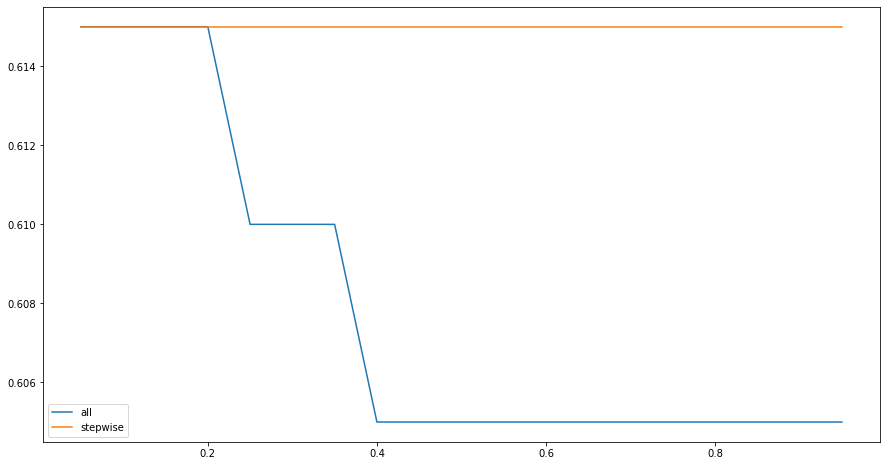

In [83]:
plt.figure(figsize=(15,8))
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

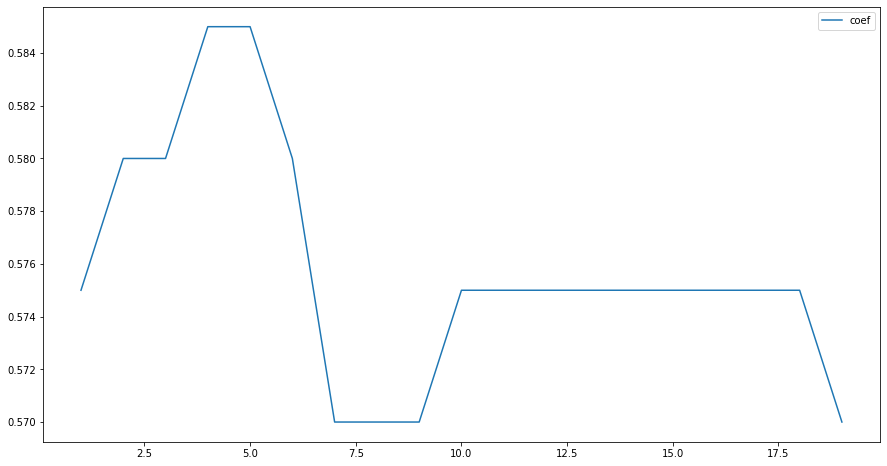

In [84]:
plt.figure(figsize=(15,8))
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.legend()

In [35]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      93  11  1  0
2      45  25  0  0
3       6   8  2  1
4       1   3  1  3 
col_0   1   2  3  4
row_0              
1      80  24  0  1
2      35  28  4  3
3       3   8  4  2
4       0   1  2  5 
col_0   1   2  3  4
row_0              
1      87  16  1  1
2      36  26  6  2
3       7   3  5  2
4       0   1  2  5


In [36]:
#애니메이션, 전체관람가 제거(다중공선성 문제 해결 위해)
X=data[['주연 top50 출연 여부','배급사','국적','전국 스크린수','경쟁작',
       '가족','공연','공포(호러)','기타','다큐멘터리','드라마','멜로/로맨스','뮤지컬',
       '미스터리','범죄','사극','스릴러','액션','어드벤처','전쟁',
       '코미디','판타지','SF','top영화감독 여부','네티즌 평점','러닝타임',
       '연작','원작','12세관람가','15세관람가','19세관람가',
       '연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
X1=data[['주연 top50 출연 여부','배급사', '전국 스크린수','러닝타임', '네티즌 평점',
        'top영화감독 여부','연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
X2=data[['주연 top50 출연 여부','전국 스크린수','15세관람가','top영화감독 여부','국적',
        '네티즌 평점','연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
y=data[['전국 관객수']]
y1=data[['전국 관객수 분류']]
y2=data[['전국 관객수 분류(2)']]

In [37]:
scaler=StandardScaler()
feature_to_scale=['전국 스크린수','러닝타임','네티즌 평점','경쟁작']
feature_to_scale1=['전국 스크린수','러닝타임','네티즌 평점']
feature_to_scale2=['전국 스크린수','네티즌 평점']
scale=scaler.fit_transform(data[feature_to_scale])
scale1=scaler.fit_transform(data[feature_to_scale1])
scale2=scaler.fit_transform(data[feature_to_scale2])
X[feature_to_scale]=scale
X1[feature_to_scale1]=scale1
X2[feature_to_scale2]=scale2

<ipython-input-37-2b440a3bce64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature_to_scale]=scale
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-37-2b440a3bce64>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [38]:
#나이브 베이지안 분류(정규분포) , 각 특성의 평균과 표준편차 고려
#연속형 데이터에 주로 사용

X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)
gnb= GaussianNB(var_smoothing=0.2)
gnb1 = GaussianNB(var_smoothing=0.1)
gnb2 = GaussianNB(var_smoothing=0.25)
gnb3 = GaussianNB(var_smoothing=0.2)
gnb4 = GaussianNB(var_smoothing=0.1)
gnb5 = GaussianNB(var_smoothing=0.25)

gnb.fit(X_train,y1_train)
gnb1.fit(X_train1,y1_train1)
gnb2.fit(X_train2,y1_train2)
gnb3.fit(X_train3,y2_train)
gnb4.fit(X_train4,y2_train1)
gnb5.fit(X_train5,y2_train2)
y_pred=gnb.predict(X_test)
y_pred1=gnb1.predict(X_test1)
y_pred2=gnb2.predict(X_test2)
y_pred3=gnb3.predict(X_test3)
y_pred4=gnb4.predict(X_test4)
y_pred5=gnb5.predict(X_test5)

print("학습 데이터 점수 : {}".format(gnb.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(gnb.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(gnb1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(gnb1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(gnb2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(gnb2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(gnb3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(gnb3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(gnb4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(gnb4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(gnb5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(gnb5.score(X_test5,y2_test2)))

학습 데이터 점수 : 0.65375
평가 데이터 점수 : 0.65
학습 데이터 점수 : 0.635
평가 데이터 점수 : 0.655
학습 데이터 점수 : 0.62125
평가 데이터 점수 : 0.67
학습 데이터 점수 : 0.63125
평가 데이터 점수 : 0.635
학습 데이터 점수 : 0.625
평가 데이터 점수 : 0.655
학습 데이터 점수 : 0.61625
평가 데이터 점수 : 0.665


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [93]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,20):
    gnb= GaussianNB(var_smoothing=i/20)
    gnb1 = GaussianNB(var_smoothing=i/20)
    gnb2 = GaussianNB(var_smoothing=i/20)
    
    gnb.fit(X_train,y1_train)
    gnb1.fit(X_train1,y1_train1)
    gnb2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(gnb.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(gnb.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(gnb1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(gnb1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(gnb2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(gnb2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i/20,gnb.score(X_test,y1_test)]
    t1.loc[i-1]=[i/20,gnb1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/20,gnb2.score(X_test2,y1_test2)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수 : 0.64875
평가 데이터 점수 : 0.58
학습 데이터 점수1 : 0.63
평가 데이터 점수1 : 0.645
학습 데이터 점수2 : 0.6325
평가 데이터 점수2 : 0.66
2
학습 데이터 점수 : 0.66125
평가 데이터 점수 : 0.635
학습 데이터 점수1 : 0.635
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.635
평가 데이터 점수2 : 0.665
3
학습 데이터 점수 : 0.66
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 0.63375
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.635
평가 데이터 점수2 : 0.665
4
학습 데이터 점수 : 0.65375
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 0.63625
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.63
평가 데이터 점수2 : 0.665
5
학습 데이터 점수 : 0.645
평가 데이터 점수 : 0.63
학습 데이터 점수1 : 0.62875
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.62125
평가 데이터 점수2 : 0.67
6
학습 데이터 점수 : 0.64125
평가 데이터 점수 : 0.63
학습 데이터 점수1 : 0.62
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 0.6125
평가 데이터 점수2 : 0.65
7
학습 데이터 점수 : 0.63125
평가 데이터 점수 : 0.62
학습 데이터 점수1 : 0.61875
평가 데이터 점수1 : 0.63
학습 데이터 점수2 : 0.61125
평가 데이터 점수2 : 0.645
8
학습 데이터 점수 : 0.6225
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 0.6175
평가 데이터 점수1 : 0.62
학습 데이터 점수2 : 0.6025
평가 데이터 점수2 : 0.64
9
학습 데이터 점수 : 0.61625
평가 데이터 점수 : 0.61
학습 데이터 점수1 : 0.61375
평가 데이터 점수1 : 0.625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

16
학습 데이터 점수 : 0.58
평가 데이터 점수 : 0.6
학습 데이터 점수1 : 0.59
평가 데이터 점수1 : 0.605
학습 데이터 점수2 : 0.58375
평가 데이터 점수2 : 0.605
17
학습 데이터 점수 : 0.57375
평가 데이터 점수 : 0.6
학습 데이터 점수1 : 0.58625
평가 데이터 점수1 : 0.61
학습 데이터 점수2 : 0.5825
평가 데이터 점수2 : 0.595
18
학습 데이터 점수 : 0.57625
평가 데이터 점수 : 0.6
학습 데이터 점수1 : 0.585
평가 데이터 점수1 : 0.6
학습 데이터 점수2 : 0.57125
평가 데이터 점수2 : 0.595
19
학습 데이터 점수 : 0.575
평가 데이터 점수 : 0.6
학습 데이터 점수1 : 0.585
평가 데이터 점수1 : 0.595
학습 데이터 점수2 : 0.56625
평가 데이터 점수2 : 0.595


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

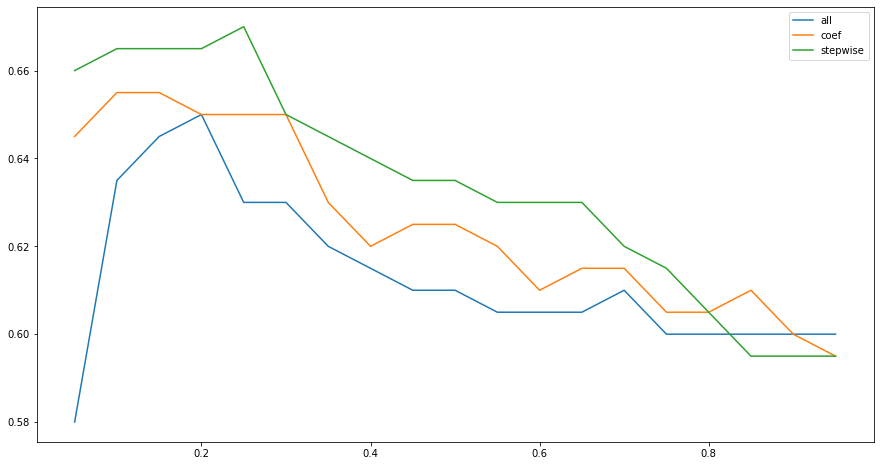

In [94]:
plt.figure(figsize=(15,8))
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [39]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      97   7  0  1
2      45  24  1  0
3       5   6  5  1
4       0   1  3  4 
col_0   1   2  3  4
row_0              
1      97   7  0  1
2      41  26  2  1
3       4   8  3  2
4       0   1  2  5 
col_0    1   2  3  4
row_0               
1      100   4  0  1
2       44  26  0  0
3        6   7  4  0
4        0   3  1  4


In [40]:
#다항 로지스틱
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)

logistic=LogisticRegression(C=0.1,multi_class='ovr',solver='lbfgs')
logistic1=LogisticRegression(C=2.5,multi_class='multinomial',solver='lbfgs')
logistic2=LogisticRegression(C=5.5,multi_class='multinomial',solver='lbfgs')
logistic3=LogisticRegression(C=0.1,multi_class='ovr',solver='lbfgs')
logistic4=LogisticRegression(C=2.5,multi_class='multinomial',solver='lbfgs')
logistic5=LogisticRegression(C=5.5,multi_class='multinomial',solver='lbfgs')

logistic.fit(X_train,y1_train)
logistic1.fit(X_train1,y1_train1)
logistic2.fit(X_train2,y1_train2)
logistic3.fit(X_train3,y2_train)
logistic4.fit(X_train4,y2_train1)
logistic5.fit(X_train5,y2_train2)

y_pred=logistic.predict(X_test)
y_pred1=logistic1.predict(X_test1)
y_pred2=logistic2.predict(X_test2)
y_pred3=logistic3.predict(X_test3)
y_pred4=logistic4.predict(X_test4)
y_pred5=logistic5.predict(X_test5)

print("학습 데이터 점수 : {}".format(logistic.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(logistic.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(logistic1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(logistic1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(logistic2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(logistic2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(logistic3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(logistic3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(logistic4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(logistic4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(logistic5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(logistic5.score(X_test5,y2_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수 : 0.6425
평가 데이터 점수 : 0.68
학습 데이터 점수 : 0.64625
평가 데이터 점수 : 0.685
학습 데이터 점수 : 0.66
평가 데이터 점수 : 0.71
학습 데이터 점수 : 0.6375
평가 데이터 점수 : 0.675
학습 데이터 점수 : 0.62625
평가 데이터 점수 : 0.69
학습 데이터 점수 : 0.63625
평가 데이터 점수 : 0.685


In [25]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
p=pd.DataFrame(columns=['mc','solver','score'])
p1=pd.DataFrame(columns=['mc','solver','score'])
p2=pd.DataFrame(columns=['mc','solver','score'])
for i in ['auto', 'ovr','multinomial']:
    for j in ['newton-cg','sag','saga','lbfgs']:
        k=0
        logistic=LogisticRegression(multi_class=i,solver=j)
        logistic1=LogisticRegression(multi_class=i,solver=j)
        logistic2=LogisticRegression(multi_class=i,solver=j)
        logistic.fit(X_train,y1_train)
        logistic1.fit(X_train1,y1_train1)
        logistic2.fit(X_train2,y1_train2)
        print(i,j)
        print("학습 데이터 점수 : {}".format(logistic.score(X_train,y1_train)))
        print("평가 데이터 점수 : {}".format(logistic.score(X_test,y1_test)))
        print("학습 데이터 점수1 : {}".format(logistic1.score(X_train1,y1_train1)))
        print("평가 데이터 점수1 : {}".format(logistic1.score(X_test1,y1_test1)))
        print("학습 데이터 점수2 : {}".format(logistic2.score(X_train2,y1_train2)))
        print("평가 데이터 점수2 : {}".format(logistic2.score(X_test2,y1_test2)))
        p.loc[k]=[i,j,logistic.score(X_test,y1_test)]
        p1.loc[k]=[i,j,logistic1.score(X_test1,y1_test1)]
        p2.loc[k]=[i,j,logistic2.score(X_test2,y1_test2)]
        k=k+1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

auto newton-cg
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
auto sag
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\li

auto saga
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
auto lbfgs
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
ovr newton-cg
학습 데이터 점수 : 0.67125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.63
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.64375
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\li

ovr sag
학습 데이터 점수 : 0.67125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.63
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.64375
평가 데이터 점수2 : 0.675
ovr saga
학습 데이터 점수 : 0.67125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\li

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.63
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.64375
평가 데이터 점수2 : 0.675
ovr lbfgs
학습 데이터 점수 : 0.67125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.63
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.64375
평가 데이터 점수2 : 0.675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


multinomial newton-cg
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
multinomial sag
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

multinomial saga
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


multinomial lbfgs
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


In [28]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,100):
    logistic=LogisticRegression(C=i/20,multi_class='multinomial',solver='lbfgs')
    logistic1=LogisticRegression(C=i/20,multi_class='multinomial',solver='lbfgs')
    logistic2=LogisticRegression(C=i/20,multi_class='multinomial',solver='lbfgs')
    logistic.fit(X_train,y1_train)
    logistic1.fit(X_train1,y1_train1)
    logistic2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(logistic.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(logistic.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(logistic1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(logistic1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(logistic2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(logistic2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i/20,logistic.score(X_test,y1_test)]
    t1.loc[i-1]=[i/20,logistic1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/20,logistic2.score(X_test2,y1_test2)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수 : 0.65875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6325
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 0.62375
평가 데이터 점수2 : 0.67
2
학습 데이터 점수 : 0.6725
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 0.63375
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 0.64
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

3
학습 데이터 점수 : 0.67125
평가 데이터 점수 : 0.675
학습 데이터 점수1 : 0.635
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6425
평가 데이터 점수2 : 0.7
4
학습 데이터 점수 : 0.675
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.6475
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

5
학습 데이터 점수 : 0.6775
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.63875
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 0.6475
평가 데이터 점수2 : 0.695
6
학습 데이터 점수 : 0.67875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.645
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


7
학습 데이터 점수 : 0.6825
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64125
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.645
평가 데이터 점수2 : 0.69
8
학습 데이터 점수 : 0.68625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.64375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

9
학습 데이터 점수 : 0.69
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6475
평가 데이터 점수2 : 0.69
10
학습 데이터 점수 : 0.69125
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.64875
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

11
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


12
학습 데이터 점수 : 0.69375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69
13
학습 데이터 점수 : 0.69375
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

14
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65
평가 데이터 점수2 : 0.69
15
학습 데이터 점수 : 0.695
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65125
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

16
학습 데이터 점수 : 0.695
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6525
평가 데이터 점수2 : 0.69
17
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

18
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 0.65375
평가 데이터 점수2 : 0.69
19
학습 데이터 점수 : 0.695
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

20
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
21
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

22
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.695
23
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

24
학습 데이터 점수 : 0.7
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


25
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.695
26

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65625
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

27
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695
28


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


29
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695
30

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695
31
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

32
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695
33
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

34
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

35
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

36
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.7
37
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.7
38
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.7
39
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.64375
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.65875
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

40
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

41
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

42
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
43
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

44
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
45


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
46
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.665

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
47
학습 데이터 점수 : 0.69625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
48
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64625

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
49

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


50
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

51
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
52
학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
53
학습 데이터 점수 : 0.69625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
54

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

55
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
56
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

57
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

58
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

59
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
60

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
61

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

62
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
63
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

64
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
65


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

66
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

67
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7
68

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7
69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7
70
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

71
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

72
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
73

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

74
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
75
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

76
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705
77
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

78
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
79
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

80
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
81

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
82
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
83
학습 데이터 점수 : 0.6975

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

84
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
85

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
86
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

87
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
88

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
89

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

90
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
91

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


92
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

93
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
94

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705
95

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  r

96
학습 데이터 점수 : 0.69875
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705
97

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705
98

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check


학습 데이터 점수 : 0.69625
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705
99
학습 데이터 점수 : 0.6975
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


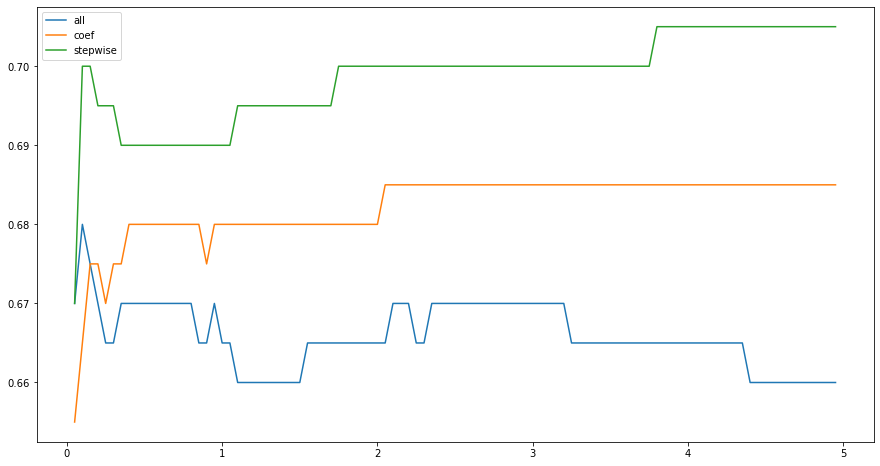

In [29]:
plt.figure(figsize=(15,8))
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [32]:

X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)

t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,100):
    
    logistic1=LogisticRegression(C=i/2,multi_class='multinomial',solver='lbfgs')
    logistic2=LogisticRegression(C=i/2,multi_class='multinomial',solver='lbfgs')
    
    logistic1.fit(X_train1,y1_train1)
    logistic2.fit(X_train2,y1_train2)
    print(i)
    
    print("학습 데이터 점수1 : {}".format(logistic1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(logistic1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(logistic2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(logistic2.score(X_test2,y1_test2)))
    
    t1.loc[i-1]=[i/2,logistic1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i/2,logistic2.score(X_test2,y1_test2)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

1
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.64875
평가 데이터 점수2 : 0.69
2
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.655
평가 데이터 점수2 : 0.69
3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.6575
평가 데이터 점수2 : 0.695
4
학습 데이터 점수1 : 0.645
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.7
5
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
6
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.7
8
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



9
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


10
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.705
11
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

12
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71
13
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

14
학습 데이터 점수1 : 0.64625
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71
15
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


16
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71
17
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


18
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

19
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
20
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


21
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
22
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

23
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
24
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

25
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
26
학습 데이터 점수1 : 0.6475
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


27
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
28
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
29
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

30
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
31
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

32
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
33
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

34
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
35
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.66125
평가 데이터 점수2 : 0.71
36
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
37
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
38
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

39
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
40
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
41
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

42
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
43
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


44
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
45
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
46

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
47
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

48
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
49
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
50
학습 데이터 점수1 : 0.64875
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
51
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
52
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

평가 데이터 점수2 : 0.71
53
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

54
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
55
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

56
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
57
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


58
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


59
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


60
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


61
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
62
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
64
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

65
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
66
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
67

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
68
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
69

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
70
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
71

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
72
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

73
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
74
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
75

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
76
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

77
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
78
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
79


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
80
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
81

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
82
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

83
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
84
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
85

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
86
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
87

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**


학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
88
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
89
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

90
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
91
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
92
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

93
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
94
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
95


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
96
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


97
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
98
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71
99
학습 데이터 점수1 : 0.65
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 0.6625
평가 데이터 점수2 : 0.71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


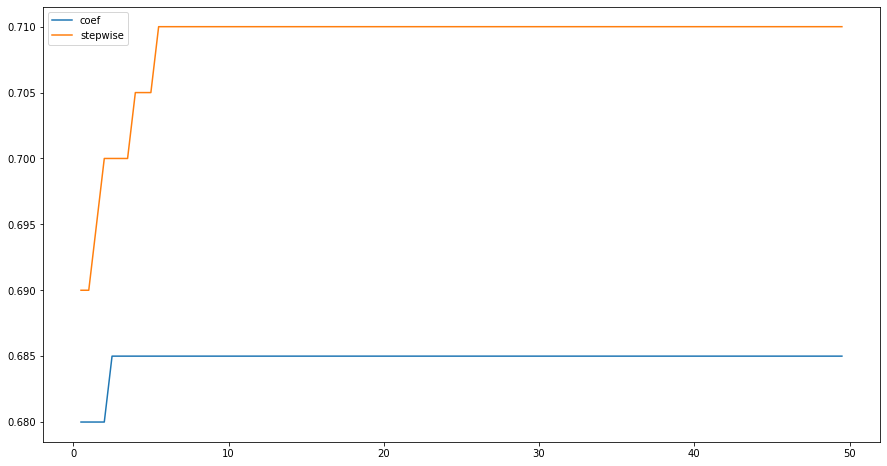

In [33]:
plt.figure(figsize=(15,8))
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [41]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      94  11  0  0
2      33  37  0  0
3       6   9  1  1
4       0   3  1  4 
col_0   1   2  3  4
row_0              
1      88  17  0  0
2      26  42  2  0
3       4   8  3  2
4       0   1  3  4 
col_0   1   2  3  4
row_0              
1      90  15  0  0
2      27  42  1  0
3       4   6  6  1
4       0   2  2  4


In [42]:
#K-최근접 이웃 알고리즘(분류)
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
X_train3,X_test3,y2_train,y2_test=train_test_split(X,y2,random_state=5,test_size=0.2)
X_train4,X_test4,y2_train1,y2_test1=train_test_split(X1,y2,random_state=5,test_size=0.2)
X_train5,X_test5,y2_train2,y2_test2=train_test_split(X2,y2,random_state=5,test_size=0.2)

knn=KNeighborsClassifier(n_neighbors=7, weights='distance')
knn1=KNeighborsClassifier(n_neighbors=10, weights='distance')
knn2=KNeighborsClassifier(n_neighbors=39, weights='distance')
knn3=KNeighborsClassifier(n_neighbors=5, weights='distance')
knn4=KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn5=KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train,y1_train)
knn1.fit(X_train1,y1_train1)
knn2.fit(X_train2,y1_train2)
knn3.fit(X_train3,y2_train)
knn4.fit(X_train4,y2_train1)
knn5.fit(X_train5,y2_train2)

y_pred=knn.predict(X_test)
y_pred1=knn1.predict(X_test1)
y_pred2=knn2.predict(X_test2)
y_pred3=knn3.predict(X_test3)
y_pred4=knn4.predict(X_test4)
y_pred5=knn5.predict(X_test5)

print("학습 데이터 점수 : {}".format(knn.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(knn.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(knn1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(knn1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(knn2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(knn2.score(X_test2,y1_test2)))
print("학습 데이터 점수 : {}".format(knn3.score(X_train3,y2_train)))
print("평가 데이터 점수 : {}".format(knn3.score(X_test3,y2_test)))
print("학습 데이터 점수 : {}".format(knn4.score(X_train4,y2_train1)))
print("평가 데이터 점수 : {}".format(knn4.score(X_test4,y2_test1)))
print("학습 데이터 점수 : {}".format(knn5.score(X_train5,y2_train2)))
print("평가 데이터 점수 : {}".format(knn5.score(X_test5,y2_test2)))


<ipython-input-42-d56afe4031b8>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-42-d56afe4031b8>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-42-d56afe4031b8>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-42-d56afe4031b8>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn3.fit(X_train3,y2_train)
<ipython-input-42-d56afe4031b8>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expe

학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.68
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.705
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.68
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수 : 0.71625
평가 데이터 점수 : 0.6
학습 데이터 점수 : 0.725
평가 데이터 점수 : 0.615


In [30]:
X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)
t=pd.DataFrame(columns=['i','score'])
t1=pd.DataFrame(columns=['i','score'])
t2=pd.DataFrame(columns=['i','score'])
for i in range(1,50):
    knn=KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn1=KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn2=KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train,y1_train)
    knn1.fit(X_train1,y1_train1)
    knn2.fit(X_train2,y1_train2)
    print(i)
    print("학습 데이터 점수 : {}".format(knn.score(X_train,y1_train)))
    print("평가 데이터 점수 : {}".format(knn.score(X_test,y1_test)))
    print("학습 데이터 점수1 : {}".format(knn1.score(X_train1,y1_train1)))
    print("평가 데이터 점수1 : {}".format(knn1.score(X_test1,y1_test1)))
    print("학습 데이터 점수2 : {}".format(knn2.score(X_train2,y1_train2)))
    print("평가 데이터 점수2 : {}".format(knn2.score(X_test2,y1_test2)))
    t.loc[i-1]=[i,knn.score(X_test,y1_test)]
    t1.loc[i-1]=[i,knn1.score(X_test1,y1_test1)]
    t2.loc[i-1]=[i,knn2.score(X_test2,y1_test2)]


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

1
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.575
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.575
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.545
2
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.575
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.575
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.545
3
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.605
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.6
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.575


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

4
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.615
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.585
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.615
5
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.615
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.585
6
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.64
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.615
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.59
7
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.68
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.635
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.6
8
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.655

<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect


학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.62
9
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.62
10
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.645
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.705
학습 데이터 점수2 : 1.0

<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp


평가 데이터 점수2 : 0.63
11
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.625
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.635
12
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.62


<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp

학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.65
13
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.63
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.66
14
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.625


<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp

학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.66
15
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.65
16
학습 데이터 점수 : 1.0

<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp


평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.665
17
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.64
18
학습 데이터 점수 : 1.0


<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp

평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.66
19
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.665
20
학습 데이터 점수 : 1.0

<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect


평가 데이터 점수 : 0.67
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.66
21
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.66
22
학습 데이터 점수 : 1.0

<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect


평가 데이터 점수 : 0.675
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
23
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
24


<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp

학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
25
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
26
학습 데이터 점수 : 1.0


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

평가 데이터 점수 : 0.675
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
27
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.665
28
학습 데이터 점수 : 1.0

<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp


평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.665
29
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675


<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was exp

30
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.65
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
31
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.66
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

32
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.655
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
33
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.665
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

34
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
35
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 1.0


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

평가 데이터 점수2 : 0.675
36
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.67
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67
37
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
38
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.675
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
39
학습 데이터 점수 : 1.0


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.68
40
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.65
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.68


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

41
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.68
42
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.68
43
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.67
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.68
44
학습 데이터 점수 : 1.0


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

평가 데이터 점수 : 0.655
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.68
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
45
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.665
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.67


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect

46
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
47
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.685
학습 데이터 점수2 : 1.0

<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)
<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expect


평가 데이터 점수2 : 0.67
48
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.695
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675
49
학습 데이터 점수 : 1.0
평가 데이터 점수 : 0.66
학습 데이터 점수1 : 1.0
평가 데이터 점수1 : 0.69
학습 데이터 점수2 : 1.0
평가 데이터 점수2 : 0.675


<ipython-input-30-6ffcc4c467b6>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train,y1_train)
<ipython-input-30-6ffcc4c467b6>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn1.fit(X_train1,y1_train1)
<ipython-input-30-6ffcc4c467b6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn2.fit(X_train2,y1_train2)


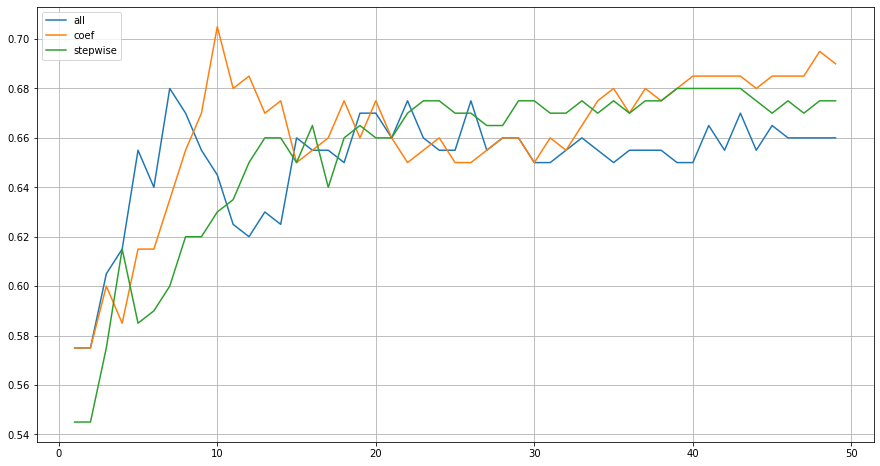

In [31]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(t[['i']],t[['score']],label="all")
plt.plot(t1[['i']],t1[['score']],label="coef")
plt.plot(t2[['i']],t2[['score']],label="stepwise")
plt.legend()

In [48]:
#크로스탭
y1_test=y1_test.values.ravel()
y1_test1=y1_test1.values.ravel()
y1_test2=y1_test2.values.ravel()
ct=pd.crosstab(index=y1_test,columns=y_pred)
ct1=pd.crosstab(index=y1_test1,columns=y_pred1)
ct2=pd.crosstab(index=y1_test2,columns=y_pred2)
print(ct, "\n{}".format(ct1),"\n{}".format(ct2))

col_0   1   2  3  4
row_0              
1      92  11  2  0
2      31  35  4  0
3       4   8  5  0
4       0   2  2  4 
col_0   1   2  3  4
row_0              
1      89  16  0  0
2      29  38  3  0
3       3   5  9  0
4       0   2  1  5 
col_0   1   2  3  4
row_0              
1      89  16  0  0
2      29  37  4  0
3       5   5  7  0
4       0   3  2  3


In [49]:
#hard voting 앙상블
model1=SVC(kernel='linear', C=0.06)
model2=GaussianNB(var_smoothing=0.2)
model3=RandomForestClassifier()
model4=KNeighborsClassifier(n_neighbors=7)
model5=LogisticRegression(C=0.1,multi_class='ovr',solver='lbfgs')
model1_1=SVC(kernel='linear', C=0.22)
model2_1=GaussianNB(var_smoothing=0.1)
model3_1=RandomForestClassifier()
model4_1=KNeighborsClassifier(n_neighbors=10)
model5_1=LogisticRegression(C=2.5,multi_class='multinomial',solver='lbfgs')
model1_2=SVC(kernel='linear', C=0.14)
model2_2=GaussianNB(var_smoothing=0.25)
model3_2=RandomForestClassifier()
model4_2=KNeighborsClassifier(n_neighbors=39)
model5_2=LogisticRegression(C=5.5,multi_class='multinomial',solver='lbfgs')


vote_model = VotingClassifier(
    estimators=[('svc',model1),('naive',model2),('forest',model3),('knn',model4),('log',model5)],
    voting='hard')
vote_model1 = VotingClassifier(
    estimators=[('svc',model1_1),('naive',model2_1),('forest',model3_1),('knn',model4_1),('log',model5_1)],
    voting='hard')
vote_model2 = VotingClassifier(
    estimators=[('svc',model1_2),('naive',model2_2),('forest',model3_2),('knn',model4_2),('log',model5_2)],
    voting='hard')

X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)

vote_model.fit(X_train,y1_train)
vote_model1.fit(X_train1,y1_train1)
vote_model2.fit(X_train2,y1_train2)

print("학습 데이터 점수 : {}".format(vote_model.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(vote_model.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(vote_model1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(vote_model1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(vote_model2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(vote_model2.score(X_test2,y1_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.715
평가 데이터 점수 : 0.7
학습 데이터 점수 : 0.6925
평가 데이터 점수 : 0.695
학습 데이터 점수 : 0.6875
평가 데이터 점수 : 0.69


In [51]:
#soft voting 앙상블
model1=SVC(kernel='linear', C=0.06, probability=True)
model2=GaussianNB(var_smoothing=0.2)
model3=RandomForestClassifier()
model4=KNeighborsClassifier(n_neighbors=7)
model5=LogisticRegression(C=0.1,multi_class='ovr',solver='lbfgs')
model1_1=SVC(kernel='linear', C=0.22, probability=True)
model2_1=GaussianNB(var_smoothing=0.1)
model3_1=RandomForestClassifier()
model4_1=KNeighborsClassifier(n_neighbors=10)
model5_1=LogisticRegression(C=2.5,multi_class='multinomial',solver='lbfgs')
model1_2=SVC(kernel='linear', C=0.14, probability=True)
model2_2=GaussianNB(var_smoothing=0.25)
model3_2=RandomForestClassifier()
model4_2=KNeighborsClassifier(n_neighbors=39)
model5_2=LogisticRegression(C=5.5,multi_class='multinomial',solver='lbfgs')


vote_model = VotingClassifier(
    estimators=[('svc',model1),('naive',model2),('forest',model3),('knn',model4),('log',model5)],
    voting='soft')
vote_model1 = VotingClassifier(
    estimators=[('svc',model1_1),('naive',model2_1),('forest',model3_1),('knn',model4_1),('log',model5_1)],
    voting='soft')
vote_model2 = VotingClassifier(
    estimators=[('svc',model1_2),('naive',model2_2),('forest',model3_2),('knn',model4_2),('log',model5_2)],
    voting='soft')

X_train,X_test,y1_train,y1_test= train_test_split(X,y1,random_state=5,test_size=0.2)
X_train1,X_test1,y1_train1,y1_test1=train_test_split(X1,y1,random_state=5,test_size=0.2)
X_train2,X_test2,y1_train2,y1_test2=train_test_split(X2,y1,random_state=5,test_size=0.2)

vote_model.fit(X_train,y1_train)
vote_model1.fit(X_train1,y1_train1)
vote_model2.fit(X_train2,y1_train2)

print("학습 데이터 점수 : {}".format(vote_model.score(X_train,y1_train)))
print("평가 데이터 점수 : {}".format(vote_model.score(X_test,y1_test)))
print("학습 데이터 점수 : {}".format(vote_model1.score(X_train1,y1_train1)))
print("평가 데이터 점수 : {}".format(vote_model1.score(X_test1,y1_test1)))
print("학습 데이터 점수 : {}".format(vote_model2.score(X_train2,y1_train2)))
print("평가 데이터 점수 : {}".format(vote_model2.score(X_test2,y1_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.815
평가 데이터 점수 : 0.68
학습 데이터 점수 : 0.78
평가 데이터 점수 : 0.685
학습 데이터 점수 : 0.7825
평가 데이터 점수 : 0.655


In [128]:
#voting 앙상블 회귀
reg1 = LinearRegression()
reg2 = SVR(C=200000)
reg3 = KNeighborsRegressor(n_neighbors=10, weights='distance')
reg4= GradientBoostingRegressor()
reg5= RandomForestRegressor()
reg1_1 = LinearRegression()
reg2_1 = SVR(C=200000)
reg3_1 = KNeighborsRegressor(n_neighbors=13, weights='distance')
reg4_1= GradientBoostingRegressor()
reg5_1= RandomForestRegressor()
reg1_2 = LinearRegression()
reg2_2 = SVR(C=200000)
reg3_2 = KNeighborsRegressor(n_neighbors=12, weights='distance')
reg4_2= GradientBoostingRegressor()
reg5_2= RandomForestRegressor()

vote_reg_model = VotingRegressor(
    estimators=[('linear',reg1),('svr',reg2),('knr',reg3),('gbr',reg4),('rfr',reg5)],
    weights=[1,1,1,1,1])
vote_reg_model1 = VotingRegressor(
    estimators=[('linear',reg1_1),('svr',reg2_1),('knr',reg3_1),('gbr',reg4_1),('rfr',reg5_1)],
    weights=[1,1,1,1,1])
vote_reg_model2 = VotingRegressor(
    estimators=[('linear',reg1_2),('svr',reg2_2),('knr',reg3_2),('gbr',reg4_2),('rfr',reg5_2)],
    weights=[1,1,1,1,1])

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=5,test_size=0.2)
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y,random_state=5,test_size=0.2)
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y,random_state=5,test_size=0.2)

vote_reg_model.fit(X_train,y_train)
vote_reg_model1.fit(X_train1,y_train1)
vote_reg_model2.fit(X_train2,y_train2)

print("학습 데이터 점수 : {}".format(vote_reg_model.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(vote_reg_model.score(X_test,y_test)))
print("학습 데이터 점수 : {}".format(vote_reg_model1.score(X_train1,y_train1)))
print("평가 데이터 점수 : {}".format(vote_reg_model1.score(X_test1,y_test1)))
print("학습 데이터 점수 : {}".format(vote_reg_model2.score(X_train2,y_train2)))
print("평가 데이터 점수 : {}".format(vote_reg_model2.score(X_test2,y_test2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 : 0.869152817057679
평가 데이터 점수 : 0.5862297112082029
학습 데이터 점수 : 0.8668200686763569
평가 데이터 점수 : 0.6065360440394791
학습 데이터 점수 : 0.8625394952419184
평가 데이터 점수 : 0.5952385424603394


In [172]:
#코로나 여파, 감독의 이전작품 평균 관객수 데이터 넣은것
data=pd.read_excel('C:\\Users\wjdtj\\Desktop\\pbl_movie2.xlsx',header=0)

In [173]:
X=pd.DataFrame()
y=pd.DataFrame()
y1=pd.DataFrame()

In [174]:
data.corr()

순번  주연 top50 출연 여부  \
순번                                                  1.000000       -0.393259   
주연 top50 출연 여부                                     -0.393259        1.000000   
배급사                                                -0.193928        0.203331   
수상내역                                               -0.281607        0.137343   
국적                                                  0.040897       -0.155971   
전국 스크린수                                            -0.606507        0.306095   
전국 매출액                                             -0.756708        0.302128   
전국 관객수 분류                                          -0.887295        0.365040   
전국 관객수 로그                                          -0.985380        0.389942   
전국 관객수                                             -0.760445        0.308597   
경쟁작                                                 0.026196       -0.043850   
가족                                                  0.080378       -0.079224   
공연                                                  0.043785       -0.029854   
공포(호러)                                              0.068486       -0.135146   
기타                                                  0.065597       -0.042241   
다큐멘터리                                               0.003757       -0.038486   
드라마                                                 0.040666        0.076808   
멜로/로맨스                                              0.031579       -0.027510   
뮤지컬                                                 0.017007        0.021503   
미스터리                                                0.016153        0.051825   
범죄                                                 -0.117548        0.171842   
사극                                                 -0.099081        0.124391   
스릴러                                                -0.002264        0.036771   
애니메이션                                               0.192036       -0.307128   
액션                                                 -0.154391        0.112442   
어드벤처                                               -0.024482       -0.033583   
전쟁                                                 -0.034158        0.046723   
코미디                                                -0.012284        0.020729   
판타지                                                -0.013467       -0.003979   
SF                                                  0.028691       -0.044372   
러닝타임                                               -0.358124        0.326347   
네티즌 평점                                             -0.185130       -0.041912   
감독 평균 관객 유치수                                       -0.689385        0.329670   
연작                                                 -0.076202       -0.073909   
원작                                                  0.006279       -0.038387   
전체관람가                                               0.203277       -0.329156   
12세관람가                                             -0.131964        0.060457   
15세관람가                                             -0.052528        0.169676   
19세관람가                                              0.024106        0.052300   
2005년 이후 감독의 해당 영화 개봉전 평균 관객수(20만 이상만)             -0.282460        0.164264   
연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 ... -0.378719        0.206151   
코로나 여파                                              0.038184        0.010563   

                                                         배급사      수상내역  \
순번                                                 -0.193928 -0.281607   
주연 top50 출연 여부                                      0.203331  0.137343   
배급사                                                 1.000000  0.029149   
수상내역                                                0.029149  1.000000   
국적                                                 -0.417270 -0.038935   
전국 스크린수                                             0.171444  0.204980   
전국 매출액                                              0.198814  0.413330   
전국 관객수 분류                

In [175]:
#애니메이션, 전체관람가 제거
X=data[['주연 top50 출연 여부','배급사','국적','전국 스크린수','경쟁작',
       '가족','공연','공포(호러)','기타','다큐멘터리','드라마','멜로/로맨스','뮤지컬',
       '미스터리','범죄','사극','스릴러','액션','어드벤처','전쟁',
       '코미디','판타지','SF','2005년 이후 감독의 해당 영화 개봉전 평균 관객수(20만 이상만)','네티즌 평점','러닝타임',
       '연작','원작','12세관람가','15세관람가','19세관람가','코로나 여파',
       '연휴기간 상영여부 (연휴 기간 상영 영화중 점유율 TOP2% (104개정도이고 최저 점유율 대략 17.7%))']]
y=data[['전국 관객수']]
y1=data[['전국 관객수 분류']]

In [176]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [177]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2)
linear=LinearRegression()

In [178]:
start = time.time()
linear.fit(X_train, y_train)
y_pred=linear.predict(X_test)
for i in range(0,199):
    if y_pred[i]<0:
        y_pred[i]=0
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("학습 데이터 점수 : {}".format(linear.score(X_train,y_train)))
print("평가 데이터 점수 : {}".format(linear.score(X_test,y_test)))
print("rmse : {}".format(rmse))
print(time.time()-start)

학습 데이터 점수 : 0.5981697203494893
평가 데이터 점수 : 0.5478907060521445
rmse : 1746420.3310512456
0.008319616317749023


In [179]:
X_train3,X_test3,y1_train,y1_test= train_test_split(X,y1,test_size=0.2)
svc=SVC(kernel='linear',C=0.04)
start = time.time()
svc.fit(X_train3,y1_train)
y_pred=svc.predict(X_test3)
rmse=np.sqrt(mean_squared_error(y1_test,y_pred))
print("학습 데이터 점수 : {}".format(svc.score(X_train3,y1_train)))
print("평가 데이터 점수 : {}".format(svc.score(X_test3,y1_test)))
print("rmse : {}".format(rmse))
print(time.time()-start)

학습 데이터 점수 : 0.67
평가 데이터 점수 : 0.63
rmse : 0.7348469228349535
0.06652092933654785


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
